https://stats.stackexchange.com/questions/157012/area-under-precision-recall-curve-auc-of-pr-curve-and-average-precision-ap


https://stackoverflow.com/questions/38787612/how-to-extract-feature-importances-from-an-sklearn-pipeline
https://towardsdatascience.com/how-to-get-feature-importances-from-any-sklearn-pipeline-167a19f1214

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

https://link.springer.com/article/10.1007/s13748-016-0094-0

https://stackoverflow.com/questions/62663370/using-pipeline-with-gridsearchcv
https://medium.com/@cmukesh8688/sklearn-pipeline-gridsearchcv-54f5552bbf4e

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import datetime
import time
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from myTools import *

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
from numpy import mean, std
from sklearn.model_selection import cross_val_predict

In [3]:
def shuffleDf(df1):

    df = df1.copy()
    df = df.reset_index(drop=True)
    index_lst = df.index.to_list()
    random.shuffle(index_lst)
    df.index = index_lst
    df = df.reset_index(drop=False)
    df = df.sort_values("index")
    del df["index"] 
    return df

In [4]:
def statsOutliers(df):
    from numpy import percentile
    numerical_ix = list(df.select_dtypes(include=['float64','int64']).columns)
    dico = {}
    for col in numerical_ix:
        dataCol = df[~df[col].isnull()][col]
        q25, q75 = percentile(dataCol, 25), percentile(dataCol, 75)
        iqr = q75 - q25
        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        if df[((df[col] < lower) | (df[col] > upper))].shape[0] > 0:
            dico[col] = df[((df[col] < lower) | (df[col] > upper))].shape[0]
        
    return dico

In [5]:
def statImbalancedOutlier(df1, feature, limit_outlier, nb_points=100, to_add_to_threshold=0):

    df = df1.copy()
    
    if limit_outlier < 0:
        df[feature] = -df[feature]
        min_outlier = -limit_outlier
    else:
        min_outlier = limit_outlier
    max_outlier = np.max(df[feature])
    results = []
    results_total = []
    
    thresholds = np.arange(nb_points) * (max_outlier - min_outlier) / nb_points + min_outlier
    for threshold in thresholds:
        nb_total = df[df[feature] >= threshold].shape[0]
        nb_positif = df[(df[feature] >= threshold) & (df['TARGET'] == 1)].shape[0]
        prct_positif = nb_positif / nb_total * 100
        results.append(prct_positif)
        results_total.append(nb_total)
    if limit_outlier < 0:
        thresholds = thresholds * -1
    
    thresholds = np.array(thresholds) + to_add_to_threshold
    
    size=1
    nbPlot=2
    plt.rcParams.update({'font.size':10, 'font.style':'normal'})
    fig = plt.figure(figsize=(size * (18 * nbPlot/2), size * 8))
    sub = fig.add_subplot(1,nbPlot,1)
    sub.set_title('Positive class vs outliers')
    #plt.legend(loc = 'lower right')
    plt.plot(thresholds, results)
    plt.axis('tight')
    plt.xlabel('threshold outlier')
    plt.ylabel('classe positive (%)')
    sub = fig.add_subplot(1,nbPlot,2)
    sub.set_title('Nb total record vs outlier')
    #plt.legend(loc = 'lower right')
    plt.plot(thresholds, results_total)
    plt.axis('tight')
    plt.xlabel('threshold outlier')
    plt.ylabel('Nb records')
    plt.rcParams.update({'font.size':12, 'font.style':'normal'})
    plt.suptitle(feature)
    plt.show()

In [6]:
def evaluateImputer(imputer, model, X, y, title,cv=3):
    from sklearn.impute import SimpleImputer
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import RobustScaler
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline

    numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_ix = X.select_dtypes(include=['object', 'bool']).columns
    X[categorical_ix] = X[categorical_ix].replace(np.nan, 'missing')
    t = [('cat', OneHotEncoder(handle_unknown='ignore', sparse=True), categorical_ix), ('num', MinMaxScaler(), numerical_ix)]
    #t = [('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-10), categorical_ix), ('num', MinMaxScaler(), numerical_ix)]
    col_transform = ColumnTransformer(transformers=t)
    pipeline = Pipeline(steps=[('prep',col_transform), ('i', imputer), ('m', model)])
    # evaluate the model
    t1 = time.time()
    scores = cross_val_score(pipeline, X, y, scoring= 'roc_auc' , cv=cv, n_jobs=-1)
    t2 = time.time()
    print( ' > %.3f (%.3f) %.0f ' % (mean(scores), std(scores), t2-t1))
    plt.boxplot([scores], labels=[title], showmeans=True)
    plt.title = title
    plt.show()

In [33]:
# https://stackoverflow.com/questions/38787612/how-to-extract-feature-importances-from-an-sklearn-pipeline

def metrics_model(model, X_train, y_train, X_test, y_test, display_plot=False, calc_feat_imp = False, features = [], label_model = 'Modèle', dummy_strategy='constant', dummy_constant=1, cv=None):
    
    if cv == None:
        cv = cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        cv = 3
        
    # training
    date1 = time.time()
    model.fit(X_train,y_train)
    date2 = time.time()
    duration_training = date2 - date1

    # predicting on train set
    date1 = time.time()
    #y_prob = model.predict_proba(X_train)[:,1] 
    y_prob = cross_val_predict(model, X_train, y_train, cv=cv, method='predict_proba')[:,1] 
    date2 = time.time()
    duration_pred_train = date2 - date1

    # evaluating on train set
    date1 = time.time()
    fpr, tpr, thr = roc_curve(y_train, y_prob)
    roc_auc_train = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_train, y_prob)
    pr_auc_train = auc(recall, precision)
    date2 = time.time()
    duration_metric_train = date2 - date1

    # predicting on test set
    date1 = time.time()
    #y_prob = model.predict_proba(X_test)[:,1] 
    y_prob = cross_val_predict(model, X_test, y_test, cv=cv, method='predict_proba')[:,1] 
    date2 = time.time()
    duration_pred_test = date2 - date1

    # evaluating on test set
    date1 = time.time()
    fpr, tpr, thr = roc_curve(y_test, y_prob)
    roc_auc_test = auc(fpr, tpr)
    precision, recall, threshold = precision_recall_curve(y_test, y_prob)
    pr_auc_test = auc(recall, precision)
    
    date2 = time.time()
    duration_metric_test = date2 - date1

    if calc_feat_imp:
        feature_imp = pd.DataFrame(features,model.feature_importances_).reset_index(drop=False)
        feature_imp.columns = ["importance",'feature']
        feature_imp = feature_imp.sort_values("importance", ascending=False)
    else:
        feature_imp = ''
        
    # no skill model
    model = DummyClassifier(strategy= dummy_strategy, constant=dummy_constant)
    model.fit(X_train, y_train)
    yhat = model.predict_proba(X_test)
    y_prob = yhat[:, 1]
    fpr_dummy, tpr_dummy, thr_dummy = roc_curve(y_test, y_prob)
    precision_dummy, recall_dummy, _ = precision_recall_curve(y_test, y_prob)
    roc_auc_dummy = auc(fpr_dummy, tpr_dummy)
    pr_auc_dummy = auc(recall_dummy, precision_dummy)
    

    
    if display_plot:
        
        print('TRAIN SET: ROC AUC=%.3f, PR AUC=%.3f' % (roc_auc_train, pr_auc_train))
        print('TEST SET:  ROC AUC=%.3f, PR AUC=%.3f' % (roc_auc_test, pr_auc_test))
        
        import matplotlib.pyplot as plt
        import numpy as np
        
        size = 1
        if calc_feat_imp:
            nbPlot = 3
        else:
            nbPlot = 2
        fig = plt.figure(figsize=(size * (18 * nbPlot/2), size * 8))
        
        sub = fig.add_subplot(1,nbPlot,1)
        sub.set_title('ROC curve')
        plt.plot(fpr,tpr, color='red',label = 'AUC = %0.3f' % roc_auc_test)
        #plt.plot(fpr_dummy,tpr_dummy, color='black', label = 'AUC dummy = %0.2f' % roc_auc_dummy)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],linestyle='--')
        plt.axis('tight')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        
        sub = fig.add_subplot(1,nbPlot,2)
        sub.set_title('Precision-Recall curve')
        plt.plot(recall, precision, color='red',label = 'AUC = %0.3f' % pr_auc_test)
        #plt.plot(recall_dummy, precision_dummy, color='black', label = 'AUC dummy = %0.2f' % pr_auc_dummy)
        plt.legend(loc = 'lower right')
        plt.axis('tight')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        
           
        
        if calc_feat_imp:
            sub = fig.add_subplot(1,nbPlot,3)
            x = np.arange(len(features))
            #fig, ax = plt.subplots()
            #ax.yaxis.set_major_formatter(formatter)
            tmp = feature_imp.sort_values("importance", ascending=True)
            plt.barh(x, tmp.importance)
            plt.yticks(x, tmp.feature, rotation=0)
            sub.yaxis.tick_right()            
            plt.rcParams.update({'font.size':10, 'font.style':'normal'})
            sub.set_title('Feature importance')
        
        plt.rcParams.update({'font.size':12, 'font.style':'normal'})
        plt.suptitle(label_model)
        
        plt.show()
    
    return [duration_training, duration_pred_train, roc_auc_train, pr_auc_train, duration_pred_test, roc_auc_test, pr_auc_test, feature_imp]


In [8]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

# https://medium.com/@literallywords/sklearn-identity-transformer-fcc18bac0e98
from sklearn.base import BaseEstimator, TransformerMixin

class IdentityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, input_array, y=None):
        return self
    
    def transform(self, input_array, y=None):
        return input_array*1

def transformDf(df1, scaler=MinMaxScaler()):
    
    df = df1.copy()
    
    for col in list(df.select_dtypes(include=['int64','float64']).columns):
        if col not in ['SK_ID_CURR','TARGET']:
            df[col] = SimpleImputer(strategy='mean').fit_transform(df[[col]])
            
    for col in list(df.select_dtypes(include=['int64','float64']).columns):
        if col not in ['SK_ID_CURR','TARGET']:
            if df.nunique()[col] > 100:
                df[col] = df[col].astype('float64')
            else:
                df[col] = df[col].astype('int64')            
        
    numerical_ix = df.select_dtypes(include=['float64']).columns
    integer_ix = df.select_dtypes(include=['int64']).columns
    categorical_ix = df.select_dtypes(include=['object', 'bool']).columns
    
    df[categorical_ix] = df[categorical_ix].replace(np.nan, 'missing')
    
    for col in df.columns:
        if df[col].dtypes == 'object':
            df[col] = OrdinalEncoder().fit_transform(df[[col]])
        elif df[col].dtype in ['int64','float64']:
            if col not in ['SK_ID_CURR','TARGET']:
                df[col] = MinMaxScaler().fit_transform(df[[col]])
            
    for col in list(df.select_dtypes(include=['int64','float64']).columns):
        if col not in ['SK_ID_CURR','TARGET']:
            if df.nunique()[col] > 100:
                df[col] = df[col].astype('float64')
            else:
                df[col] = df[col].astype('int64')    
            
    # ne marche pas???
    if False:  
        for col in list(categorical_ix):
            ordinal_encoder = OrdinalEncoder()
            df[col] = ordinal_encoder.fit_transform(df[col])

        for col in list(numerical_ix):
            df[col] = MinMaxScaler().fit_transform(df[col])

        for col in df.columns:
            if dfApplicationDefaultMiss[col].dtypes == 'object':
                ordinal_encoder = OrdinalEncoder()
                df[col] = ordinal_encoder.fit_transform(df[[col]])
             
    # change l'ordre des colonnes
    if False:
        #t = [('cat', OneHotEncoder(handle_unknown='ignore'), categorical_ix), ('num', MinMaxScaler(), numerical_ix)]
        t = [('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-10), categorical_ix), ('num', MinMaxScaler(), numerical_ix), ('int', MinMaxScaler(), integer_ix)]
        col_transform = ColumnTransformer(transformers=t)
        pipeline = Pipeline(steps=[('prep',col_transform), ('i', SimpleImputer(strategy='mean'))])

        t = [('cat', OrdinalEncoder(), categorical_ix), ('num', MinMaxScaler(), numerical_ix), ('int', IdentityTransformer(), integer_ix)]
        col_transform = ColumnTransformer(transformers=t)
        pipeline = Pipeline(steps=[('prep',col_transform)])
    
        return pd.DataFrame(pipeline.fit_transform(df), columns=df.columns)
        
    return df

In [9]:
def ColMode(df, feature, key):
    
    feature = [feature]
    
    # dataframe de travail sans les nans et avec les colonnes feature et key
    cols = feature.copy()
    cols.extend(key)
    tmp = df[cols].dropna()
    
    # Count par feature-key
    tmp = pd.DataFrame(tmp.groupby(cols).size(), columns=['COUNT']).reset_index(drop=False)
    
    # Par key, valeurs les plus fréquentes de la feature
    tmpMaxCount = tmp.groupby(by=key).agg({'COUNT': 'max'}).reset_index(drop=False)
    colsMerge = key.copy()
    colsMerge.append('COUNT')
    tmp = tmp.merge(tmpMaxCount, left_on=colsMerge, right_on=colsMerge)

    # A chaque valeur de feature ont affecte un poids égal au nombre de fois que la valeur est prise dans la table
    colsPopularity = feature.copy()
    colsPopularity.append('COUNT')
    popularity = tmp.groupby(feature).agg({'COUNT': 'sum'}).reset_index(drop=False)
    colsPopularity = feature.copy()
    colsPopularity.append('POPULARITY')
    popularity.columns = colsPopularity
    
    tmp = tmp.merge(popularity)
    
    tmp2 = tmp.groupby(key).agg({'COUNT': 'max'}).reset_index(drop=False)
    tmp = tmp.merge(tmp2)
    tmp2 = tmp.groupby(key).agg({'POPULARITY': 'min'}).reset_index(drop=False)
    tmp = tmp.merge(tmp2)
    
    del tmp['COUNT']
    del tmp['POPULARITY']
    
    return tmp

def TransformUnique(df, key):
    categorical_ix = df.select_dtypes(include=['object']).columns
    dfCat = df[key].drop_duplicates()
    for col in categorical_ix:
        dfCat = dfCat.merge(ColMode(df, col, key), left_on=key, right_on=key, how='left')
    dfNum = df.groupby(key).mean().reset_index(drop=False)
    dfUnique = dfCat.merge(dfNum, left_on=key, right_on=key, how='left')
    return dfUnique

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def feat_imp(X, y, col, model=DecisionTreeClassifier()):

    i = 0
    for _ in np.arange(10):
        model.fit(X, y)
        imp = model.feature_importances_
        if i == 0:
            importance = pd.DataFrame(imp)
        else:
            importance = pd.concat([importance,pd.DataFrame(imp)], axis=1)
        i += 1
        
    statImp = pd.DataFrame(col, columns=['feature'])
    
    statImp['impMean'] = np.mean(importance, axis=1)
    statImp['impMedian'] = np.median(importance, axis=1)
    statImp['impQ75'] = np.quantile(importance, 0.75, axis=1)
    statImp['impMax'] = np.max(importance, axis=1)
    
    statImp = statImp.sort_values('impMedian', ascending=False).reset_index(drop=True).reset_index(drop=False)
    statImp = statImp.rename(columns={'index':'classement'})
    statImp['classement'] = statImp.apply(lambda x: x.classement+1, axis=1)
    
    return statImp


def feat_perm_imp(X, y, col, model=DecisionTreeClassifier()):
    
    from sklearn.inspection import permutation_importance
    model.fit(X, y)
    results = permutation_importance(model, X, y, scoring='roc_auc')
    importance = pd.DataFrame(results.importances_mean, columns=['perm_imp'])
    importance['feature'] = col
    importance = importance[['feature','perm_imp']]
    
    importance = importance.sort_values('perm_imp', ascending=False).reset_index(drop=True).reset_index(drop=False)
    importance = importance.rename(columns={'index':'perm_classement'})
    importance['perm_classement'] = importance.apply(lambda x: x.perm_classement+1, axis=1)
    
    return importance


def feature_importance(X, y, X_col, model=RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1)):
    perm_imp = feat_perm_imp(X, y, X_col, model)
    imp = feat_imp(X, y, X_col, model)
    imp = imp.merge(perm_imp, left_on='feature', right_on='feature')
    imp['diff_classement'] = imp.apply(lambda x: np.abs(x.classement - x.perm_classement), axis=1)
    imp['best_classement'] = imp.apply(lambda x: np.min([x.classement, x.perm_classement]), axis=1)
    return imp

## Import et aperçu des données

### Fonction de mise à plat des fichiers

In [10]:

def flat_df(defaultData=False, splitRate=0):
    
    t1 = time.time()
    
    print(datetime.datetime.now())
    
    #########################################
    # CHARGEMENT DES FICHIERS
    #########################################
    
    dfApplicationTrain = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv',",")
    dfBureau = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/bureau.csv',",")
    dfBureauBalance = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/bureau_balance.csv',",")
    dfPreviousApplication = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/previous_application.csv',",")
    dfPosCashBalance = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/POS_CASH_balance.csv',",")
    dfCreditCardBalance = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/credit_card_balance.csv',",")
    dfInstallmentsPayments = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/installments_payments.csv',",")
    
    t2 = time.time()
    print("{} - {} - fichiers chargés".format(datetime.datetime.now(), t2-t1))
    t1 = t2

    
    #########################################
    # REDUCTION DU JEU DE DONNEES (ce n'est pas le train/test split classique)
    #########################################
    
    if splitRate == 0:
        dfApplication = dfApplicationTrain
    else:
        dfApplication, _ = train_test_split(dfApplicationTrain, test_size=splitRate, random_state=1)

    dfPreviousApplication = dfPreviousApplication.merge(dfApplication[['SK_ID_CURR']], left_on='SK_ID_CURR', right_on='SK_ID_CURR')
    dfPosCashBalance = dfPosCashBalance.merge(dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV']], left_on=['SK_ID_CURR','SK_ID_PREV'], right_on=['SK_ID_CURR','SK_ID_PREV'])
    dfInstallmentsPayments = dfInstallmentsPayments.merge(dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV']], left_on=['SK_ID_CURR','SK_ID_PREV'], right_on=['SK_ID_CURR','SK_ID_PREV'])
    dfCreditCardBalance = dfCreditCardBalance.merge(dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV']], left_on=['SK_ID_CURR','SK_ID_PREV'], right_on=['SK_ID_CURR','SK_ID_PREV'])
    dfBureau = dfBureau.merge(dfApplication[['SK_ID_CURR']], left_on='SK_ID_CURR', right_on='SK_ID_CURR')
    dfBureauBalance = dfBureauBalance.merge(dfBureau[['SK_ID_BUREAU']], left_on='SK_ID_BUREAU', right_on='SK_ID_BUREAU')
    
    t2 = time.time()
    print("{} - {} - réduction du jeu de données".format(datetime.datetime.now(), t2-t1))
    t1 = t2

    
    #########################################
    # MARQUAGE DES VALEURS MANQUANTES
    #########################################

    dfApplication = dfApplication.replace('XNA', np.nan)
    dfPreviousApplication = dfPreviousApplication.replace('XNA', np.nan)
    dfBureau = dfBureau.replace('XNA', np.nan)
    dfApplication = dfApplication.replace('XAP', np.nan)
    dfPreviousApplication = dfPreviousApplication.replace('XAP', np.nan)
    dfBureau = dfBureau.replace('XAP', np.nan)
    dfBureauBalance = dfBureauBalance.replace('X', np.nan)
    
    t2 = time.time()
    print("{} - {} - marquage des valeurs manquantes".format(datetime.datetime.now(), t2-t1))
    t1 = t2



    #########################################
    # SUPPRESSION DE LIGNES
    #########################################

    if not defaultData:
        dfPreviousApplication = dfPreviousApplication[(dfPreviousApplication.FLAG_LAST_APPL_PER_CONTRACT == 'Y') & (dfPreviousApplication.NFLAG_LAST_APPL_IN_DAY == 1)]
        dfPreviousApplication = dfPreviousApplication[dfPreviousApplication.NAME_CONTRACT_STATUS.isin(['Approved','Refused'])]
        dfInstallmentsPayments = dfInstallmentsPayments[dfInstallmentsPayments.AMT_INSTALMENT != 0]
        
        
        t2 = time.time()
        print("{} - {} - suppression de lignes".format(datetime.datetime.now(), t2-t1))
        t1 = t2


    #########################################
    # SUPPRESSION DE VARIABLES
    #########################################

    if not defaultData:

        # COLONNES NON PERTINENTES

        # Suppression de champs non pertinents
        col_to_del = [
        'FLAG_MOBIL', # Did client provide mobile phone
        'FLAG_EMP_PHONE', # Did client provide work phone (1=YES, 0=NO)
        'FLAG_WORK_PHONE', # Did client provide home phone (1=YES, 0=NO)
        'FLAG_CONT_MOBILE', # Was mobile phone reachable (1=YES, 0=NO)
        'FLAG_PHONE', # Did client provide home phone (1=YES, 0=NO)
        'FLAG_EMAIL', # Did client provide email (1=YES, 0=NO)

        # ininéressant
        'NAME_TYPE_SUITE',  # Who was accompanying client when he was applying for the loan
        'DAYS_ID_PUBLISH', # How many days before the application did client change the identity document with which he applied for the loan,time only relative to the application
        'DAYS_REGISTRATION', # How many days before the application did client change his registration,time only relative to the application
        'WEEKDAY_APPR_PROCESS_START', # On which day of the week did the client apply for the loan
        'HOUR_APPR_PROCESS_START', # Approximately at what hour did the client apply for the loan,rounded
        'DAYS_LAST_PHONE_CHANGE', # How many days before application did client change phone

        # flags de comparaison de donnée
        'REG_REGION_NOT_LIVE_REGION', # Flag if client's permanent address does not match contact address
        'REG_REGION_NOT_WORK_REGION', # Flag if client's permanent address does not match contact address
        'LIVE_REGION_NOT_WORK_REGION', # Flag if client's contact address does not match work address
        'REG_CITY_NOT_LIVE_CITY', # Flag if client's permanent address does not match contact address (1=different, 0=same, at city level)
        'REG_CITY_NOT_WORK_CITY', # Flag if client's permanent address does not match work address (1=different, 0=same, at city level)
        'LIVE_CITY_NOT_WORK_CITY', # Flag if client's contact address does not match work address (1=different, 0=same, at city level)

        ]

        for col in col_to_del:
            del dfApplication[col]

        for col in dfApplication:
            if col[0:13] == 'FLAG_DOCUMENT':  # Did client provide document
                del dfApplication[col]



        del dfPreviousApplication['FLAG_LAST_APPL_PER_CONTRACT'] # Flag if it was last application for the previous contract. Sometimes by mistake of client or our clerk there could be more applications for one single contract
        del dfPreviousApplication['NFLAG_LAST_APPL_IN_DAY'] # Flag if the application was the last application per day of the client. Sometimes clients apply for more applications a day. Rarely it could also be error in our system that one application is in the database twice

        del dfPreviousApplication['NAME_TYPE_SUITE'] # Who accompanied client when applying for the previous application
        del dfPreviousApplication['WEEKDAY_APPR_PROCESS_START'] #On which day of the week did the client apply for the loan
        del dfPreviousApplication['HOUR_APPR_PROCESS_START'] #Approximately at what hour did the client apply for the loan
        del dfPreviousApplication['NAME_CLIENT_TYPE'] #Was the client old or new client when applying for the previous application
        del dfPreviousApplication['SELLERPLACE_AREA'] #Selling area of seller place of the previous application


        del dfInstallmentsPayments['NUM_INSTALMENT_VERSION'] #Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed
        del dfInstallmentsPayments['NUM_INSTALMENT_NUMBER'] #On which installment we observe payment

        del dfPosCashBalance['CNT_INSTALMENT'] # Term of previous credit (can change over time)
        del dfPosCashBalance['CNT_INSTALMENT_FUTURE'] # Installments left to pay on the previous credit


        # COLONNES AVEC TROP DE VALEURS MANQUANTES

        del dfPreviousApplication['RATE_INTEREST_PRIMARY']
        del dfPreviousApplication['RATE_INTEREST_PRIVILEGED']
        del dfPreviousApplication['NAME_CASH_LOAN_PURPOSE']
        del dfBureau['AMT_ANNUITY']


        # COLONNES AVEC TROP DE VALEURS IDENTIQUES

        del dfPreviousApplication['NAME_PAYMENT_TYPE']
        del dfBureau['CREDIT_CURRENCY']
        del dfBureau['CNT_CREDIT_PROLONG']
        del dfBureau['CREDIT_DAY_OVERDUE']
        del dfBureau['AMT_CREDIT_SUM_OVERDUE']


        # COLONNES CORRELLEE AVEC UNE AUTRE

        del dfApplication['EXT_SOURCE_1']
        del dfApplication['OBS_60_CNT_SOCIAL_CIRCLE']
        del dfApplication['DEF_60_CNT_SOCIAL_CIRCLE']
        del dfApplication['OWN_CAR_AGE']
        del dfApplication['CNT_FAM_MEMBERS']
        del dfApplication['AMT_GOODS_PRICE']
        del dfApplication['REGION_RATING_CLIENT_W_CITY']
        del dfApplication['REGION_POPULATION_RELATIVE']
        del dfApplication['APARTMENTS_AVG']
        del dfApplication['APARTMENTS_MEDI']
        del dfApplication['BASEMENTAREA_AVG']
        del dfApplication['BASEMENTAREA_MEDI']
        del dfApplication['COMMONAREA_AVG']
        del dfApplication['COMMONAREA_MEDI']
        del dfApplication['ELEVATORS_AVG']
        del dfApplication['ELEVATORS_MEDI']
        del dfApplication['ENTRANCES_AVG']
        del dfApplication['ENTRANCES_MEDI']
        del dfApplication['FLOORSMAX_AVG']
        del dfApplication['FLOORSMAX_MEDI']
        del dfApplication['FLOORSMIN_AVG']
        del dfApplication['FLOORSMIN_MEDI']
        del dfApplication['LANDAREA_AVG']
        del dfApplication['LANDAREA_MEDI']
        del dfApplication['LIVINGAPARTMENTS_AVG']
        del dfApplication['LIVINGAPARTMENTS_MEDI']
        del dfApplication['LIVINGAREA_AVG']
        del dfApplication['LIVINGAREA_MEDI']
        del dfApplication['NONLIVINGAPARTMENTS_AVG']
        del dfApplication['NONLIVINGAPARTMENTS_MEDI']
        del dfApplication['NONLIVINGAREA_AVG']
        del dfApplication['NONLIVINGAREA_MEDI']
        del dfApplication['YEARS_BEGINEXPLUATATION_AVG']
        del dfApplication['YEARS_BEGINEXPLUATATION_MEDI']
        del dfApplication['YEARS_BUILD_AVG']
        del dfApplication['YEARS_BUILD_MEDI']
        del dfApplication['EMERGENCYSTATE_MODE']
        del dfApplication['HOUSETYPE_MODE']
        del dfApplication['NONLIVINGAREA_MODE']
        del dfApplication['NONLIVINGAPARTMENTS_MODE']
        del dfApplication['BASEMENTAREA_MODE']
        del dfApplication['COMMONAREA_MODE']
        del dfApplication['ELEVATORS_MODE']
        del dfApplication['ENTRANCES_MODE']
        del dfApplication['FLOORSMAX_MODE']
        del dfApplication['FLOORSMIN_MODE']
        del dfApplication['LANDAREA_MODE']
        del dfApplication['LIVINGAPARTMENTS_MODE']
        del dfApplication['LIVINGAREA_MODE']
        del dfApplication['TOTALAREA_MODE']
        del dfApplication['YEARS_BUILD_MODE']
        del dfApplication['FONDKAPREMONT_MODE']


        del dfPreviousApplication['DAYS_FIRST_DRAWING']
        del dfPreviousApplication['DAYS_FIRST_DUE']
        del dfPreviousApplication['DAYS_LAST_DUE_1ST_VERSION']
        del dfPreviousApplication['DAYS_LAST_DUE']
        del dfPreviousApplication['DAYS_TERMINATION']
        del dfPreviousApplication['AMT_APPLICATION']
        del dfPreviousApplication['AMT_GOODS_PRICE']
        del dfPreviousApplication['AMT_ANNUITY']
        del dfPreviousApplication['CNT_PAYMENT']
        del dfPreviousApplication['NAME_PORTFOLIO']
        del dfPreviousApplication['CODE_REJECT_REASON']
        del dfPreviousApplication['CHANNEL_TYPE']
        del dfPreviousApplication['NAME_CONTRACT_TYPE']
        del dfPreviousApplication['PRODUCT_COMBINATION']
        del dfPreviousApplication['NAME_GOODS_CATEGORY']
        del dfPreviousApplication['AMT_DOWN_PAYMENT']


        del dfCreditCardBalance['AMT_INST_MIN_REGULARITY']
        del dfCreditCardBalance['AMT_RECEIVABLE_PRINCIPAL']
        del dfCreditCardBalance['AMT_RECIVABLE']
        del dfCreditCardBalance['AMT_TOTAL_RECEIVABLE']
        del dfCreditCardBalance['AMT_DRAWINGS_POS_CURRENT']
        del dfCreditCardBalance['AMT_DRAWINGS_ATM_CURRENT']
        del dfCreditCardBalance['AMT_PAYMENT_CURRENT']
        del dfCreditCardBalance['AMT_CREDIT_LIMIT_ACTUAL']
        del dfCreditCardBalance['CNT_DRAWINGS_ATM_CURRENT']
        del dfCreditCardBalance['CNT_DRAWINGS_POS_CURRENT']
        del dfCreditCardBalance['AMT_DRAWINGS_OTHER_CURRENT']
        del dfCreditCardBalance['AMT_DRAWINGS_CURRENT']

        del dfPosCashBalance['SK_DPD_DEF']

        del dfBureau['DAYS_CREDIT_UPDATE']
        del dfBureau['DAYS_ENDDATE_FACT']
        del dfBureau['AMT_CREDIT_SUM_DEBT']


        # COLONNES DE TABLE DU TROISIEME NIVEAU

        del dfCreditCardBalance['AMT_BALANCE']
        del dfCreditCardBalance['AMT_PAYMENT_TOTAL_CURRENT']
        del dfCreditCardBalance['CNT_DRAWINGS_CURRENT']
        del dfCreditCardBalance['CNT_DRAWINGS_OTHER_CURRENT']
        del dfCreditCardBalance['CNT_INSTALMENT_MATURE_CUM']




        t2 = time.time()
        print("{} - {} - suppression de variables".format(datetime.datetime.now(), t2-t1))
        t1 = t2

    
    
    #########################################
    # TRANSFORMATION DE VARIABLES
    #########################################

    # On remonte le dernier statut des tables de niveau 3 dans PreviousApplication

    dfPreviousApplicationStatus = pd.concat([dfPosCashBalance[['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE','NAME_CONTRACT_STATUS']],dfCreditCardBalance[['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE','NAME_CONTRACT_STATUS']]])
    tmp = dfPreviousApplicationStatus.groupby(['SK_ID_CURR','SK_ID_PREV']).agg({'MONTHS_BALANCE':'max'}).reset_index(drop=False)
    dfPreviousApplicationStatus = dfPreviousApplicationStatus.merge(tmp, left_on=['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE'], right_on=['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE'])
    del dfPreviousApplicationStatus['MONTHS_BALANCE']
    dfPreviousApplicationStatus = dfPreviousApplicationStatus.rename(columns={'NAME_CONTRACT_STATUS': 'LAST_NAME_CONTRACT_STATUS'})
    dfPreviousApplication = dfPreviousApplication.merge(dfPreviousApplicationStatus, left_on=['SK_ID_CURR','SK_ID_PREV'], right_on=['SK_ID_CURR','SK_ID_PREV'], how='left')

    dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.LAST_NAME_CONTRACT_STATUS == 'Completed'].index, "LAST_NAME_CONTRACT_STATUS_TMP"] = 0
    dfPreviousApplication.at[dfPreviousApplication[(dfPreviousApplication.LAST_NAME_CONTRACT_STATUS != 'Completed') & (~dfPreviousApplication.LAST_NAME_CONTRACT_STATUS.isnull())].index, "LAST_NAME_CONTRACT_STATUS_TMP"] = 1
    dfPreviousApplication['LAST_NAME_CONTRACT_STATUS'] = dfPreviousApplication['LAST_NAME_CONTRACT_STATUS_TMP']
    del dfPreviousApplication['LAST_NAME_CONTRACT_STATUS_TMP']
    dfPreviousApplication['LAST_NAME_CONTRACT_STATUS'] = dfPreviousApplication['LAST_NAME_CONTRACT_STATUS'].astype(float)

    del dfCreditCardBalance['NAME_CONTRACT_STATUS']
    del dfPosCashBalance['NAME_CONTRACT_STATUS']
    
    
    t2 = time.time()
    print("{} - {} - remontée de name_contract_status".format(datetime.datetime.now(), t2-t1))
    t1 = t2


    
    if defaultData:
        
        dfBureauBalance.at[dfBureauBalance[dfBureauBalance.STATUS.isin(['C','X'])].index, "STATUS"] = 0
        dfBureauBalance["STATUS"] = dfBureauBalance["STATUS"].astype(float)


        t2 = time.time()
        print("{} - {} - mise à zéro des status balance bureau C et X".format(datetime.datetime.now(), t2-t1))
        t1 = t2
    

    if not defaultData:

        dfApplication['AMT_REQ_CREDIT_BUREAU_YEAR'] = dfApplication.apply(lambda x: x.AMT_REQ_CREDIT_BUREAU_HOUR + \
                                                                                         x.AMT_REQ_CREDIT_BUREAU_DAY + \
                                                                                         x.AMT_REQ_CREDIT_BUREAU_WEEK + \
                                                                                         x.AMT_REQ_CREDIT_BUREAU_MON + \
                                                                                         x.AMT_REQ_CREDIT_BUREAU_QRT + \
                                                                                         x.AMT_REQ_CREDIT_BUREAU_YEAR, axis=1)
        dfApplication['AMT_REQ_CREDIT_BUREAU_WEEK'] = dfApplication.apply(lambda x: x.AMT_REQ_CREDIT_BUREAU_HOUR + \
                                                                                         x.AMT_REQ_CREDIT_BUREAU_DAY + \
                                                                                         x.AMT_REQ_CREDIT_BUREAU_WEEK, axis=1)
        
        dfApplication['RATIO_ANNUITY_INCOME'] = dfApplication.apply(lambda x: x.AMT_ANNUITY / (x.AMT_INCOME_TOTAL + 0.1), axis=1)

        dfApplication['AMT_INCOME_TOTAL_LOG'] = dfApplication.apply(lambda x: np.log(x.AMT_INCOME_TOTAL), axis=1)
        
        

        dfApplication['DAYS_EMPLOYED'] = dfApplication.apply(lambda x: np.where(x.DAYS_EMPLOYED>0,1,x.DAYS_EMPLOYED),axis=1).astype('int')


        dfApplication.at[dfApplication[dfApplication.NAME_EDUCATION_TYPE == 'Academic degree'].index, "NAME_EDUCATION_TYPE"] = 1
        dfApplication.at[dfApplication[dfApplication.NAME_EDUCATION_TYPE == 'Higher education'].index, "NAME_EDUCATION_TYPE"] = 2
        dfApplication.at[dfApplication[dfApplication.NAME_EDUCATION_TYPE == 'Incomplete higher'].index, "NAME_EDUCATION_TYPE"] = 3
        dfApplication.at[dfApplication[dfApplication.NAME_EDUCATION_TYPE == 'Secondary / secondary special'].index, "NAME_EDUCATION_TYPE"] = 4
        dfApplication.at[dfApplication[dfApplication.NAME_EDUCATION_TYPE == 'Lower secondary'].index, "NAME_EDUCATION_TYPE"] = 5

        dfApplication['NAME_EDUCATION_TYPE'] = dfApplication['NAME_EDUCATION_TYPE'].astype(float)

        dfApplication.at[dfApplication[dfApplication.NAME_FAMILY_STATUS == 'Married'].index, "SINGLE_FLAG"] = 0
        dfApplication.at[dfApplication[dfApplication.NAME_FAMILY_STATUS == 'Civil marriage'].index, "SINGLE_FLAG"] = 0
        dfApplication.at[dfApplication[dfApplication.NAME_FAMILY_STATUS == 'Single / not married'].index, "SINGLE_FLAG"] = 1
        dfApplication.at[dfApplication[dfApplication.NAME_FAMILY_STATUS == 'Separated'].index, "SINGLE_FLAG"] = 1
        dfApplication.at[dfApplication[dfApplication.NAME_FAMILY_STATUS == 'Widow'].index, "SINGLE_FLAG"] = 1
        dfApplication.at[dfApplication[dfApplication.NAME_FAMILY_STATUS == 'Unknown'].index, "SINGLE_FLAG"] = 1

        dfApplication['SINGLE_FLAG'] = dfApplication['SINGLE_FLAG'].astype(float)
        
        
        t2 = time.time()
        print("{} - {} - feature engeeniring sur REQ, EDUC et FAMILY_STATUS".format(datetime.datetime.now(), t2-t1))
        t1 = t2


        df1 = dfBureau[['SK_ID_CURR','SK_ID_BUREAU','DAYS_CREDIT']]
        df1.columns = ['SK_ID_CURR','SK_ID_PREV','DAYS_DECISION']
        df2 = dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV','DAYS_DECISION']]
        dfDays = pd.concat([df1,df2])

        #https://www.kaggle.com/shanth84/home-credit-bureau-data-feature-engineering
        grp = dfDays[['SK_ID_CURR', 'SK_ID_PREV', 'DAYS_DECISION']].groupby(by = ['SK_ID_CURR'])
        grp1 = grp.apply(lambda x: x.sort_values(['DAYS_DECISION'], ascending = False)).reset_index(drop = True)#rename(index = str, columns = {'DAYS_CREDIT': 'DAYS_CREDIT_DIFF'})
        grp1['DAYS_DECISION1'] = grp1['DAYS_DECISION']*-1
        grp1['DAYS_DIFF'] = grp1.groupby(by = ['SK_ID_CURR'])['DAYS_DECISION1'].diff()
        grp1['DAYS_DIFF'] = grp1['DAYS_DIFF'].fillna(0).astype('uint32')
        del grp1['DAYS_DECISION1'], grp1['DAYS_DECISION'], grp1['SK_ID_CURR']
        dfDays = dfDays.merge(grp1, left_on='SK_ID_PREV', right_on='SK_ID_PREV')
        del dfDays['DAYS_DECISION']
        del dfDays['SK_ID_PREV']
        dfDays = dfDays.groupby('SK_ID_CURR').mean().reset_index(drop=False)
        dfDays['DAYS_DIFF'] = dfDays['DAYS_DIFF'].astype(float)
        
        t2 = time.time()
        print("{} - {} - PREV DAYS_DIFF".format(datetime.datetime.now(), t2-t1))
        t1 = t2

        # Création d'une variable montant moyen logarithmique
        dfPreviousApplication['AMT_CREDIT_LOG'] = dfPreviousApplication.apply(lambda x: np.log(x.AMT_CREDIT+1), axis=1)
        dfBureau['AMT_CREDIT_SUM_LOG'] = dfBureau.apply(lambda x: np.log(x.AMT_CREDIT_SUM+1), axis=1)
        df1 = dfBureau[['SK_ID_CURR','SK_ID_BUREAU','AMT_CREDIT_SUM_LOG']]
        df1.columns = ['SK_ID_CURR','SK_ID_PREV','AMT_CREDIT_LOG']
        df2 = dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV','AMT_CREDIT_LOG']]
        dfAmtLog = pd.concat([df1,df2])
        del dfAmtLog['SK_ID_PREV']
        dfAmtLogMean = dfAmtLog.groupby('SK_ID_CURR').mean().reset_index(drop=False)

        del dfBureau['AMT_CREDIT_SUM_LOG']
        del dfPreviousApplication['AMT_CREDIT_LOG']

        # Création d'une variable écart type logarithmique des montants 
        df1 = dfBureau[['SK_ID_CURR','SK_ID_BUREAU','AMT_CREDIT_SUM']]
        df1.columns = ['SK_ID_CURR','SK_ID_PREV','AMT_CREDIT']
        df2 = dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV','AMT_CREDIT']]
        dfAmt = pd.concat([df1,df2])
        del dfAmt['SK_ID_PREV']
        dfAmtStdLog = dfAmt.groupby('SK_ID_CURR').std().reset_index(drop=False).rename(columns = {'AMT_CREDIT': 'AMT_CREDIT_STD'})
        dfAmtStdLog['AMT_CREDIT_STD_LOG'] = dfAmtStdLog.apply(lambda x: np.log(1+x.AMT_CREDIT_STD), axis=1)
        del dfAmtStdLog['AMT_CREDIT_STD']
        
        t2 = time.time()
        print("{} - {} - PREV montant logarithmique dur PREV".format(datetime.datetime.now(), t2-t1))
        t1 = t2


        # NameSellerIndustry avec le plus gros montant cumulé par client
        tmp0 = dfPreviousApplication[~dfPreviousApplication.NAME_SELLER_INDUSTRY.isnull()].reset_index(drop=False)
        tmp1 = tmp0[['SK_ID_CURR','NAME_SELLER_INDUSTRY','AMT_CREDIT']].groupby(['SK_ID_CURR','NAME_SELLER_INDUSTRY']).sum().reset_index(drop=False)
        tmp2 = tmp1[['SK_ID_CURR','AMT_CREDIT']].groupby(['SK_ID_CURR']).max().reset_index(drop=False)
        tmp3 = tmp1.merge(tmp2, left_on=['SK_ID_CURR','AMT_CREDIT'], right_on=['SK_ID_CURR','AMT_CREDIT'])
        # Pour les rares clients avec plusieurs seller_industry préférés, on en sélectionne un au hasard en se basant sur l'index
        tmp4 = tmp3.reset_index(drop=False)[['SK_ID_CURR','index']].groupby('SK_ID_CURR').max().reset_index(drop=False)
        tmp3 = tmp3.reset_index(drop=False)
        tmp3 = tmp3.merge(tmp4, left_on=['SK_ID_CURR','index'], right_on=['SK_ID_CURR','index'])
        dfPreviousApplicationMainSellerIndustry = tmp3[['SK_ID_CURR','NAME_SELLER_INDUSTRY']]
        dfPreviousApplicationMainSellerIndustry.columns = ['SK_ID_CURR','MAIN_SELLER_INDUSTRY']
        
        t2 = time.time()
        print("{} - {} - PREV NAME_SELLER_INDUSTRY".format(datetime.datetime.now(), t2-t1))
        t1 = t2


        dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_YIELD_GROUP == 'high'].index, "NAME_YIELD_GROUP"] = 3
        dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_YIELD_GROUP == 'middle'].index, "NAME_YIELD_GROUP"] = 2
        dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_YIELD_GROUP == 'low_normal'].index, "NAME_YIELD_GROUP"] = 1
        dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_YIELD_GROUP == 'low_action'].index, "NAME_YIELD_GROUP"] = 1
        dfPreviousApplication['NAME_YIELD_GROUP'] = dfPreviousApplication['NAME_YIELD_GROUP'].astype(float)   
        
        t2 = time.time()
        print("{} - {} - PREV NAME_YIELD_GROUP".format(datetime.datetime.now(), t2-t1))
        t1 = t2

        # Nombre de type de seller industry par client
        dfPreviousApplicationNbSellerIndustry = dfPreviousApplication[['SK_ID_CURR','NAME_SELLER_INDUSTRY']].drop_duplicates().groupby('SK_ID_CURR').count().reset_index(drop=False)
        dfPreviousApplicationNbSellerIndustry.columns = ['SK_ID_CURR','NB_SELLER_INDUSTRY']

        dfPreviousApplication = dfPreviousApplication.merge(dfPreviousApplicationMainSellerIndustry, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
        dfPreviousApplication = dfPreviousApplication.merge(dfPreviousApplicationNbSellerIndustry, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
        del dfPreviousApplication['NAME_SELLER_INDUSTRY']
        
        t2 = time.time()
        print("{} - {} - PREV NB_SELLER_INDUS".format(datetime.datetime.now(), t2-t1))
        t1 = t2

        # Création d'une variable nombre de previous application
        dfNbPreviousApplication = pd.DataFrame(dfPreviousApplication.groupby('SK_ID_CURR').size(), columns=['NB_PREVIOUS']).reset_index(drop=False)
        dfPreviousApplication = dfPreviousApplication.merge(dfNbPreviousApplication, left_on='SK_ID_CURR', right_on='SK_ID_CURR')
        
        t2 = time.time()
        print("{} - {} - PREV NB_PREVIOUS".format(datetime.datetime.now(), t2-t1))
        t1 = t2



        dfBureau['CREDIT_ACTIVE'] = dfBureau.apply(lambda x: np.where(x.CREDIT_ACTIVE == 'Active', 1, 0), axis=1)
        dfBureau.CREDIT_ACTIVE = dfBureau.CREDIT_ACTIVE.astype(float)
        
        
        t2 = time.time()
        print("{} - {} - BURO NB_PRCREDIT_ACTIVE".format(datetime.datetime.now(), t2-t1))
        t1 = t2


        dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_CONTRACT_STATUS == 'Approved'].index, "NAME_CONTRACT_STATUS"] = 1
        dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_CONTRACT_STATUS == 'Refused'].index, "NAME_CONTRACT_STATUS"] = 0
        dfPreviousApplication['NAME_CONTRACT_STATUS'] = dfPreviousApplication['NAME_CONTRACT_STATUS'].astype(float)
        
        
        t2 = time.time()
        print("{} - {} - PREV NAME_CONTRACT_STATUS".format(datetime.datetime.now(), t2-t1))
        t1 = t2



        dfXSell = dfPreviousApplication[dfPreviousApplication.NAME_PRODUCT_TYPE == 'x-sell'][['SK_ID_CURR']].drop_duplicates()
        dfXSell['X_SELL'] = 1
        dfXSell
        dfPreviousApplication = dfPreviousApplication.merge(dfXSell, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
        dfPreviousApplication['X_SELL'] = dfPreviousApplication.apply(lambda x: np.where(x.X_SELL==1,1,0), axis=1)
        dfPreviousApplication.X_SELL = dfPreviousApplication.X_SELL.astype(float)
        del dfPreviousApplication['NAME_PRODUCT_TYPE']
        
        
        t2 = time.time()
        print("{} - {} - PREV XSELL".format(datetime.datetime.now(), t2-t1))
        t1 = t2


        # Type de crédit avec le plus gros montant cumulé par client
        tmp0 = dfBureau[~dfBureau.CREDIT_TYPE.isnull()].reset_index(drop=False)
        tmp1 = tmp0[['SK_ID_CURR','CREDIT_TYPE','AMT_CREDIT_SUM']].groupby(['SK_ID_CURR','CREDIT_TYPE']).sum().reset_index(drop=False)
        tmp2 = tmp1[['SK_ID_CURR','AMT_CREDIT_SUM']].groupby(['SK_ID_CURR']).max().reset_index(drop=False)
        tmp3 = tmp1.merge(tmp2, left_on=['SK_ID_CURR','AMT_CREDIT_SUM'], right_on=['SK_ID_CURR','AMT_CREDIT_SUM'])
        tmp4 = tmp3.reset_index(drop=False)[['SK_ID_CURR','index']].groupby('SK_ID_CURR').max().reset_index(drop=False)
        tmp3 = tmp3.reset_index(drop=False)
        tmp3 = tmp3.merge(tmp4, left_on=['SK_ID_CURR','index'], right_on=['SK_ID_CURR','index'])
        dfBureauMainCreditType = tmp3[['SK_ID_CURR','CREDIT_TYPE']]
        dfBureauMainCreditType.columns = ['SK_ID_CURR','MAIN_CREDIT_TYPE']
        
        
        t2 = time.time()
        print("{} - {} - BURO MAIN_CREDIT_TYPE".format(datetime.datetime.now(), t2-t1))
        t1 = t2
        
        
        

        # Nombre de type de crédits par client
        dfBureauNbCreditType = dfBureau[['SK_ID_CURR','CREDIT_TYPE']].drop_duplicates().groupby('SK_ID_CURR').count().reset_index(drop=False)
        dfBureauNbCreditType.columns = ['SK_ID_CURR','NB_CREDIT_TYPE']

        dfBureau = dfBureau.merge(dfBureauMainCreditType, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
        dfBureau = dfBureau.merge(dfBureauNbCreditType, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
        
    

        # Création d'une variable nombre de bureau
        dfNbBureau = pd.DataFrame(dfBureau.groupby('SK_ID_CURR').size(), columns=['NB_BUREAU']).reset_index(drop=False)
        dfBureau = dfBureau.merge(dfNbBureau, left_on='SK_ID_CURR', right_on='SK_ID_CURR')
        
        
        t2 = time.time()
        print("{} - {} - BURO NB".format(datetime.datetime.now(), t2-t1))
        t1 = t2


        # Nombre d'installment par client
        dfInstallmentsPaymentsCount = pd.DataFrame(dfInstallmentsPayments.groupby('SK_ID_CURR').size(), columns=['NB_INSTALLMENT']).reset_index(drop=False)
        
        # nouveau
        dfInstallmentsPayments = dfInstallmentsPayments.merge(dfInstallmentsPaymentsCount, right_on='SK_ID_CURR', left_on='SK_ID_CURR')

        dfInstallmentsPayments['DIFF_DAYS_INSTALLMENT_PAYMENT'] = dfInstallmentsPayments.apply(lambda x: x.DAYS_INSTALMENT - x.DAYS_ENTRY_PAYMENT, axis=1)
        dfInstallmentsPayments['DIFF_AMT_INSTALLMENT_PAYMENT'] = dfInstallmentsPayments.apply(lambda x: (x.AMT_INSTALMENT - x.AMT_PAYMENT)/x.AMT_INSTALMENT, axis=1)
        dfInstallmentsPayments['DIFF_DAYS_INSTALLMENT_PAYMENT_POS'] = dfInstallmentsPayments.apply(lambda x: np.where(x.DIFF_DAYS_INSTALLMENT_PAYMENT>0,x.DIFF_DAYS_INSTALLMENT_PAYMENT,0) / (np.sqrt(1-x.DAYS_ENTRY_PAYMENT) * x.NB_INSTALLMENT), axis=1)
        dfInstallmentsPayments['DIFF_DAYS_INSTALLMENT_PAYMENT_NEG'] = dfInstallmentsPayments.apply(lambda x: np.where(x.DIFF_DAYS_INSTALLMENT_PAYMENT<0,x.DIFF_DAYS_INSTALLMENT_PAYMENT,0) / (np.sqrt(1-x.DAYS_ENTRY_PAYMENT) * x.NB_INSTALLMENT), axis=1)
        dfInstallmentsPayments['DIFF_AMT_INSTALLMENT_PAYMENT_POS'] = dfInstallmentsPayments.apply(lambda x: np.where(x.DIFF_AMT_INSTALLMENT_PAYMENT>0,x.DIFF_AMT_INSTALLMENT_PAYMENT,0) / (np.sqrt(1-x.DAYS_ENTRY_PAYMENT) * x.NB_INSTALLMENT), axis=1)
        dfInstallmentsPayments['DIFF_AMT_INSTALLMENT_PAYMENT_NEG'] = dfInstallmentsPayments.apply(lambda x: np.where(x.DIFF_AMT_INSTALLMENT_PAYMENT<0,x.DIFF_AMT_INSTALLMENT_PAYMENT,0) / (np.sqrt(1-x.DAYS_ENTRY_PAYMENT) * x.NB_INSTALLMENT), axis=1)
        dfInstallmentsPayments['DIFF_DAYS_INSTALLMENT_PAYMENT']
        dfInstallmentsPayments['DIFF_AMT_INSTALLMENT_PAYMENT']
        dfInstallmentsPayments = dfInstallmentsPayments.groupby('SK_ID_CURR').sum().reset_index(drop=False)

            
        t2 = time.time()
        print("{} - {} - INSTALLMENT".format(datetime.datetime.now(), t2-t1))
        t1 = t2

        

Python 3

    Fichier
    Édition
    Affichage
    Insérer
    Cellule
    Noyau
    Widgets
    Aide

https://stats.stackexchange.com/questions/157012/area-under-precision-recall-curve-auc-of-pr-curve-and-average-precision-ap

https://stackoverflow.com/questions/38787612/how-to-extract-feature-importances-from-an-sklearn-pipeline https://towardsdatascience.com/how-to-get-feature-importances-from-any-sklearn-pipeline-167a19f1214

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

https://link.springer.com/article/10.1007/s13748-016-0094-0

https://stackoverflow.com/questions/62663370/using-pipeline-with-gridsearchcv https://medium.com/@cmukesh8688/sklearn-pipeline-gridsearchcv-54f5552bbf4e
1

from IPython.core.display import display, HTML

2

display(HTML("<style>.container { width:100% !important; }</style>"))

        dfPosCashBalanceCount = pd.DataFrame(dfPosCashBalance.groupby('SK_ID_CURR').size(), columns=['NB_POS_CASH_BALANCE']).reset_index(drop=False)
        dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: x.SK_DPD / np.sqrt(1-x.MONTHS_BALANCE), axis=1)
        dfPosCashBalance = dfPosCashBalance.groupby('SK_ID_CURR').sum().reset_index(drop=False)
        dfPosCashBalance = dfPosCashBalance.merge(dfPosCashBalanceCount, left_on='SK_ID_CURR', right_on='SK_ID_CURR')
        dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: x.SK_DPD / x.NB_POS_CASH_BALANCE, axis=1)
        dfPosCashBalance['SK_DPD'] = dfPosCashBalance.apply(lambda x: np.log(1+x.SK_DPD), axis=1)
        dfPosCashBalance = dfPosCashBalance.rename(columns={'SK_DPD':'SK_DPD_POS_CASH'})
        
        
        t2 = time.time()
        print("{} - {} - POSCASH".format(datetime.datetime.now(), t2-t1))
        t1 = t2



        dfCreditCardBalanceCount = pd.DataFrame(dfCreditCardBalance.groupby('SK_ID_CURR').size(), columns=['NB_CREDIT_CARD_BALANCE']).reset_index(drop=False)
        dfCreditCardBalance['SK_DPD'] = dfCreditCardBalance.apply(lambda x: x.SK_DPD / np.sqrt(1-x.MONTHS_BALANCE), axis=1)
        dfCreditCardBalance['SK_DPD_DEF'] = dfCreditCardBalance.apply(lambda x: x.SK_DPD_DEF / np.sqrt(1-x.MONTHS_BALANCE), axis=1)
        dfCreditCardBalance = dfCreditCardBalance.groupby('SK_ID_CURR').sum().reset_index(drop=False)
        dfCreditCardBalance = dfCreditCardBalance.merge(dfCreditCardBalanceCount, left_on='SK_ID_CURR', right_on='SK_ID_CURR')
        dfCreditCardBalance['SK_DPD'] = dfCreditCardBalance.apply(lambda x: x.SK_DPD / x.NB_CREDIT_CARD_BALANCE, axis=1)
        dfCreditCardBalance['SK_DPD_DEF'] = dfCreditCardBalance.apply(lambda x: x.SK_DPD_DEF / x.NB_CREDIT_CARD_BALANCE, axis=1)
        dfCreditCardBalance['SK_DPD'] = dfCreditCardBalance.apply(lambda x: np.log(1+x.SK_DPD), axis=1)
        dfCreditCardBalance['SK_DPD_DEF'] = dfCreditCardBalance.apply(lambda x: np.log(1+x.SK_DPD_DEF), axis=1)
        dfCreditCardBalance = dfCreditCardBalance.rename(columns={'SK_DPD':'SK_DPD_CRED_CARD'})
        dfCreditCardBalance = dfCreditCardBalance.rename(columns={'SK_DPD_DEF':'SK_DPD_DEF_CRED_CARD'})
        
        t2 = time.time()
        print("{} - {} - CREDITCARD".format(datetime.datetime.now(), t2-t1))
        t1 = t2




        # Création d'une variable indiquant le niveau de DPD (day past due) du client sur Bureau
        dfBureauBalance = dfBureauBalance.merge(dfBureau[['SK_ID_CURR','SK_ID_BUREAU']], left_on=['SK_ID_BUREAU'], right_on=['SK_ID_BUREAU'])
        dfBureauBalanceCount = pd.DataFrame(dfBureauBalance.groupby('SK_ID_CURR').size(), columns=['NB_BUREAU_BALANCE']).reset_index(drop=False)
        dfBureauBalance = dfBureauBalance[dfBureauBalance.STATUS.isin(['1','2','3','4','5'])]
        dfBureauBalance['STATUS'] = dfBureauBalance['STATUS'].astype('int')
        dfBureauBalance['STATUS_BUREAU_DPD'] = dfBureauBalance.apply(lambda x: x.STATUS / np.sqrt(1-x.MONTHS_BALANCE), axis=1)
        dfBureauDPD = dfBureauBalance.groupby('SK_ID_CURR').sum().reset_index(drop=False)[['SK_ID_CURR','STATUS_BUREAU_DPD']]
        dfBureauDPD = dfBureauDPD.merge(dfBureauBalanceCount, left_on='SK_ID_CURR', right_on='SK_ID_CURR')
        dfBureauNoDPD = myDf(dfBureau).WhereNotExists(dfBureauDPD, left_on=['SK_ID_CURR'], right_on=['SK_ID_CURR'])[['SK_ID_CURR']].drop_duplicates()
        dfBureauNoDPD['STATUS_BUREAU_DPD'] = 0
        dfBureauDPD = pd.concat([dfBureauDPD,dfBureauNoDPD])
        dfBureauDPD['STATUS_BUREAU_DPD'] = dfBureauDPD.apply(lambda x: np.log(1+x.STATUS_BUREAU_DPD), axis=1)

        dfBureauBalance = dfBureauDPD
        
        
        t2 = time.time()
        print("{} - {} - BUROBAL".format(datetime.datetime.now(), t2-t1))
        t1 = t2




    #########################################
    # SUPPRESSION DE VARIABLES AYANT SERVI A LA TRANSFORMATION
    #########################################

    if not defaultData:
        
        del dfApplication['AMT_ANNUITY']  # également corrélée à une autre variable conservée

        del dfApplication['AMT_REQ_CREDIT_BUREAU_HOUR']
        del dfApplication['AMT_REQ_CREDIT_BUREAU_DAY']
        del dfApplication['AMT_REQ_CREDIT_BUREAU_MON']
        del dfApplication['AMT_REQ_CREDIT_BUREAU_QRT']
        del dfApplication['AMT_INCOME_TOTAL'] 
        del dfApplication['NAME_FAMILY_STATUS']
        del dfBureau['AMT_CREDIT_SUM']
        del dfPreviousApplication['AMT_CREDIT']
        del dfBureau['CREDIT_TYPE']

        del dfInstallmentsPayments['SK_ID_PREV']
        del dfInstallmentsPayments['DAYS_INSTALMENT']
        del dfInstallmentsPayments['DAYS_ENTRY_PAYMENT']
        del dfInstallmentsPayments['AMT_INSTALMENT']
        del dfInstallmentsPayments['AMT_PAYMENT']

        del dfPosCashBalance['MONTHS_BALANCE']
        del dfPosCashBalance['SK_ID_PREV']

        del dfCreditCardBalance['MONTHS_BALANCE']
        del dfCreditCardBalance['SK_ID_PREV']


        #del dfPosCashBalance['NAME_CONTRACT_STATUS']
        #del dfCreditCardBalance['NAME_CONTRACT_STATUS']

        #del dfBureauBalance['SK_ID_BUREAU']
        #del dfBureauBalance['STATUS']
        #del dfBureauBalance['MONTHS_BALANCE']

        del dfPreviousApplication['SK_ID_PREV']
        del dfBureau['SK_ID_BUREAU']






    #########################################
    # RENOMMAGE DE COLONNES
    #########################################

    def newColNames(df, suffix):
        cols = []
        keys = ['SK_ID_CURR','SK_ID_PREV','SK_ID_BUREAU']
        for col in df:
            if col not in keys:
                col = suffix + '_' + col
            cols.append(col)
        return cols
    newColNames(dfPreviousApplication, 'PREV')

    if defaultData:
        dfPreviousApplication.columns = newColNames(dfPreviousApplication, 'PREV')
        dfPosCashBalance.columns = newColNames(dfPosCashBalance, 'POSCASH')
        dfInstallmentsPayments.columns = newColNames(dfInstallmentsPayments, 'INSTALPAYMT')
        dfCreditCardBalance.columns = newColNames(dfCreditCardBalance, 'CREDCARD')
        dfBureau.columns = newColNames(dfBureau, 'BURO')
        dfBureauBalance.columns = newColNames(dfBureauBalance, 'BUROBAL')



    t2 = time.time()
    print("{} - {} - suppression de variables et renommage de colonnes".format(datetime.datetime.now(), t2-t1))
    t1 = t2



    #########################################
    # MISE A PLAT DES DONNEES
    #########################################

    if not defaultData:
        categorical_col = list(dfPreviousApplication.select_dtypes(include=['object']).columns)
        categorical_col.append('SK_ID_CURR')
        dfPreviousApplicationCat = dfPreviousApplication[categorical_col].drop_duplicates()
        dfPreviousApplicationNum = dfPreviousApplication.groupby('SK_ID_CURR').mean().reset_index(drop=False)
        dfPreviousApplication = dfPreviousApplicationNum.merge(dfPreviousApplicationCat, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')

        dfPreviousApplication = dfPreviousApplication.merge(dfCreditCardBalance, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
        dfPreviousApplication = dfPreviousApplication.merge(dfPosCashBalance, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
        dfPreviousApplication = dfPreviousApplication.merge(dfInstallmentsPayments, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')


        categorical_ix = list(dfBureau.select_dtypes(include=['object', 'bool']).columns)
        categorical_ix.append('SK_ID_CURR')
        dfBureauCat = dfBureau[categorical_ix].drop_duplicates()
        dfBureauNum = dfBureau.groupby('SK_ID_CURR').mean().reset_index(drop=False)
        dfBureau = dfBureauNum.merge(dfBureauCat, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
        dfBureau = dfBureau.merge(dfBureauDPD, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
        dfApplication = dfApplication.merge(dfAmtLogMean, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
        dfApplication = dfApplication.merge(dfAmtStdLog, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
        dfApplication = dfApplication.merge(dfDays, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
        dfApplication = dfApplication.merge(dfPreviousApplication, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
        dfApplication = dfApplication.merge(dfBureau, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')

    else:


        dfBureauBalance = TransformUnique(dfBureauBalance, ['SK_ID_BUREAU'])
        dfPosCashBalance = TransformUnique(dfPosCashBalance, ['SK_ID_CURR','SK_ID_PREV'])
        dfCreditCardBalance = TransformUnique(dfCreditCardBalance, ['SK_ID_CURR','SK_ID_PREV'])
        dfInstallmentsPayments = TransformUnique(dfInstallmentsPayments, ['SK_ID_CURR','SK_ID_PREV'])

        dfPreviousApplication = dfPreviousApplication.merge(dfCreditCardBalance, left_on=['SK_ID_CURR','SK_ID_PREV'], right_on = ['SK_ID_CURR','SK_ID_PREV'], how='left')
        dfPreviousApplication = dfPreviousApplication.merge(dfPosCashBalance, left_on=['SK_ID_CURR','SK_ID_PREV'], right_on = ['SK_ID_CURR','SK_ID_PREV'], how='left')
        dfPreviousApplication = dfPreviousApplication.merge(dfInstallmentsPayments, left_on=['SK_ID_CURR','SK_ID_PREV'], right_on = ['SK_ID_CURR','SK_ID_PREV'], how='left')

        dfBureau = dfBureau.merge(dfBureauBalance, left_on='SK_ID_BUREAU', right_on = 'SK_ID_BUREAU', how='left')

        dfPreviousApplication = TransformUnique(dfPreviousApplication, ['SK_ID_CURR'])
        dfBureau = TransformUnique(dfBureau, ['SK_ID_CURR'])


        dfApplication = dfApplication.merge(dfPreviousApplication, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
        dfApplication = dfApplication.merge(dfBureau, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')


    t2 = time.time()
    print("{} - {} - mise à plat".format(datetime.datetime.now(), t2-t1))
    t1 = t2
    
        
    #########################################
    # Mise à zéro des colonnes NB
    #########################################

    if not defaultData:

        cols = [
                'NB_PREVIOUS',
                'NB_INSTALLMENT',
                'NB_BUREAU',
                'NB_BUREAU_BALANCE',
                'NB_CREDIT_CARD_BALANCE',
                'NB_POS_CASH_BALANCE']

        dfApplication[cols] = dfApplication[cols].replace(np.nan, 0)

        t2 = time.time()
        print("{} - {} - mise à zéro colonnes NB".format(datetime.datetime.now(), t2-t1))
        t1 = t2
        
    #########################################
    # Suppression des colonnes ID
    #########################################
    
    if defaultData:
        
        del dfApplication['SK_ID_PREV']
        del dfApplication['SK_ID_BUREAU']
        del dfApplication['INSTALPAYMT_NUM_INSTALMENT_VERSION']
        

    #########################################
    # SUPPRESSION DES COLONNES SANS INFORMATION
    #########################################

    counts = dfApplication.nunique()
    counts = counts[counts==1]
    to_del = list(counts.index)
    dfApplication.drop(to_del, axis=1, inplace=True)
    

    t2 = time.time()
    print("{} - {} - suppression de colonnes".format(datetime.datetime.now(), t2-t1))
    t1 = t2

    #########################################
    # GESTION DES QUELQUES VALEURS NUMERIQUES MANQUANTES
    #########################################

    if not defaultData:
        
        dfApplication.at[dfApplication[dfApplication.NB_PREVIOUS >= 1].index, "NB_SELLER_INDUSTRY"] = 1
        dfApplication.at[dfApplication[dfApplication.NB_BUREAU >= 1].index, "NB_CREDIT_TYPE"] = 1

        cols = ['AMT_REQ_CREDIT_BUREAU_WEEK',
                'AMT_REQ_CREDIT_BUREAU_YEAR',
                'DAYS_DIFF',
                'RATE_DOWN_PAYMENT',
                'DAYS_DECISION',
                'NAME_YIELD_GROUP',
                'NB_SELLER_INDUSTRY',
                'DIFF_DAYS_INSTALLMENT_PAYMENT_POS',
                'DIFF_DAYS_INSTALLMENT_PAYMENT_NEG',
                'DIFF_AMT_INSTALLMENT_PAYMENT_POS',
                'DIFF_AMT_INSTALLMENT_PAYMENT_NEG',
                'DAYS_CREDIT',
                'DAYS_CREDIT_ENDDATE',
                'AMT_CREDIT_MAX_OVERDUE',
                'AMT_CREDIT_SUM_LIMIT',
                'NB_CREDIT_TYPE',
                'STATUS_BUREAU_DPD',
                'AMT_CREDIT_LOG',
                'AMT_CREDIT_STD_LOG',
                'SK_DPD_CRED_CARD',
                'SK_DPD_DEF_CRED_CARD',
                'SK_DPD_POS_CASH']
        dfApplication[cols] = dfApplication[cols].replace(np.nan, 0)

        cols = ['NFLAG_INSURED_ON_APPROVAL',
                'X_SELL',
                'CREDIT_ACTIVE',
                'NAME_CONTRACT_STATUS',
                'LAST_NAME_CONTRACT_STATUS',]
        dfApplication[cols] = dfApplication[cols].replace(np.nan, -1)
        

        t2 = time.time()
        print("{} - {} - missing work".format(datetime.datetime.now(), t2-t1))
        t1 = t2

    if defaultData:
        dfApplication['OWN_CAR_AGE'] = dfApplication['OWN_CAR_AGE'].replace(np.nan, 100)
        dfApplication['PREV_LAST_NAME_CONTRACT_STATUS'] = dfApplication['PREV_LAST_NAME_CONTRACT_STATUS'].replace(np.nan, -1)

        for col in dfApplication.columns:
            if (col[0:4] in ['PREV','POSC','CRED','INST','BURO']) & (dfApplication[col].dtypes in ['int64','float64']):
                dfApplication[col] = dfApplication[col].replace(np.nan, 0)
                

        t2 = time.time()
        print("{} - {} - missing default".format(datetime.datetime.now(), t2-t1))
        t1 = t2
                
                

    #########################################
    # RENOMMAGE DE COLONNES
    #########################################
                
    if not defaultData:
        
        dfApplication = dfApplication.rename(columns = {'AMT_CREDIT_LOG':'PREV_AMT_CREDIT_LOG'})
        dfApplication = dfApplication.rename(columns = {'AMT_CREDIT_STD_LOG':'PREV_AMT_CREDIT_STD_LOG'})
        dfApplication = dfApplication.rename(columns = {'DAYS_DIFF':'PREV_DAYS_DIFF'})
        dfApplication = dfApplication.rename(columns = {'RATE_DOWN_PAYMENT':'PREV_RATE_DOWN_PAYMENT'})
        dfApplication = dfApplication.rename(columns = {'NAME_CONTRACT_STATUS':'PREV_NAME_CONTRACT_STATUS'})
        dfApplication = dfApplication.rename(columns = {'DAYS_DECISION':'PREV_DAYS_DECISION'})
        dfApplication = dfApplication.rename(columns = {'NAME_YIELD_GROUP':'PREV_NAME_YIELD_GROUP'})
        dfApplication = dfApplication.rename(columns = {'NFLAG_INSURED_ON_APPROVAL':'PREV_NFLAG_INSURED_ON_APPROVAL'})
        dfApplication = dfApplication.rename(columns = {'LAST_NAME_CONTRACT_STATUS':'PREV_LAST_NAME_CONTRACT_STATUS'})
        dfApplication = dfApplication.rename(columns = {'NB_SELLER_INDUSTRY':'PREV_NB_SELLER_INDUSTRY'})
        dfApplication = dfApplication.rename(columns = {'NB_PREVIOUS':'PREV_NB_PREVIOUS'})
        dfApplication = dfApplication.rename(columns = {'X_SELL':'PREV_X_SELL'})
        dfApplication = dfApplication.rename(columns = {'MAIN_SELLER_INDUSTRY':'PREV_MAIN_SELLER_INDUSTRY'})
        dfApplication = dfApplication.rename(columns = {'SK_DPD_CRED_CARD':'CREDCARD_SK_DPD_CRED_CARD'})
        dfApplication = dfApplication.rename(columns = {'SK_DPD_DEF_CRED_CARD':'CREDCARD_SK_DPD_DEF_CRED_CARD'})
        dfApplication = dfApplication.rename(columns = {'NB_CREDIT_CARD_BALANCE':'CREDCARD_NB_CREDIT_CARD_BALANCE'})
        dfApplication = dfApplication.rename(columns = {'SK_DPD_POS_CASH':'POSCASH_SK_DPD_POS_CASH'})
        dfApplication = dfApplication.rename(columns = {'NB_POS_CASH_BALANCE':'POSCASH_NB_POS_CASH_BALANCE'})
        dfApplication = dfApplication.rename(columns = {'DIFF_DAYS_INSTALLMENT_PAYMENT_POS':'INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_POS'})
        dfApplication = dfApplication.rename(columns = {'DIFF_DAYS_INSTALLMENT_PAYMENT_NEG':'INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG'})
        dfApplication = dfApplication.rename(columns = {'DIFF_AMT_INSTALLMENT_PAYMENT_POS':'INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS'})
        dfApplication = dfApplication.rename(columns = {'DIFF_AMT_INSTALLMENT_PAYMENT_NEG':'INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_NEG'})
        dfApplication = dfApplication.rename(columns = {'NB_INSTALLMENT':'INSTALPAYMT_NB_INSTALLMENT'})
        dfApplication = dfApplication.rename(columns = {'CREDIT_ACTIVE':'BURO_CREDIT_ACTIVE'})
        dfApplication = dfApplication.rename(columns = {'DAYS_CREDIT':'BURO_DAYS_CREDIT'})
        dfApplication = dfApplication.rename(columns = {'DAYS_CREDIT_ENDDATE':'BURO_DAYS_CREDIT_ENDDATE'})
        dfApplication = dfApplication.rename(columns = {'AMT_CREDIT_MAX_OVERDUE':'BURO_AMT_CREDIT_MAX_OVERDUE'})
        dfApplication = dfApplication.rename(columns = {'AMT_CREDIT_SUM_LIMIT':'BURO_AMT_CREDIT_SUM_LIMIT'})
        dfApplication = dfApplication.rename(columns = {'NB_CREDIT_TYPE':'BURO_NB_CREDIT_TYPE'})
        dfApplication = dfApplication.rename(columns = {'NB_BUREAU':'BURO_NB_BUREAU'})
        dfApplication = dfApplication.rename(columns = {'MAIN_CREDIT_TYPE':'BURO_MAIN_CREDIT_TYPE'})
        dfApplication = dfApplication.rename(columns = {'NB_BUREAU_BALANCE':'BUROBAL_NB_BUREAU_BALANCE'})
        dfApplication = dfApplication.rename(columns = {'STATUS_BUREAU_DPD':'BUROBAL_STATUS_BUREAU_DPD'})
        

        
    return dfApplication



In [5]:
if False:
    
    dfApplicationDefault = flat_df(defaultData=True, splitRate=0)
    dfApplicationWorked = flat_df(defaultData=False, splitRate=0)

    from pickle import dump
    dump(dfApplicationWorked, open('ApplicationWorked.pkl','wb'))
    dump(dfApplicationDefault, open('ApplicationDefault.pkl','wb'))
    
else:
    
    from pickle import load
    dfApplicationWorked = load(open('ApplicationWorked.pkl','rb'))
    dfApplicationDefault = load(open('ApplicationDefault.pkl','rb'))

In [6]:
del dfApplicationWorked['DIFF_AMT_INSTALLMENT_PAYMENT']
dfApplicationWorked['NAME_CONTRACT_TYPE'] = dfApplicationWorked.apply(lambda x: np.where(x.NAME_CONTRACT_TYPE == 'Cash loans', 1, 0), axis=1)
dfApplicationWorked['NAME_CONTRACT_TYPE'] = dfApplicationWorked['NAME_CONTRACT_TYPE'].astype('int')
dfApplicationWorked['CODE_GENDER'] = dfApplicationWorked.apply(lambda x: np.where(x.CODE_GENDER == 'M', 1, 0), axis=1)
dfApplicationWorked['CODE_GENDER'] = dfApplicationWorked['CODE_GENDER'].astype('int')
dfApplicationWorked['FLAG_OWN_CAR'] = dfApplicationWorked.apply(lambda x: np.where(x.FLAG_OWN_CAR == 'Y', 1, 0), axis=1)
dfApplicationWorked['FLAG_OWN_CAR'] = dfApplicationWorked['FLAG_OWN_CAR'].astype('int')
dfApplicationWorked['FLAG_OWN_REALTY'] = dfApplicationWorked.apply(lambda x: np.where(x.FLAG_OWN_REALTY == 'Y', 1, 0), axis=1)
dfApplicationWorked['FLAG_OWN_REALTY'] = dfApplicationWorked['FLAG_OWN_REALTY'].astype('int')

## Création d'un jeu de données de validation

In [7]:
dfApplicationWorked, dfApplicationWorkedVal = train_test_split(dfApplicationWorked, test_size=0.3, random_state=1)
dfApplicationDefault = dfApplicationDefault.merge(dfApplicationWorked[['SK_ID_CURR']])
dfApplicationDefaultVal= dfApplicationDefault.merge(dfApplicationWorkedVal[['SK_ID_CURR']])

## Sélection de variables

### Suppression de colonnes peu importantes et peu renseignées sur le jeu de données par défaut

In [8]:
dfApplicationDefaultMiss = dfApplicationDefault.copy()
del dfApplicationDefaultMiss['SK_ID_CURR']

#### Aperçu des valeurs manquantes

In [9]:
pd.options.display.max_rows = 1000
missingDefault = (dfApplicationDefaultMiss.isnull()).sum() / dfApplicationDefaultMiss.shape[0] * 100
print(missingDefault[missingDefault > 0].sort_values(ascending=False))

PREV_NAME_CASH_LOAN_PURPOSE         88.408739
COMMONAREA_MEDI                     69.772412
COMMONAREA_MODE                     69.772412
COMMONAREA_AVG                      69.772412
NONLIVINGAPARTMENTS_MODE            69.332008
NONLIVINGAPARTMENTS_MEDI            69.332008
NONLIVINGAPARTMENTS_AVG             69.332008
FONDKAPREMONT_MODE                  68.308580
LIVINGAPARTMENTS_MODE               68.247258
LIVINGAPARTMENTS_MEDI               68.247258
LIVINGAPARTMENTS_AVG                68.247258
FLOORSMIN_MODE                      67.765973
FLOORSMIN_MEDI                      67.765973
FLOORSMIN_AVG                       67.765973
YEARS_BUILD_MEDI                    66.418746
YEARS_BUILD_MODE                    66.418746
YEARS_BUILD_AVG                     66.418746
PREV_CODE_REJECT_REASON             64.499180
LANDAREA_MODE                       59.255216
LANDAREA_AVG                        59.255216
LANDAREA_MEDI                       59.255216
BASEMENTAREA_MEDI                 

In [10]:
del dfApplicationDefaultMiss['PREV_NAME_CASH_LOAN_PURPOSE']
missingDefault = (dfApplicationDefaultMiss.isnull()).sum() / dfApplicationDefaultMiss.shape[0] * 100

In [11]:
missingDefault = missingDefault[missingDefault.index != 'TARGET']
missingDefault = missingDefault.reset_index(drop=False)
missingDefault.columns = ['feature','missRate']

#### Jeu d'entrainement sans missing values

In [12]:
dfApplicationDefaultMiss = dfApplicationDefaultMiss.dropna().copy()

In [13]:
from collections import Counter
target = dfApplicationDefaultMiss['TARGET']
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=0, Count=3862, Percentage=91.778%
Class=1, Count=346, Percentage=8.222%


#### Encodage du jeu sans missing values

In [14]:
from sklearn.preprocessing import OrdinalEncoder

for col in dfApplicationDefaultMiss.columns:
    if dfApplicationDefaultMiss[col].dtypes == 'object':
        ordinal_encoder = OrdinalEncoder()
        dfApplicationDefaultMiss[col] = ordinal_encoder.fit_transform(dfApplicationDefaultMiss[[col]])

In [15]:
X = dfApplicationDefaultMiss.drop('TARGET', axis=1).values
y = dfApplicationDefaultMiss['TARGET'].values

#### Calcul des feature importance

In [17]:
# Simple feature importance
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

i = 0
for _ in np.arange(100):
    model.fit(X, y)
    impDefault = model.feature_importances_
    if i == 0:
        importanceDefault = pd.DataFrame(impDefault)
    else:
        importanceDefault = pd.concat([importanceDefault,pd.DataFrame(impDefault)], axis=1)
    i += 1

In [18]:
missingDefault['impMean'] = np.mean(importanceDefault, axis=1)
missingDefault['impMedian'] = np.median(importanceDefault, axis=1)
missingDefault['impQ75'] = np.quantile(importanceDefault, 0.75, axis=1)
missingDefault['impMax'] = np.max(importanceDefault, axis=1)

missingDefault['impQ75Pond'] = missingDefault.apply(lambda x: x.impQ75 * (1-x.missRate/200), axis=1)

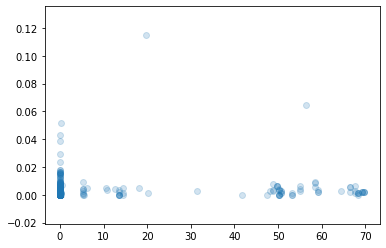

In [19]:
plt.scatter(missingDefault.missRate, missingDefault.impQ75Pond, alpha=0.2)

<BarContainer object of 202 artists>

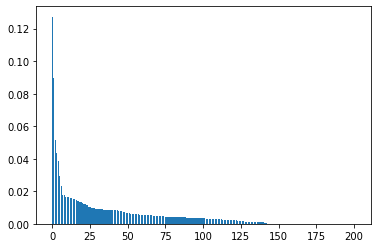

In [20]:
plt.bar([x for x in range(len(missingDefault))], missingDefault.impQ75.sort_values(ascending=False))

In [21]:
missingDefault = missingDefault.sort_values('impQ75Pond', ascending=False).reset_index(drop=True)
missingDefault

feature   missRate   impMean  impMedian  \
0                           EXT_SOURCE_3  19.828856  0.126054   0.125214   
1                           EXT_SOURCE_1  56.464598  0.088796   0.088785   
2                           EXT_SOURCE_2   0.213233  0.050563   0.050020   
3               BURO_AMT_CREDIT_SUM_DEBT   0.000000  0.040717   0.041236   
4          POSCASH_CNT_INSTALMENT_FUTURE   0.000000  0.037464   0.037543   
5                       BURO_DAYS_CREDIT   0.000000  0.027336   0.026679   
6                     PREV_DAYS_LAST_DUE   0.000000  0.020367   0.020134   
7                            AMT_ANNUITY   0.004646  0.015406   0.015431   
8           PREV_HOUR_APPR_PROCESS_START   0.000000  0.015628   0.015097   
9               BURO_DAYS_CREDIT_ENDDATE   0.000000  0.014191   0.015463   
10                 PREV_SELLERPLACE_AREA   0.000000  0.015239   0.015247   
11                  PREV_AMT_APPLICATION   0.000000  0.012812   0.012279   
12                       DAYS_ID_PUBLISH   0.000000  0.013348   0.012735   
13                         DAYS_EMPLOYED   0.000000  0.012640   0.012192   
14                       AMT_GOODS_PRICE   0.091519  0.012824   0.012716   
15                     DAYS_REGISTRATION   0.000000  0.012612   0.011310   
16                 PREV_AMT_DOWN_PAYMENT   0.000000  0.012557   0.012354   
17                   BURO_AMT_CREDIT_SUM   0.000000  0.010538   0.009997   
18     CREDCARD_CNT_DRAWINGS_ATM_CURRENT   0.000000  0.010779   0.008770   
19                POSCASH_MONTHS_BALANCE   0.000000  0.010608   0.011085   
20            REGION_POPULATION_RELATIVE   0.000000  0.011405   0.011217   
21                BURO_DAYS_ENDDATE_FACT   0.000000  0.011133   0.010874   
22                            DAYS_BIRTH   0.000000  0.008909   0.008437   
23               INSTALPAYMT_AMT_PAYMENT   0.000000  0.008854   0.008729   
24      CREDCARD_AMT_CREDIT_LIMIT_ACTUAL   0.000000  0.008888   0.008869   
25            INSTALPAYMT_AMT_INSTALMENT   0.000000  0.006988   0.007410   
26                 PREV_DAYS_TERMINATION   0.000000  0.006734   0.006328   
27                      BASEMENTAREA_AVG  58.466391  0.008740   0.009303   
28              PREV_PRODUCT_COMBINATION   5.333624  0.006991   0.006933   
29     INSTALPAYMT_NUM_INSTALMENT_NUMBER   0.000000  0.006491   0.006810   
30                            AMT_CREDIT   0.000000  0.006794   0.006474   
31               HOUR_APPR_PROCESS_START   0.000000  0.004318   0.002261   
32           BURO_AMT_CREDIT_MAX_OVERDUE   0.000000  0.007909   0.007259   
33                       FLAG_OWN_REALTY   0.000000  0.008485   0.008283   
34                     BASEMENTAREA_MEDI  58.466391  0.008512   0.009452   
35                       CNT_FAM_MEMBERS   0.000929  0.006929   0.006871   
36           PREV_NFLAG_LAST_APPL_IN_DAY   0.000000  0.007265   0.007719   
37          YEARS_BEGINEXPLUATATION_MODE  48.738020  0.008287   0.008113   
38        PREV_LAST_NAME_CONTRACT_STATUS   0.000000  0.007243   0.006918   
39                            FLAG_EMAIL   0.000000  0.007470   0.007183   
40                       NAME_TYPE_SUITE   0.419963  0.006898   0.007094   
41           REGION_RATING_CLIENT_W_CITY   0.000000  0.006967   0.006885   
42                POSCASH_CNT_INSTALMENT   0.000000  0.004146   0.002943   
43                      PREV_CNT_PAYMENT   0.000000  0.006089   0.005497   
44                         FLOORSMAX_AVG  49.705236  0.003236   0.000864   
45                        FLOORSMAX_MEDI  49.705236  0.003898   0.001295   
46                        FLOORSMAX_MODE  49.705236  0.004387   0.004387   
47                      BURO_AMT_ANNUITY   0.000000  0.004831   0.004480   
48                REG_CITY_NOT_WORK_CITY   0.000000  0.002405   0.000000   
49               LIVE_CITY_NOT_WORK_CITY   0.000000  0.001886   0.000000   
50                     NONLIVINGAREA_AVG  55.090427  0.008732   0.008459   
51     CREDCARD_AMT_DRAWINGS_ATM_CURRENT   0.000000  0.005799   0.005025   
52   

#### Suppression de colonnes peu importantes avec un fort taux de valeurs manquantes

In [22]:
def_miss_col_to_del = []
for index, row in missingDefault.iterrows():
    if (index >= 50) & (row.missRate >= 40):
        def_miss_col_to_del.append(row.feature)

In [23]:
for col in def_miss_col_to_del:
    del dfApplicationDefault[col]
    missingDefault = missingDefault[~missingDefault['feature'].isin([col])]
del dfApplicationDefault['PREV_NAME_CASH_LOAN_PURPOSE']
missingDefault = missingDefault.reset_index(drop=True)

### Sélection des meilleurs variables (la moitié)

In [24]:
dfApplicationDefaultSvg = dfApplicationDefault.copy()
dfApplicationWorkedSvg = dfApplicationWorked.copy()

In [25]:
#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [26]:
dfApplicationDefault = dfApplicationDefaultSvg.copy()
dfApplicationWorked = dfApplicationWorkedSvg.copy()

In [27]:
dfApplicationDefault = dfApplicationDefault.dropna()
dfApplicationWorked = dfApplicationWorked.dropna()
print(dfApplicationWorked.shape)
print(dfApplicationDefault.shape)

(49582, 62)
(18117, 161)


In [28]:
y_d = dfApplicationDefault['TARGET'].values
y_w = dfApplicationWorked['TARGET'].values
del dfApplicationDefault['TARGET']
del dfApplicationWorked['TARGET']
del dfApplicationDefault['SK_ID_CURR']
del dfApplicationWorked['SK_ID_CURR']

In [30]:
dfApplicationWorked = transformDf(dfApplicationWorked)
dfApplicationDefault = transformDf(dfApplicationDefault)

In [32]:
X_d = dfApplicationDefault.values
X_w = dfApplicationWorked.values

X_dcol = dfApplicationDefault.columns
X_wcol = dfApplicationWorked.columns

#### Calcul des feature importance

In [35]:
perm_imp_d = feat_perm_imp(X_d, y_d, X_dcol, RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1))
perm_imp_w = feat_perm_imp(X_w, y_w, X_wcol, RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1))

imp_d = feat_imp(X_d, y_d, X_dcol, RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1))
imp_w = feat_imp(X_w, y_w, X_wcol, RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1))

In [36]:
imp_d = imp_d.merge(perm_imp_d, left_on='feature', right_on='feature')
imp_w = imp_w.merge(perm_imp_w, left_on='feature', right_on='feature')
imp_d['diff_classement'] = imp_d.apply(lambda x: np.abs(x.classement - x.perm_classement), axis=1)
imp_w['diff_classement'] = imp_w.apply(lambda x: np.abs(x.classement - x.perm_classement), axis=1)
imp_d['best_classement'] = imp_d.apply(lambda x: np.min([x.classement, x.perm_classement]), axis=1)
imp_w['best_classement'] = imp_w.apply(lambda x: np.min([x.classement, x.perm_classement]), axis=1)

Sur le jeu Worked

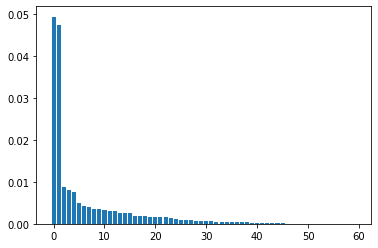

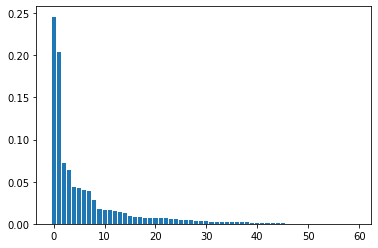

In [37]:
plt.bar([x for x in range(len(imp_w))], imp_w['perm_imp'].sort_values(ascending=False))
plt.show()
plt.bar([x for x in range(len(imp_w))], imp_w['impMedian'].sort_values(ascending=False))
plt.show()

In [38]:
for index, row in imp_w.iterrows():
    if row.best_classement > 30:
        del dfApplicationWorkedSvg[row.feature]

Sur le jeu par défaut

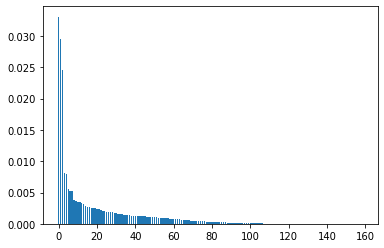

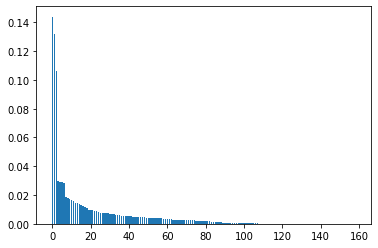

In [39]:
plt.bar([x for x in range(len(imp_d))], imp_d['perm_imp'].sort_values(ascending=False))
plt.show()
plt.bar([x for x in range(len(imp_d))], imp_d['impMedian'].sort_values(ascending=False))
plt.show()

In [40]:
for index, row in imp_d.iterrows():
    if row.best_classement > 80:
        del dfApplicationDefaultSvg[row.feature]

In [41]:
dfApplicationDefault = dfApplicationDefaultSvg.copy()
dfApplicationWorked = dfApplicationWorkedSvg.copy()

### Evaluation sur les deux jeux de données après purge des variables

In [43]:
from sklearn.datasets import make_classification
from sklearn.dummy import DummyClassifier
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

X_train = X[0:7000]
y_train = y[0:7000]
X_test = X[7001:9999]
y_test = y[7001:9999]    
model = DummyClassifier(strategy= 'stratified', constant=1)
#model = DecisionTreeClassifier()
#model = RandomForestClassifier()

model.fit(X_train, y_train)
yhat = model.predict_proba(X_test)
y_prob = yhat[:, 1]
fpr_dummy, tpr_dummy, thr_dummy = roc_curve(y_test, y_prob)
precision_dummy, recall_dummy, _ = precision_recall_curve(y_test, y_prob)

Counter({0: 9900, 1: 100})


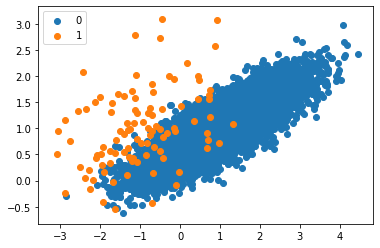

 Model ROC AUC: 0.945
 No Skill ROC AUC: 0.500
 Model PR AUC: 0.644
 No Skill PR AUC: 0.505


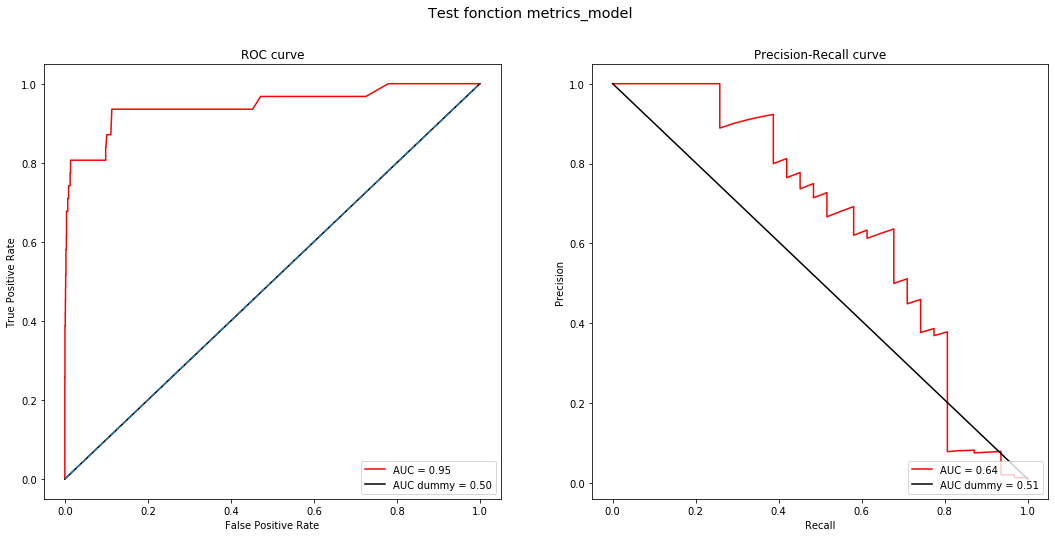

[0.36176156997680664,
 2.1530096530914307,
 0.4854486982450197,
 0.00928837833910004,
 1.053309440612793,
 0.9450134272698609,
 0.6444522697727633,
 '']

In [44]:
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where

X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# summarize class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

X_train = X[0:7000]
y_train = y[0:7000]
X_test = X[7001:9999]
y_test = y[7001:9999]

X_train, dfApplicationWorkedVal = train_test_split(X, test_size=0.3, random_state=1)
model = RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1)
#model = DecisionTreeClassifier(max_depth=5)
metrics_model(model, X_train, y_train, X_test, y_test, display_plot=True, calc_feat_imp = False, features = [], label_model = "Test fonction metrics_model")

 Model ROC AUC: 0.722
 No Skill ROC AUC: 0.500
 Model PR AUC: 0.210
 No Skill PR AUC: 0.540


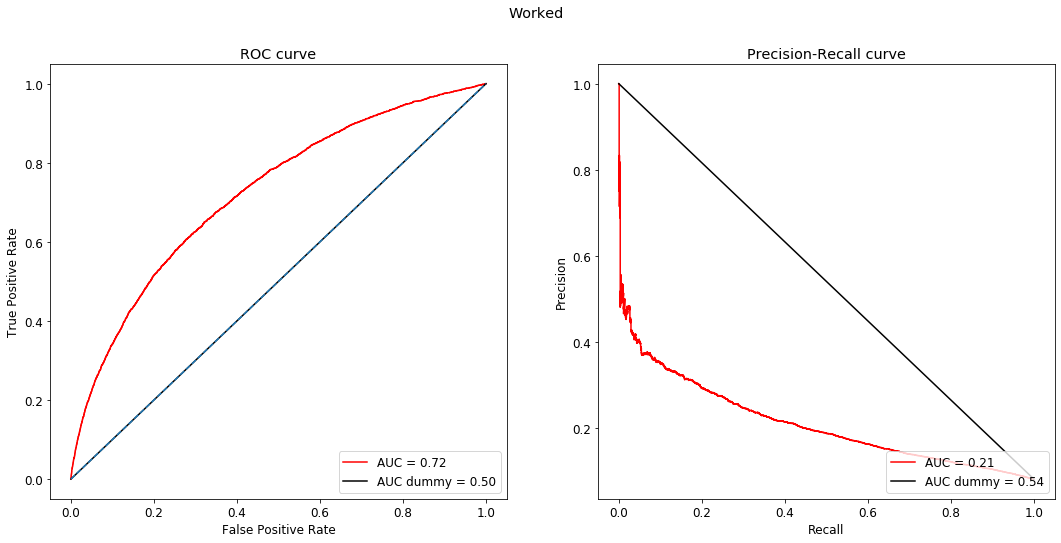

 Model ROC AUC: 0.732
 No Skill ROC AUC: 0.500
 Model PR AUC: 0.205
 No Skill PR AUC: 0.539


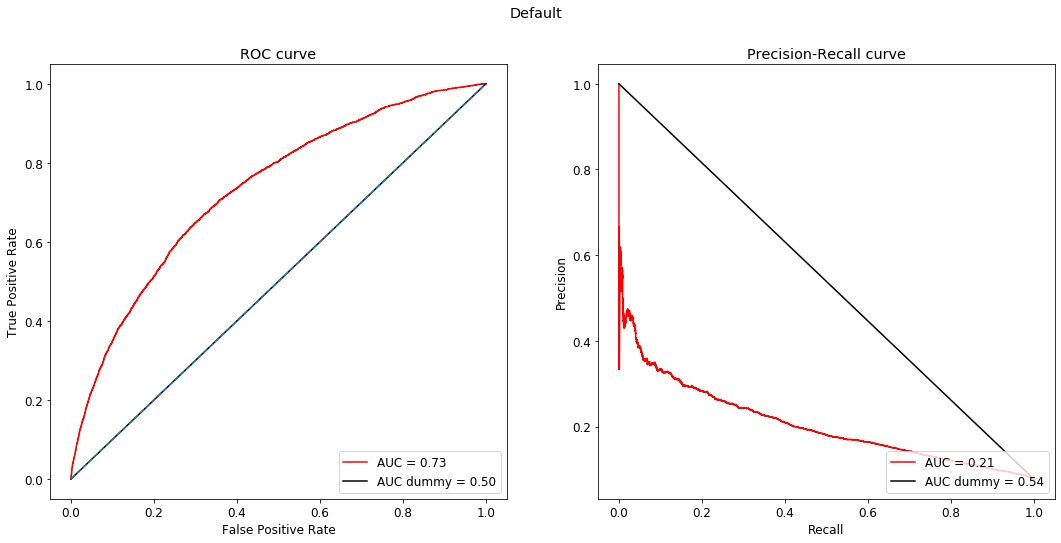

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from pickle import load

dicoDf = {'Worked':transformDf(dfApplicationWorked), 'Default': transformDf(dfApplicationDefault)}
for lbl, df in dicoDf.items():
    dfTrain, dfTest = train_test_split(df, test_size=0.2, random_state=1)
    y_train = dfTrain['TARGET'].values
    y_test = dfTest['TARGET'].values
    del dfTrain['TARGET']
    del dfTest['TARGET']
    del dfTrain['SK_ID_CURR']
    del dfTest['SK_ID_CURR']
    X_train = dfTrain.values
    X_test = dfTest.values

    model = RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1)
    duration_training, duration_pred_train, roc_auc_train, pr_auc_train, duration_pred_test, roc_auc_test, pr_auc_test, feature_imp = metrics_model(model, X_train, y_train, X_test, y_test, display_plot=True, calc_feat_imp = False, features = [], label_model = lbl)

### Merge des deux jeux de données

In [46]:
dfApplicationDefault = dfApplicationDefaultSvg.copy()
dfApplicationWorked = dfApplicationWorkedSvg.copy()

In [47]:
dfApplicationDefaultBeforeMerge = dfApplicationDefaultSvg.copy()
dfApplicationWorkedBeforeMerge = dfApplicationWorkedSvg.copy()

In [48]:
for index, row in imp_d.sort_values('best_classement').iterrows():
    if row.best_classement < 15:
        if row.feature not in dfApplicationWorked.columns:
            dfApplicationWorked = dfApplicationWorked.merge(dfApplicationDefault[['SK_ID_CURR',row.feature]], left_on='SK_ID_CURR', right_on='SK_ID_CURR')
            dfApplicationWorked = dfApplicationWorked.rename(columns={row.feature:'DEFAULT_'+row.feature})
dfApplicationWorkedSvg = dfApplicationWorked.copy()

### Métriques

 Model ROC AUC: 0.727
 No Skill ROC AUC: 0.500
 Model PR AUC: 0.212
 No Skill PR AUC: 0.540


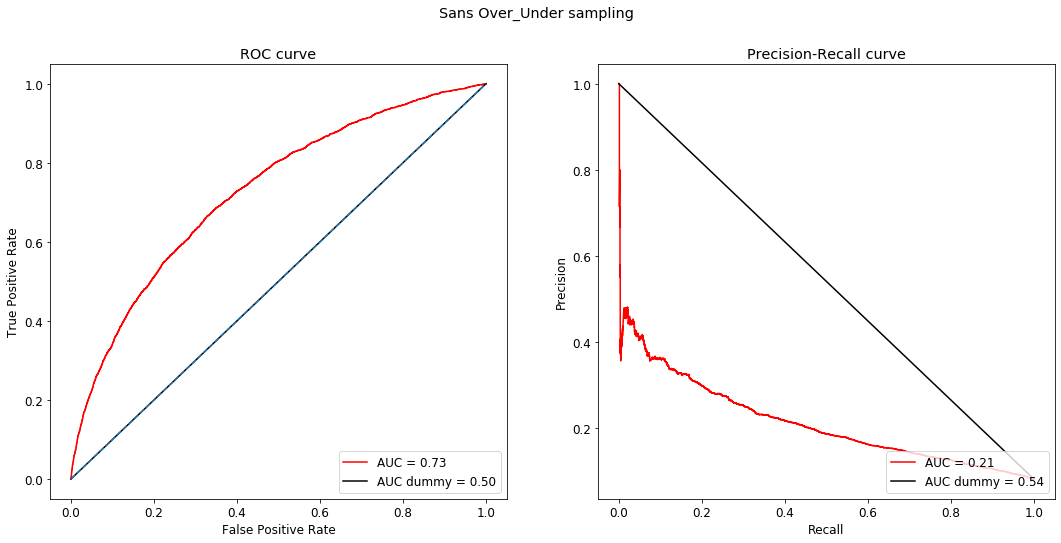

Counter({0: 158327, 1: 13878})
Counter({0: 158327, 1: 47498})
Counter({0: 94996, 1: 47498})
 Model ROC AUC: 0.727
 No Skill ROC AUC: 0.500
 Model PR AUC: 0.212
 No Skill PR AUC: 0.540


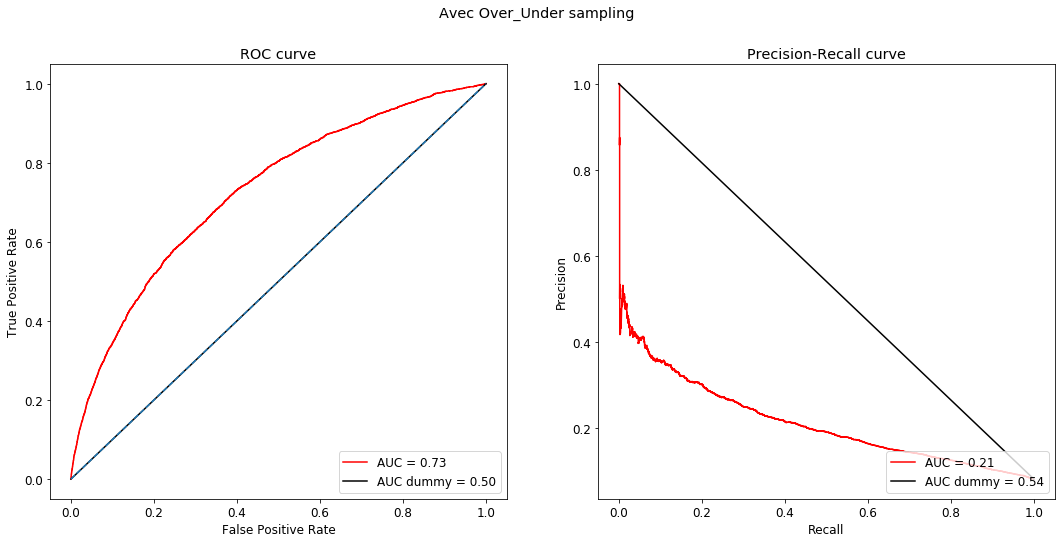

[8.889298915863037,
 18.335331439971924,
 0.7466567802998914,
 0.5939898770155858,
 4.757993936538696,
 0.7265749845182533,
 0.21221288127339488,
 '']

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from pickle import load

df = transformDf(dfApplicationWorked)

dfTrain, dfTest = train_test_split(df, test_size=0.2, random_state=1)
y_train = dfTrain['TARGET'].values
y_test = dfTest['TARGET'].values
del dfTrain['TARGET']
del dfTest['TARGET']
del dfTrain['SK_ID_CURR']
del dfTest['SK_ID_CURR']
X_train = dfTrain.values
X_test = dfTest.values
    
model = RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1)
metrics_model(model, X_train, y_train, X_test, y_test, display_plot=True, calc_feat_imp = False, features = [], label_model = 'Métriques après merge')

## Feature importance sur le jeu de données mergé et nouvelle sélection de variables

Counter({0: 197899, 1: 17358})
Counter({0: 197899, 1: 59369})
Counter({0: 118738, 1: 59369})


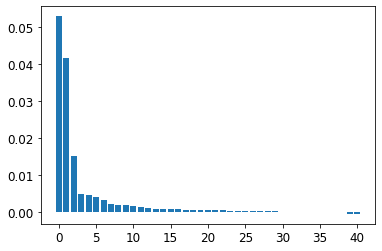

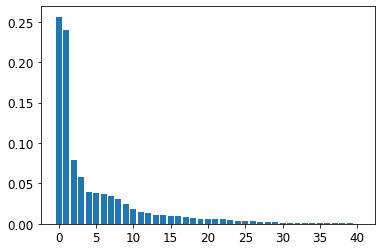

In [50]:
dfApplicationWorked = dfApplicationWorkedSvg.copy()
y = dfApplicationWorked['TARGET'].values
del dfApplicationWorked['TARGET']
del dfApplicationWorked['SK_ID_CURR']

dfApplicationWorked = transformDf(dfApplicationWorked)

X = dfApplicationWorked.values
X_col = dfApplicationWorked.columns
model = RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1)
perm_imp = feat_perm_imp(X, y, X_col, model)
imp = feat_imp(X, y, X_col, model)
imp = imp.merge(perm_imp, left_on='feature', right_on='feature')
imp['diff_classement'] = imp.apply(lambda x: np.abs(x.classement - x.perm_classement), axis=1)
imp['best_classement'] = imp.apply(lambda x: np.min([x.classement, x.perm_classement]), axis=1)
plt.bar([x for x in range(len(imp))], imp['perm_imp'].sort_values(ascending=False))
plt.show()
plt.bar([x for x in range(len(imp))], imp['impMedian'].sort_values(ascending=False))
plt.show()

In [51]:
imp.sort_values('best_classement', ascending=True)

classement                                        feature   impMean  \
0            1                                   EXT_SOURCE_2  0.253026   
1            2                                   EXT_SOURCE_3  0.245895   
2            3                           DEFAULT_EXT_SOURCE_1  0.078843   
3            4                               BURO_DAYS_CREDIT  0.057904   
4            5   INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS  0.039078   
6            7                                     DAYS_BIRTH  0.037176   
5            6  INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG  0.037925   
9           10                      PREV_NAME_CONTRACT_STATUS  0.024048   
7            8                                 PREV_DAYS_DIFF  0.034937   
14          15                                    CODE_GENDER  0.010917   
8            9                DEFAULT_BURO_DAYS_CREDIT_UPDATE  0.032121   
13          14                          PREV_NAME_YIELD_GROUP  0.010912   
10          11                       BURO_DAYS_CREDIT_ENDDATE  0.018359   
11          12                                  DAYS_EMPLOYED  0.015142   
21          22          DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE  0.005568   
17          18                        DEFAULT_AMT_GOODS_PRICE  0.008217   
12          13                 DEFAULT_BURO_DAYS_ENDDATE_FACT  0.013899   
22          23                  DEFAULT_PREV_AMT_DOWN_PAYMENT  0.005466   
23          24                       DEFAULT_PREV_CNT_PAYMENT  0.005257   
19          20                    BURO_AMT_CREDIT_MAX_OVERDUE  0.005741   
15          16                             BURO_CREDIT_ACTIVE  0.009962   
20          21               DEFAULT_PREV_PRODUCT_COMBINATION  0.005645   
16          17                              ORGANIZATION_TYPE  0.009616   
18          19                             PREV_DAYS_DECISION  0.007216   
26          27                                     AMT_CREDIT  0.003330   
24          25                    POSCASH_NB_POS_CASH_BALANCE  0.003670   
25          26                  DIFF_DAYS_INSTALLMENT_PAYMENT  0.003503   
28          29                    DEFAULT_PREV_NAME_PORTFOLIO  0.002299   
32          33                           RATIO_ANNUITY_INCOME  0.001199   
29          30           DEFAULT_PREV_HOUR_APPR_PROCESS_START  0.001754   
27          28                        POSCASH_SK_DPD_POS_CASH  0.002499   
31          32                             NAME_CONTRACT_TYPE  0.001277   
34          35                   YEARS_BEGINEXPLUATATION_MODE  0.001178   
30          31                            PREV_AMT_CREDIT_LOG  0.001326   
35          36                         PREV_RATE_DOWN_PAYMENT  0.001031   
33          34                        PREV_AMT_CREDIT_STD_LOG  0.001251   
37          38                      BURO_AMT_CREDIT_SUM_LIMIT  0.000766   
39          40                           AMT_INCOME_TOTAL_LOG  0.000524   
36          37  INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_POS  0.000805   
38          39                                APARTMENTS_MODE  0.000523   
40          41                      PREV_MAIN_SELLER_INDUSTRY  0.000194   

    impMedian    impQ75    impMax  perm_classement  perm_imp  diff_classement  \
0    0.256309  0.259993  0.272893                1  0.052884                0   
1    0.240077  0.248051  0.273554                2  0.041625                0   
2    0.078664  0.085450  0.088882                3  0.015030                0   
3    0.057362  0.061286  0.069407               24  0.000367               20   
4    0.038990  0.040971  0.042454                4  0.004927                1   
6    0.037461  0.038758  0.039647                5  0.004658                2   
5    0.037668  0.038966  0.042356                6  0.004201                0   
9    0.023981  0.024431  0.028433                7  0.003329                3   
7    0.034861  0.036618  0.041840                9  0.001895                1   
14   0.010565  0.011585  0.014084          

In [52]:
for index, row in imp.iterrows():
    if (row.perm_classement > 15) & (row.classement > 20):
        del dfApplicationWorkedSvg[row.feature]

In [59]:
if False:
    from pickle import dump
    dump(dfApplicationWorkedSvg, open('ApplicationWorked.pkl','wb'))

## Gestion des outliers

### Identification des outliers

In [16]:
from pickle import load
dfApplicationWorked = load(open('ApplicationWorked_with_outliers.pkl','rb'))
dfApplicationWorkedSvg = dfApplicationWorked.copy()

In [17]:
statOutlier = statsOutliers(dfApplicationWorked)
statOutlier = pd.DataFrame({'feature': pd.Series(list(statOutlier.keys())), 'nb_outliers': pd.Series(list(statOutlier.values()))}).sort_values('nb_outliers', ascending=False)


---------------------------------------------------------------------
BURO_AMT_CREDIT_MAX_OVERDUE:49316


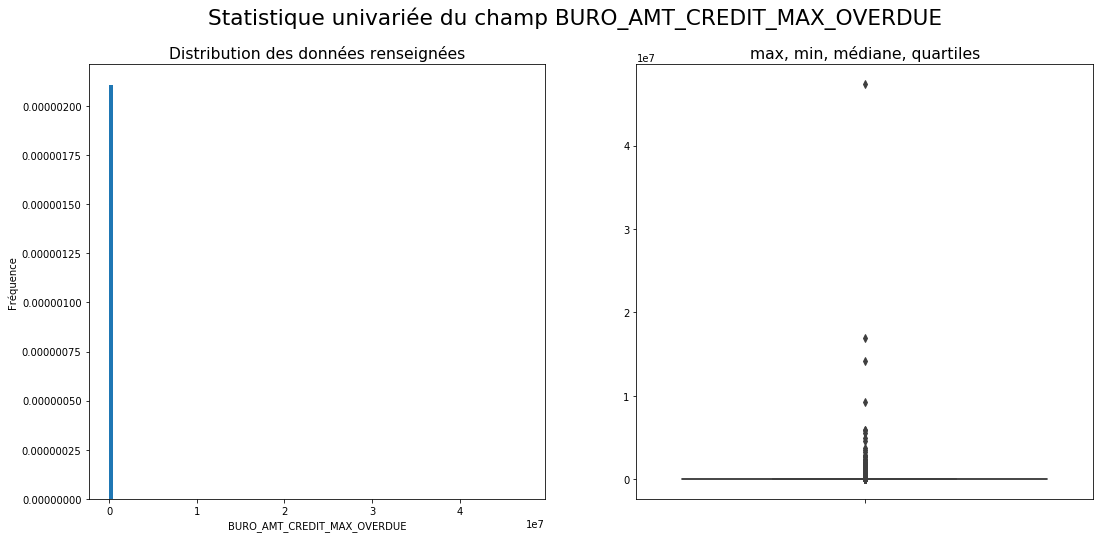

Mesures de position
 - Moyenne: 2759.67
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 120831.82
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 47406123.0
Mesures de forme
 - Skewness (asymétrie): 305.75
 - Kurtosis (applatissement): 112969.99


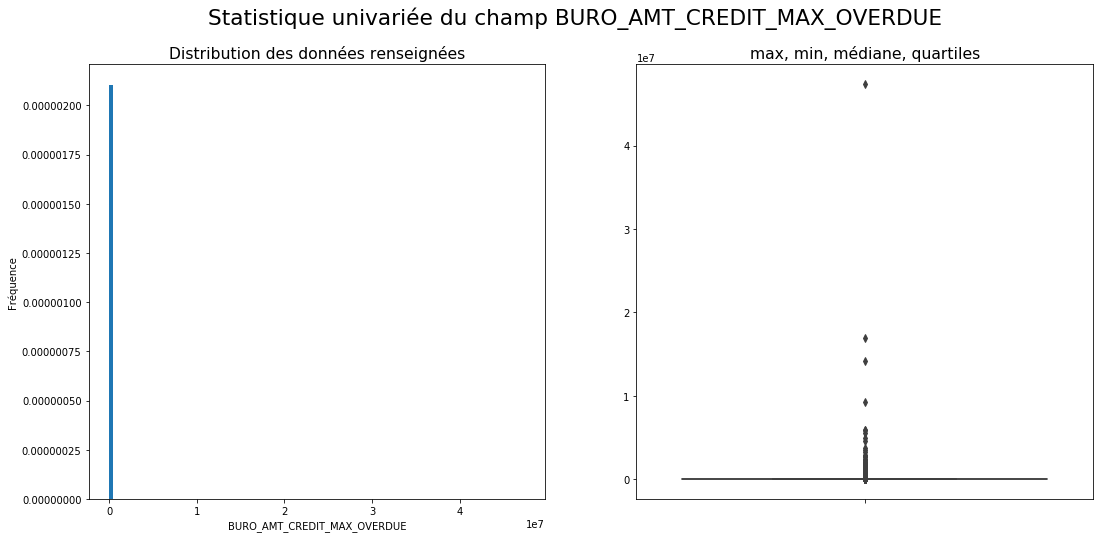

Mesures de position
 - Moyenne: 12045.57
 - Médiane: 3501.0
Mesures de dispertion
 - Ecart type: 252222.93
 - Min: 0.01
 - Q25: 1424.9
 - Q75: 7607.82
 - Max: 47406123.0
Mesures de forme
 - Skewness (asymétrie): 146.62
 - Kurtosis (applatissement): 25948.93

---------------------------------------------------------------------
BURO_CREDIT_ACTIVE:30923


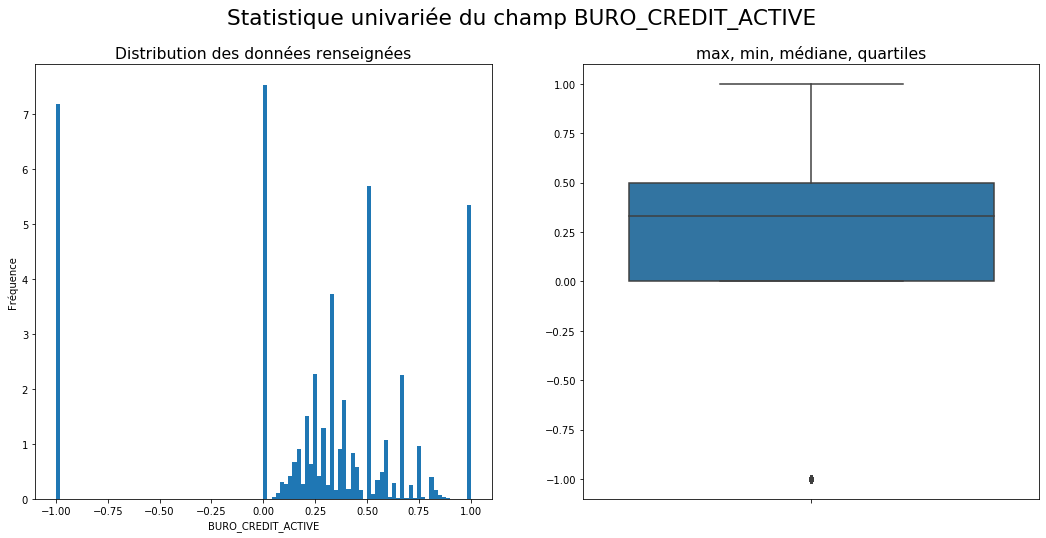

Mesures de position
 - Moyenne: 0.21
 - Médiane: 0.33
Mesures de dispertion
 - Ecart type: 0.57
 - Min: -1.0
 - Q25: 0.0
 - Q75: 0.5
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): -0.99
 - Kurtosis (applatissement): 0.34


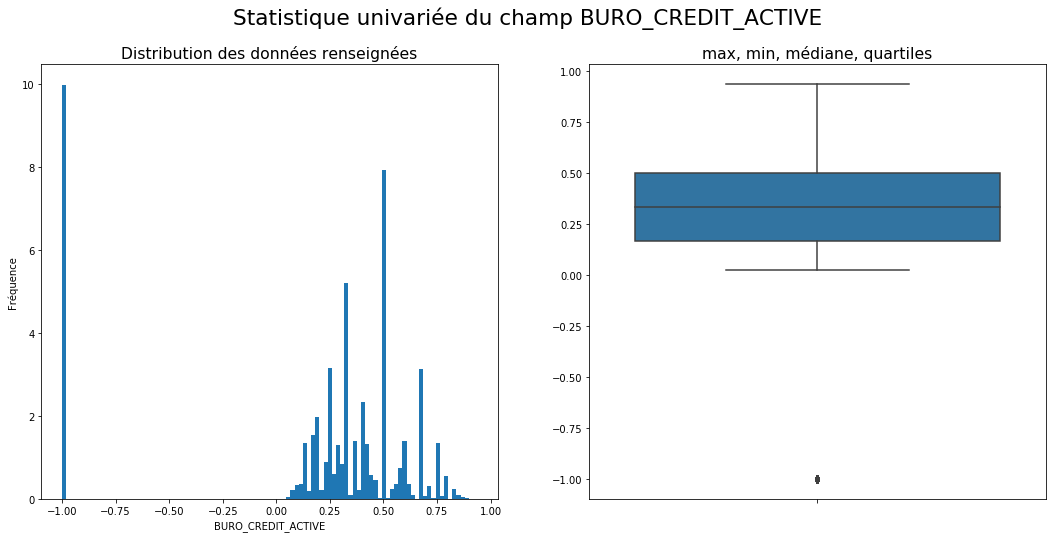

Mesures de position
 - Moyenne: 0.14
 - Médiane: 0.33
Mesures de dispertion
 - Ecart type: 0.58
 - Min: -1.0
 - Q25: 0.17
 - Q75: 0.5
 - Max: 0.94
Mesures de forme
 - Skewness (asymétrie): -1.27
 - Kurtosis (applatissement): 0.04

---------------------------------------------------------------------
INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG:28672


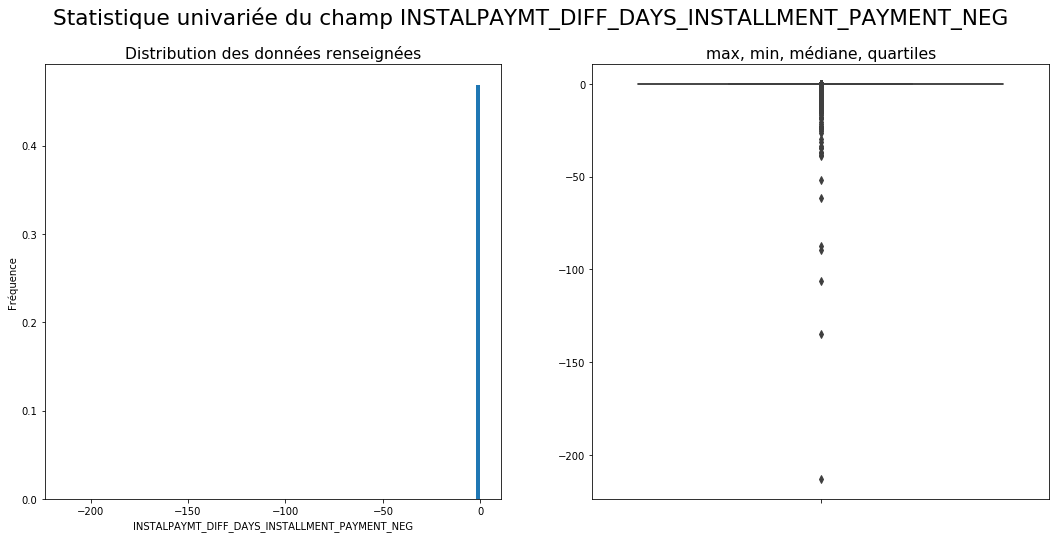

Mesures de position
 - Moyenne: -0.04
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.77
 - Min: -212.98
 - Q25: -0.02
 - Q75: 0.0
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -162.18
 - Kurtosis (applatissement): 36127.87


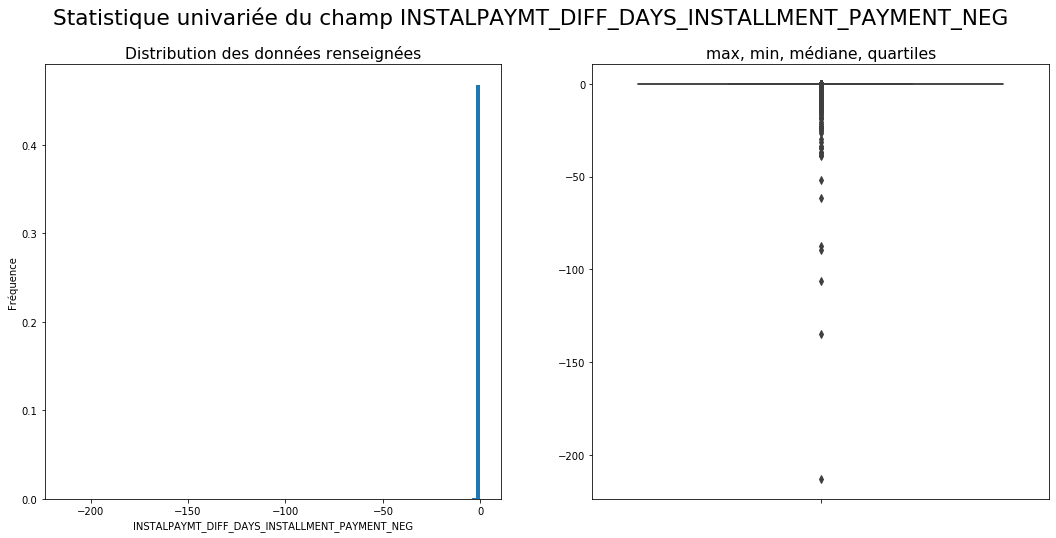

Mesures de position
 - Moyenne: -0.08
 - Médiane: -0.02
Mesures de dispertion
 - Ecart type: 1.09
 - Min: -212.98
 - Q25: -0.05
 - Q75: -0.01
 - Max: -0.0
Mesures de forme
 - Skewness (asymétrie): -113.68
 - Kurtosis (applatissement): 17718.95

---------------------------------------------------------------------
BURO_DAYS_CREDIT_ENDDATE:27161


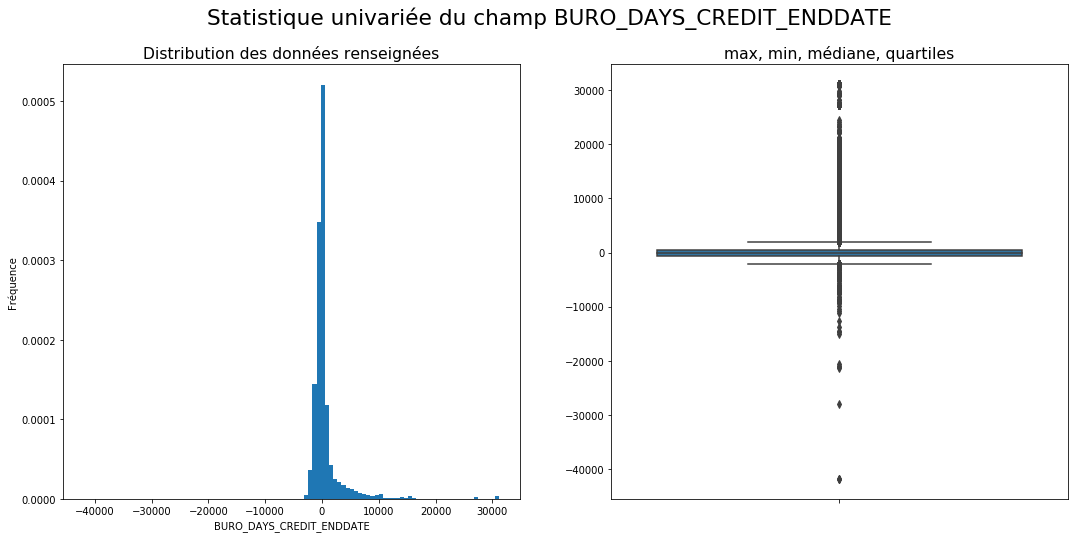

Mesures de position
 - Moyenne: 559.01
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 3051.48
 - Min: -41875.0
 - Q25: -593.17
 - Q75: 404.33
 - Max: 31198.0
Mesures de forme
 - Skewness (asymétrie): 5.35
 - Kurtosis (applatissement): 40.64


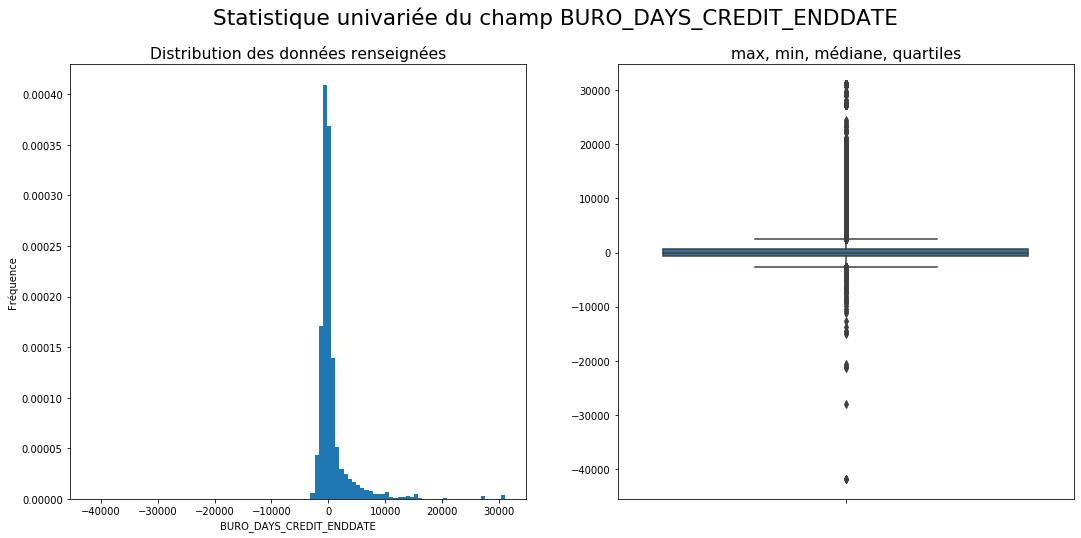

Mesures de position
 - Moyenne: 658.86
 - Médiane: -135.5
Mesures de dispertion
 - Ecart type: 3302.86
 - Min: -41875.0
 - Q25: -703.0
 - Q75: 602.5
 - Max: 31198.0
Mesures de forme
 - Skewness (asymétrie): 4.88
 - Kurtosis (applatissement): 33.87

---------------------------------------------------------------------
INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS:26101


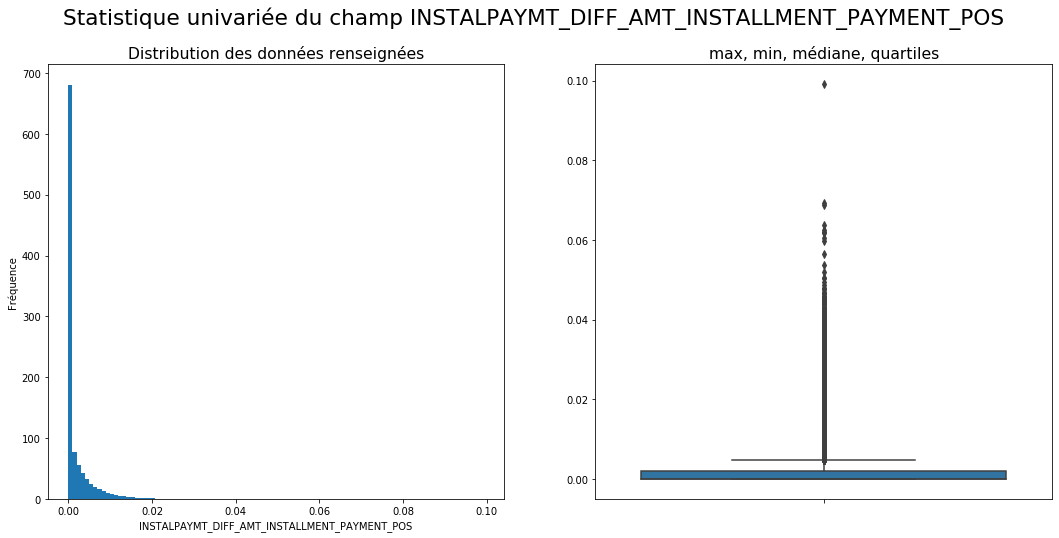

Mesures de position
 - Moyenne: 0.0
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.0
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 0.1
Mesures de forme
 - Skewness (asymétrie): 3.8
 - Kurtosis (applatissement): 25.25


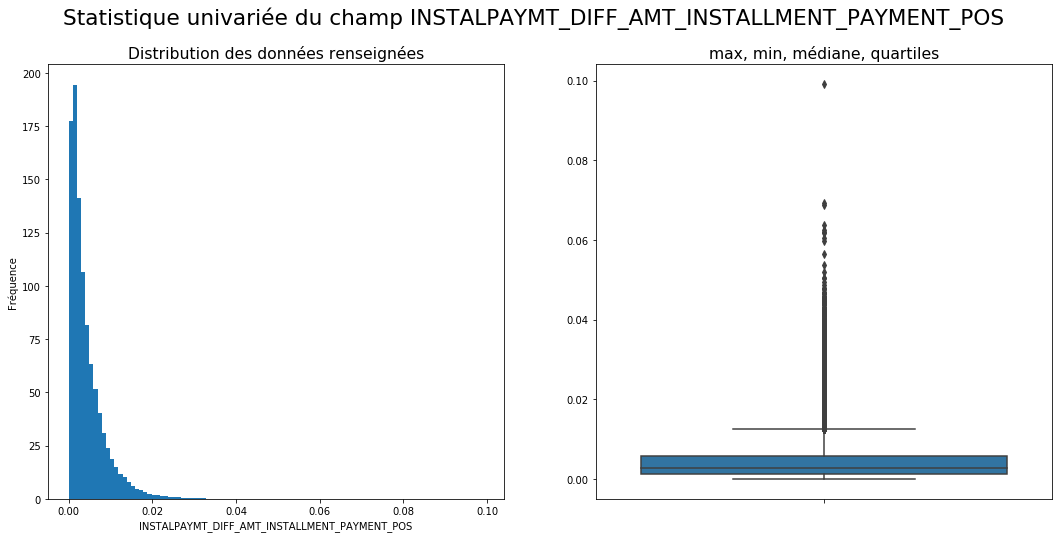

Mesures de position
 - Moyenne: 0.0
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.0
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.01
 - Max: 0.1
Mesures de forme
 - Skewness (asymétrie): 2.79
 - Kurtosis (applatissement): 15.46

---------------------------------------------------------------------
TARGET:17358


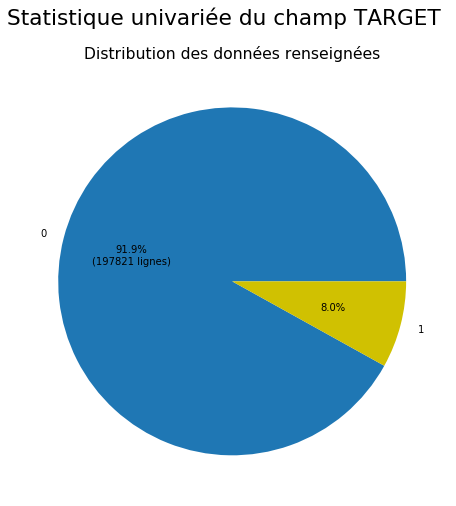


---------------------------------------------------------------------
DEFAULT_PREV_AMT_DOWN_PAYMENT:16070


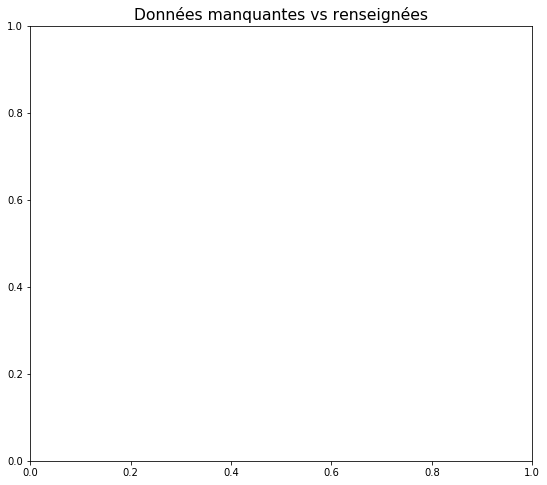

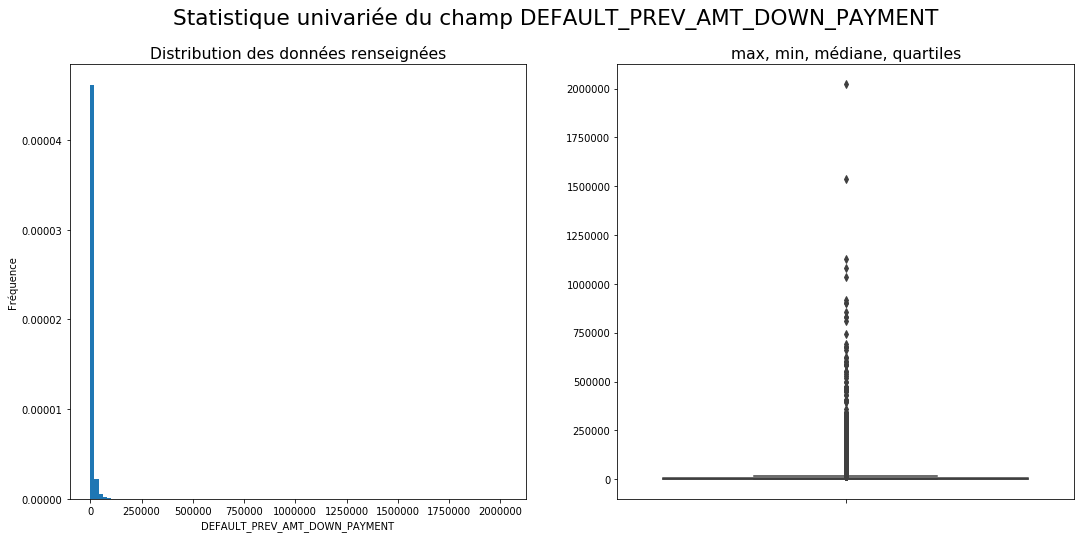

Mesures de position
 - Moyenne: 6306.11
 - Médiane: 2511.0
Mesures de dispertion
 - Ecart type: 17108.15
 - Min: -0.22
 - Q25: 0.0
 - Q75: 7318.12
 - Max: 2025000.0
Mesures de forme
 - Skewness (asymétrie): 28.18
 - Kurtosis (applatissement): 1858.39


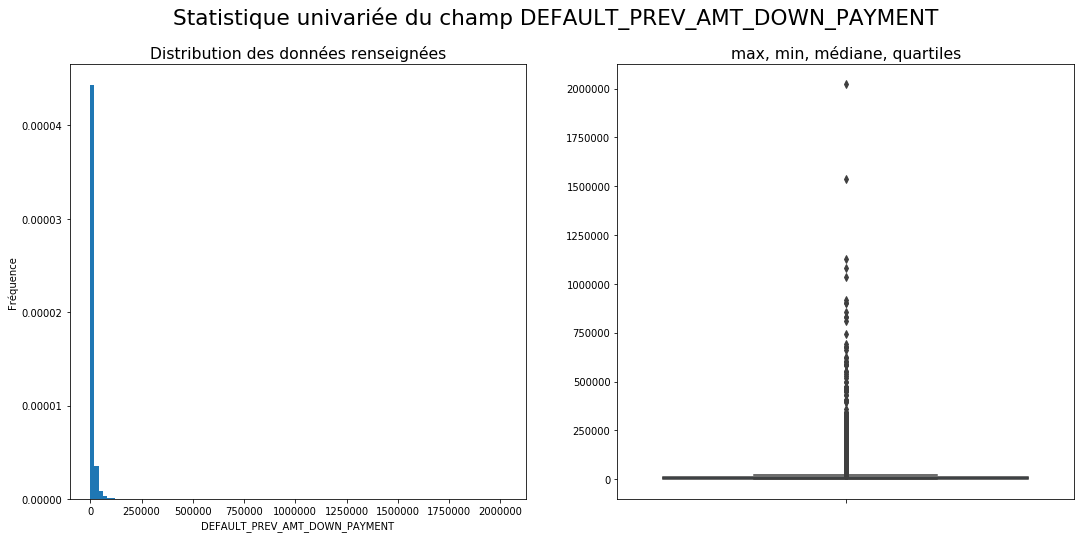

Mesures de position
 - Moyenne: 9856.98
 - Médiane: 5578.2
Mesures de dispertion
 - Ecart type: 20554.72
 - Min: -0.22
 - Q25: 2814.0
 - Q75: 10968.75
 - Max: 2025000.0
Mesures de forme
 - Skewness (asymétrie): 24.89
 - Kurtosis (applatissement): 1375.94

---------------------------------------------------------------------
DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE:12766


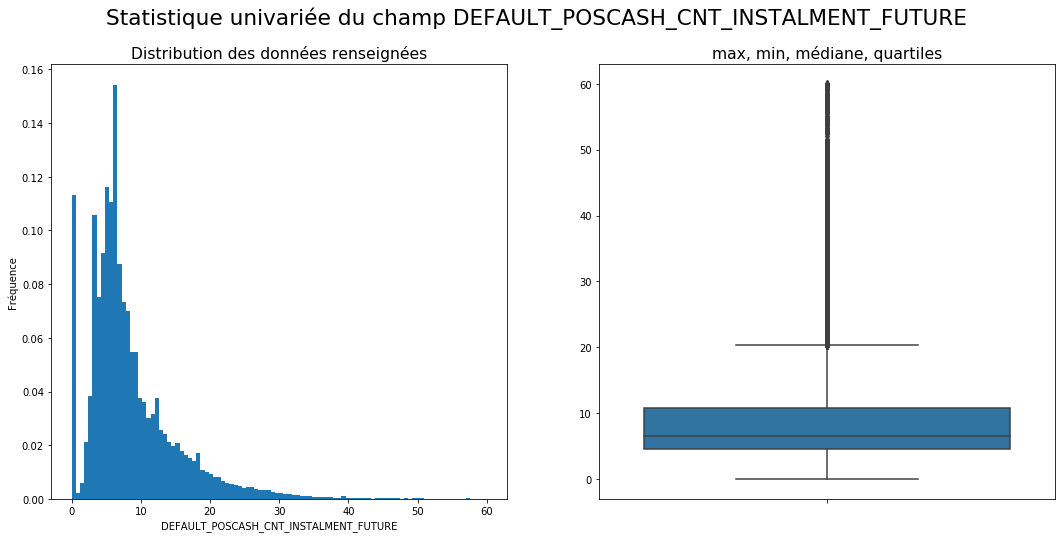

Mesures de position
 - Moyenne: 8.48
 - Médiane: 6.59
Mesures de dispertion
 - Ecart type: 6.56
 - Min: 0.0
 - Q25: 4.55
 - Q75: 10.85
 - Max: 60.0
Mesures de forme
 - Skewness (asymétrie): 1.88
 - Kurtosis (applatissement): 5.61


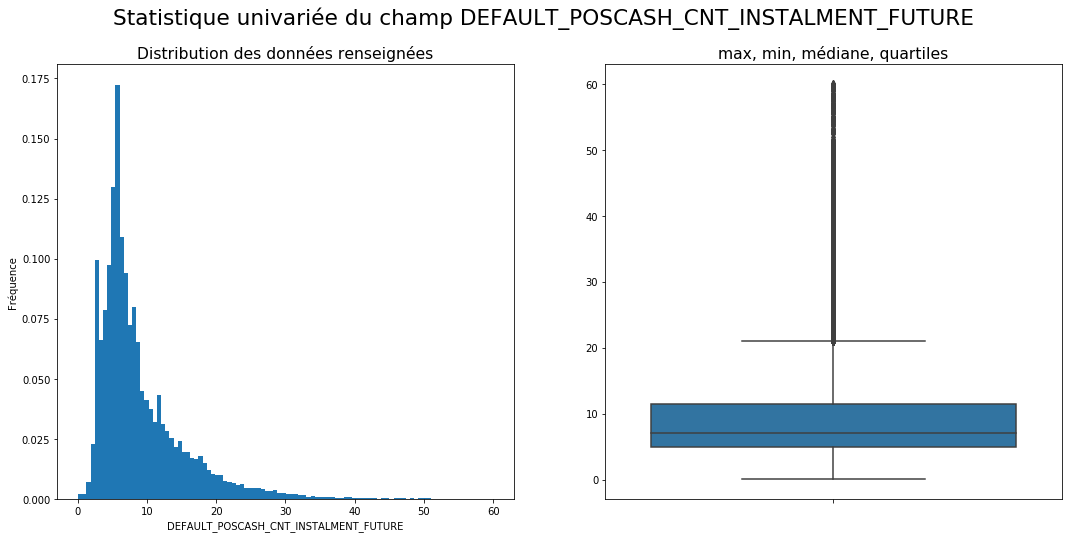

Mesures de position
 - Moyenne: 9.09
 - Médiane: 7.0
Mesures de dispertion
 - Ecart type: 6.37
 - Min: 0.08
 - Q25: 5.0
 - Q75: 11.4
 - Max: 60.0
Mesures de forme
 - Skewness (asymétrie): 2.08
 - Kurtosis (applatissement): 6.3

---------------------------------------------------------------------
PREV_NAME_CONTRACT_STATUS:12731


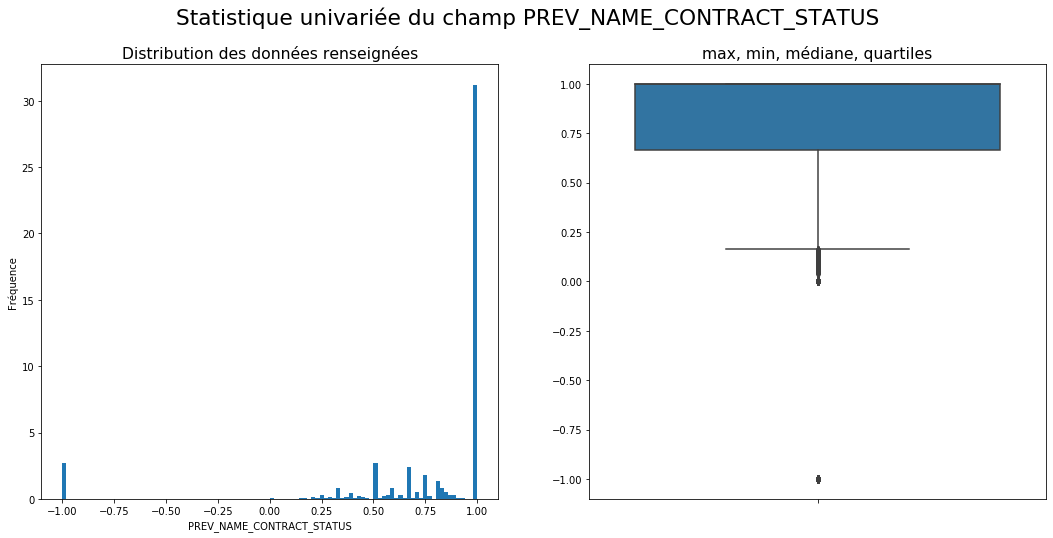

Mesures de position
 - Moyenne: 0.77
 - Médiane: 1.0
Mesures de dispertion
 - Ecart type: 0.47
 - Min: -1.0
 - Q25: 0.67
 - Q75: 1.0
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): -2.85
 - Kurtosis (applatissement): 7.78


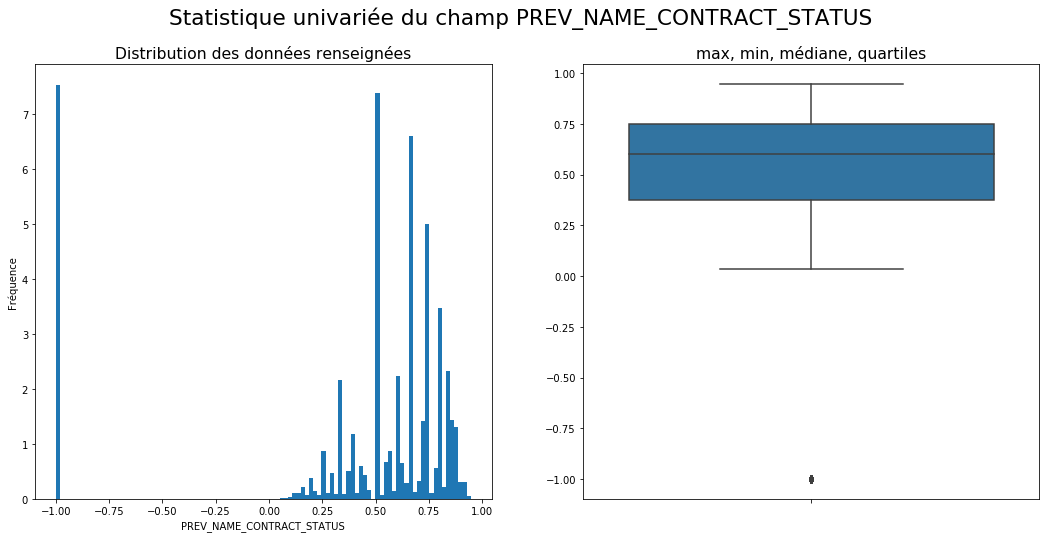

Mesures de position
 - Moyenne: 0.38
 - Médiane: 0.6
Mesures de dispertion
 - Ecart type: 0.6
 - Min: -1.0
 - Q25: 0.38
 - Q75: 0.75
 - Max: 0.95
Mesures de forme
 - Skewness (asymétrie): -1.69
 - Kurtosis (applatissement): 1.31

---------------------------------------------------------------------
DAYS_EMPLOYED:11790


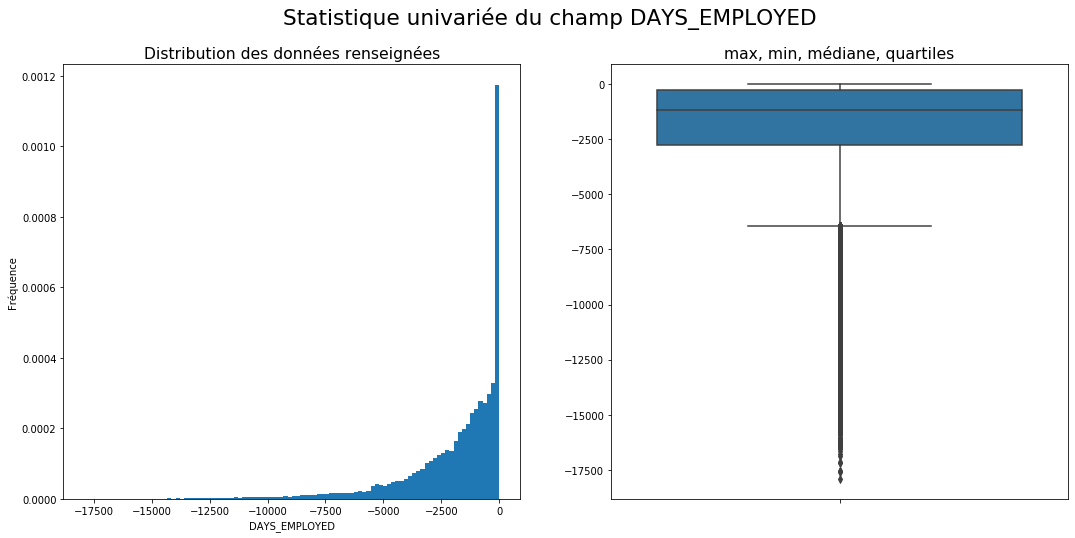

Mesures de position
 - Moyenne: -1950.48
 - Médiane: -1209.0
Mesures de dispertion
 - Ecart type: 2304.46
 - Min: -17912
 - Q25: -2754.0
 - Q75: -289.0
 - Max: 1
Mesures de forme
 - Skewness (asymétrie): -2.05
 - Kurtosis (applatissement): 5.24


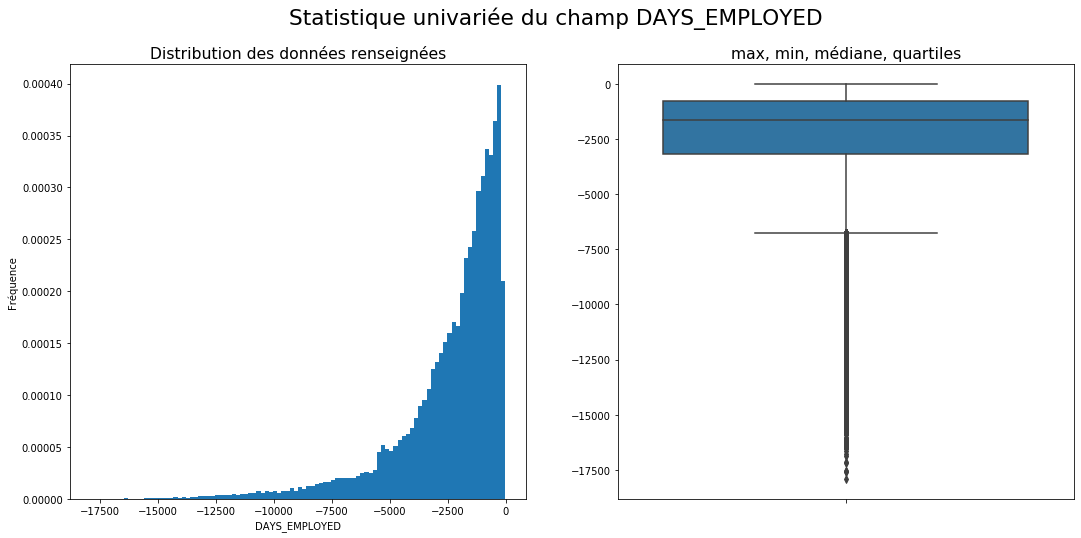

Mesures de position
 - Moyenne: -2379.72
 - Médiane: -1645.0
Mesures de dispertion
 - Ecart type: 2335.96
 - Min: -17912
 - Q25: -3167.0
 - Q75: -765.25
 - Max: -1
Mesures de forme
 - Skewness (asymétrie): -1.97
 - Kurtosis (applatissement): 4.77

---------------------------------------------------------------------
PREV_DAYS_DIFF:10551


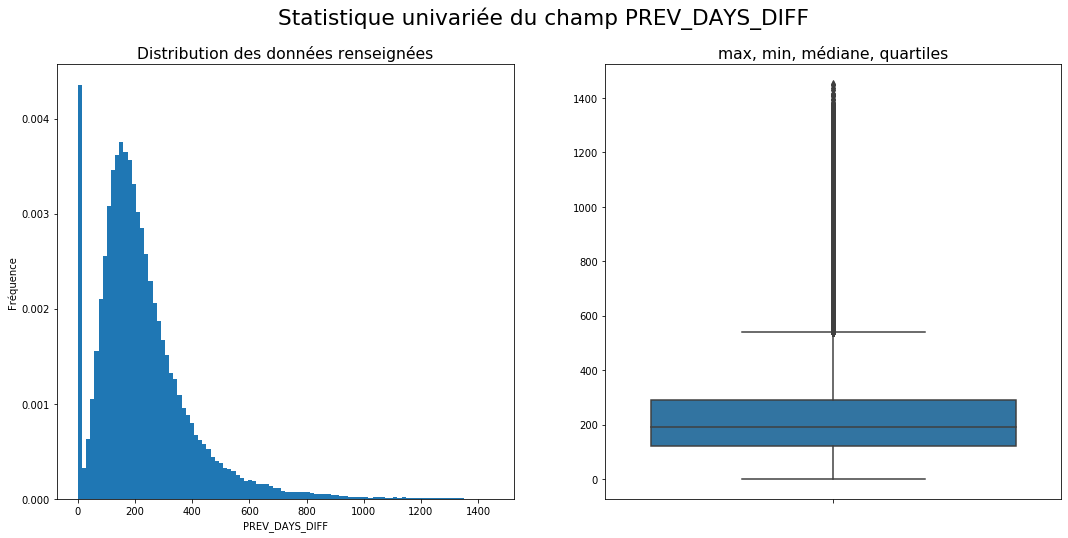

Mesures de position
 - Moyenne: 226.15
 - Médiane: 191.75
Mesures de dispertion
 - Ecart type: 166.34
 - Min: 0.0
 - Q25: 122.83
 - Q75: 290.33
 - Max: 1451.5
Mesures de forme
 - Skewness (asymétrie): 1.83
 - Kurtosis (applatissement): 5.78


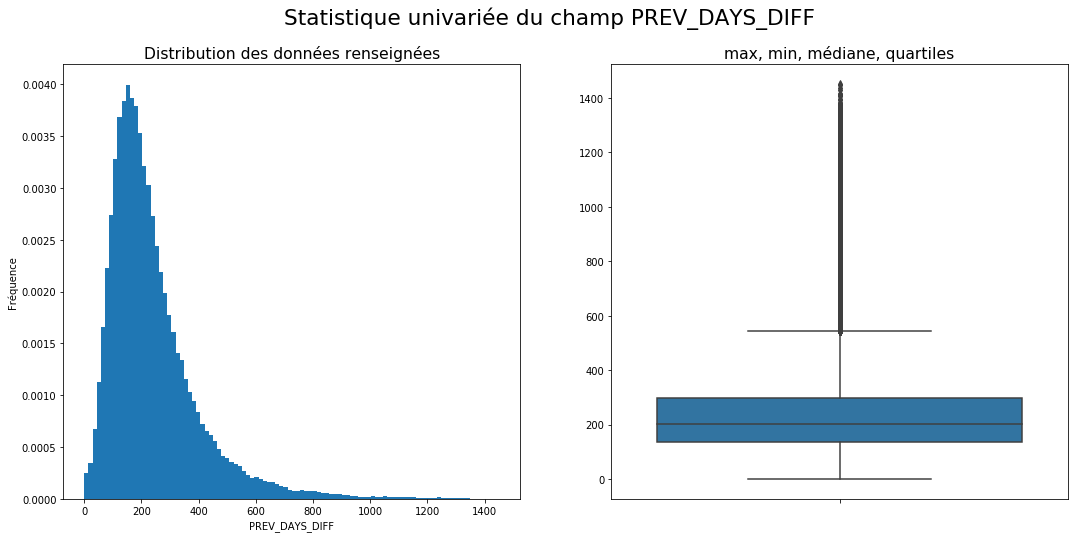

Mesures de position
 - Moyenne: 240.55
 - Médiane: 200.82
Mesures de dispertion
 - Ecart type: 161.15
 - Min: 0.17
 - Q25: 135.41
 - Q75: 299.17
 - Max: 1451.5
Mesures de forme
 - Skewness (asymétrie): 2.05
 - Kurtosis (applatissement): 6.57

---------------------------------------------------------------------
DEFAULT_AMT_GOODS_PRICE:10307


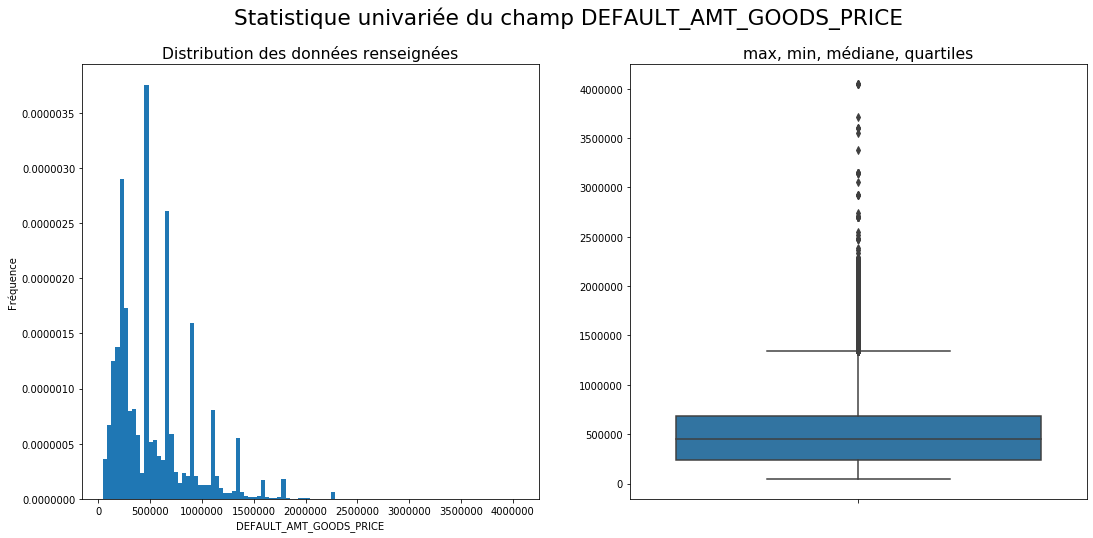

Mesures de position
 - Moyenne: 538187.97
 - Médiane: 450000.0
Mesures de dispertion
 - Ecart type: 369446.25
 - Min: 45000.0
 - Q25: 238500.0
 - Q75: 679500.0
 - Max: 4050000.0
Mesures de forme
 - Skewness (asymétrie): 1.35
 - Kurtosis (applatissement): 2.42


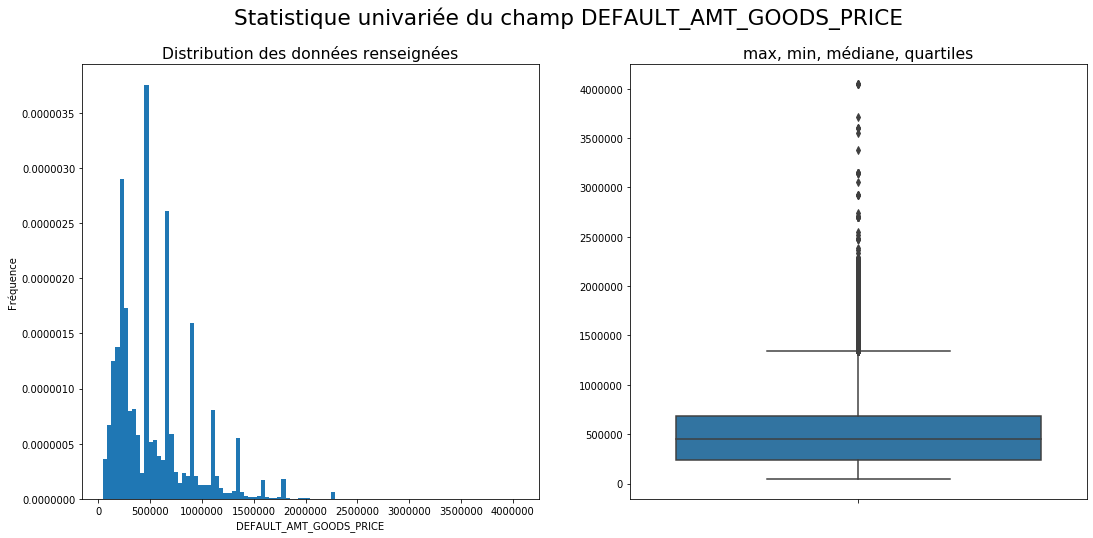

Mesures de position
 - Moyenne: 538187.97
 - Médiane: 450000.0
Mesures de dispertion
 - Ecart type: 369446.25
 - Min: 45000.0
 - Q25: 238500.0
 - Q75: 679500.0
 - Max: 4050000.0
Mesures de forme
 - Skewness (asymétrie): 1.35
 - Kurtosis (applatissement): 2.42

---------------------------------------------------------------------
DEFAULT_PREV_CNT_PAYMENT:8339


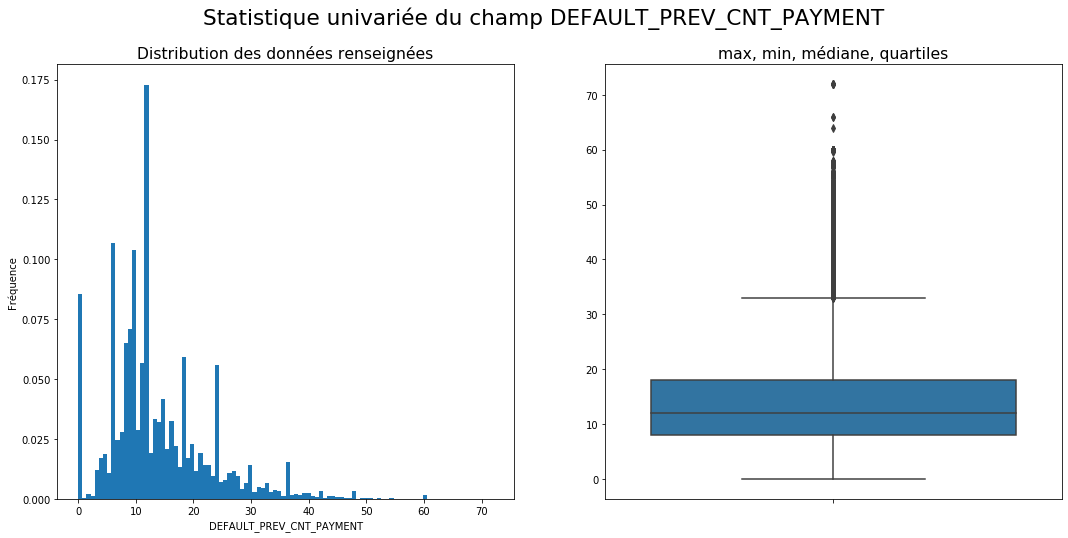

Mesures de position
 - Moyenne: 13.74
 - Médiane: 12.0
Mesures de dispertion
 - Ecart type: 8.84
 - Min: 0.0
 - Q25: 8.0
 - Q75: 18.0
 - Max: 72.0
Mesures de forme
 - Skewness (asymétrie): 1.2
 - Kurtosis (applatissement): 2.24


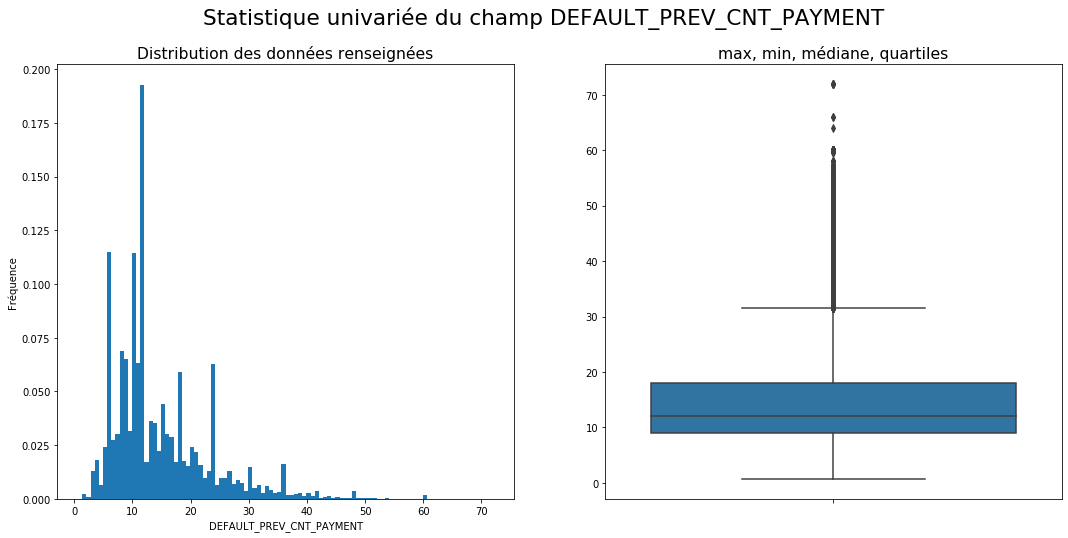

Mesures de position
 - Moyenne: 14.65
 - Médiane: 12.0
Mesures de dispertion
 - Ecart type: 8.37
 - Min: 0.67
 - Q25: 9.0
 - Q75: 18.0
 - Max: 72.0
Mesures de forme
 - Skewness (asymétrie): 1.47
 - Kurtosis (applatissement): 2.77

---------------------------------------------------------------------
DEFAULT_BURO_DAYS_CREDIT_UPDATE:3457


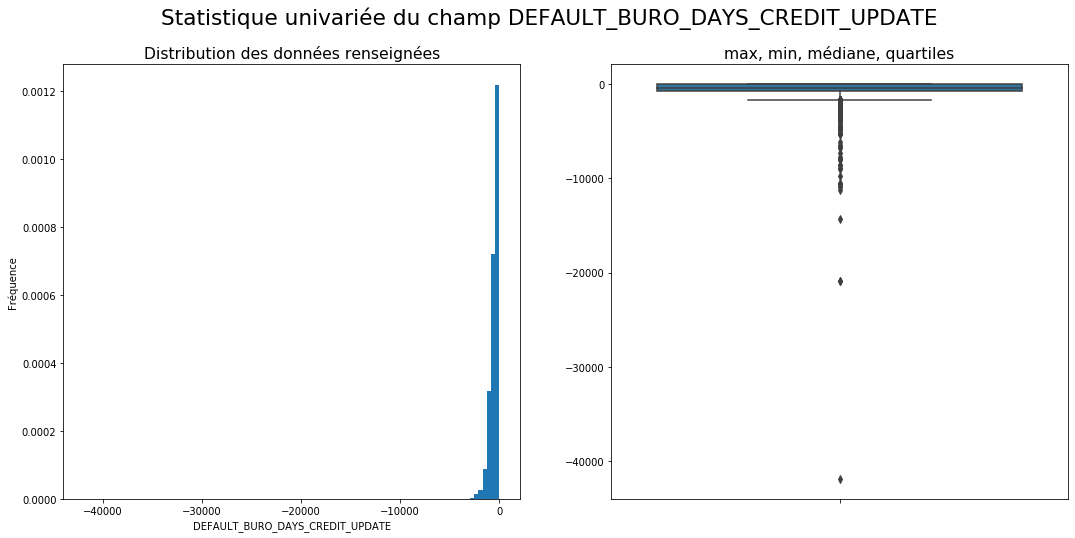

Mesures de position
 - Moyenne: -467.76
 - Médiane: -392.0
Mesures de dispertion
 - Ecart type: 465.53
 - Min: -41890.0
 - Q25: -720.12
 - Q75: -57.17
 - Max: 14.0
Mesures de forme
 - Skewness (asymétrie): -5.81
 - Kurtosis (applatissement): 341.35


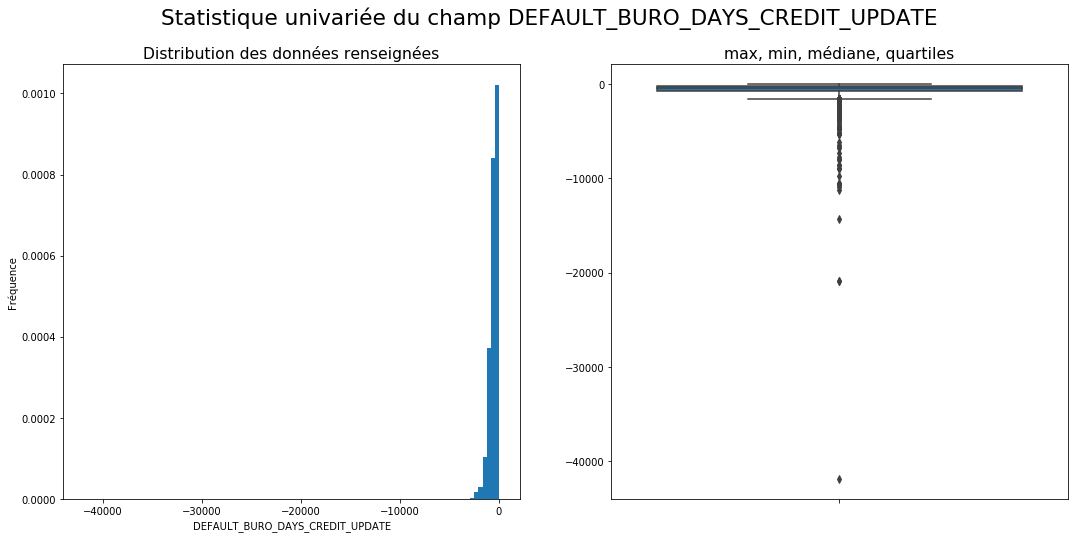

Mesures de position
 - Moyenne: -546.26
 - Médiane: -481.5
Mesures de dispertion
 - Ecart type: 458.48
 - Min: -41890.0
 - Q25: -778.15
 - Q75: -208.33
 - Max: 14.0
Mesures de forme
 - Skewness (asymétrie): -6.76
 - Kurtosis (applatissement): 419.45

---------------------------------------------------------------------
PREV_DAYS_DECISION:2668


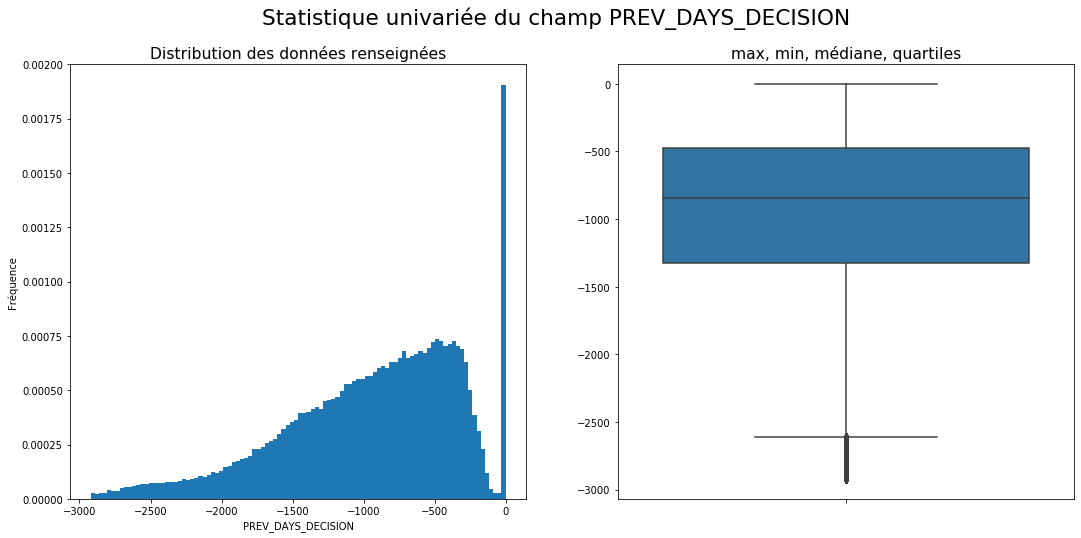

Mesures de position
 - Moyenne: -944.7
 - Médiane: -847.17
Mesures de dispertion
 - Ecart type: 615.29
 - Min: -2922.0
 - Q25: -1326.33
 - Q75: -472.0
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -0.71
 - Kurtosis (applatissement): 0.1


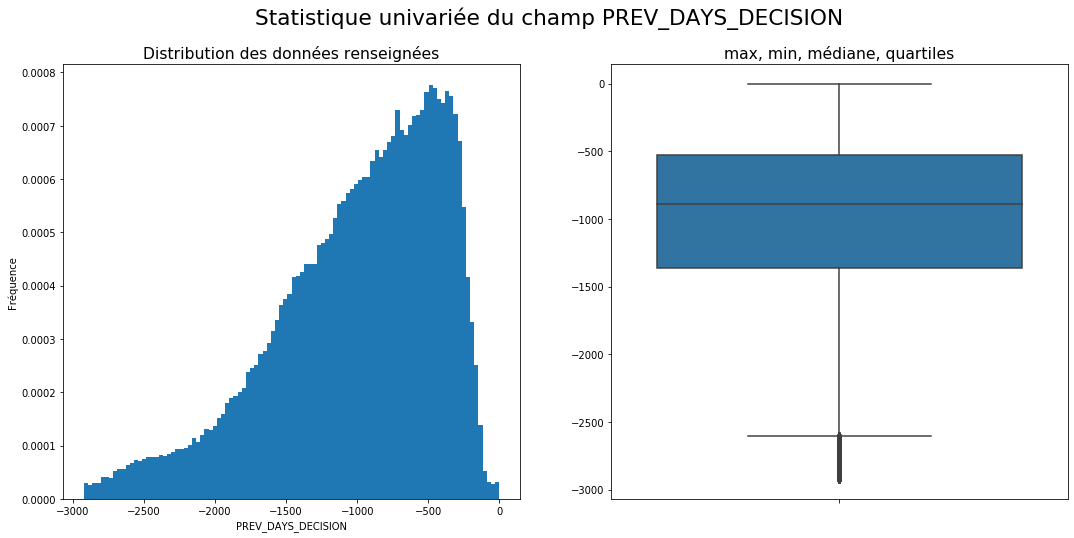

Mesures de position
 - Moyenne: -999.52
 - Médiane: -892.0
Mesures de dispertion
 - Ecart type: 588.01
 - Min: -2922.0
 - Q25: -1359.21
 - Q75: -528.33
 - Max: -2.0
Mesures de forme
 - Skewness (asymétrie): -0.82
 - Kurtosis (applatissement): 0.19

---------------------------------------------------------------------
BURO_DAYS_CREDIT:865


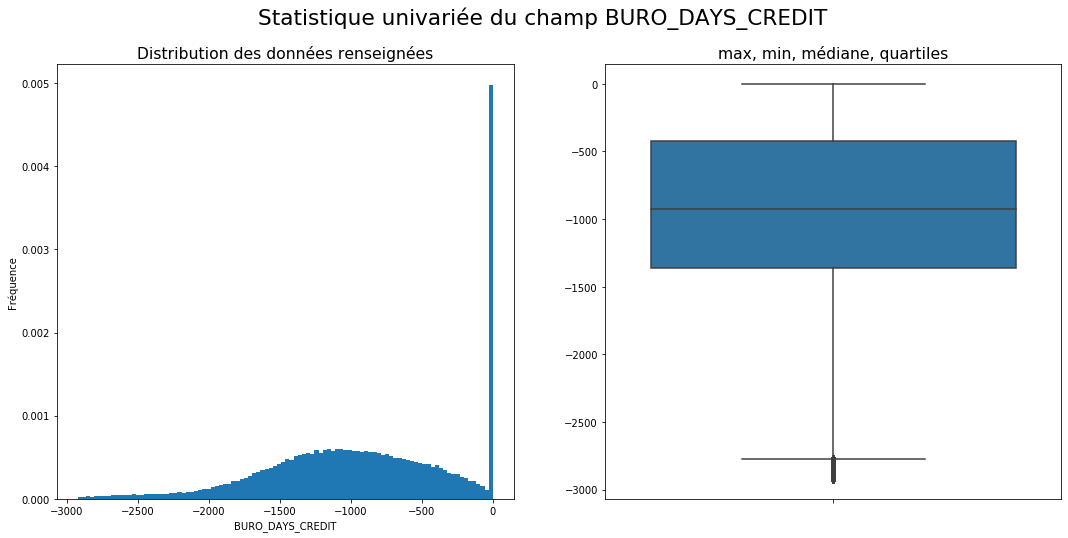

Mesures de position
 - Moyenne: -926.73
 - Médiane: -926.08
Mesures de dispertion
 - Ecart type: 644.67
 - Min: -2922.0
 - Q25: -1361.5
 - Q75: -422.0
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -0.35
 - Kurtosis (applatissement): -0.34


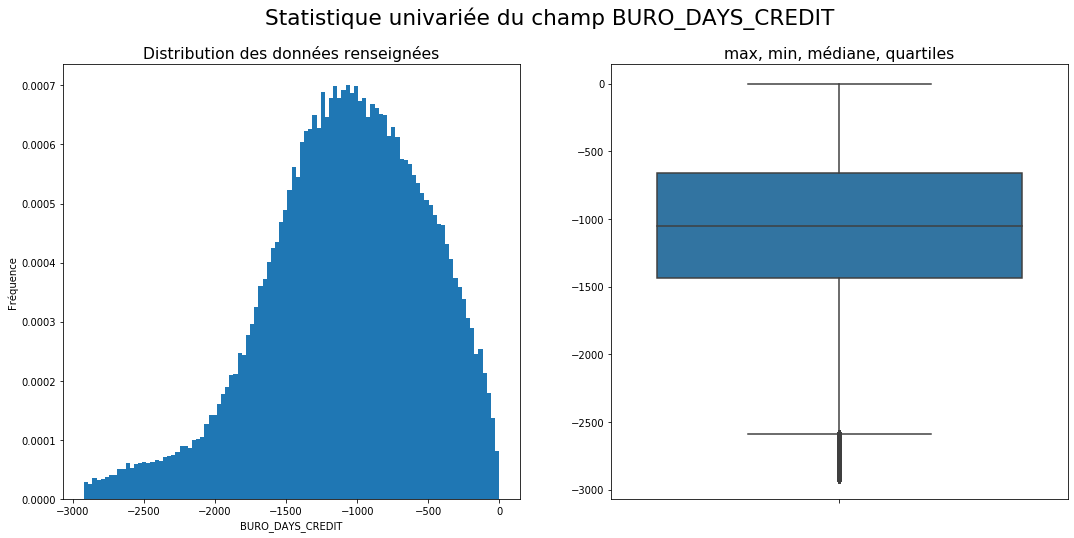

Mesures de position
 - Moyenne: -1082.2
 - Médiane: -1049.5
Mesures de dispertion
 - Ecart type: 563.1
 - Min: -2922.0
 - Q25: -1433.17
 - Q75: -663.0
 - Max: -2.0
Mesures de forme
 - Skewness (asymétrie): -0.5
 - Kurtosis (applatissement): 0.09


In [94]:
for index, row in statOutlier.iterrows():
    print('')
    print('---------------------------------------------------------------------')
    print('{}:{}'.format(row.feature,row.nb_outliers))
    myDf(dfApplicationWorked).Stat(row.feature)
    try:
        myDf(dfApplicationWorked[~dfApplicationWorked[row.feature].isin([0,1])]).Stat(row.feature)
    except:
        pass

<BarContainer object of 16 artists>

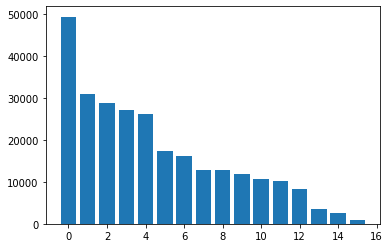

In [95]:
plt.bar([x for x in range(len(statOutlier))], statOutlier.nb_outliers.sort_values(ascending=False))

### Fonction d'analyse de la ditribution de la classe positive parmis les outliers

### Gestion des outliers champ par champ

In [107]:
from pickle import load
dfApplicationWorked = load(open('ApplicationWorked_with_outliers.pkl','rb'))
dfApplicationWorkedSvg = dfApplicationWorked.copy()

#### BURO_AMT_CREDIT_MAX_OVERDUE ** VU **

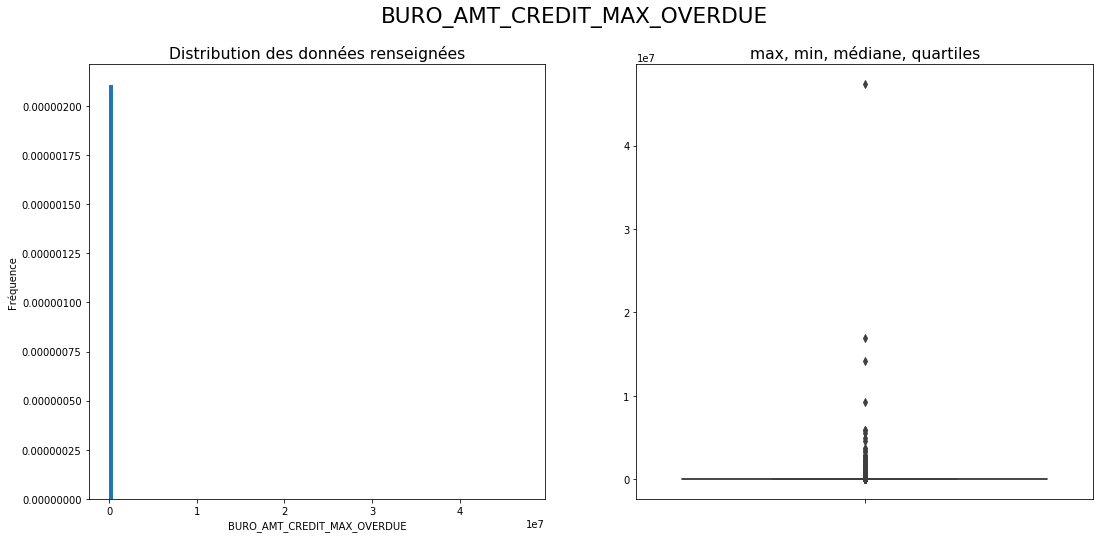

Mesures de position
 - Moyenne: 2759.67
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 120831.82
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 47406123.0
Mesures de forme
 - Skewness (asymétrie): 305.75
 - Kurtosis (applatissement): 112969.99


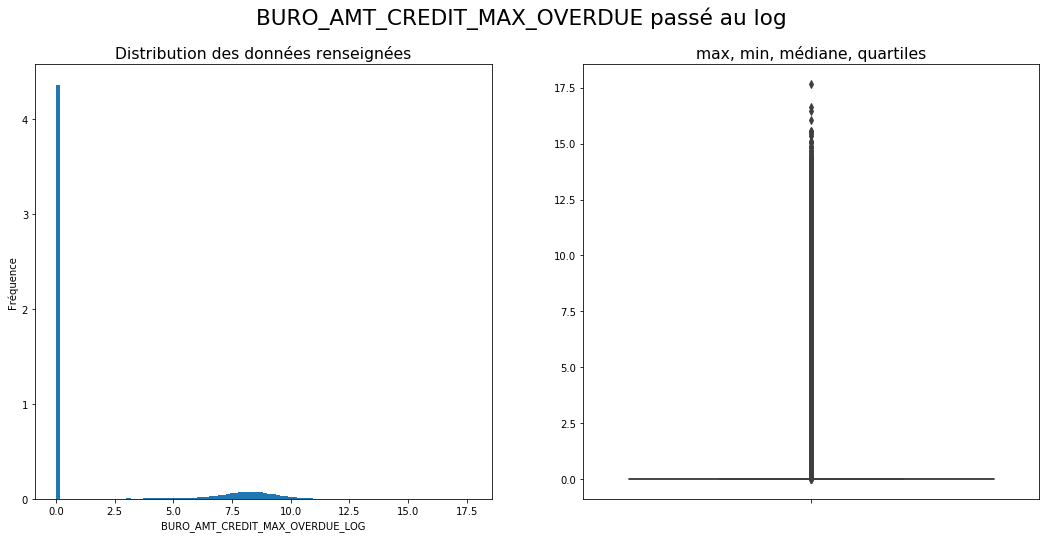

Mesures de position
 - Moyenne: 1.82
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 3.43
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 17.67
Mesures de forme
 - Skewness (asymétrie): 1.46
 - Kurtosis (applatissement): 0.32


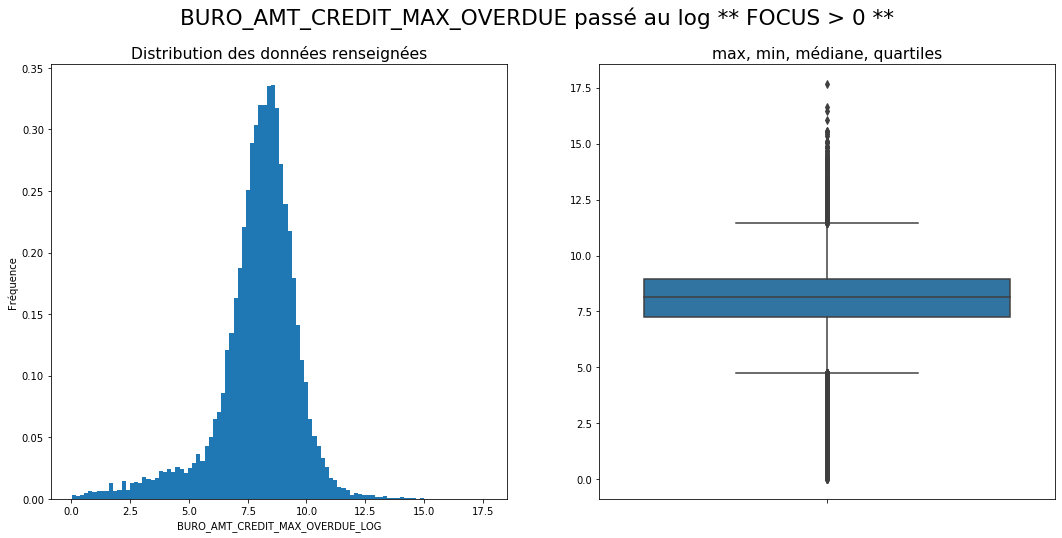

Mesures de position
 - Moyenne: 7.92
 - Médiane: 8.16
Mesures de dispertion
 - Ecart type: 1.73
 - Min: 0.01
 - Q25: 7.26
 - Q75: 8.94
 - Max: 17.67
Mesures de forme
 - Skewness (asymétrie): -1.17
 - Kurtosis (applatissement): 3.13


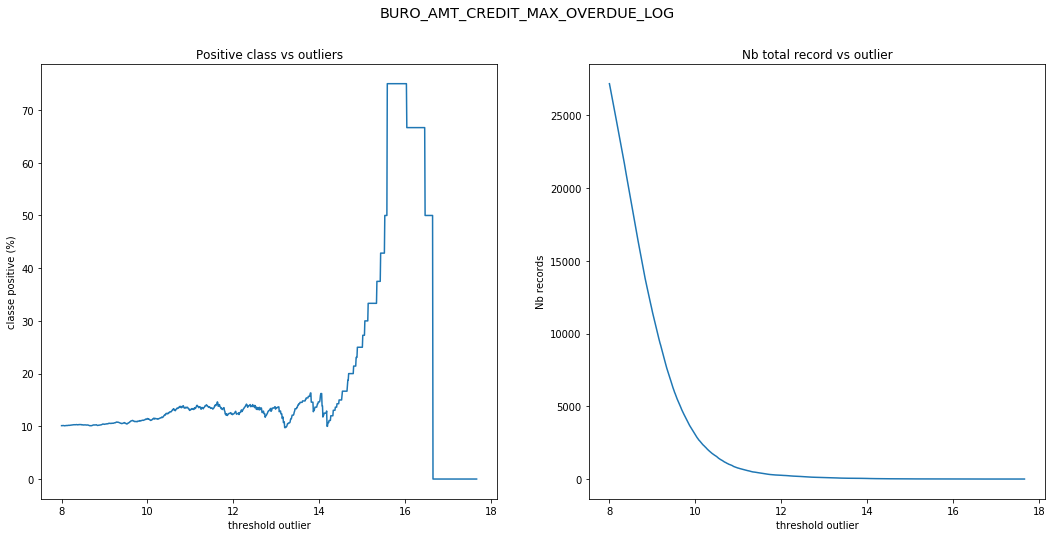

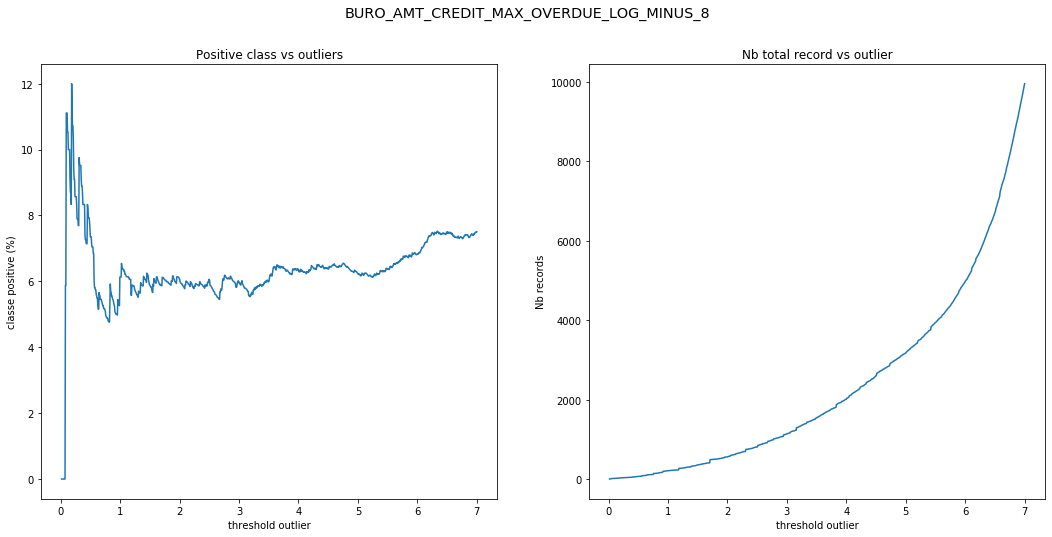

In [10]:
try:
    myDf(dfApplicationWorked).Stat('BURO_AMT_CREDIT_MAX_OVERDUE', pltTitle = 'BURO_AMT_CREDIT_MAX_OVERDUE')
    dfApplicationWorked['BURO_AMT_CREDIT_MAX_OVERDUE_LOG'] = dfApplicationWorked.apply(lambda x: np.log(x.BURO_AMT_CREDIT_MAX_OVERDUE + 1), axis=1)
    myDf(dfApplicationWorked).Stat('BURO_AMT_CREDIT_MAX_OVERDUE_LOG', pltTitle = 'BURO_AMT_CREDIT_MAX_OVERDUE passé au log')
    myDf(dfApplicationWorked[dfApplicationWorked.BURO_AMT_CREDIT_MAX_OVERDUE_LOG != 0]).Stat('BURO_AMT_CREDIT_MAX_OVERDUE_LOG', pltTitle = 'BURO_AMT_CREDIT_MAX_OVERDUE passé au log ** FOCUS > 0 **')

    statImbalancedOutlier(dfApplicationWorked, 'BURO_AMT_CREDIT_MAX_OVERDUE_LOG', limit_outlier=8, nb_points=1000)
    tmp = dfApplicationWorked[dfApplicationWorked.BURO_AMT_CREDIT_MAX_OVERDUE_LOG>0].copy()
    tmp['BURO_AMT_CREDIT_MAX_OVERDUE_LOG_MINUS_8'] = tmp.apply(lambda x: x.BURO_AMT_CREDIT_MAX_OVERDUE_LOG-8, axis=1)
    statImbalancedOutlier(tmp, 'BURO_AMT_CREDIT_MAX_OVERDUE_LOG_MINUS_8', limit_outlier=-1, nb_points=1000, to_add_to_threshold=8.0)

except:
    pass

#### INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG ** VU **

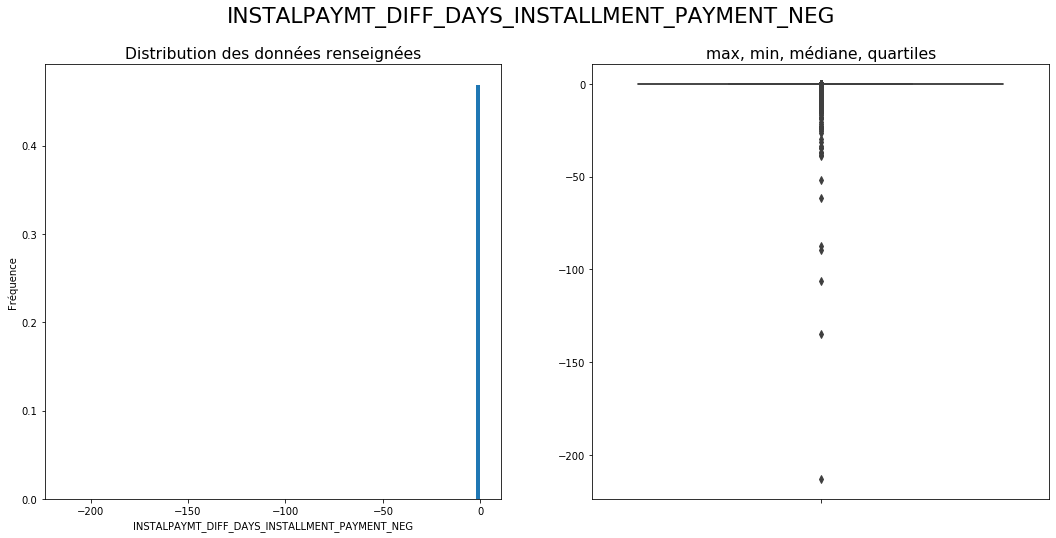

Mesures de position
 - Moyenne: -0.04
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.77
 - Min: -212.98
 - Q25: -0.02
 - Q75: 0.0
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -162.18
 - Kurtosis (applatissement): 36127.87


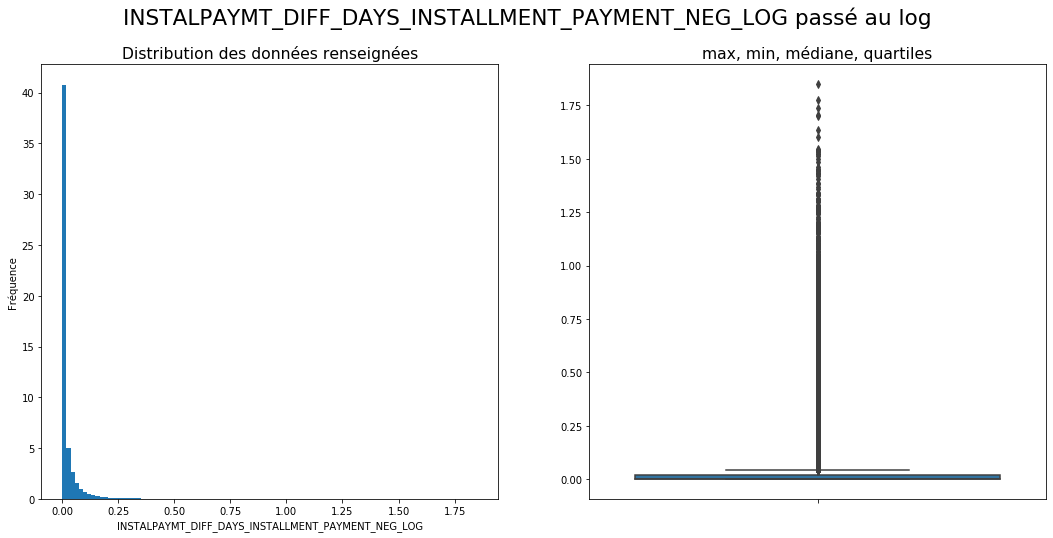

Mesures de position
 - Moyenne: 0.02
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.07
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.02
 - Max: 1.85
Mesures de forme
 - Skewness (asymétrie): 8.78
 - Kurtosis (applatissement): 115.22


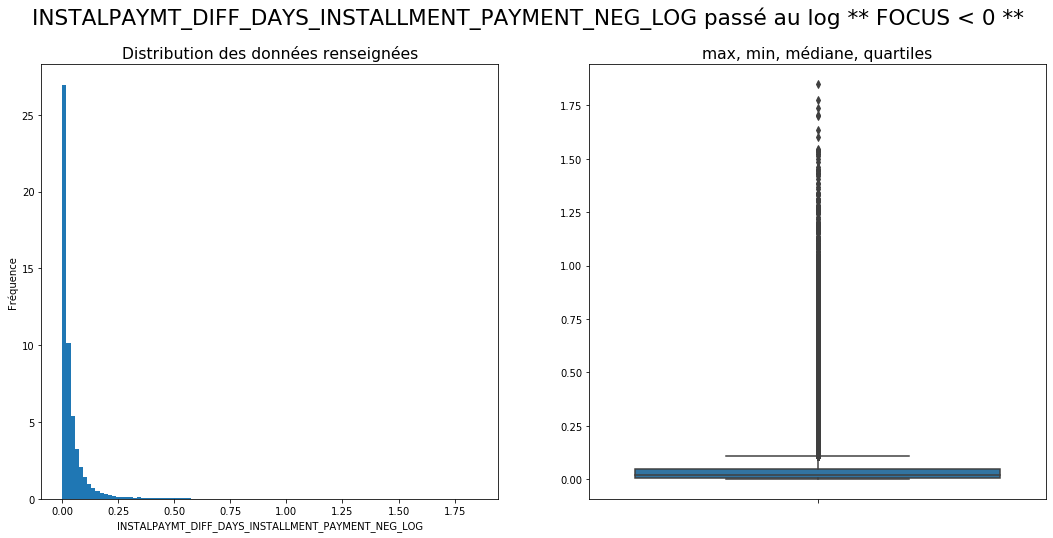

Mesures de position
 - Moyenne: 0.05
 - Médiane: 0.02
Mesures de dispertion
 - Ecart type: 0.09
 - Min: 0.0
 - Q25: 0.01
 - Q75: 0.05
 - Max: 1.85
Mesures de forme
 - Skewness (asymétrie): 6.56
 - Kurtosis (applatissement): 63.1


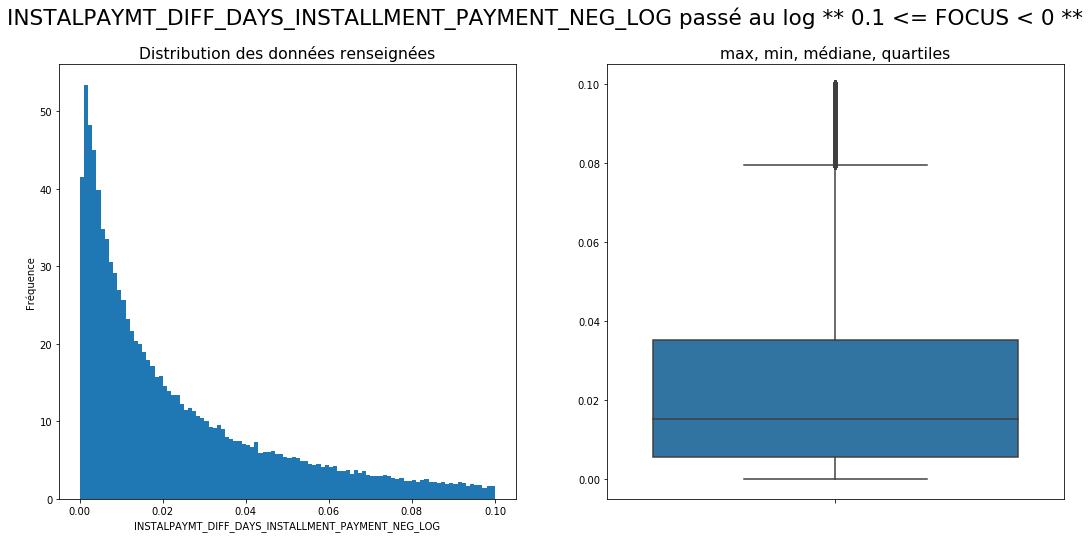

Mesures de position
 - Moyenne: 0.02
 - Médiane: 0.02
Mesures de dispertion
 - Ecart type: 0.02
 - Min: 0.0
 - Q25: 0.01
 - Q75: 0.04
 - Max: 0.1
Mesures de forme
 - Skewness (asymétrie): 1.27
 - Kurtosis (applatissement): 0.82


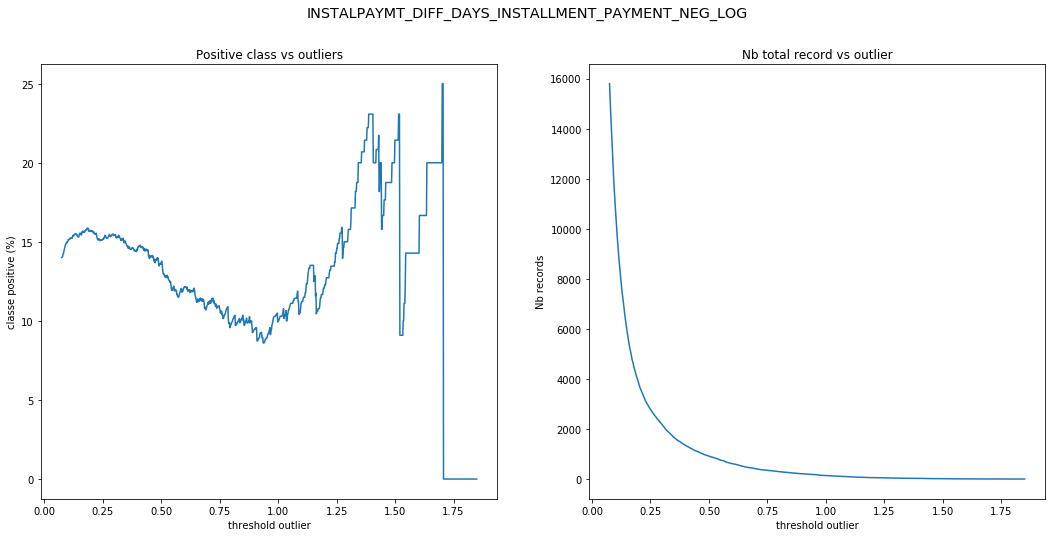

In [31]:
try:
    myDf(dfApplicationWorked).Stat('INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG', pltTitle = 'INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG')
    dfApplicationWorked['INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG'] = dfApplicationWorked.apply(lambda x: np.log(np.log(-x.INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG + 1)+1), axis=1)
    myDf(dfApplicationWorked).Stat('INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG', pltTitle = 'INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG passé au log')
    myDf(dfApplicationWorked[dfApplicationWorked.INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG > 0]).Stat('INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG', pltTitle = 'INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG passé au log ** FOCUS < 0 **')
    myDf(dfApplicationWorked[(dfApplicationWorked.INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG > 0) & (dfApplicationWorked.INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG < 0.1)]).Stat('INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG', pltTitle = 'INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG passé au log ** 0.1 <= FOCUS < 0 **')
    
    statImbalancedOutlier(dfApplicationWorked, 'INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG', limit_outlier=0.075, nb_points=1000)
except:
    pass

#### INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS *** VU ***

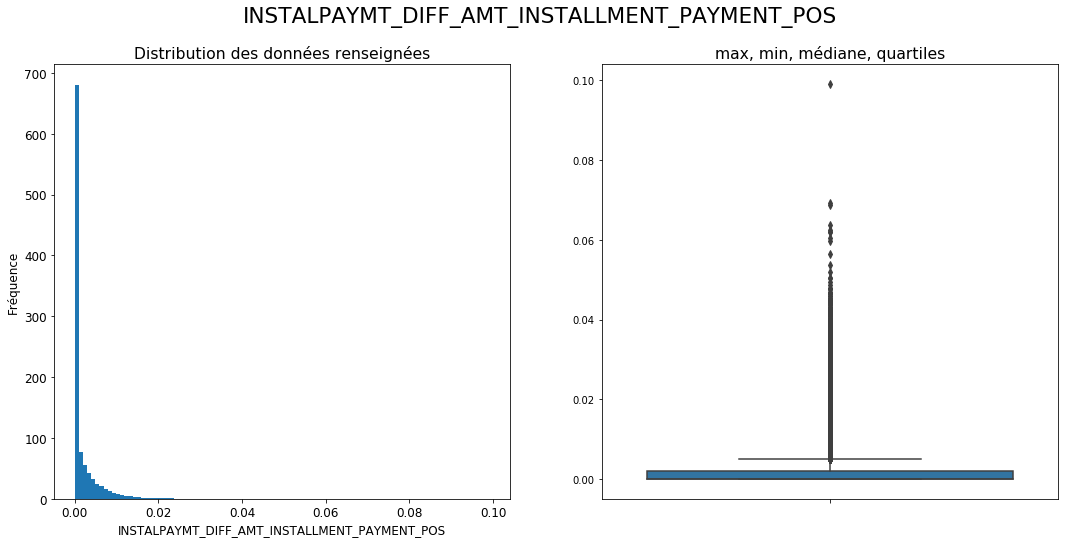

Mesures de position
 - Moyenne: 0.0
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.0
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 0.1
Mesures de forme
 - Skewness (asymétrie): 3.8
 - Kurtosis (applatissement): 25.25


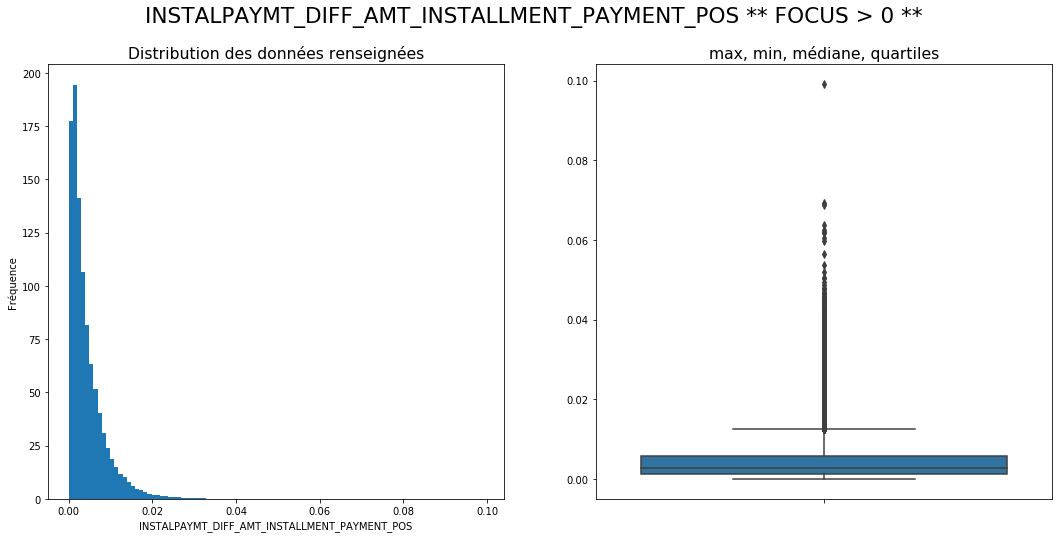

Mesures de position
 - Moyenne: 0.0
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.0
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.01
 - Max: 0.1
Mesures de forme
 - Skewness (asymétrie): 2.79
 - Kurtosis (applatissement): 15.46


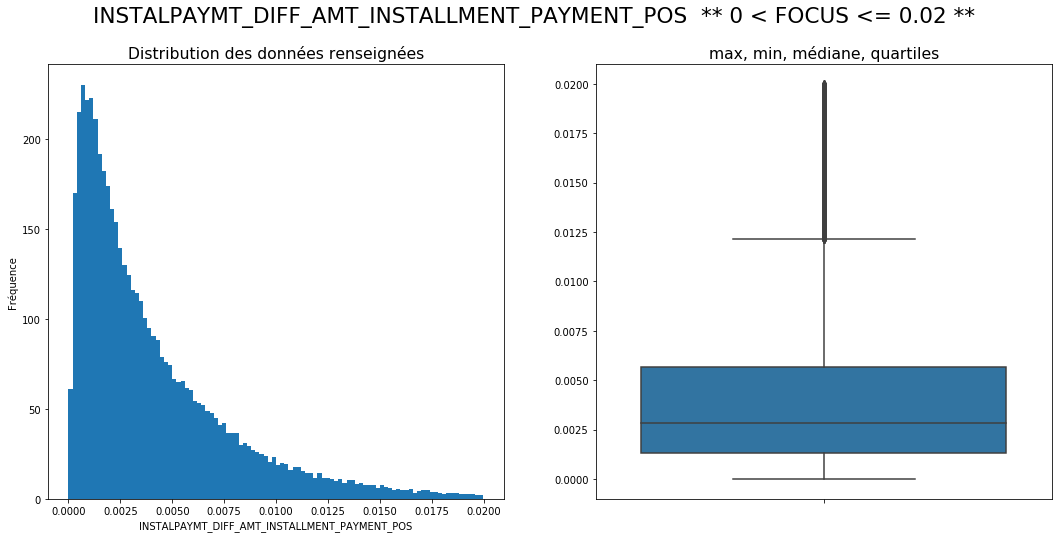

Mesures de position
 - Moyenne: 0.0
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.0
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.01
 - Max: 0.02
Mesures de forme
 - Skewness (asymétrie): 1.54
 - Kurtosis (applatissement): 2.31


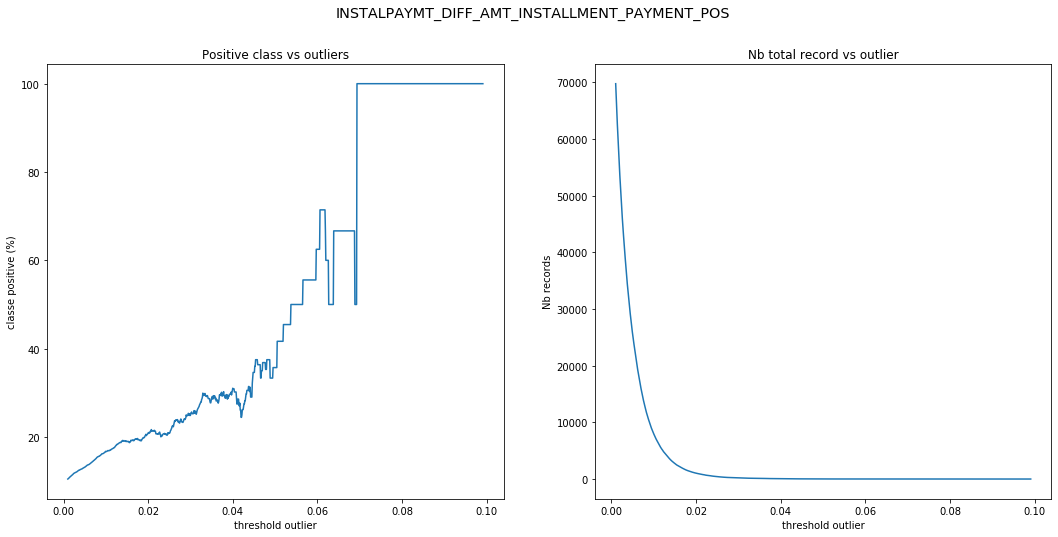

In [13]:
try:
    myDf(dfApplicationWorked).Stat('INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS', pltTitle = 'INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS')
    myDf(dfApplicationWorked[dfApplicationWorked.INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS > 0]).Stat('INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS', pltTitle = 'INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS ** FOCUS > 0 **')
    myDf(dfApplicationWorked[(dfApplicationWorked.INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS > 0) & (dfApplicationWorked.INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS < 0.02)]).Stat('INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS', pltTitle = 'INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS  ** 0 < FOCUS <= 0.02 **')

    statImbalancedOutlier(dfApplicationWorked, 'INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS', limit_outlier=0.001, nb_points=1000)
    #del dfApplicationWorked['BURO_AMT_CREDIT_MAX_OVERDUE']
except:
    pass

#### DEFAULT_PREV_AMT_DOWN_PAYMENT * VU *

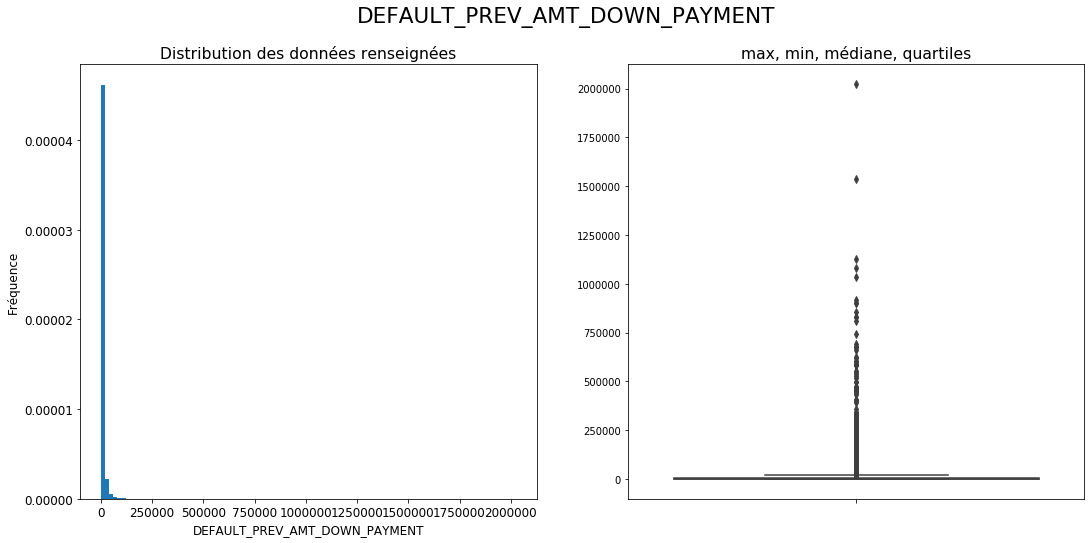

Mesures de position
 - Moyenne: 6306.11
 - Médiane: 2511.0
Mesures de dispertion
 - Ecart type: 17108.15
 - Min: -0.22
 - Q25: 0.0
 - Q75: 7318.12
 - Max: 2025000.0
Mesures de forme
 - Skewness (asymétrie): 28.18
 - Kurtosis (applatissement): 1858.39


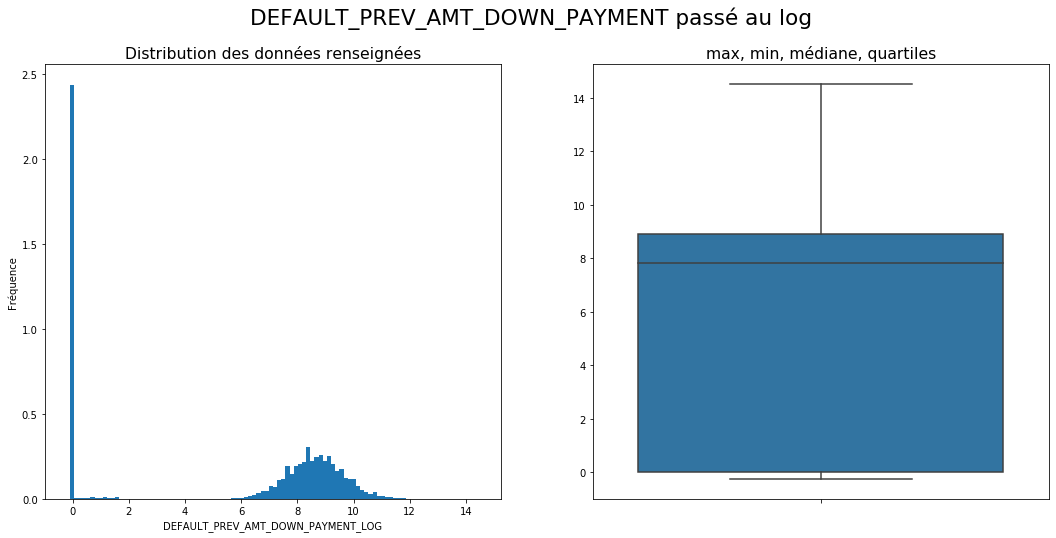

Mesures de position
 - Moyenne: 5.46
 - Médiane: 7.83
Mesures de dispertion
 - Ecart type: 4.25
 - Min: -0.25
 - Q25: 0.0
 - Q75: 8.9
 - Max: 14.52
Mesures de forme
 - Skewness (asymétrie): -0.43
 - Kurtosis (applatissement): -1.67


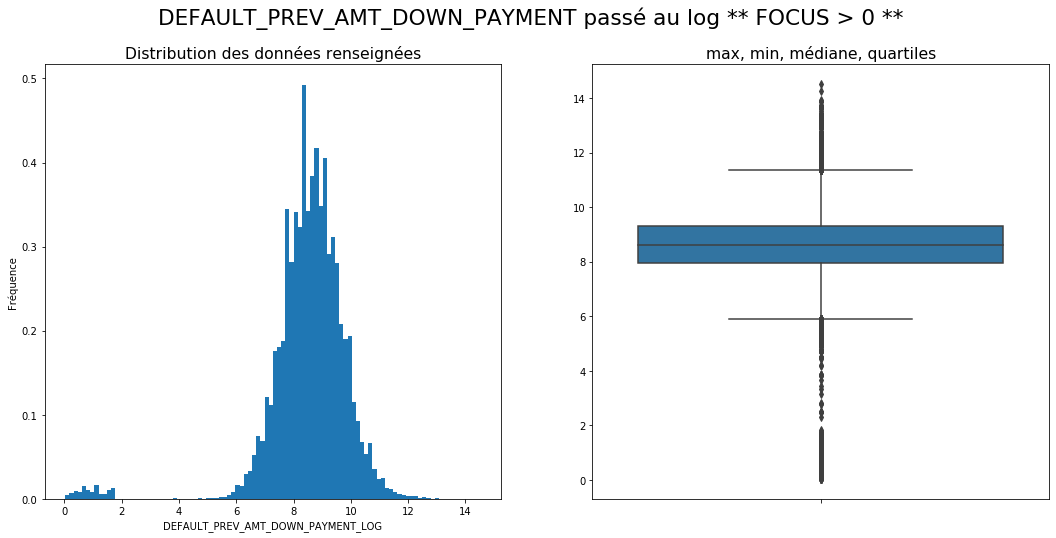

Mesures de position
 - Moyenne: 8.53
 - Médiane: 8.63
Mesures de dispertion
 - Ecart type: 1.41
 - Min: 0.03
 - Q25: 7.94
 - Q75: 9.3
 - Max: 14.52
Mesures de forme
 - Skewness (asymétrie): -2.45
 - Kurtosis (applatissement): 12.25


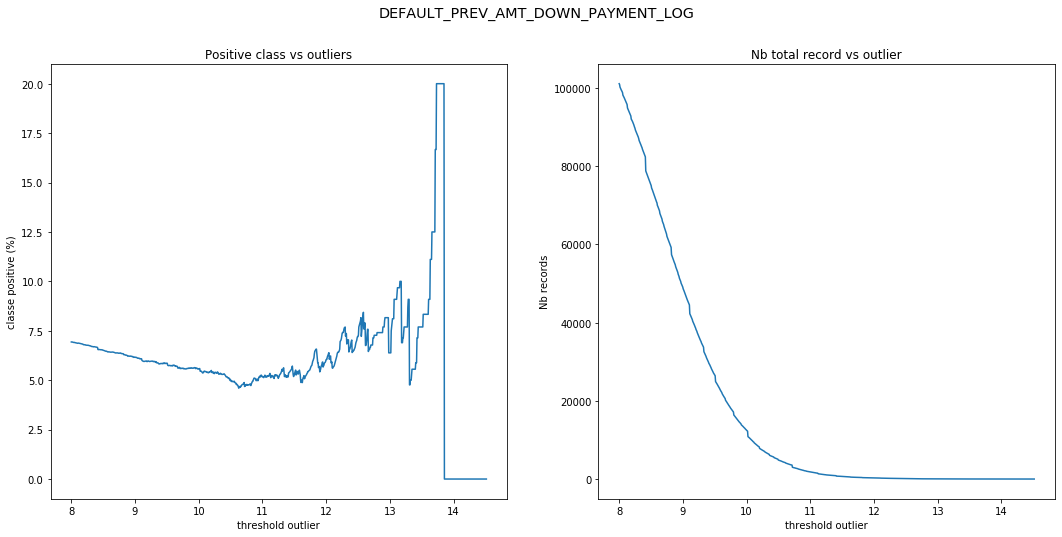

In [27]:
try:
    myDf(dfApplicationWorked).Stat('DEFAULT_PREV_AMT_DOWN_PAYMENT', pltTitle = 'DEFAULT_PREV_AMT_DOWN_PAYMENT')
    dfApplicationWorked['DEFAULT_PREV_AMT_DOWN_PAYMENT_LOG'] = dfApplicationWorked.apply(lambda x: np.log(x.DEFAULT_PREV_AMT_DOWN_PAYMENT + 1), axis=1)
    myDf(dfApplicationWorked).Stat('DEFAULT_PREV_AMT_DOWN_PAYMENT_LOG', pltTitle = 'DEFAULT_PREV_AMT_DOWN_PAYMENT passé au log')
    myDf(dfApplicationWorked[dfApplicationWorked.DEFAULT_PREV_AMT_DOWN_PAYMENT_LOG > 0]).Stat('DEFAULT_PREV_AMT_DOWN_PAYMENT_LOG', pltTitle = 'DEFAULT_PREV_AMT_DOWN_PAYMENT passé au log ** FOCUS > 0 **')

    statImbalancedOutlier(dfApplicationWorked, 'DEFAULT_PREV_AMT_DOWN_PAYMENT_LOG', limit_outlier=8, nb_points=1000)
    tmp = dfApplicationWorked[dfApplicationWorked.DEFAULT_PREV_AMT_DOWN_PAYMENT_LOG>0].copy()
    tmp['DEFAULT_PREV_AMT_DOWN_PAYMENT_LOG_MINUS_8'] = tmp.apply(lambda x: x.DEFAULT_PREV_AMT_DOWN_PAYMENT_LOG-8, axis=1)
    statImbalancedOutlier(tmp, 'DEFAULT_PREV_AMT_DOWN_PAYMENT_LOG_MINUS_8', limit_outlier=0, nb_points=1000, to_add_to_threshold=8.0)
    
except:
    pass

#### BURO_DAYS_CREDIT_ENDDATE *** VU ***

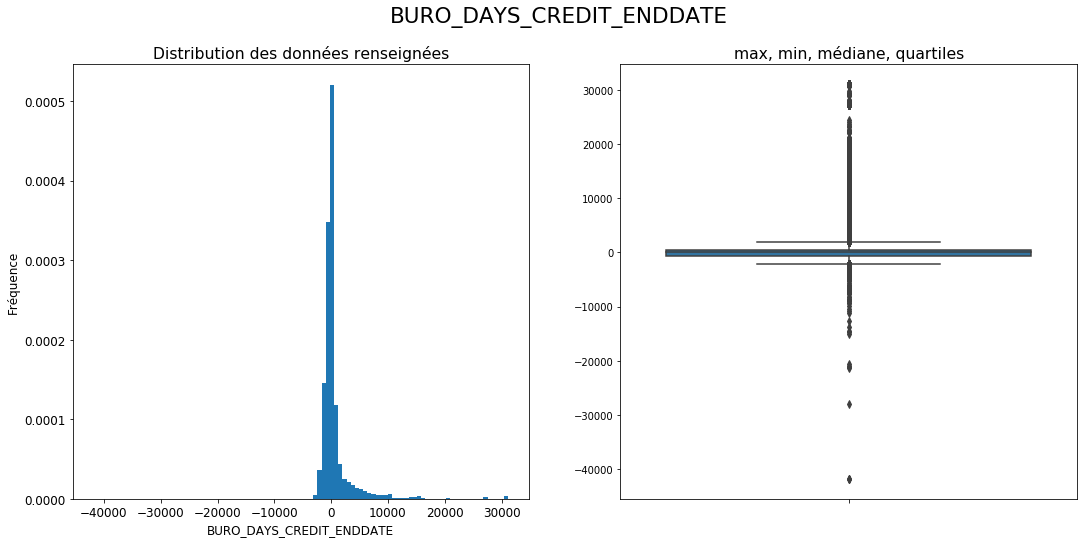

Mesures de position
 - Moyenne: 559.01
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 3051.48
 - Min: -41875.0
 - Q25: -593.17
 - Q75: 404.33
 - Max: 31198.0
Mesures de forme
 - Skewness (asymétrie): 5.35
 - Kurtosis (applatissement): 40.64


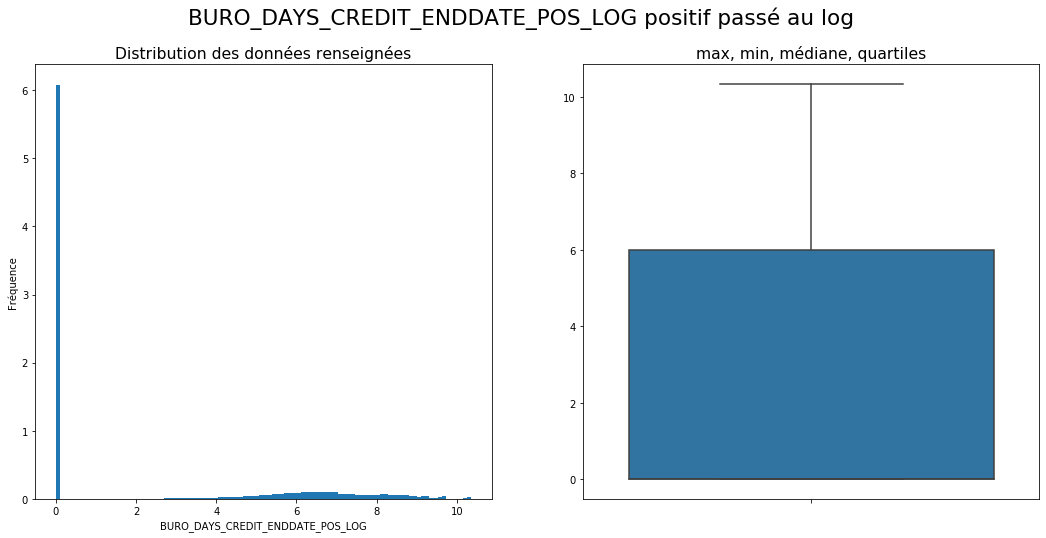

Mesures de position
 - Moyenne: 2.48
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 3.38
 - Min: 0.0
 - Q25: 0.0
 - Q75: 6.0
 - Max: 10.35
Mesures de forme
 - Skewness (asymétrie): 0.78
 - Kurtosis (applatissement): -1.12


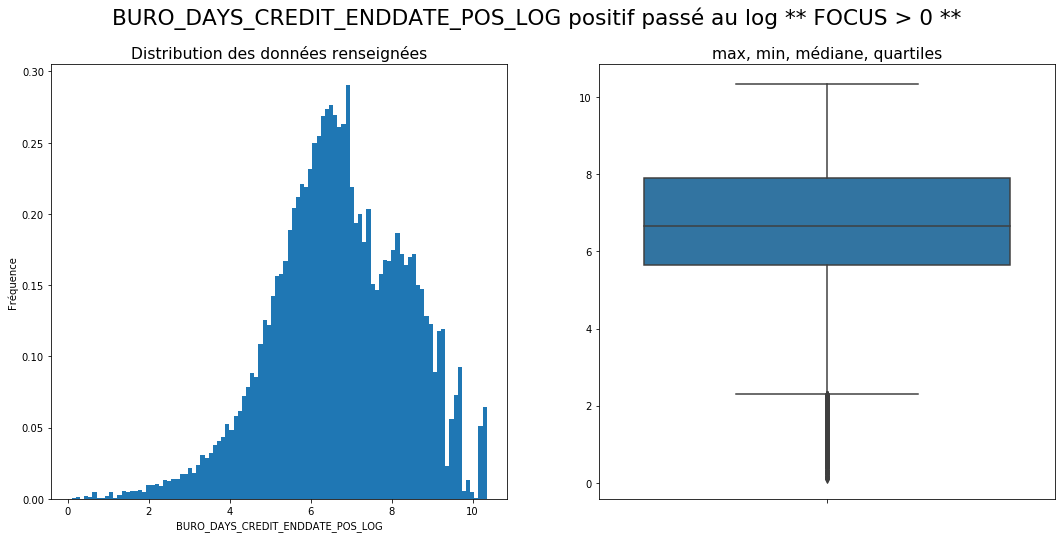

Mesures de position
 - Moyenne: 6.69
 - Médiane: 6.67
Mesures de dispertion
 - Ecart type: 1.63
 - Min: 0.1
 - Q25: 5.66
 - Q75: 7.9
 - Max: 10.35
Mesures de forme
 - Skewness (asymétrie): -0.3
 - Kurtosis (applatissement): 0.16


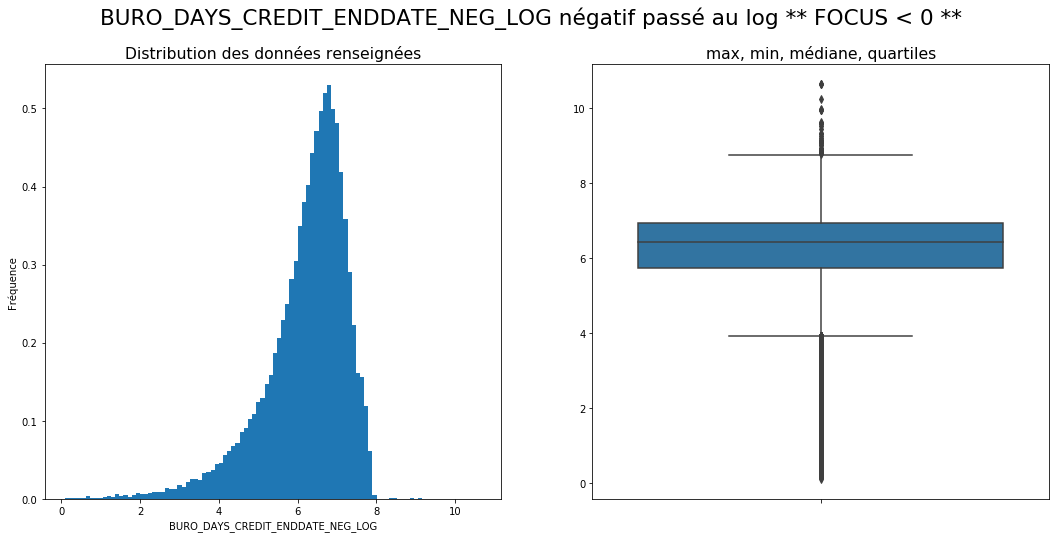

Mesures de position
 - Moyenne: 6.21
 - Médiane: 6.44
Mesures de dispertion
 - Ecart type: 1.06
 - Min: 0.11
 - Q25: 5.73
 - Q75: 6.93
 - Max: 10.64
Mesures de forme
 - Skewness (asymétrie): -1.39
 - Kurtosis (applatissement): 2.84


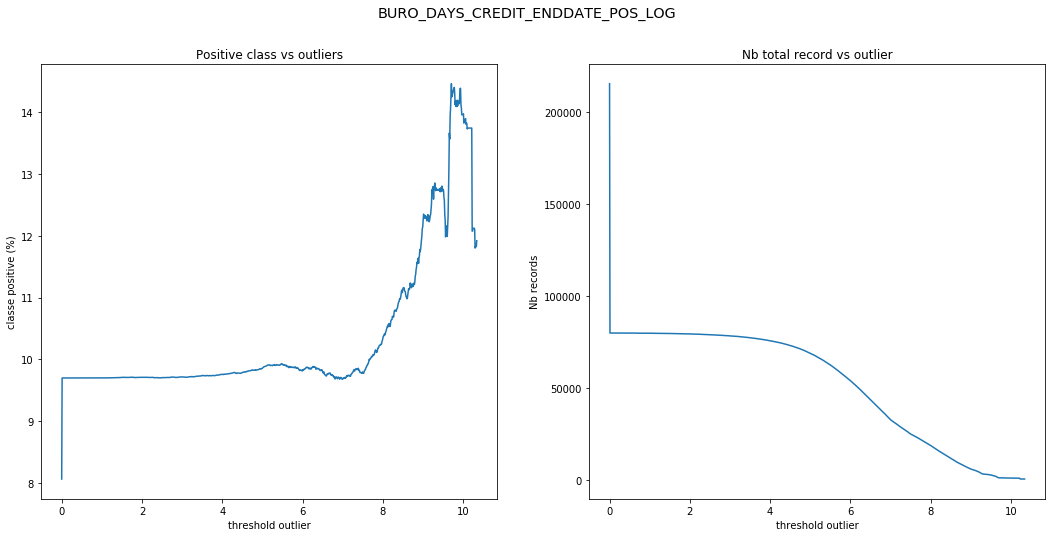

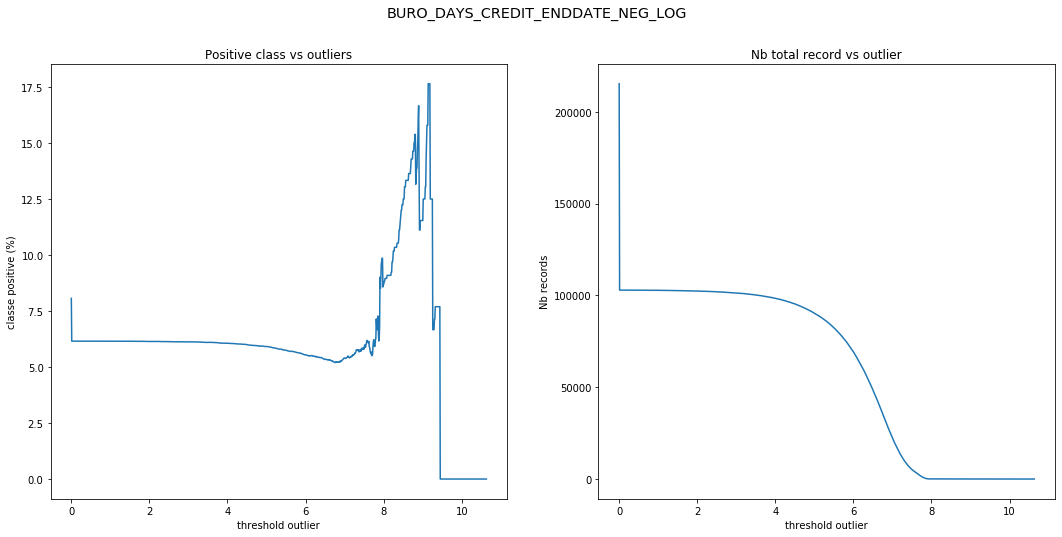

In [28]:
myDf(dfApplicationWorked).Stat('BURO_DAYS_CREDIT_ENDDATE', pltTitle = 'BURO_DAYS_CREDIT_ENDDATE')
dfApplicationWorked['BURO_DAYS_CREDIT_ENDDATE_POS_LOG'] = dfApplicationWorked.apply(lambda x: np.log(1+np.max([x.BURO_DAYS_CREDIT_ENDDATE,0])), axis=1)
dfApplicationWorked['BURO_DAYS_CREDIT_ENDDATE_NEG_LOG'] = dfApplicationWorked.apply(lambda x: np.log(1-np.min([x.BURO_DAYS_CREDIT_ENDDATE,0])), axis=1)
myDf(dfApplicationWorked).Stat('BURO_DAYS_CREDIT_ENDDATE_POS_LOG', pltTitle = 'BURO_DAYS_CREDIT_ENDDATE_POS_LOG positif passé au log')
myDf(dfApplicationWorked[dfApplicationWorked.BURO_DAYS_CREDIT_ENDDATE_POS_LOG>0]).Stat('BURO_DAYS_CREDIT_ENDDATE_POS_LOG', pltTitle = 'BURO_DAYS_CREDIT_ENDDATE_POS_LOG positif passé au log ** FOCUS > 0 **')
myDf(dfApplicationWorked[dfApplicationWorked.BURO_DAYS_CREDIT_ENDDATE_NEG_LOG>0]).Stat('BURO_DAYS_CREDIT_ENDDATE_NEG_LOG', pltTitle = 'BURO_DAYS_CREDIT_ENDDATE_NEG_LOG négatif passé au log ** FOCUS < 0 **')
statImbalancedOutlier(dfApplicationWorked, 'BURO_DAYS_CREDIT_ENDDATE_POS_LOG', limit_outlier=0, nb_points=1000)
statImbalancedOutlier(dfApplicationWorked, 'BURO_DAYS_CREDIT_ENDDATE_NEG_LOG', limit_outlier=0, nb_points=1000)

#### DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE * VU *

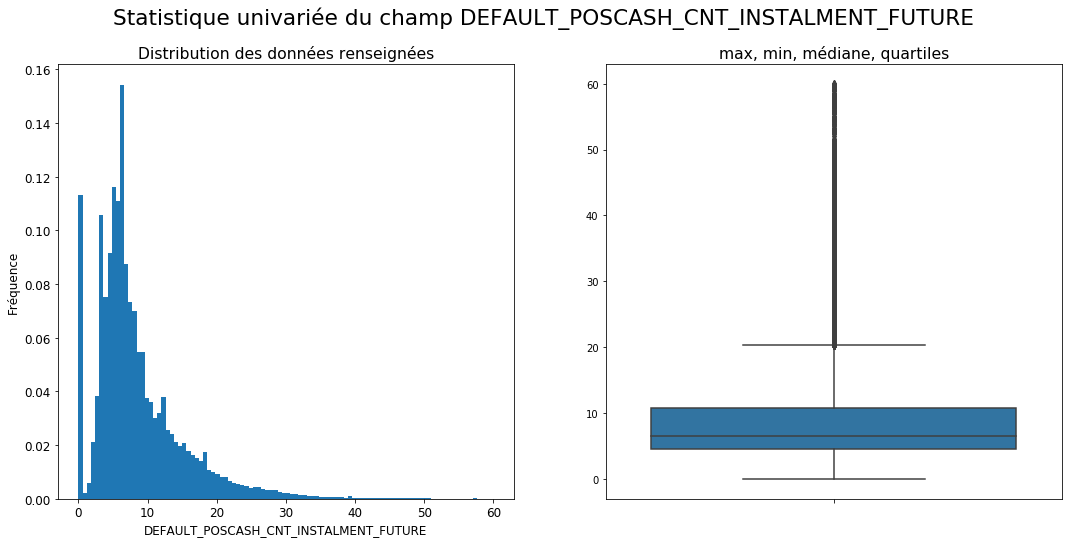

Mesures de position
 - Moyenne: 8.48
 - Médiane: 6.59
Mesures de dispertion
 - Ecart type: 6.56
 - Min: 0.0
 - Q25: 4.55
 - Q75: 10.85
 - Max: 60.0
Mesures de forme
 - Skewness (asymétrie): 1.88
 - Kurtosis (applatissement): 5.61


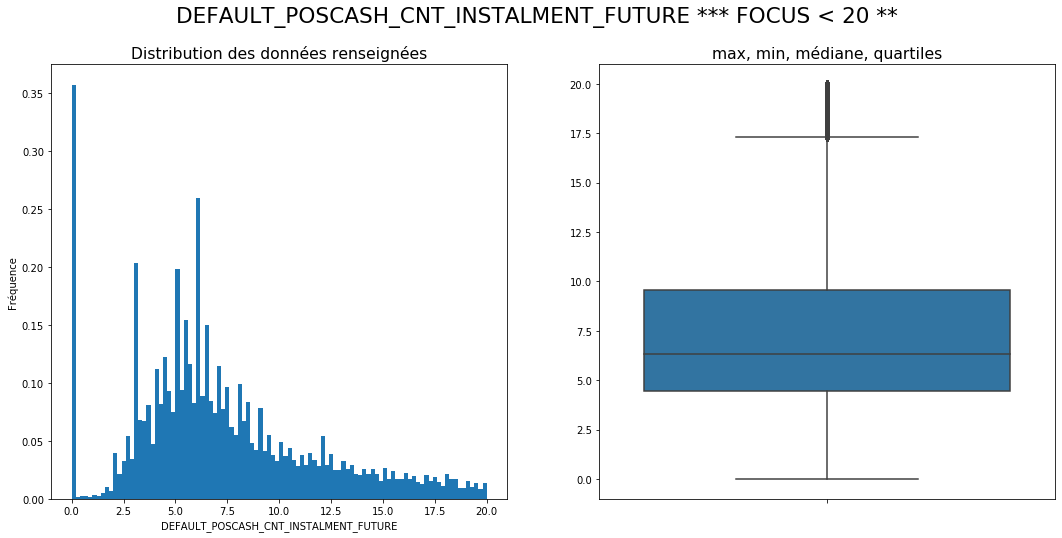

Mesures de position
 - Moyenne: 7.29
 - Médiane: 6.33
Mesures de dispertion
 - Ecart type: 4.49
 - Min: 0.0
 - Q25: 4.44
 - Q75: 9.58
 - Max: 20.0
Mesures de forme
 - Skewness (asymétrie): 0.71
 - Kurtosis (applatissement): 0.15


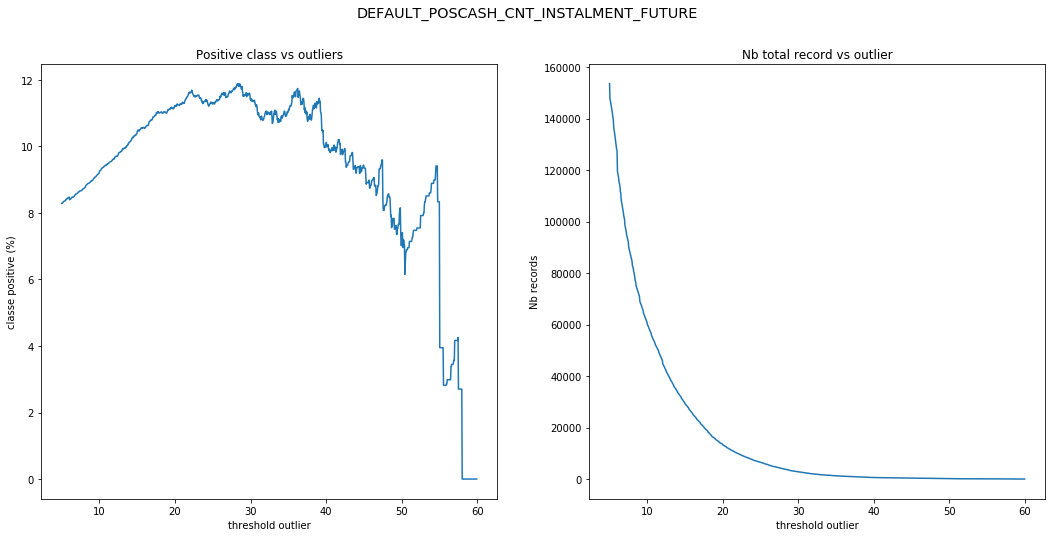

In [35]:
try:
    myDf(dfApplicationWorked).Stat('DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE')
    myDf(dfApplicationWorked[dfApplicationWorked.DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE <= 20]).Stat('DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE', pltTitle='DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE *** FOCUS < 20 **')
    statImbalancedOutlier(dfApplicationWorked,feature='DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE', nb_points=1000, limit_outlier = 5)
except:
    pass

#### DAYS_EMPLOYED

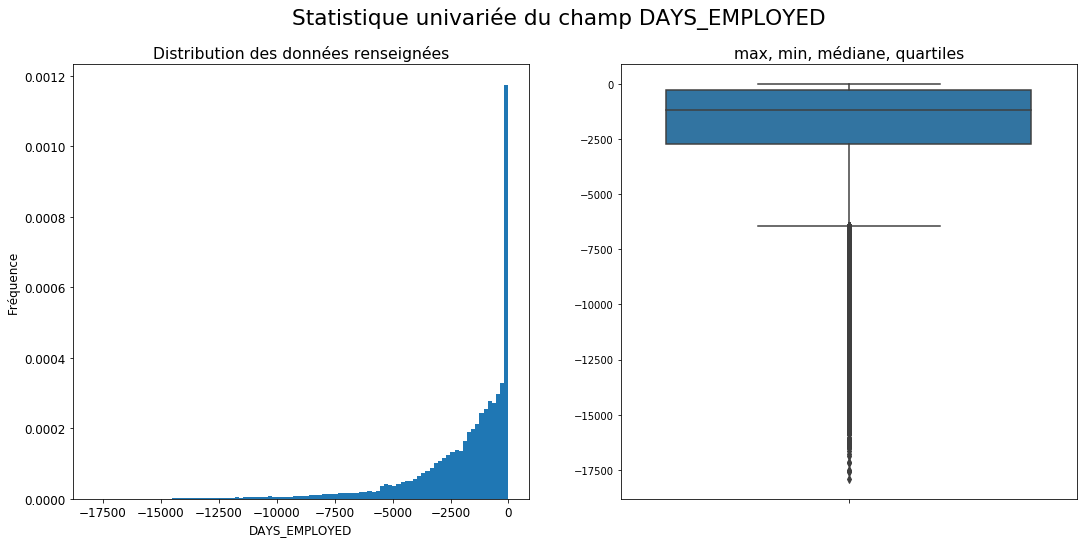

Mesures de position
 - Moyenne: -1950.48
 - Médiane: -1209.0
Mesures de dispertion
 - Ecart type: 2304.46
 - Min: -17912
 - Q25: -2754.0
 - Q75: -289.0
 - Max: 1
Mesures de forme
 - Skewness (asymétrie): -2.05
 - Kurtosis (applatissement): 5.24


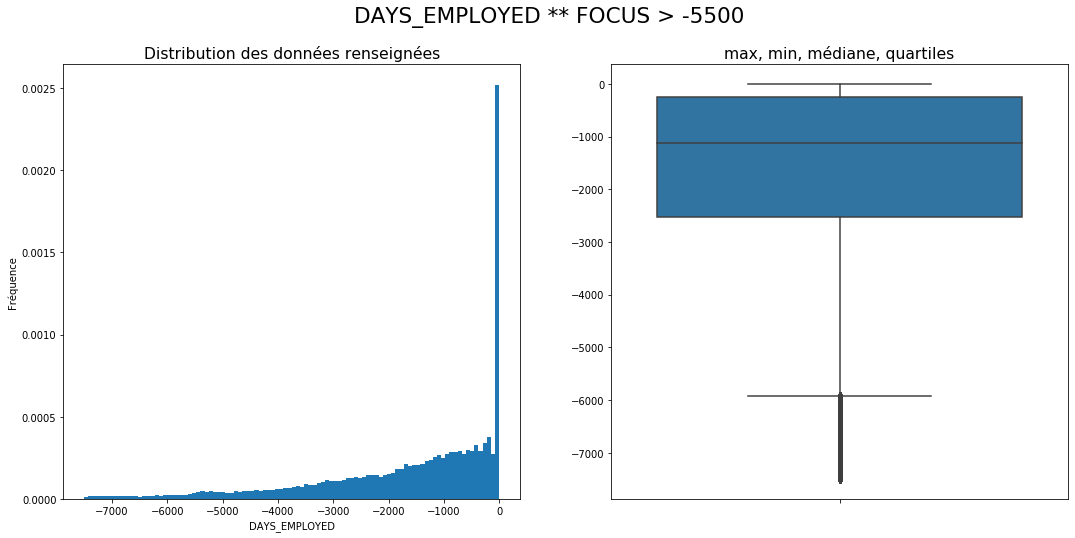

Mesures de position
 - Moyenne: -1641.09
 - Médiane: -1132.0
Mesures de dispertion
 - Ecart type: 1685.59
 - Min: -7500
 - Q25: -2523.0
 - Q75: -257.0
 - Max: 1
Mesures de forme
 - Skewness (asymétrie): -1.22
 - Kurtosis (applatissement): 0.94


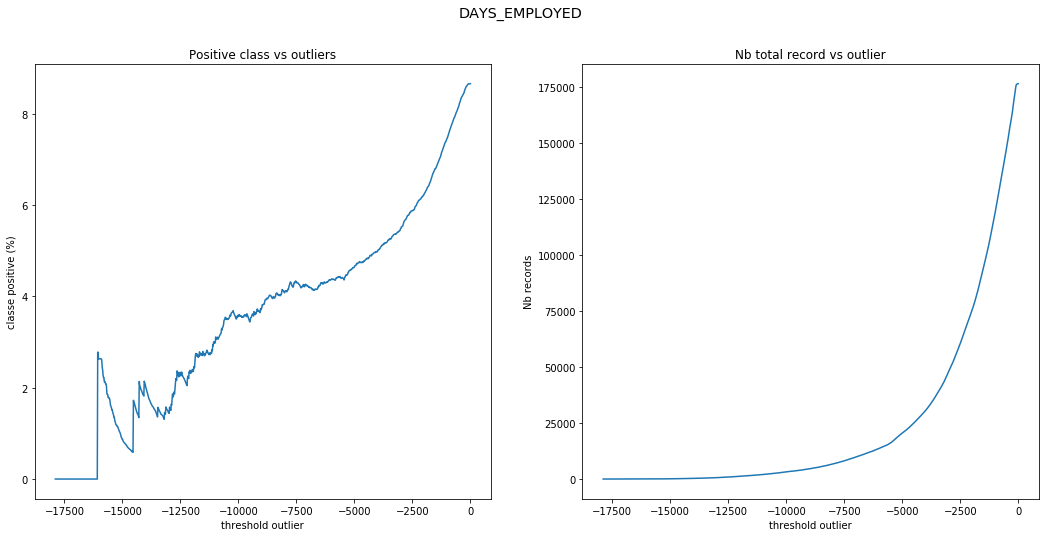

In [40]:
try:
    myDf(dfApplicationWorked).Stat('DAYS_EMPLOYED')
    myDf(dfApplicationWorked[dfApplicationWorked.DAYS_EMPLOYED >= -7500]).Stat('DAYS_EMPLOYED', pltTitle='DAYS_EMPLOYED ** FOCUS > -7500')
    statImbalancedOutlier(dfApplicationWorked,feature='DAYS_EMPLOYED', nb_points=1000, limit_outlier = -1)
except:
    pass

#### PREV_DAYS_DIFF

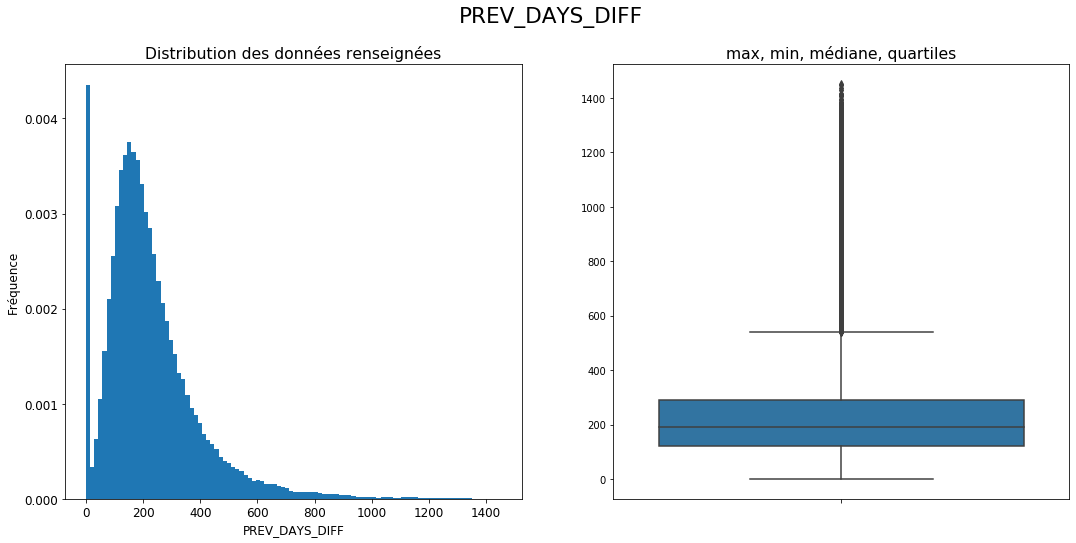

Mesures de position
 - Moyenne: 226.15
 - Médiane: 191.75
Mesures de dispertion
 - Ecart type: 166.34
 - Min: 0.0
 - Q25: 122.83
 - Q75: 290.33
 - Max: 1451.5
Mesures de forme
 - Skewness (asymétrie): 1.83
 - Kurtosis (applatissement): 5.78


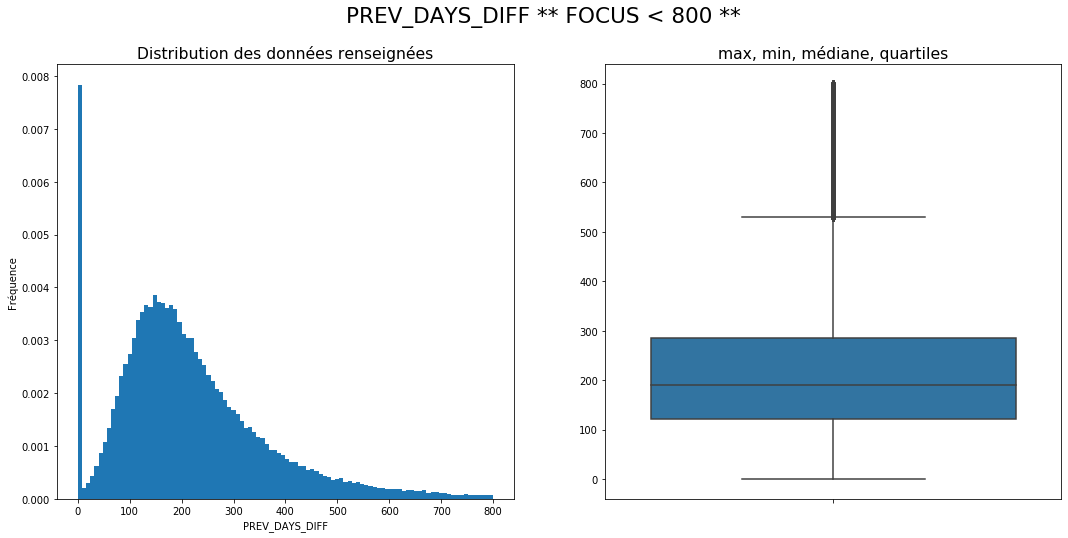

Mesures de position
 - Moyenne: 216.78
 - Médiane: 190.0
Mesures de dispertion
 - Ecart type: 143.68
 - Min: 0.0
 - Q25: 121.95
 - Q75: 285.11
 - Max: 799.67
Mesures de forme
 - Skewness (asymétrie): 1.08
 - Kurtosis (applatissement): 1.51


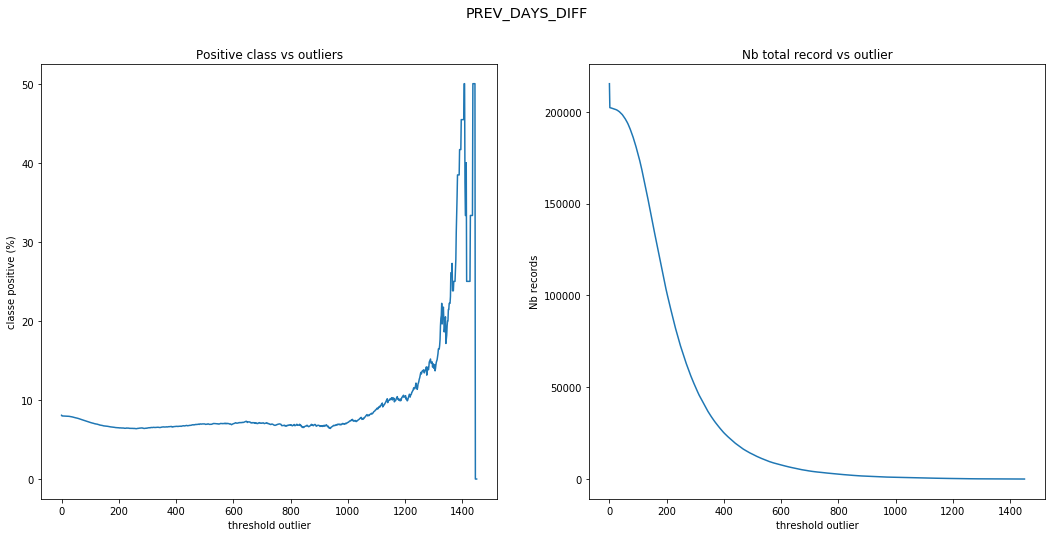

In [52]:
try:
    myDf(dfApplicationWorked).Stat('PREV_DAYS_DIFF', pltTitle='PREV_DAYS_DIFF')
    myDf(dfApplicationWorked[dfApplicationWorked.PREV_DAYS_DIFF < 800]).Stat('PREV_DAYS_DIFF', pltTitle='PREV_DAYS_DIFF ** FOCUS < 800 **')
    statImbalancedOutlier(dfApplicationWorked,feature='PREV_DAYS_DIFF', nb_points=1000, limit_outlier = 0)
except:
    pass

#### DEFAULT_AMT_GOODS_PRICE * VU *

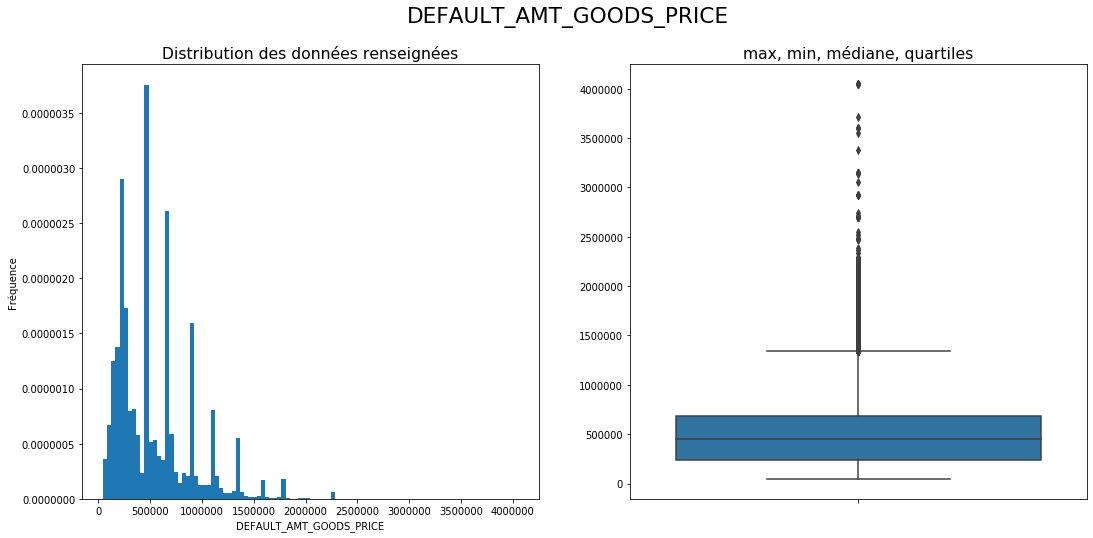

Mesures de position
 - Moyenne: 538187.97
 - Médiane: 450000.0
Mesures de dispertion
 - Ecart type: 369446.25
 - Min: 45000.0
 - Q25: 238500.0
 - Q75: 679500.0
 - Max: 4050000.0
Mesures de forme
 - Skewness (asymétrie): 1.35
 - Kurtosis (applatissement): 2.42


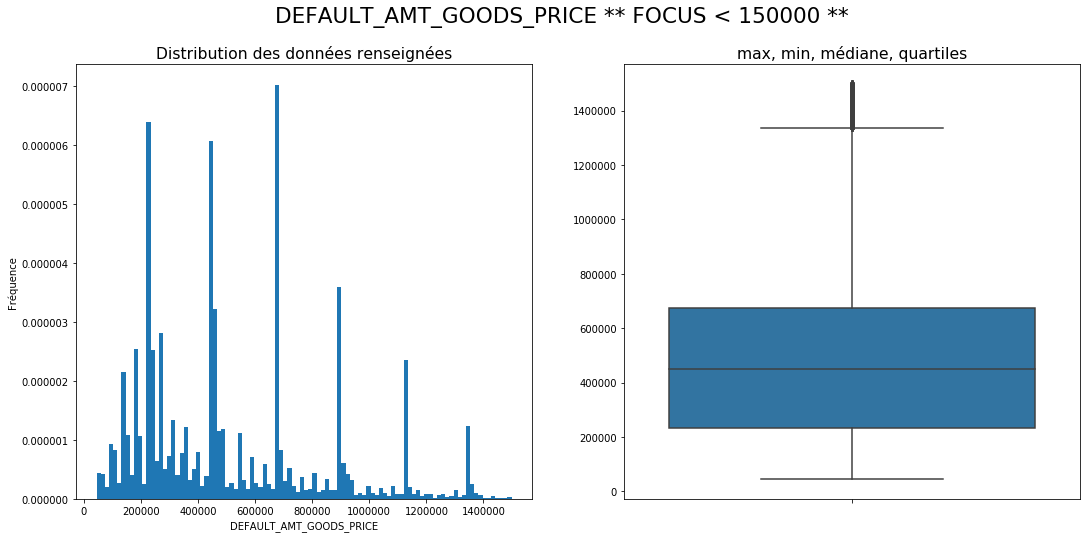

Mesures de position
 - Moyenne: 509556.17
 - Médiane: 450000.0
Mesures de dispertion
 - Ecart type: 318873.97
 - Min: 45000.0
 - Q25: 234000.0
 - Q75: 675000.0
 - Max: 1498500.0
Mesures de forme
 - Skewness (asymétrie): 0.85
 - Kurtosis (applatissement): 0.01


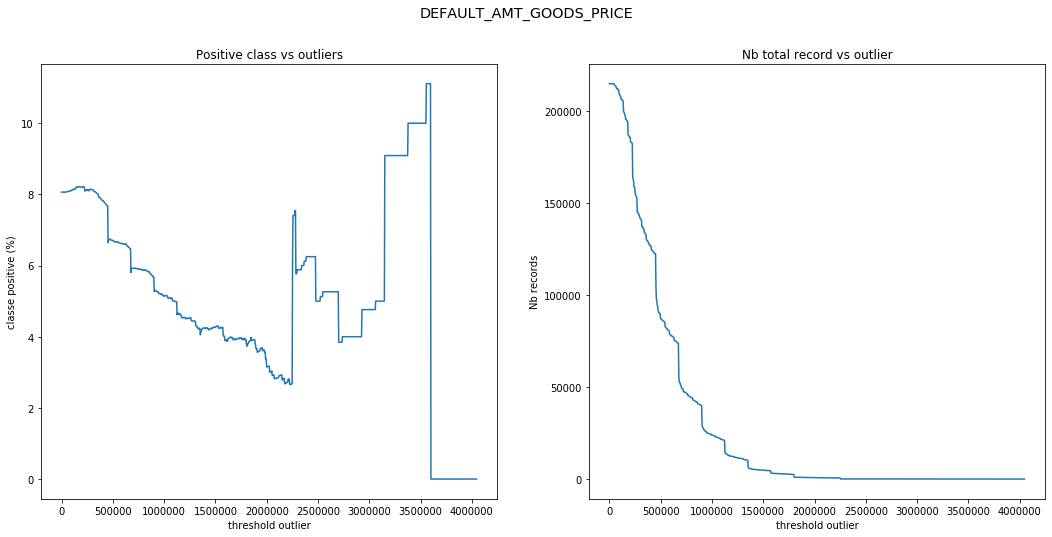

In [81]:
try:
    myDf(dfApplicationWorked).Stat('DEFAULT_AMT_GOODS_PRICE', pltTitle='DEFAULT_AMT_GOODS_PRICE')
    myDf(dfApplicationWorked[dfApplicationWorked.DEFAULT_AMT_GOODS_PRICE <= 1500000]).Stat('DEFAULT_AMT_GOODS_PRICE', pltTitle='DEFAULT_AMT_GOODS_PRICE ** FOCUS < 1500000 **')
    statImbalancedOutlier(dfApplicationWorked,feature='DEFAULT_AMT_GOODS_PRICE', nb_points=1000, limit_outlier = 0)
except:
    pass

#### DEFAULT_BURO_DAYS_CREDIT_UPDATE ** VU **

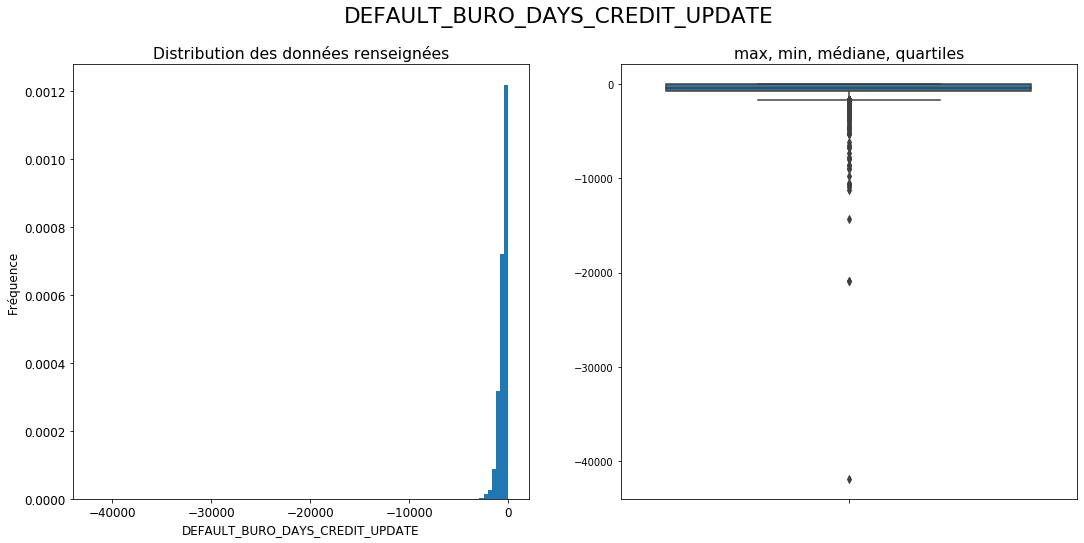

Mesures de position
 - Moyenne: -467.76
 - Médiane: -392.0
Mesures de dispertion
 - Ecart type: 465.53
 - Min: -41890.0
 - Q25: -720.12
 - Q75: -57.17
 - Max: 14.0
Mesures de forme
 - Skewness (asymétrie): -5.81
 - Kurtosis (applatissement): 341.35


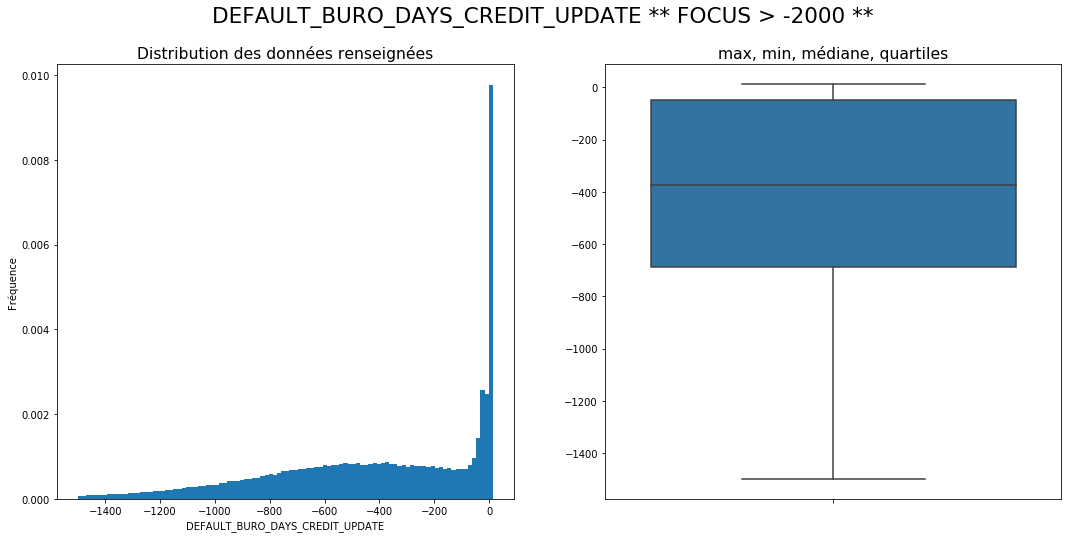

Mesures de position
 - Moyenne: -426.59
 - Médiane: -375.5
Mesures de dispertion
 - Ecart type: 376.11
 - Min: -1500.0
 - Q25: -689.0
 - Q75: -50.0
 - Max: 14.0
Mesures de forme
 - Skewness (asymétrie): -0.63
 - Kurtosis (applatissement): -0.5


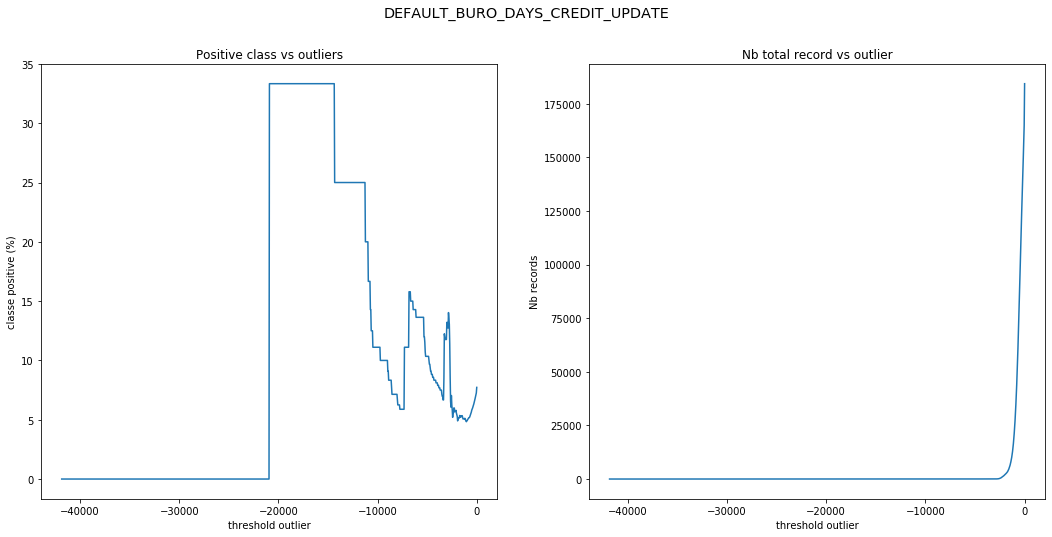

In [69]:
try:
    myDf(dfApplicationWorked).Stat('DEFAULT_BURO_DAYS_CREDIT_UPDATE', pltTitle="DEFAULT_BURO_DAYS_CREDIT_UPDATE")
    myDf(dfApplicationWorked[dfApplicationWorked.DEFAULT_BURO_DAYS_CREDIT_UPDATE >= -1500]).Stat('DEFAULT_BURO_DAYS_CREDIT_UPDATE', pltTitle='DEFAULT_BURO_DAYS_CREDIT_UPDATE ** FOCUS > -1500 **')
    statImbalancedOutlier(dfApplicationWorked,feature='DEFAULT_BURO_DAYS_CREDIT_UPDATE', nb_points=1000, limit_outlier = -0.01)
except:
    pass

#### DEFAULT_PREV_CNT_PAYMENT

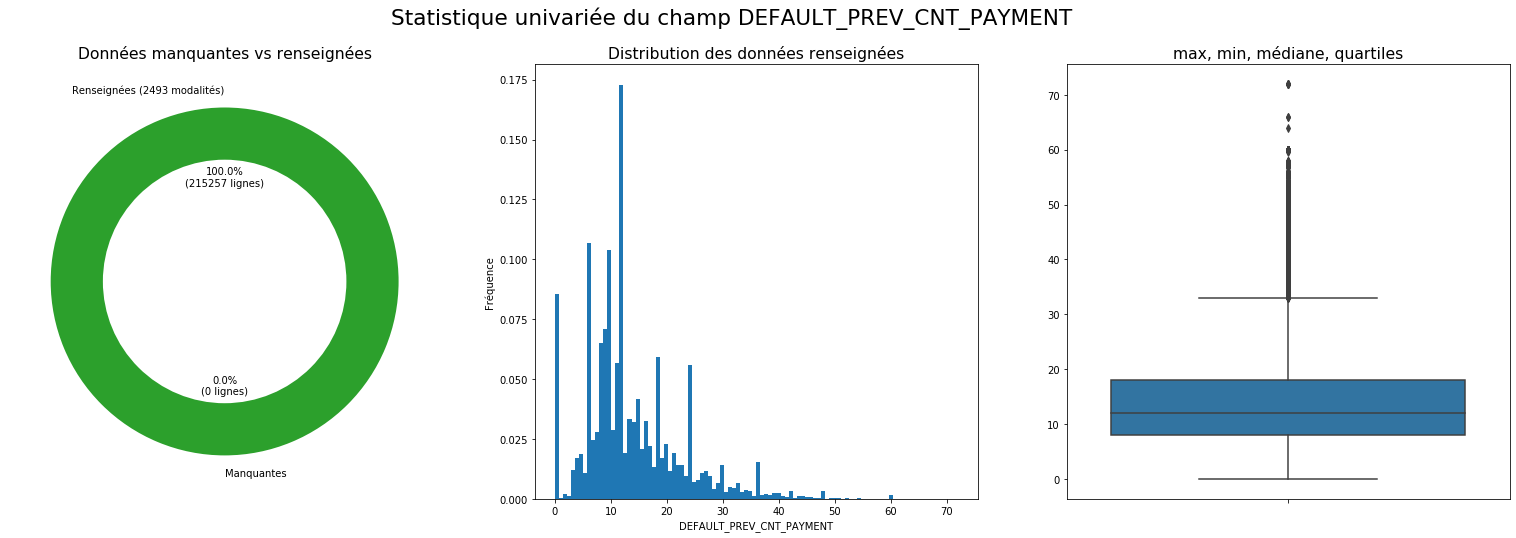

Mesures de position
 - Moyenne: 13.74
 - Médiane: 12.0
Mesures de dispertion
 - Ecart type: 8.84
 - Min: 0.0
 - Q25: 8.0
 - Q75: 18.0
 - Max: 72.0
Mesures de forme
 - Skewness (asymétrie): 1.2
 - Kurtosis (applatissement): 2.24


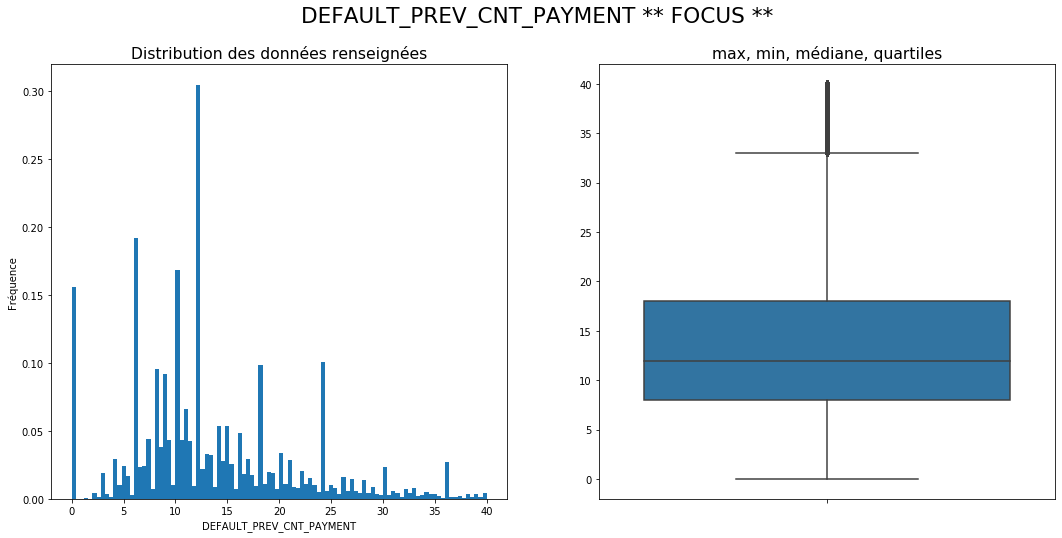

Mesures de position
 - Moyenne: 13.33
 - Médiane: 12.0
Mesures de dispertion
 - Ecart type: 8.05
 - Min: 0.0
 - Q25: 8.0
 - Q75: 18.0
 - Max: 40.0
Mesures de forme
 - Skewness (asymétrie): 0.82
 - Kurtosis (applatissement): 0.58


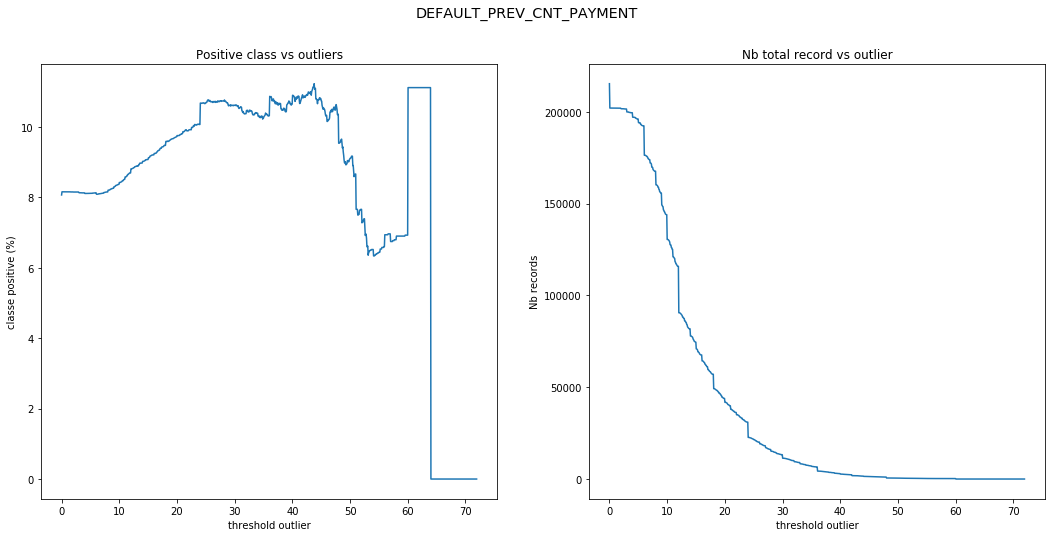

In [74]:
try:
    myDf(dfApplicationWorked).Stat('DEFAULT_PREV_CNT_PAYMENT', statsNan=True)
    myDf(dfApplicationWorked[dfApplicationWorked.DEFAULT_PREV_CNT_PAYMENT <= 40]).Stat('DEFAULT_PREV_CNT_PAYMENT', pltTitle='DEFAULT_PREV_CNT_PAYMENT ** FOCUS **')
    statImbalancedOutlier(dfApplicationWorked,feature='DEFAULT_PREV_CNT_PAYMENT', nb_points=1000, limit_outlier = 0)
except:
    pass

### Suppression des outliers négatifs et transformation des variables numériques

In [108]:
dfApplicationWorked = dfApplicationWorkedSvg.copy()


print(dfApplicationWorked.shape[0])

try:
    # VU
    dfApplicationWorked['BURO_AMT_CREDIT_MAX_OVERDUE_LOG'] = dfApplicationWorked.apply(lambda x: np.log(1+x.BURO_AMT_CREDIT_MAX_OVERDUE), axis=1)
    dfApplicationWorked['BURO_AMT_CREDIT_MAX_OVERDUE_LOG'] = dfApplicationWorked['BURO_AMT_CREDIT_MAX_OVERDUE_LOG'].astype('float64')
    del dfApplicationWorked['BURO_AMT_CREDIT_MAX_OVERDUE']
    print('BURO_AMT_CREDIT_MAX_OVERDUE')
    print(dfApplicationWorked.shape[0])
except:
    pass


try:
    #VU
    dfApplicationWorked['INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG'] = dfApplicationWorked.apply(lambda x: np.log(1+np.log(1-x.INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG)), axis=1)
    dfApplicationWorked = dfApplicationWorked[(dfApplicationWorked.INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG <= 0.1) | (dfApplicationWorked.TARGET == 1)]
    dfApplicationWorked['INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG'] = dfApplicationWorked.apply(lambda x: np.where(x.INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG > 0.1, (x.INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG-0.1)*6/190+0.04, x.INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG), axis=1)
    dfApplicationWorked['INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG'] = dfApplicationWorked['INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG'].astype('float64')
    del dfApplicationWorked['INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG']
    print('INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG')
    print(dfApplicationWorked.shape[0])
except:
    pass
try:
    #VU
    dfApplicationWorked = dfApplicationWorked[(dfApplicationWorked.INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS <= 0.02) | (dfApplicationWorked.TARGET == 1)]
    dfApplicationWorked['INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS'] = dfApplicationWorked.apply(lambda x: np.where(x.INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS >= 0.02, (x.INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS-0.02)*3/16+0.005, x.INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS), axis=1)
    dfApplicationWorked['INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS'] = dfApplicationWorked['INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS'].astype('float64')
    print('INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS')
    print(dfApplicationWorked.shape[0])
except:
    pass
try:
    # VU
    dfApplicationWorked['DEFAULT_PREV_AMT_DOWN_PAYMENT_LOG'] = dfApplicationWorked.apply(lambda x: np.log(1+x.DEFAULT_PREV_AMT_DOWN_PAYMENT), axis=1)
    dfApplicationWorked['DEFAULT_PREV_AMT_DOWN_PAYMENT_LOG'] = dfApplicationWorked['DEFAULT_PREV_AMT_DOWN_PAYMENT_LOG'].astype('float64')
    del dfApplicationWorked['DEFAULT_PREV_AMT_DOWN_PAYMENT']
    print('DEFAULT_PREV_AMT_DOWN_PAYMENT')
    print(dfApplicationWorked.shape[0])
except:
    pass
try:
    # VU
    dfApplicationWorked['BURO_DAYS_CREDIT_ENDDATE_POS_LOG'] = dfApplicationWorked.apply(lambda x: np.log(1+np.max([x.BURO_DAYS_CREDIT_ENDDATE,0])), axis=1)
    dfApplicationWorked['BURO_DAYS_CREDIT_ENDDATE_NEG_LOG'] = dfApplicationWorked.apply(lambda x: np.log(1-np.min([x.BURO_DAYS_CREDIT_ENDDATE,0])), axis=1)
    dfApplicationWorked['BURO_DAYS_CREDIT_ENDDATE_NEG_LOG'] = dfApplicationWorked['BURO_DAYS_CREDIT_ENDDATE_NEG_LOG'].astype('float64')
    del dfApplicationWorked['BURO_DAYS_CREDIT_ENDDATE']
    print('BURO_DAYS_CREDIT_ENDDATE')
    print(dfApplicationWorked.shape[0])
except:
    pass
try:
    #VU
    dfApplicationWorked = dfApplicationWorked[(dfApplicationWorked.DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE <= 20) | (dfApplicationWorked.TARGET == 1)]
    dfApplicationWorked['DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE'] = dfApplicationWorked.apply(lambda x: np.where(x.DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE >=20, (x.DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE-20)/4+10, x.DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE) , axis=1)
    dfApplicationWorked['DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE'] = dfApplicationWorked['DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE'].astype('float64')
    print('DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE')
    print(dfApplicationWorked.shape[0])
except:
    pass
try:
    #VU
    dfApplicationWorked['POURRI'] = -dfApplicationWorked['DAYS_EMPLOYED']
    dfApplicationWorked = dfApplicationWorked[(dfApplicationWorked.POURRI <= 7500) | (dfApplicationWorked.TARGET == 1)]
    dfApplicationWorked['POURRI'] = dfApplicationWorked.apply(lambda x: np.where(x.POURRI>=7500, (x.POURRI-7500)*1/5+2500, x.DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE) , axis=1)
    dfApplicationWorked['POURRI'] = dfApplicationWorked['POURRI'].astype('float64')
    print('POURRI')
    print(dfApplicationWorked.shape[0])
except:
    pass
try:
    #VU
    dfApplicationWorked['DAYS_EMPLOYED'] = -dfApplicationWorked['DAYS_EMPLOYED']
    dfApplicationWorked = dfApplicationWorked[(dfApplicationWorked.DAYS_EMPLOYED <= 7500) | (dfApplicationWorked.TARGET == 1)]
    dfApplicationWorked['DAYS_EMPLOYED'] = dfApplicationWorked.apply(lambda x: np.where(x.DAYS_EMPLOYED>=7500, (x.DAYS_EMPLOYED-7500)*1/5+2500, x.DAYS_EMPLOYED) , axis=1)
    dfApplicationWorked['DAYS_EMPLOYED'] = dfApplicationWorked['DAYS_EMPLOYED'].astype('float64')
    print('DAYS_EMPLOYED')
    print(dfApplicationWorked.shape[0])
except:
    pass
try:
    #VU
    dfApplicationWorked = dfApplicationWorked[(dfApplicationWorked.PREV_DAYS_DIFF <= 800) | (dfApplicationWorked.TARGET == 1)]
    dfApplicationWorked['PREV_DAYS_DIFF'] = dfApplicationWorked.apply(lambda x: np.where(x.PREV_DAYS_DIFF>=800, (x.PREV_DAYS_DIFF-800)*5/8+300, x.PREV_DAYS_DIFF) , axis=1)
    dfApplicationWorked['PREV_DAYS_DIFF'] = dfApplicationWorked['PREV_DAYS_DIFF'].astype('float64')
    print('PREV_DAYS_DIFF')
    print(dfApplicationWorked.shape[0])
except:
    pass
try:
    #VU
    dfApplicationWorked = dfApplicationWorked[(dfApplicationWorked.DEFAULT_AMT_GOODS_PRICE <= 1500000) | (dfApplicationWorked.TARGET == 1)]
    dfApplicationWorked['DEFAULT_AMT_GOODS_PRICE'] = dfApplicationWorked.apply(lambda x: np.where(x.DEFAULT_AMT_GOODS_PRICE>=1500000, (x.DEFAULT_AMT_GOODS_PRICE-1500000)*57/100+75000, x.DEFAULT_AMT_GOODS_PRICE) , axis=1)
    dfApplicationWorked['DEFAULT_AMT_GOODS_PRICE'] = dfApplicationWorked['DEFAULT_AMT_GOODS_PRICE'].astype('float64')
    print('DEFAULT_AMT_GOODS_PRICE')
    print(dfApplicationWorked.shape[0])
except:
    pass
try:
    #VU
    dfApplicationWorked['DEFAULT_BURO_DAYS_CREDIT_UPDATE'] = -dfApplicationWorked['DEFAULT_BURO_DAYS_CREDIT_UPDATE']
    dfApplicationWorked = dfApplicationWorked[(dfApplicationWorked.DEFAULT_BURO_DAYS_CREDIT_UPDATE <= 1500) | (dfApplicationWorked.TARGET == 1)]
    dfApplicationWorked['DEFAULT_BURO_DAYS_CREDIT_UPDATE'] = dfApplicationWorked.apply(lambda x: np.where(x.DEFAULT_BURO_DAYS_CREDIT_UPDATE>=1500, (x.DEFAULT_BURO_DAYS_CREDIT_UPDATE-1500)*3/154+750, x.DEFAULT_BURO_DAYS_CREDIT_UPDATE) , axis=1)
    dfApplicationWorked['DEFAULT_BURO_DAYS_CREDIT_UPDATE'] = dfApplicationWorked['DEFAULT_BURO_DAYS_CREDIT_UPDATE'].astype('float64')
    print('DEFAULT_BURO_DAYS_CREDIT_UPDATE')
    print(dfApplicationWorked.shape[0])
except:
    pass
try:
    #VU
    dfApplicationWorked = dfApplicationWorked[(dfApplicationWorked.DEFAULT_PREV_CNT_PAYMENT <= 40) | (dfApplicationWorked.TARGET == 1)]
    dfApplicationWorked['DEFAULT_PREV_CNT_PAYMENT'] = dfApplicationWorked.apply(lambda x: np.where(x.DEFAULT_PREV_CNT_PAYMENT>=40, (x.DEFAULT_PREV_CNT_PAYMENT-40)/2+20, x.DEFAULT_PREV_CNT_PAYMENT) , axis=1)
    dfApplicationWorked['DEFAULT_PREV_CNT_PAYMENT'] = dfApplicationWorked['DEFAULT_PREV_CNT_PAYMENT'].astype('float64')
    print('DEFAULT_PREV_CNT_PAYMENT')
    print(dfApplicationWorked.shape[0])
except:
    pass
#try:
#    dfApplicationWorked['PREV_NAME_CONTRACT_STATUS'] = dfApplicationWorked.apply(lambda x: x.PREV_NAME_CONTRACT_STATUS+1; axis=1)
#    dfApplicationWorked['DEFAULT_BURO_DAYS_ENDDATE_FACT'] = -dfApplicationWorked['DEFAULT_BURO_DAYS_ENDDATE_FACT']
#except:
#    pass
#print(dfApplicationWorked.shape[0])

215257
BURO_AMT_CREDIT_MAX_OVERDUE
215257
INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG
206077
INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS
205833
DEFAULT_PREV_AMT_DOWN_PAYMENT
205833
BURO_DAYS_CREDIT_ENDDATE
205833
DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE
194457
POURRI
187572
DAYS_EMPLOYED
187572
PREV_DAYS_DIFF
185454
DEFAULT_AMT_GOODS_PRICE
181397
DEFAULT_BURO_DAYS_CREDIT_UPDATE
176933
DEFAULT_PREV_CNT_PAYMENT
176127


### Métriques après gestion des outliers

In [246]:
if False:
    from pickle import dump
    dump(dfApplicationWorked, open('ApplicationWorked_without_outliers.pkl','wb'))

In [66]:
from pickle import load
dfApplicationWorked = load(open("ApplicationWorked_without_outliers.pkl", "rb"))

In [104]:
def evalDataPreparation(df1, label='Metrics', scaler=MinMaxScaler(), random_state_list=[100,50,1]):

    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split

    roc_auc_test_list = []
    pr_auc_test_list = []
    
    df = df1.copy()
    df = transformDf(df, scaler=scaler)
    df = df.sort_values('SK_ID_CURR', ascending=True).reset_index(drop=True)

    for rnd in random_state_list:

        dfTrain, dfTest = train_test_split(df, test_size=0.2, random_state=rnd)
        y_train = dfTrain['TARGET'].values
        y_test = dfTest['TARGET'].values
        del dfTrain['TARGET']
        del dfTest['TARGET']
        del dfTrain['SK_ID_CURR']
        del dfTest['SK_ID_CURR']
        X_train = dfTrain.values
        X_test = dfTest.values

        model = RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1)
        duration_training, duration_pred_train, roc_auc_train, pr_auc_train, duration_pred_test, roc_auc_test, pr_auc_test, feature_imp = metrics_model(model, X_train, y_train, X_test, y_test, display_plot=True, calc_feat_imp = False, features = [], label_model = label)
        roc_auc_test_list.append(roc_auc_test)
        pr_auc_test_list.append(pr_auc_test)
        
    print('ROC AUC = %.3f' % (np.array(roc_auc_test_list).mean()))
    print('PR AUC  = %.3f' % (np.array(pr_auc_test_list).mean()))
        

TRAIN SET: ROC AUC=0.746, PR AUC=0.283
TEST SET:  ROC AUC=0.742, PR AUC=0.282


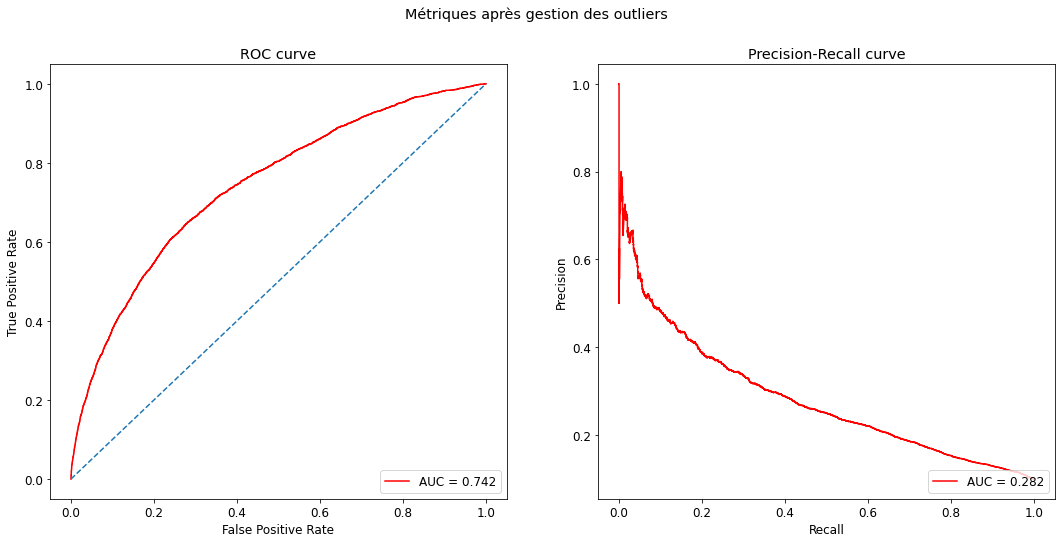

TRAIN SET: ROC AUC=0.744, PR AUC=0.282
TEST SET:  ROC AUC=0.741, PR AUC=0.283


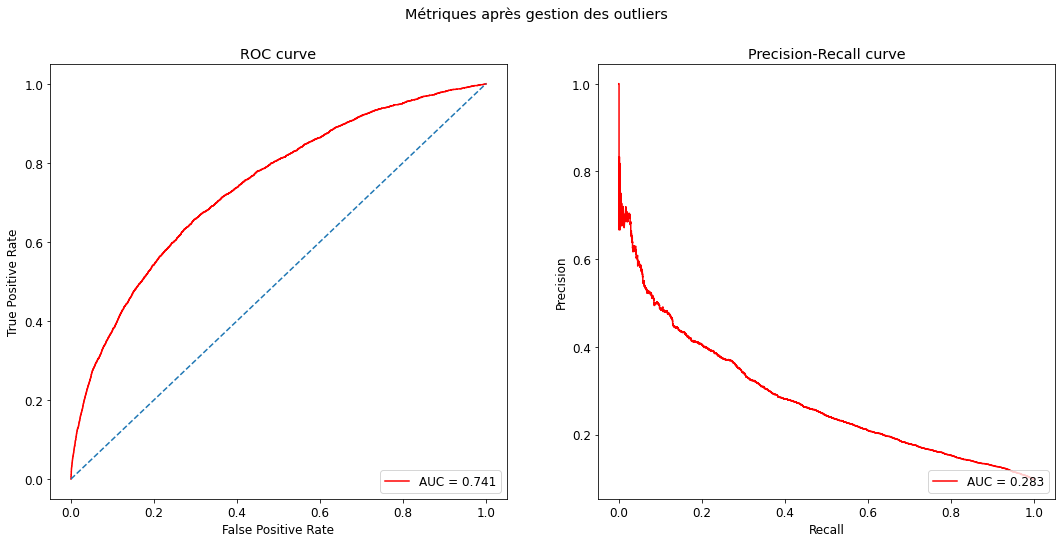

TRAIN SET: ROC AUC=0.743, PR AUC=0.280
TEST SET:  ROC AUC=0.749, PR AUC=0.295


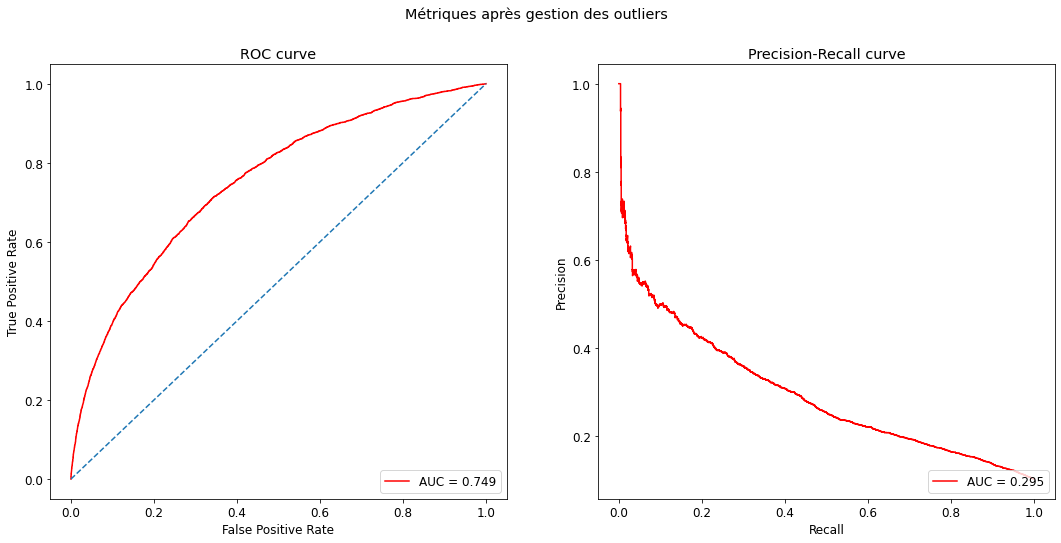

ROC AUC = 0.744
PR AUC  = 0.287


In [105]:
evalDataPreparation(dfApplicationWorked,label='Métriques après gestion des outliers')

## Expérimentation avec les variables catégorielles

Numérisation de toutes les variables catégorielles du jeu de données par défaut

In [69]:
import pickle
dfApplicationDefault = load(open('ApplicationDefault.pkl','rb'))
listDtypes = dfApplicationDefault.dtypes
listCat = list(listDtypes[listDtypes == 'object'].index)
listNum = list(listDtypes[listDtypes != 'object'].index)
for num in listNum:
    if (num != 'TARGET') & (num != 'SK_ID_CURR'):
        del dfApplicationDefault[num]
for cat in listCat:
    DicoRatio={}
    DicoNbPos = {}
    DicoNbTot = {}
    for val in dfApplicationDefault[cat].unique():
        NbPositive = dfApplicationDefault[(dfApplicationDefault[cat] == val) & (dfApplicationDefault.TARGET == 1)].shape[0]
        NbTotal = dfApplicationDefault[dfApplicationDefault[cat] == val].shape[0]
        ratio = round(NbPositive / (NbTotal+0.1) * 100, 1)
        DicoRatio[val] = ratio
        DicoNbPos[val] = NbPositive
        DicoNbTot[val] = NbTotal
        ratioCat = pd.DataFrame({'valeur': list(DicoRatio.keys()), 'ratioPos':list(DicoRatio.values()), 'nbPos': list(DicoNbPos.values()), 'nbTot': list(DicoNbTot.values())}).sort_values('ratioPos', ascending=False)
    dfApplicationDefault = dfApplicationDefault.merge(ratioCat[['valeur','ratioPos']], left_on=cat, right_on='valeur')
    dfApplicationDefault = dfApplicationDefault.rename(columns={'ratioPos':cat+'_RATIO'})
    del dfApplicationDefault[cat]
    del dfApplicationDefault['valeur']

TRAIN SET: ROC AUC=0.625, PR AUC=0.133
TEST SET:  ROC AUC=0.623, PR AUC=0.129


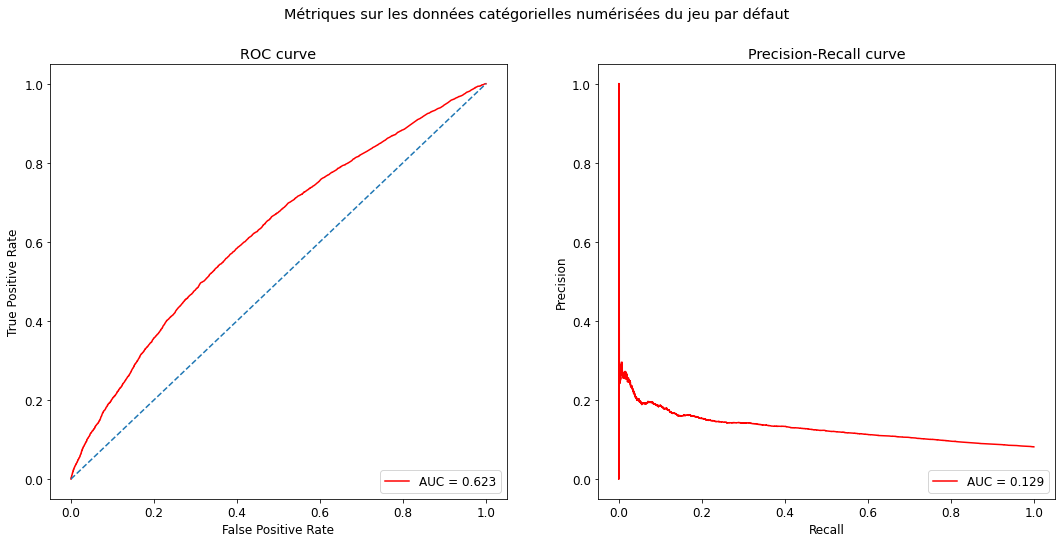

TRAIN SET: ROC AUC=0.623, PR AUC=0.132
TEST SET:  ROC AUC=0.631, PR AUC=0.133


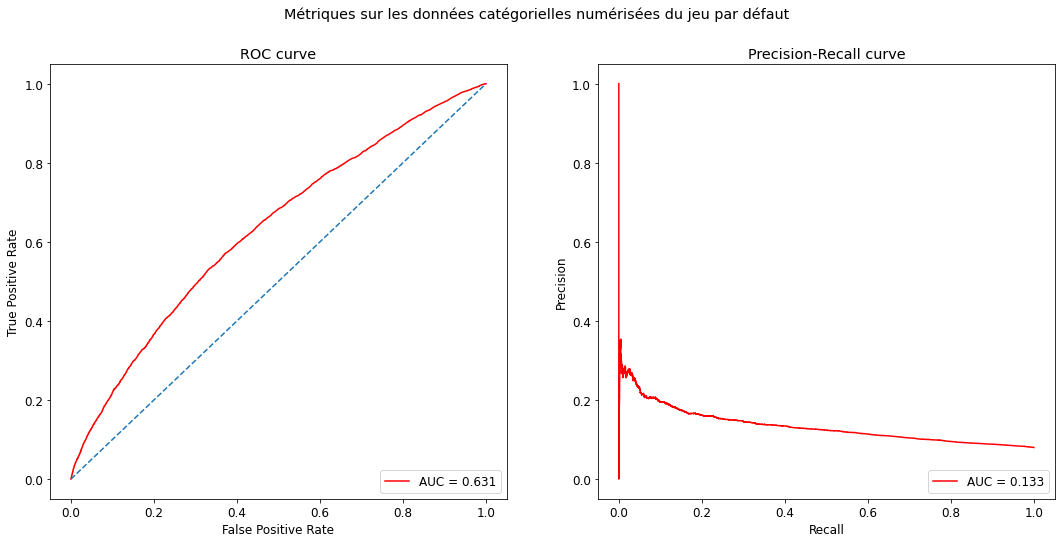

TRAIN SET: ROC AUC=0.624, PR AUC=0.133
TEST SET:  ROC AUC=0.627, PR AUC=0.129


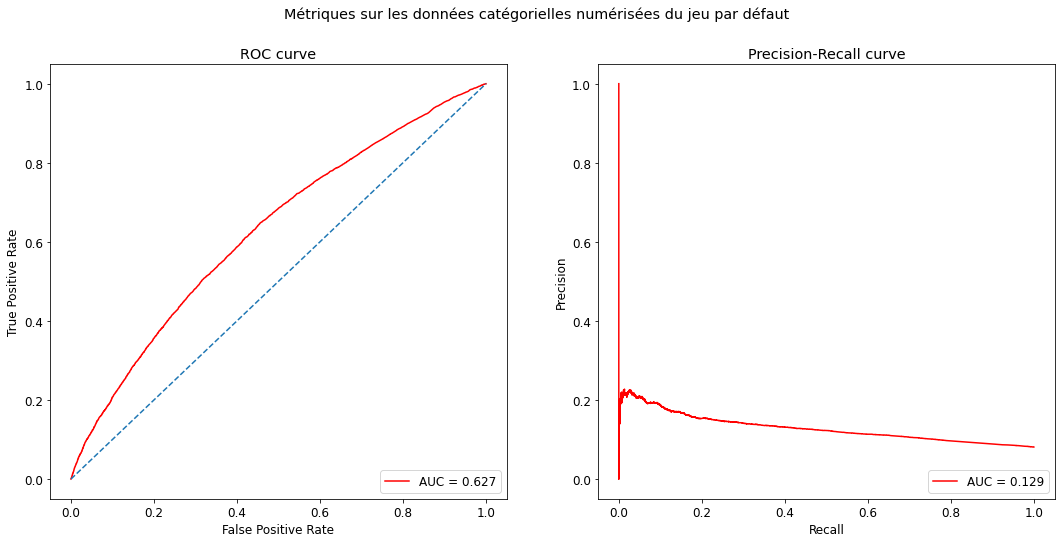

In [70]:
evalDataPreparation(dfApplicationDefault,label='Métriques sur les données catégorielles numérisées du jeu par défaut')

In [71]:
dfTrain, dfTest = train_test_split(dfApplicationDefault, test_size=0.2, random_state=42)
y_train = dfTrain['TARGET'].values
y_test = dfTest['TARGET'].values
del dfTrain['TARGET']
del dfTest['TARGET']
del dfTrain['SK_ID_CURR']
del dfTest['SK_ID_CURR']
X_train = dfTrain.values
X_test = dfTest.values

imp=feature_importance(X_train, y_train, dfTrain.columns)

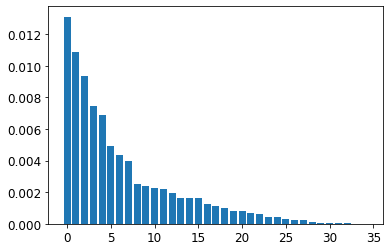

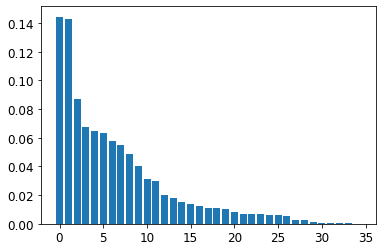

In [72]:
plt.bar([x for x in range(len(imp))], imp['perm_imp'].sort_values(ascending=False))
plt.show()
plt.bar([x for x in range(len(imp))], imp['impMedian'].sort_values(ascending=False))
plt.show()

In [73]:
imp.sort_values('best_classement')

classement                                 feature   impMean  impMedian  \
0            1                   OCCUPATION_TYPE_RATIO  0.141300   0.144394   
1            2         PREV_NAME_CONTRACT_STATUS_RATIO  0.144052   0.143088   
2            3                 ORGANIZATION_TYPE_RATIO  0.085752   0.086920   
6            7                BURO_CREDIT_ACTIVE_RATIO  0.058064   0.057391   
3            4               NAME_EDUCATION_TYPE_RATIO  0.065774   0.067285   
4            5          PREV_PRODUCT_COMBINATION_RATIO  0.065525   0.064740   
8            9                       CODE_GENDER_RATIO  0.047869   0.048423   
5            6           PREV_CODE_REJECT_REASON_RATIO  0.063882   0.063016   
7            8                  NAME_INCOME_TYPE_RATIO  0.053546   0.054841   
9           10            PREV_NAME_PRODUCT_TYPE_RATIO  0.042855   0.040539   
12          13                NAME_FAMILY_STATUS_RATIO  0.020139   0.019778   
10          11             PREV_NAME_YIELD_GROUP_RATIO  0.031433   0.031169   
19          20             PREV_NAME_CLIENT_TYPE_RATIO  0.010918   0.010516   
11          12       PREV_NAME_CASH_LOAN_PURPOSE_RATIO  0.029332   0.029951   
13          14                  BURO_CREDIT_TYPE_RATIO  0.018183   0.018016   
17          18                      FLAG_OWN_CAR_RATIO  0.011447   0.011343   
14          15               EMERGENCYSTATE_MODE_RATIO  0.015725   0.015547   
15          16                WALLSMATERIAL_MODE_RATIO  0.013451   0.013529   
16          17                    HOUSETYPE_MODE_RATIO  0.012395   0.012701   
18          19              BURO_CREDIT_CURRENCY_RATIO  0.011795   0.010762   
25          26                NAME_CONTRACT_TYPE_RATIO  0.006346   0.006265   
20          21                 NAME_HOUSING_TYPE_RATIO  0.008301   0.008340   
21          22          PREV_NAME_GOODS_CATEGORY_RATIO  0.007260   0.007159   
22          23         PREV_NAME_SELLER_INDUSTRY_RATIO  0.007293   0.007153   
23          24           PREV_NAME_CONTRACT_TYPE_RATIO  0.006536   0.006640   
24          25               PREV_NAME_PORTFOLIO_RATIO  0.006796   0.006420   
26          27                 PREV_CHANNEL_TYPE_RATIO  0.005087   0.005091   
27          28              PREV_NAME_TYPE_SUITE_RATIO  0.002553   0.002613   
28          29                FONDKAPREMONT_MODE_RATIO  0.002501   0.002557   
29          30   PREV_WEEKDAY_APPR_PROCESS_START_RATIO  0.000937   0.000938   
30          31            PREV_NAME_PAYMENT_TYPE_RATIO  0.000802   0.000750   
31          32                   NAME_TYPE_SUITE_RATIO  0.000785   0.000735   
32          33        WEEKDAY_APPR_PROCESS_START_RATIO  0.000596   0.000562   
33          34  PREV_FLAG_LAST_APPL_PER_CONTRACT_RATIO  0.000530   0.000519   
34          35                   FLAG_OWN_REALTY_RATIO  0.000240   0.000206   

      impQ75    impMax  perm_classement  perm_imp  diff_classement  \
0   0.145663  0.151098                1  0.013115                0   
1   0.151436  0.158065                2  0.010895                0   
2   0.090491  0.092325                6  0.004925                3   
6   0.059269  0.066428                3  0.009358                4   
3   0.068304  0.069770                4  0.007461                0   
4   0.069156  0.076609                7  0.004363                2   
8   0.050495  0.052832                5  0.006872                4   
5   0.068643  0.072782                8  0.004000                2   
7   0.057284  0.059765                9  0.002534                1   
9   0.047686  0.053401               15  0.001648                5   
12  0.021099  0.024485               10  0.002422                3   
10  0.032600  0.036653               12  0.002182                1   
19  0.011850  0.013070               11  0.002237                9   
11  0.031269  0.031843               19  0.000988                7   
13  0.018963  0.020398               13  0.001972                1   
17  0.012148  0.015449               14

In [74]:
for index, row in imp.iterrows():
    if row.best_classement <= 6:
        dfApplicationWorked = dfApplicationWorked.merge(dfApplicationDefault[['SK_ID_CURR',row.feature]], left_on='SK_ID_CURR', right_on='SK_ID_CURR')

TRAIN SET: ROC AUC=0.745, PR AUC=0.285
TEST SET:  ROC AUC=0.741, PR AUC=0.283


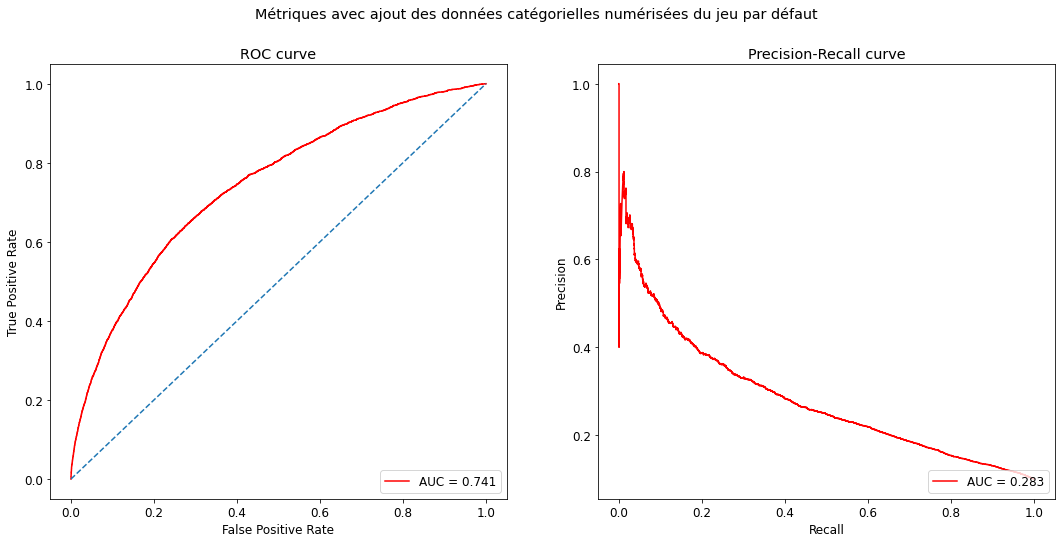

TRAIN SET: ROC AUC=0.745, PR AUC=0.284
TEST SET:  ROC AUC=0.742, PR AUC=0.282


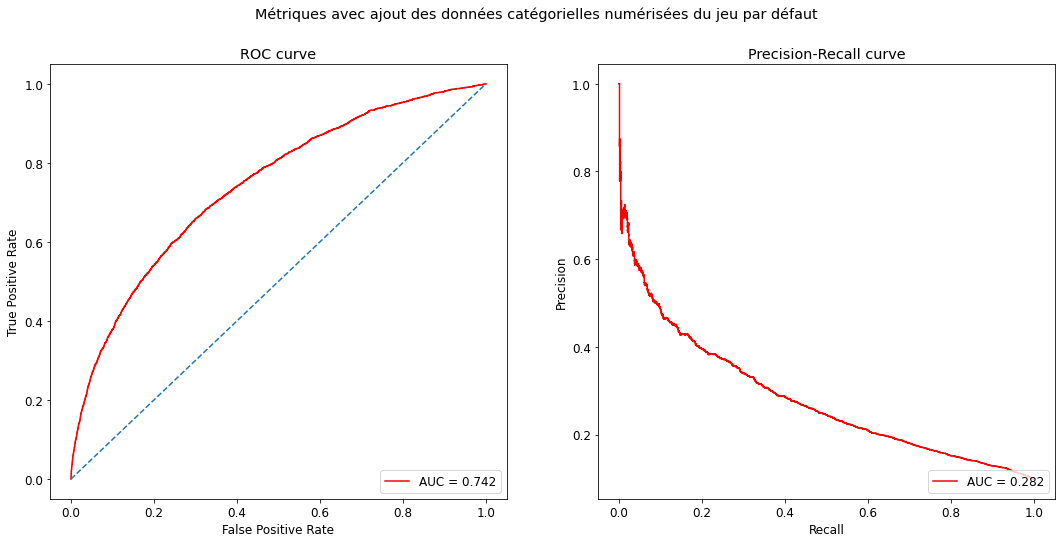

TRAIN SET: ROC AUC=0.743, PR AUC=0.279
TEST SET:  ROC AUC=0.749, PR AUC=0.293


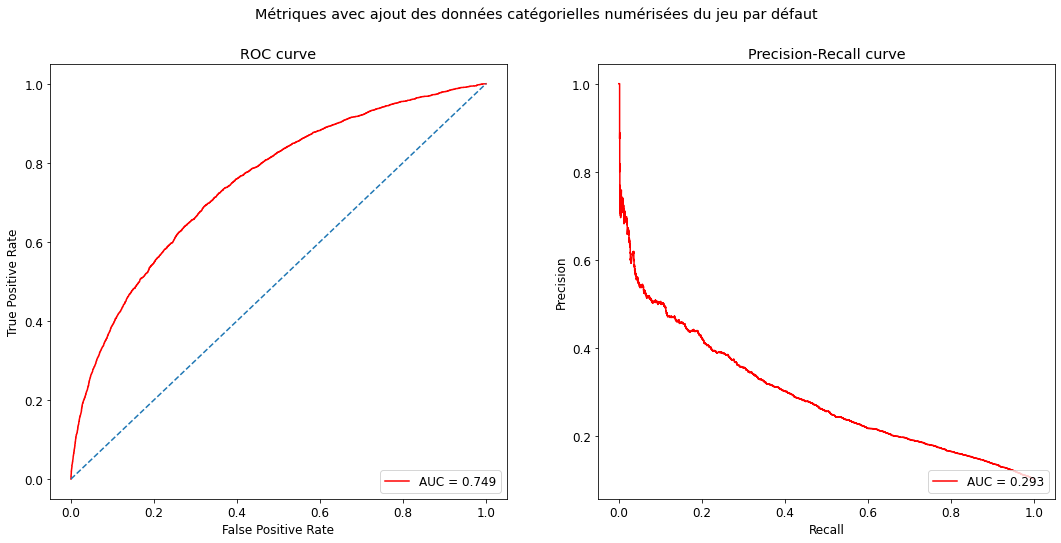

In [75]:
evalDataPreparation(dfApplicationWorked,label='Métriques avec ajout des données catégorielles numérisées du jeu par défaut')

In [77]:
df = transformDf(dfApplicationWorked)
y = df['TARGET'].values
del df['TARGET']
del df['SK_ID_CURR']
X = df.values
imp=feature_importance(X, y, df.columns)

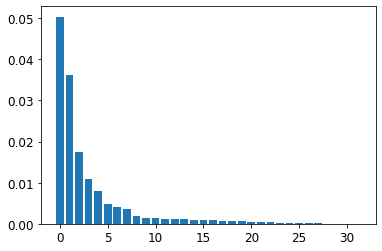

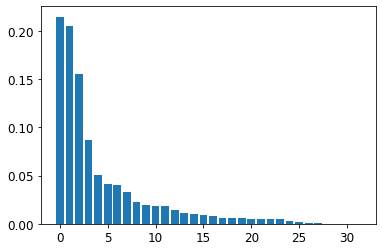

In [78]:
plt.bar([x for x in range(len(imp))], imp['perm_imp'].sort_values(ascending=False))
plt.show()
plt.bar([x for x in range(len(imp))], imp['impMedian'].sort_values(ascending=False))
plt.show()

In [79]:
imp.sort_values('best_classement')

classement                                            feature   impMean  \
0            1                                       EXT_SOURCE_2  0.213955   
1            2                                       EXT_SOURCE_3  0.204037   
2            3  INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG  0.152626   
3            4       INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS  0.088030   
4            5                           DEFAULT_PREV_CNT_PAYMENT  0.050382   
5            6                               DEFAULT_EXT_SOURCE_1  0.041375   
8            9              DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE  0.022158   
6            7                    PREV_NAME_CONTRACT_STATUS_RATIO  0.040057   
7            8                                   BURO_DAYS_CREDIT  0.034958   
9           10                          PREV_NAME_CONTRACT_STATUS  0.018320   
10          11                    DEFAULT_BURO_DAYS_CREDIT_UPDATE  0.019196   
12          13                   BURO_DAYS_CREDIT_ENDDATE_NEG_LOG  0.014529   
11          12                                     PREV_DAYS_DIFF  0.018115   
18          19                                        CODE_GENDER  0.005549   
15          16                              PREV_NAME_YIELD_GROUP  0.008895   
13          14                     DEFAULT_BURO_DAYS_ENDDATE_FACT  0.010987   
16          17                                         DAYS_BIRTH  0.008158   
14          15                                 PREV_DAYS_DECISION  0.009618   
22          23                                  CODE_GENDER_RATIO  0.004634   
17          18                                 BURO_CREDIT_ACTIVE  0.006477   
21          22                                      DAYS_EMPLOYED  0.004590   
19          20                  DEFAULT_PREV_AMT_DOWN_PAYMENT_LOG  0.005469   
20          21                            DEFAULT_AMT_GOODS_PRICE  0.005199   
24          25                                  ORGANIZATION_TYPE  0.003410   
23          24                    BURO_AMT_CREDIT_MAX_OVERDUE_LOG  0.004664   
27          28                     PREV_PRODUCT_COMBINATION_RATIO  0.001027   
25          26                   BURO_DAYS_CREDIT_ENDDATE_POS_LOG  0.002069   
26          27                      PREV_CODE_REJECT_REASON_RATIO  0.001229   
28          29                              OCCUPATION_TYPE_RATIO  0.000169   
29          30                            ORGANIZATION_TYPE_RATIO  0.000073   
30          31                          NAME_EDUCATION_TYPE_RATIO  0.000046   
31          32                           BURO_CREDIT_ACTIVE_RATIO  0.000000   

    impMedian    impQ75    impMax  perm_classement  perm_imp  diff_classement  \
0    0.215029  0.218055  0.220618                1  0.050345                0   
1    0.204896  0.207165  0.208199                2  0.036092                0   
2    0.155126  0.159961  0.161300                3  0.017531                0   
3    0.086649  0.090542  0.097520                7  0.004151                3   
4    0.050536  0.051299  0.055279                4  0.010837                1   
5    0.041507  0.043607  0.045926                5  0.008032                1   
8    0.022217  0.023205  0.025081                6  0.004793                3   
6    0.040070  0.041534  0.044216                8  0.003550                1   
7    0.033326  0.036514  0.041428                9  0.001863                1   
9    0.019080  0.019987  0.021449               10  0.001331                0   
10   0.018940  0.021130  0.021687               17  0.000825                6   
12   0.014427  0.016283  0.017653               11  0.001305                2   
11   0.018111  0.020322  0.021736               13  0.001193                1   
18   0.005675  0.006028  0.006995               12  0.001241                7   
15   0.009047  0.009412  0.009500               14  0.001059                2   
13   0.011264  0.011867  0.012367               26  0.000157               12   
16   0.007831  0.00

## Essai sans les deux meilleures variables

In [80]:
dfApplicationWorkedWithoutBestFeat = dfApplicationWorked.copy()
del dfApplicationWorkedWithoutBestFeat['EXT_SOURCE_3']
del dfApplicationWorkedWithoutBestFeat['EXT_SOURCE_2']

TRAIN SET: ROC AUC=0.706, PR AUC=0.244
TEST SET:  ROC AUC=0.695, PR AUC=0.240


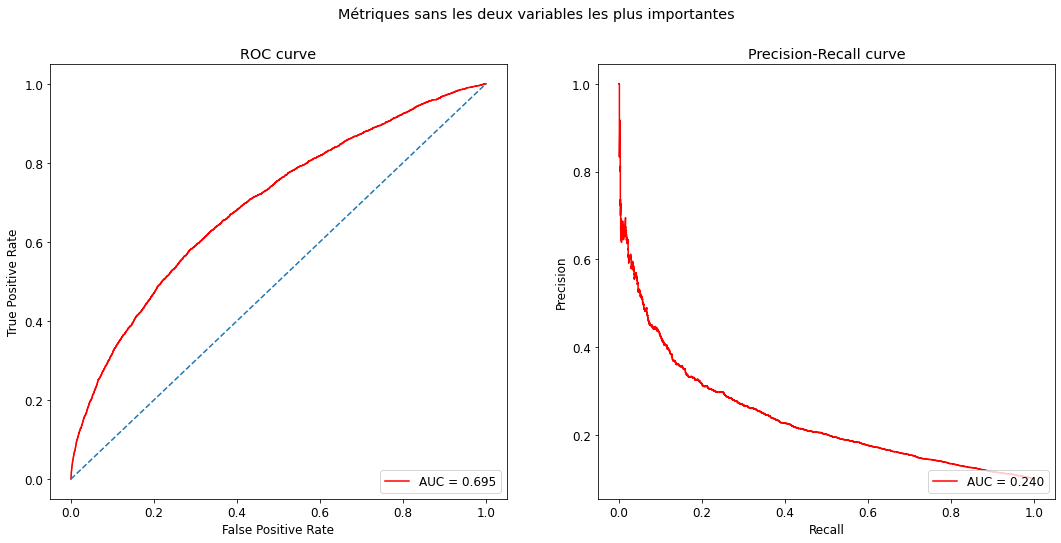

TRAIN SET: ROC AUC=0.703, PR AUC=0.242
TEST SET:  ROC AUC=0.703, PR AUC=0.244


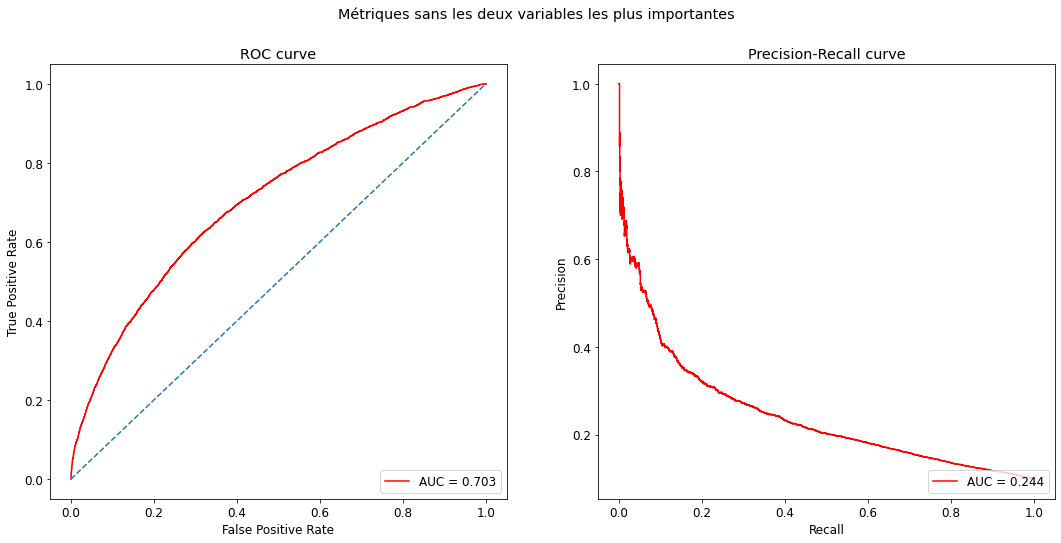

TRAIN SET: ROC AUC=0.700, PR AUC=0.240
TEST SET:  ROC AUC=0.708, PR AUC=0.249


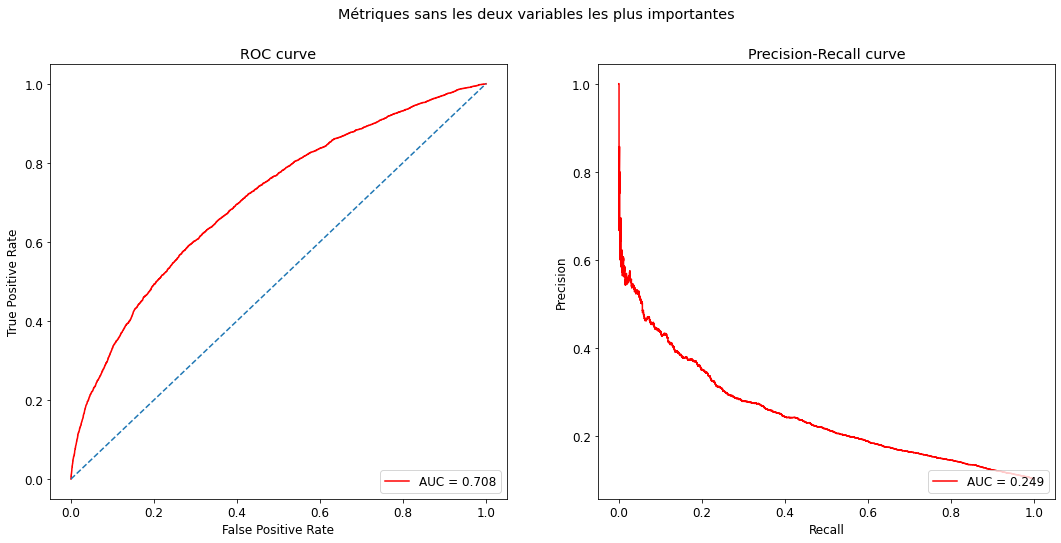

In [81]:
evalDataPreparation(dfApplicationWorkedWithoutBestFeat,label='Métriques sans les deux variables les plus importantes')

In [82]:
df = transformDf(dfApplicationWorkedWithoutBestFeat)
y = df['TARGET'].values
del df['TARGET']
del df['SK_ID_CURR']
X = df.values
imp=feature_importance(X, y, df.columns)

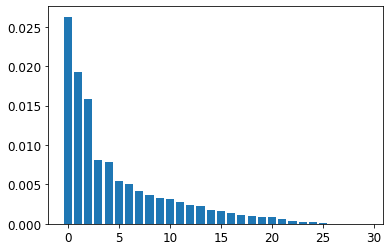

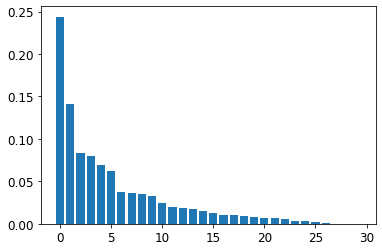

In [83]:
plt.bar([x for x in range(len(imp))], imp['perm_imp'].sort_values(ascending=False))
plt.show()
plt.bar([x for x in range(len(imp))], imp['impMedian'].sort_values(ascending=False))
plt.show()

In [84]:
imp.sort_values('best_classement')

classement                                            feature   impMean  \
0            1  INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG  0.244258   
1            2       INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS  0.141104   
3            4                               DEFAULT_EXT_SOURCE_1  0.080796   
2            3                           DEFAULT_PREV_CNT_PAYMENT  0.084789   
6            7              DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE  0.037252   
4            5                    PREV_NAME_CONTRACT_STATUS_RATIO  0.069379   
5            6                                   BURO_DAYS_CREDIT  0.061519   
7            8                          PREV_NAME_CONTRACT_STATUS  0.036574   
15          16                    BURO_AMT_CREDIT_MAX_OVERDUE_LOG  0.013278   
8            9                    DEFAULT_BURO_DAYS_CREDIT_UPDATE  0.035135   
9           10                                     PREV_DAYS_DIFF  0.031908   
14          15                                         DAYS_BIRTH  0.015854   
10          11                   BURO_DAYS_CREDIT_ENDDATE_NEG_LOG  0.024563   
11          12                     DEFAULT_BURO_DAYS_ENDDATE_FACT  0.019152   
12          13                                 PREV_DAYS_DECISION  0.019341   
13          14                              PREV_NAME_YIELD_GROUP  0.017664   
20          21                                  CODE_GENDER_RATIO  0.007248   
18          19                  DEFAULT_PREV_AMT_DOWN_PAYMENT_LOG  0.009646   
16          17                                 BURO_CREDIT_ACTIVE  0.010731   
17          18                            DEFAULT_AMT_GOODS_PRICE  0.010685   
21          22                                        CODE_GENDER  0.007040   
19          20                                      DAYS_EMPLOYED  0.007730   
22          23                                  ORGANIZATION_TYPE  0.005377   
23          24                   BURO_DAYS_CREDIT_ENDDATE_POS_LOG  0.003481   
24          25                      PREV_CODE_REJECT_REASON_RATIO  0.002938   
25          26                     PREV_PRODUCT_COMBINATION_RATIO  0.001914   
26          27                              OCCUPATION_TYPE_RATIO  0.000384   
27          28                            ORGANIZATION_TYPE_RATIO  0.000162   
28          29                          NAME_EDUCATION_TYPE_RATIO  0.000090   
29          30                           BURO_CREDIT_ACTIVE_RATIO  0.000007   

    impMedian    impQ75    impMax  perm_classement  perm_imp  diff_classement  \
0    0.243961  0.246796  0.255422                1  0.026287                0   
1    0.140931  0.143923  0.145964                6  0.005494                4   
3    0.080336  0.082754  0.085193                2  0.019231                2   
2    0.083355  0.085980  0.092801                3  0.015794                0   
6    0.037468  0.038994  0.040978                4  0.008156                3   
4    0.069599  0.070748  0.074494                5  0.007880                0   
5    0.062207  0.064228  0.069529                7  0.005075                1   
7    0.036705  0.038372  0.041866               10  0.003321                2   
15   0.013292  0.014296  0.015695                8  0.004147                8   
8    0.035326  0.036114  0.039125               14  0.002234                5   
9    0.032886  0.034656  0.037944                9  0.003675                1   
14   0.015654  0.017035  0.019896               11  0.003203                4   
10   0.025078  0.025856  0.028718               12  0.002721                1   
11   0.019753  0.020494  0.020846               24  0.000209               12   
12   0.018892  0.020352  0.023057               15  0.001710                2   
13   0.017733  0.018021  0.018578               13  0.002371                1   
20   0.007075  0.007306  0.009950               16  0.001566                5   
18   0.009702  0.010115  0.010344               17  0.001328                2   
16   0.010675  

## Impact des features sur les courbes ROC et PR

In [85]:
df = dfApplicationWorked[['SK_ID_CURR','TARGET']].copy()
feature_lst = []
roc_auc_train_lst = []
roc_auc_test_lst = []
roc_pr_train_lst = []
roc_pr_test_lst = []

for index, row in imp.iterrows():

    df = df.merge(dfApplicationWorked[['SK_ID_CURR',row.feature]], left_on='SK_ID_CURR', right_on='SK_ID_CURR')

    df = transformDf(df)
    df = df.sort_values('SK_ID_CURR', ascending=True).reset_index(drop=True)
    #df = shuffleDf(df)

    dfTrain, dfTest = train_test_split(df, test_size=0.2, random_state=42)
    y_train = dfTrain['TARGET'].values
    y_test = dfTest['TARGET'].values
    del dfTrain['TARGET']
    del dfTest['TARGET']
    del dfTrain['SK_ID_CURR']
    del dfTest['SK_ID_CURR']
    X_train = dfTrain.values
    X_test = dfTest.values

    model = RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1)
    duration_training, duration_pred_train, roc_auc_train, pr_auc_train, duration_pred_test, roc_auc_test, pr_auc_test, feature_imp = metrics_model(model, X_train, y_train, X_test, y_test, display_plot=False, calc_feat_imp = False, features = [], label_model = 'Métriques avec ajout des données catégorielles numérisées du jeu par défaut')
    feature_lst.append(row.feature)
    roc_auc_train_lst.append(roc_auc_train)
    roc_auc_test_lst.append(roc_auc_test)
    roc_pr_train_lst.append(pr_auc_train)
    roc_pr_test_lst.append(pr_auc_test)

dfFeatImp = pd.DataFrame({'feature':feature_lst,'roc_auc_train':roc_auc_train_lst,'roc_auc_test':roc_auc_test_lst,'pr_auc_train':roc_pr_train_lst,'pr_auc_test':roc_pr_test_lst})

In [86]:
dfFeatImp

feature  roc_auc_train  \
0   INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG       0.592562   
1        INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS       0.595702   
2                            DEFAULT_PREV_CNT_PAYMENT       0.628430   
3                                DEFAULT_EXT_SOURCE_1       0.659666   
4                     PREV_NAME_CONTRACT_STATUS_RATIO       0.668648   
5                                    BURO_DAYS_CREDIT       0.680695   
6               DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE       0.685008   
7                           PREV_NAME_CONTRACT_STATUS       0.686454   
8                     DEFAULT_BURO_DAYS_CREDIT_UPDATE       0.686095   
9                                      PREV_DAYS_DIFF       0.688451   
10                   BURO_DAYS_CREDIT_ENDDATE_NEG_LOG       0.689435   
11                     DEFAULT_BURO_DAYS_ENDDATE_FACT       0.689699   
12                                 PREV_DAYS_DECISION       0.690907   
13                              PREV_NAME_YIELD_GROUP       0.693828   
14                                         DAYS_BIRTH       0.695419   
15                    BURO_AMT_CREDIT_MAX_OVERDUE_LOG       0.697012   
16                                 BURO_CREDIT_ACTIVE       0.697348   
17                            DEFAULT_AMT_GOODS_PRICE       0.697992   
18                  DEFAULT_PREV_AMT_DOWN_PAYMENT_LOG       0.699268   
19                                      DAYS_EMPLOYED       0.699464   
20                                  CODE_GENDER_RATIO       0.702347   
21                                        CODE_GENDER       0.701280   
22                                  ORGANIZATION_TYPE       0.702753   
23                   BURO_DAYS_CREDIT_ENDDATE_POS_LOG       0.701671   
24                      PREV_CODE_REJECT_REASON_RATIO       0.701305   
25                     PREV_PRODUCT_COMBINATION_RATIO       0.701044   
26                              OCCUPATION_TYPE_RATIO       0.701408   
27                            ORGANIZATION_TYPE_RATIO       0.702592   
28                          NAME_EDUCATION_TYPE_RATIO       0.703652   
29                           BURO_CREDIT_ACTIVE_RATIO       0.703619   

    roc_auc_test  pr_auc_train  pr_auc_test  
0       0.589562      0.178732     0.170886  
1       0.594975      0.193504     0.189300  
2       0.620605      0.207597     0.199791  
3       0.658210      0.225227     0.219107  
4       0.666570      0.231259     0.221173  
5       0.679977      0.238546     0.232497  
6       0.682784      0.245329     0.237031  
7       0.683649      0.243031     0.234571  
8       0.683491      0.245858     0.238510  
9       0.683808      0.244537     0.237896  
10      0.685637      0.244767     0.237738  
11      0.684638      0.241414     0.235871  
12      0.685471      0.241842     0.235283  
13      0.686866      0.242629     0.235929  
14      0.690251      0.244057     0.233555  
15      0.692511      0.248276     0.237768  
16      0.693067      0.247299     0.239087  
17      0.692730      0.247271     0.239718  
18      0.694107      0.246281     0.240462  
19      0.696272      0.245027     0.237256  
20      0.696992      0.246275     0.240070  
21      0.696114      0.242853     0.238915  
22      0.697333      0.244348     0.237835  
23      0.698298      0.241976     0.239667  
24      0.696419      0.246795     0.239730  
25      0.696033      0.245768     0.238206  
26      0.695634      0.245582     0.237788  
27      0.697085      0.245983     0.238904  
28      0.697470      0.244806     0.237283  
29      0.698819      0.243054     0.236445

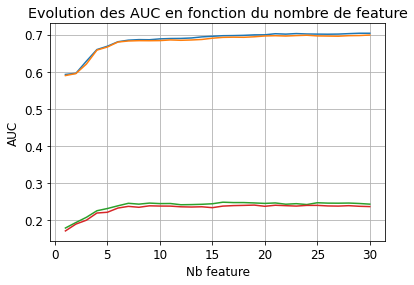

In [87]:
x = np.arange(dfFeatImp.shape[0]) + 1
plt.plot(x, dfFeatImp.roc_auc_train) 
plt.plot(x, dfFeatImp.roc_auc_test) 
plt.plot(x, dfFeatImp.pr_auc_train) 
plt.plot(x, dfFeatImp.pr_auc_test) 
plt.xlabel('Nb feature')
plt.ylabel('AUC')
plt.title('Evolution des AUC en fonction du nombre de feature')
plt.grid(True)
plt.show() 

## Optimisation globale du scaler

TRAIN SET: ROC AUC=0.746, PR AUC=0.285
TEST SET:  ROC AUC=0.737, PR AUC=0.275


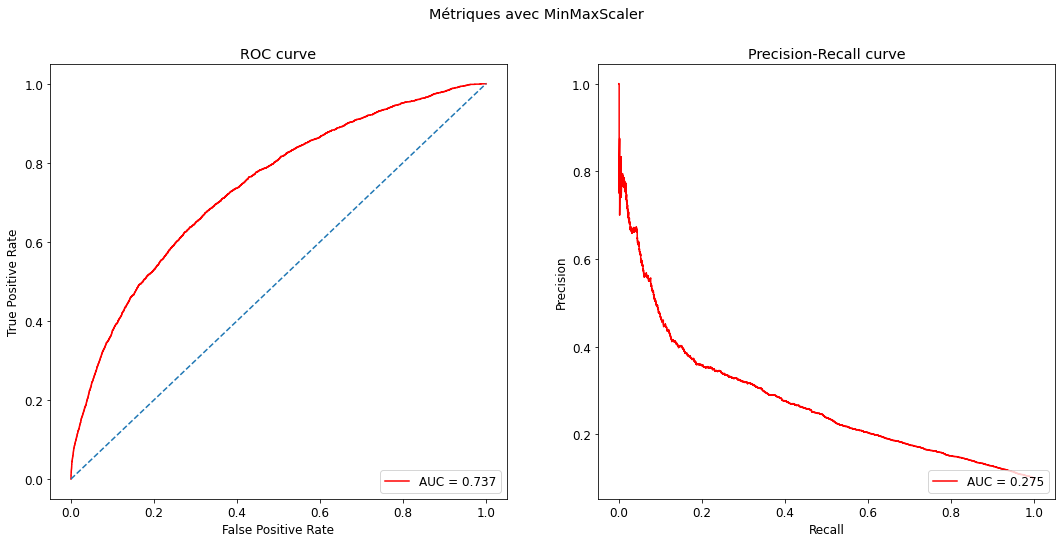

TRAIN SET: ROC AUC=0.745, PR AUC=0.284
TEST SET:  ROC AUC=0.738, PR AUC=0.277


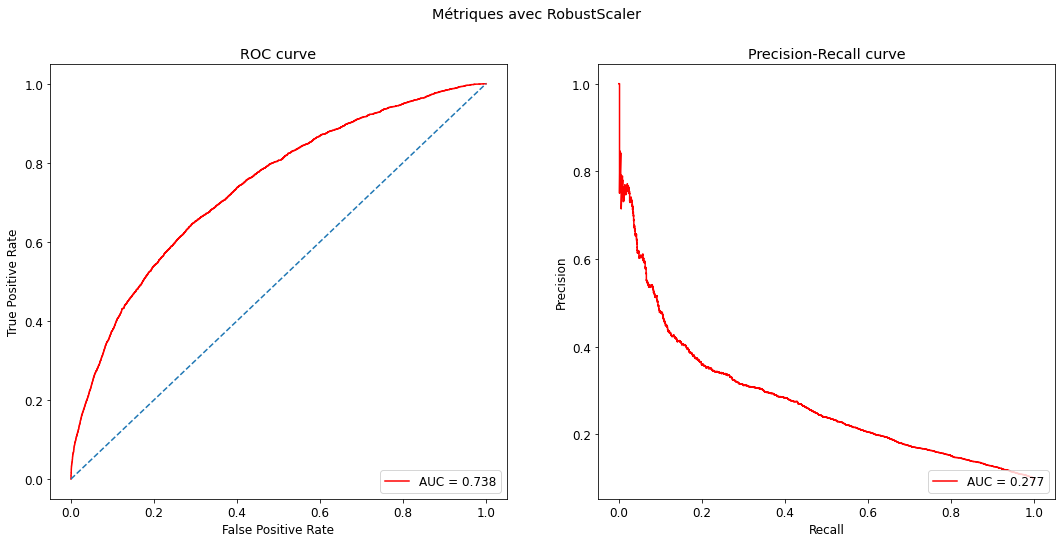

TRAIN SET: ROC AUC=0.746, PR AUC=0.286
TEST SET:  ROC AUC=0.737, PR AUC=0.275


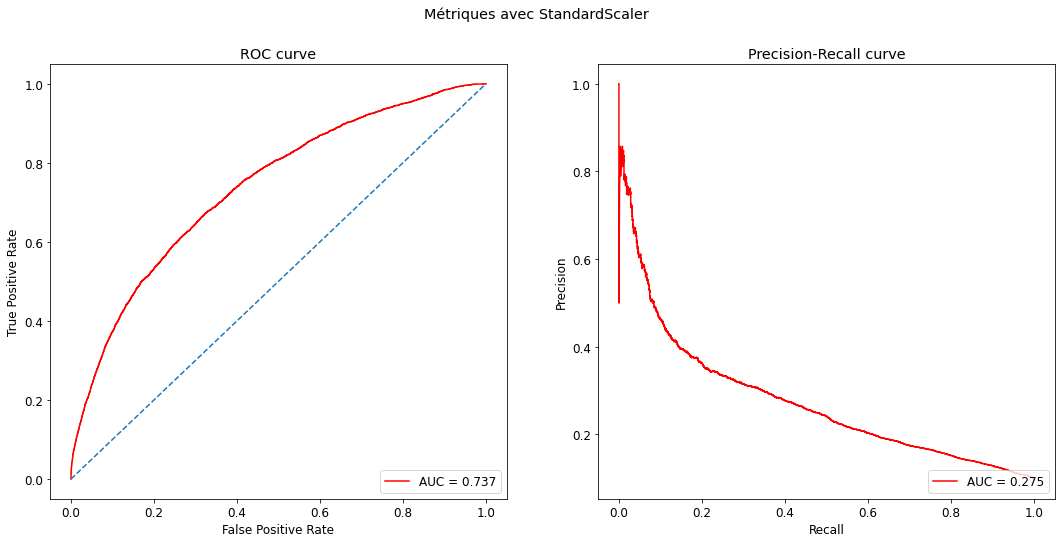

In [88]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

evalDataPreparation(dfApplicationWorked,label='Métriques avec MinMaxScaler', scaler=MinMaxScaler(), random_state_list=[42])
evalDataPreparation(dfApplicationWorked,label='Métriques avec RobustScaler', scaler=RobustScaler(), random_state_list=[42])
evalDataPreparation(dfApplicationWorked,label='Métriques avec StandardScaler', scaler=StandardScaler(), random_state_list=[42])

## Recherche du meilleur scaler par variable

In [89]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

cols = []
MinMaxPR=[]
RobustPR = []
StandardPR = []
MinMaxROC=[]
RobustROC = []
StandardROC = []
BestScalerPR = []
BestScalerROC = []

for col in dfApplicationWorked.select_dtypes(include=['int64', 'float64']).columns:
    
    if (col not in ['SK_ID_CURR','TARGET']):
        
        cols.append(col)
        
        df = dfApplicationWorked[[col,'TARGET']].copy()
        df = df.dropna()
        scaler = MinMaxScaler()        
        df[col] = scaler.fit_transform(df[[col]])
        dfTrain, dfTest = train_test_split(df, test_size=0.2, random_state=42)
        y_train = dfTrain['TARGET'].values
        y_test = dfTest['TARGET'].values
        del dfTrain['TARGET']
        del dfTest['TARGET']
        X_train = dfTrain.values
        X_test = dfTest.values        
        model = RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1)     
        duration_training, duration_pred_train, roc_auc_train_m, pr_auc_train_m, duration_pred_test, roc_auc_test_m, pr_auc_test_m, feature_imp = metrics_model(model, X_train, y_train, X_test, y_test, display_plot=False, calc_feat_imp = False, features = [])
        MinMaxPR.append(pr_auc_test_m)
        MinMaxROC.append(roc_auc_test_m)
        
        df = dfApplicationWorked[[col,'TARGET']].copy()
        df = df.dropna()
        scaler = RobustScaler()        
        df[col] = scaler.fit_transform(df[[col]])
        dfTrain, dfTest = train_test_split(df, test_size=0.2, random_state=42)
        y_train = dfTrain['TARGET'].values
        y_test = dfTest['TARGET'].values
        del dfTrain['TARGET']
        del dfTest['TARGET']
        X_train = dfTrain.values
        X_test = dfTest.values          
        model = RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1)       
        duration_training, duration_pred_train, roc_auc_train_r, pr_auc_train_r, duration_pred_test, roc_auc_test_r, pr_auc_test_r, feature_imp = metrics_model(model, X_train, y_train, X_test, y_test, display_plot=False, calc_feat_imp = False, features = [])
        RobustPR.append(pr_auc_test_r)
        RobustROC.append(roc_auc_test_r)
        
        df = dfApplicationWorked[[col,'TARGET']].copy()
        df = df.dropna()
        scaler = StandardScaler()
        df[col] = scaler.fit_transform(df[[col]])
        dfTrain, dfTest = train_test_split(df, test_size=0.2, random_state=42)
        y_train = dfTrain['TARGET'].values
        y_test = dfTest['TARGET'].values
        del dfTrain['TARGET']
        del dfTest['TARGET']
        X_train = dfTrain.values
        X_test = dfTest.values          
        model = RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1)      
        duration_training, duration_pred_train, roc_auc_train_s, pr_auc_train_s, duration_pred_test, roc_auc_test_s, pr_auc_test_s, feature_imp = metrics_model(model, X_train, y_train, X_test, y_test, display_plot=False, calc_feat_imp = False, features = [])
        StandardPR.append(pr_auc_test_s)
        StandardROC.append(roc_auc_test_s)
        
        if (pr_auc_test_m > pr_auc_test_r) and (pr_auc_test_m > pr_auc_test_s):
            pr_best_scaler = 'MinMax'
        elif pr_auc_test_r > pr_auc_test_s:
            pr_best_scaler = 'Robust'
        elif (pr_auc_test_s > pr_auc_test_r) and (pr_auc_test_s > pr_auc_test_m):
            pr_best_scaler = 'Standard'
        else:
            pr_best_scaler = 'None'
        BestScalerPR.append(pr_best_scaler)
            
        if (roc_auc_test_m > roc_auc_test_r) and (roc_auc_test_m > roc_auc_test_s):
            roc_best_scaler = 'MinMax'
        elif roc_auc_test_r > roc_auc_test_s:
            roc_best_scaler = 'Robust'
        elif (roc_auc_test_s > roc_auc_test_r) and (roc_auc_test_s > roc_auc_test_m):
            roc_best_scaler = 'Standard'
        else:
            roc_best_scaler = 'None'
        BestScalerROC.append(roc_best_scaler)
        
dfScaler = pd.DataFrame({'column':cols, 'MinMaxPR': MinMaxPR, 'RobustPR': RobustPR, 'StandardPR': StandardPR, 'MinMaxROC': MinMaxROC, 'RobustROC': RobustROC, 'StandardROC': StandardROC, 'BestScalerPR': BestScalerPR, 'BestScalerROC': BestScalerROC})

robust = []
standard = []
minmax = []
for index, row in dfScaler.iterrows():
    if row.BestScalerPR == 'None':
        if row.BestScalerROC == 'None':
            minmax.append(row.column)
        else:
            if row.BestScalerROC == 'Robust':
                robust.append(row.column)
            elif row.BestScalerROC == 'Standard':
                standard.append(row.column)
            else:
                minmax.append(row.column)
    elif row.BestScalerPR == 'Robust':
        robust.append(row.column)
    elif row.BestScalerPR == 'Standard':
        standard.append(row.column)
    else:
        minmax.append(row.column)

In [90]:
dfScaler

column  MinMaxPR  RobustPR  \
0                                         CODE_GENDER  0.171008  0.171008   
1                                          DAYS_BIRTH  0.111928  0.112354   
2                                       DAYS_EMPLOYED  0.116754  0.116594   
3                                        EXT_SOURCE_2  0.167212  0.167091   
4                                        EXT_SOURCE_3  0.194913  0.194146   
5                                      PREV_DAYS_DIFF  0.123677  0.123807   
6                           PREV_NAME_CONTRACT_STATUS  0.133960  0.133378   
7                                  PREV_DAYS_DECISION  0.116246  0.116442   
8                               PREV_NAME_YIELD_GROUP  0.110685  0.110832   
9        INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS  0.147883  0.147975   
10                                 BURO_CREDIT_ACTIVE  0.123666  0.123471   
11                                   BURO_DAYS_CREDIT  0.130863  0.130902   
12                               DEFAULT_EXT_SOURCE_1  0.158136  0.158123   
13                    DEFAULT_BURO_DAYS_CREDIT_UPDATE  0.121935  0.121816   
14              DEFAULT_POSCASH_CNT_INSTALMENT_FUTURE  0.126736  0.126678   
15                           DEFAULT_PREV_CNT_PAYMENT  0.124978  0.124955   
16                     DEFAULT_BURO_DAYS_ENDDATE_FACT  0.112409  0.112605   
17                            DEFAULT_AMT_GOODS_PRICE  0.132759  0.133185   
18                    BURO_AMT_CREDIT_MAX_OVERDUE_LOG  0.107923  0.108228   
19  INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG_LOG  0.177836  0.177550   
20                  DEFAULT_PREV_AMT_DOWN_PAYMENT_LOG  0.106768  0.106551   
21                   BURO_DAYS_CREDIT_ENDDATE_POS_LOG  0.110291  0.110438   
22                   BURO_DAYS_CREDIT_ENDDATE_NEG_LOG  0.112932  0.112819   
23                              OCCUPATION_TYPE_RATIO  0.117669  0.117739   
24                    PREV_NAME_CONTRACT_STATUS_RATIO  0.147093  0.147093   
25                            ORGANIZATION_TYPE_RATIO  0.112445  0.112478   
26                          NAME_EDUCATION_TYPE_RATIO  0.109645  0.109626   
27                     PREV_PRODUCT_COMBINATION_RATIO  0.123990  0.123997   
28                      PREV_CODE_REJECT_REASON_RATIO  0.122919  0.122834   
29                           BURO_CREDIT_ACTIVE_RATIO  0.119872  0.119999   
30                                  CODE_GENDER_RATIO  0.171008  0.171008   

    StandardPR  MinMaxROC  RobustROC  StandardROC BestScalerPR BestScalerROC  
0     0.171008   0.540379   0.540379     0.540379         None          None  
1     0.111763   0.550955   0.553089     0.551551       Robust        Robust  
2     0.116490   0.570559   0.570839     0.571103       MinMax      Standard  
3     0.167183   0.645418   0.645365     0.645950       MinMax      Standard  
4     0.194762   0.677808   0.677732     0.678044       MinMax      Standard  
5     0.123312   0.557054   0.558029     0.555739       Robust        Robust  
6     0.133128   0.563003   0.563262     0.562909       MinMax        Robust  
7     0.116498   0.563923   0.564623     0.564168     Standard        Robust  
8     0.111077   0.538859   0.539038     0.539117     Standard      Standard  
9     0.147924   0.581970   0.580763     0.579752       Robust        MinMax  
10    0.123462   0.570195   0.569985     0.570328       MinMax      Standard  
11    0.130941   0.581061   0.580924     0.581085     Standard      Standard  
12    0.158550   0.645065   0.643565     0.645373     Standard      Standard  
13    0.122207   0.575144   0.575263     0.575382     Standard      Standard  
14    0.126947   0.559177   0.559334     0.560905     Standard      Standard  
15    0.124859   0.562515   0.562791     0.562650       MinMax        Robust  
16    0.112915   0.553710   0.554455     0.554082     Standard        Robust  
17    0.133378   0.581084   0.580537     0.580806     Standard        MinMax  
18    0.107952   0.521799   0.520683     0.521235       Robust        MinMax  
19

In [91]:
from collections import Counter
print('Precision-Recall:')
print(Counter(dfScaler.BestScalerPR))
print('ROC:')
print(Counter(dfScaler.BestScalerROC))

Precision-Recall:
Counter({'Standard': 13, 'MinMax': 10, 'Robust': 6, 'None': 2})
ROC:
Counter({'Standard': 12, 'Robust': 9, 'MinMax': 8, 'None': 2})


In [92]:
def transformDf2(df1, scaler=MinMaxScaler()):
    
    df = df1.copy()
    
    for col in list(df.select_dtypes(include=['int64','float64']).columns):
        if col not in ['SK_ID_CURR','TARGET']:
            df[col] = SimpleImputer(strategy='mean').fit_transform(df[[col]])
            
    for col in list(df.select_dtypes(include=['int64','float64']).columns):
        if col not in ['SK_ID_CURR','TARGET']:
            if df.nunique()[col] > 100:
                df[col] = df[col].astype('float64')
            else:
                df[col] = df[col].astype('int64')            
        
    numerical_ix = df.select_dtypes(include=['float64']).columns
    integer_ix = df.select_dtypes(include=['int64']).columns
    categorical_ix = df.select_dtypes(include=['object', 'bool']).columns
    
    df[categorical_ix] = df[categorical_ix].replace(np.nan, 'missing')
    
    for col in df.columns:
        if df[col].dtypes == 'object':
            df[col] = OrdinalEncoder().fit_transform(df[[col]])
        elif df[col].dtype in ['int64','float64']:
            if col not in ['SK_ID_CURR','TARGET']:
                if col in minmax:
                    df[col] = MinMaxScaler().fit_transform(df[[col]])
                elif col in standard:
                    df[col] = StandardScaler().fit_transform(df[[col]])
                elif col in robust:
                    df[col] = RobustScaler().fit_transform(df[[col]])
                else:
                    df[col] = MinMaxScaler().fit_transform(df[[col]])
            
    for col in list(df.select_dtypes(include=['int64','float64']).columns):
        if col not in ['SK_ID_CURR','TARGET']:
            if df.nunique()[col] > 100:
                df[col] = df[col].astype('float64')
            else:
                df[col] = df[col].astype('int64')    
                
    return df

TRAIN SET: ROC AUC=0.746, PR AUC=0.283
TEST SET:  ROC AUC=0.742, PR AUC=0.284


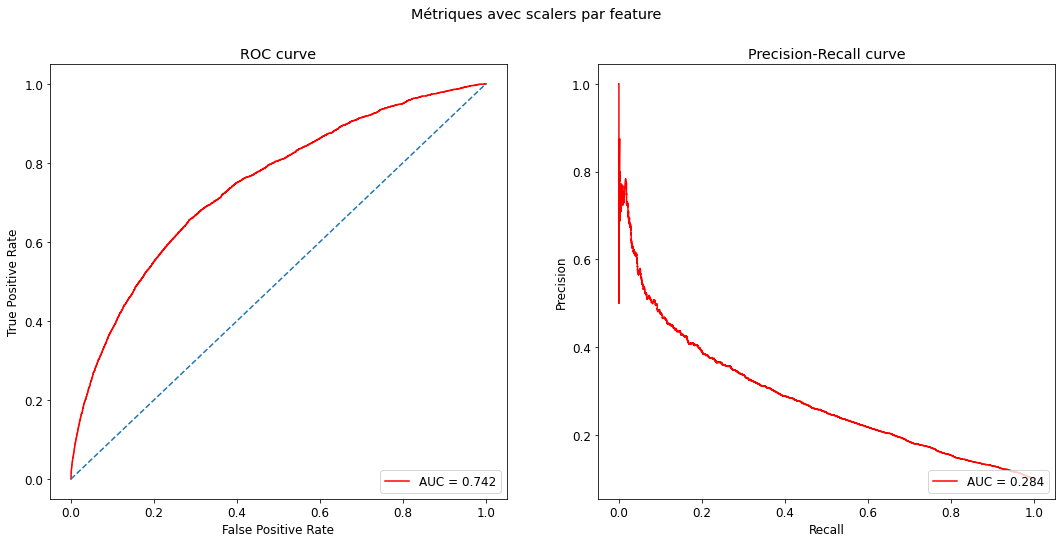

TRAIN SET: ROC AUC=0.746, PR AUC=0.285
TEST SET:  ROC AUC=0.743, PR AUC=0.285


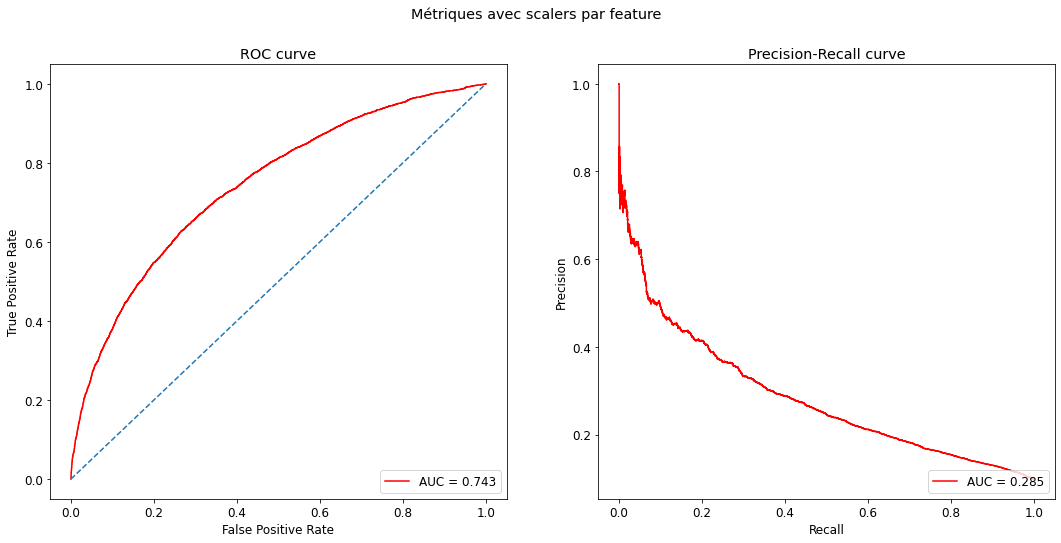

TRAIN SET: ROC AUC=0.743, PR AUC=0.281
TEST SET:  ROC AUC=0.749, PR AUC=0.293


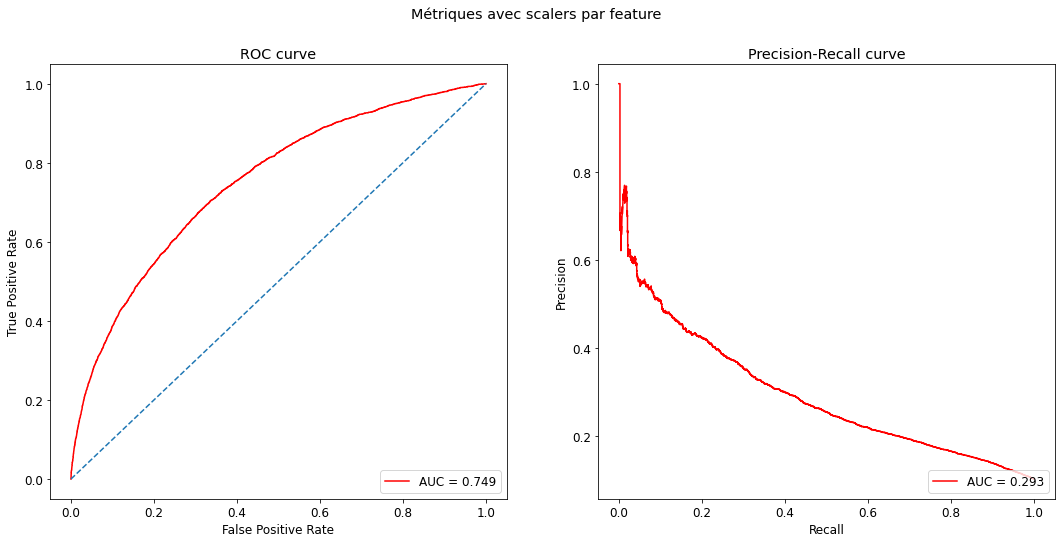

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from pickle import load

df = transformDf2(dfApplicationWorked)
df = df.sort_values('SK_ID_CURR', ascending=True).reset_index(drop=True)

for rnd in [100,50,1]:
    dfTrain, dfTest = train_test_split(df, test_size=0.2, random_state=rnd)
    y_train = dfTrain['TARGET'].values
    y_test = dfTest['TARGET'].values
    del dfTrain['TARGET']
    del dfTest['TARGET']
    del dfTrain['SK_ID_CURR']
    del dfTest['SK_ID_CURR']
    X_train = dfTrain.values
    X_test = dfTest.values

    model = RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1)
    metrics_model(model, X_train, y_train, X_test, y_test, display_plot=True, calc_feat_imp = False, features = [], label_model = 'Métriques avec scalers par feature')

## Discretisation des variables numériques

In [ ]:
myDf(dfApplicationWorked).Stat(typeStat='univ', exclCol=['SK_ID_CURR','TARGET'])

In [94]:
def transformDf3(df1):
    
    df = df1.copy()
    
    from math import ceil

    categorical_ix = df.select_dtypes(include=['object', 'bool']).columns
    df[categorical_ix] = df[categorical_ix].replace(np.nan, 'missing')

    for col in df.columns:
        if (col not in ['SK_ID_CURR','TARGET']) & (df[col].dtypes != 'object'):
            df[col] = SimpleImputer(strategy='mean').fit_transform(df[[col]])
            minVal = df[col].min()
            maxVal = df[col].max()
            if (minVal < 0) and (maxVal > 0):
                df[col] = df.apply(lambda x: x[col] + minVal, axis=1)
                minVal = 0
                maxVal = maxVal - minVal
            if minVal < 0:
                df[col] = -df[col]
                minVal = df[col].min()
                maxVal = df[col].max()
            df[col] = df.apply(lambda x: (ceil((x[col] - minVal) * 100)  / (maxVal - minVal)) / 100, axis=1)
            #df[col] = df[col].astype('int64')
        if df[col].dtypes == 'object':
            df[col] = OrdinalEncoder().fit_transform(df[[col]])
            
    return df

TRAIN SET: ROC AUC=0.748, PR AUC=0.284
TEST SET:  ROC AUC=0.743, PR AUC=0.274


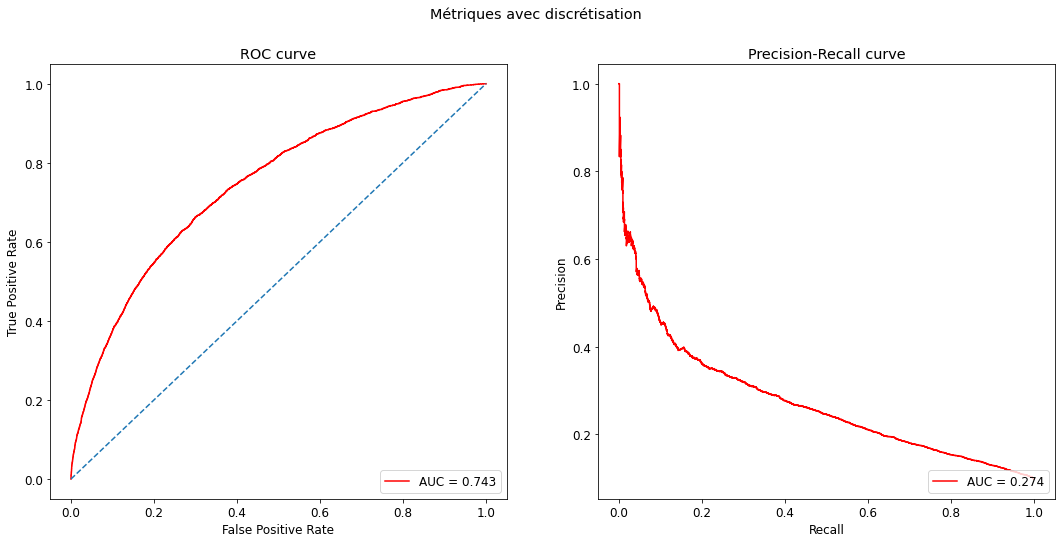

[6.464762926101685,
 14.985828161239624,
 0.7481273594039183,
 0.2835615113635996,
 3.260213613510132,
 0.7430899585983881,
 0.2738936733299172,
 '']

In [95]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from pickle import load

df = transformDf3(dfApplicationWorked)
df = df.sort_values('SK_ID_CURR', ascending=True).reset_index(drop=True)

dfTrain, dfTest = train_test_split(df, test_size=0.2, random_state=42)
y_train = dfTrain['TARGET'].values
y_test = dfTest['TARGET'].values
del dfTrain['TARGET']
del dfTest['TARGET']
del dfTrain['SK_ID_CURR']
del dfTest['SK_ID_CURR']
X_train = dfTrain.values
X_test = dfTest.values
    
model = RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1)
metrics_model(model, X_train, y_train, X_test, y_test, display_plot=True, calc_feat_imp = False, features = [], label_model = 'Métriques avec discrétisation')

## Over et under sampling

In [50]:
def OverUnderRandom(X, y):
    
    from imblearn.over_sampling import RandomOverSampler
    from imblearn.under_sampling import RandomUnderSampler
    from collections import Counter

    print(Counter(y))
    over = RandomOverSampler(sampling_strategy=0.3)
    X, y = over.fit_resample(X, y)
    print(Counter(y))
    under = RandomUnderSampler(sampling_strategy=0.5)
    X, y = under.fit_resample(X, y)
    print(Counter(y))
    
    return X, y

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from pickle import load

df = transformDf(dfApplicationWorked)
df = df.sort_values('SK_ID_CURR', ascending=True).reset_index(drop=True)

dfTrain, dfTest = train_test_split(df, test_size=0.2, random_state=1)
y_train = dfTrain['TARGET'].values
y_test = dfTest['TARGET'].values
del dfTrain['TARGET']
del dfTest['TARGET']
del dfTrain['SK_ID_CURR']
del dfTest['SK_ID_CURR']
X_train = dfTrain.values
X_test = dfTest.values

X_train, y_train = OverUnderRandom(X, y)
    
model = RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1)
metrics_model(model, X_train, y_train, X_test, y_test, display_plot=True, calc_feat_imp = False, features = [], label_model = 'Métriques sans les deux variables les plus importantes')

## Statistiques

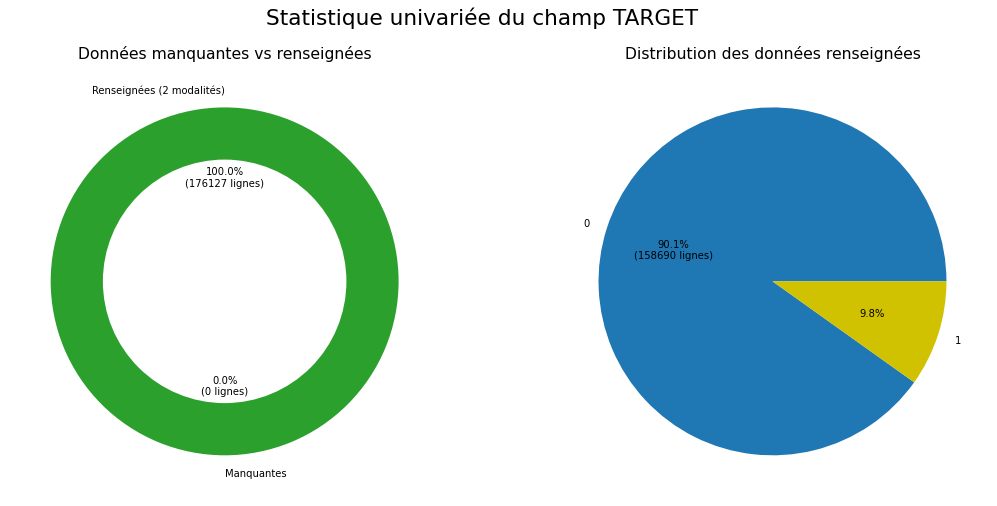

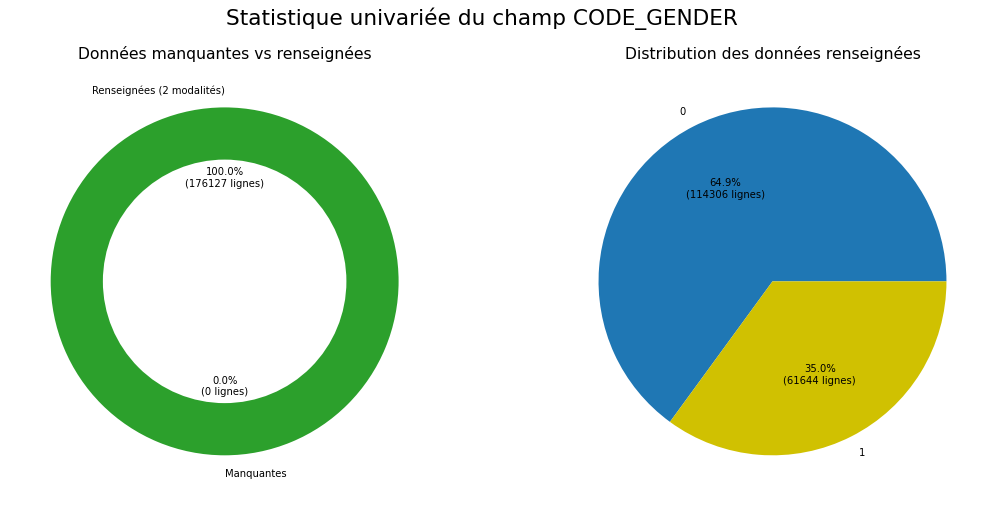

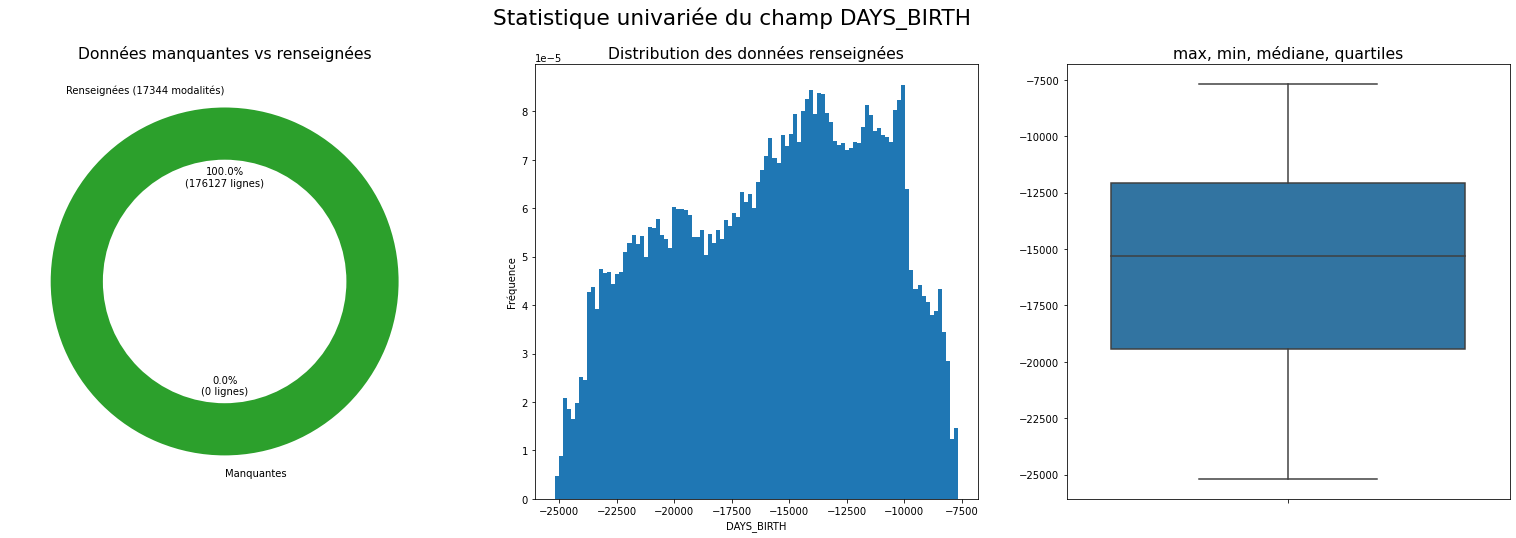

Mesures de position
 - Moyenne: -15748.48
 - Médiane: -15292.0
Mesures de dispertion
 - Ecart type: 4411.68
 - Min: -25197
 - Q25: -19419.0
 - Q75: -12056.0
 - Max: -7673
Mesures de forme
 - Skewness (asymétrie): -0.21
 - Kurtosis (applatissement): -1.03


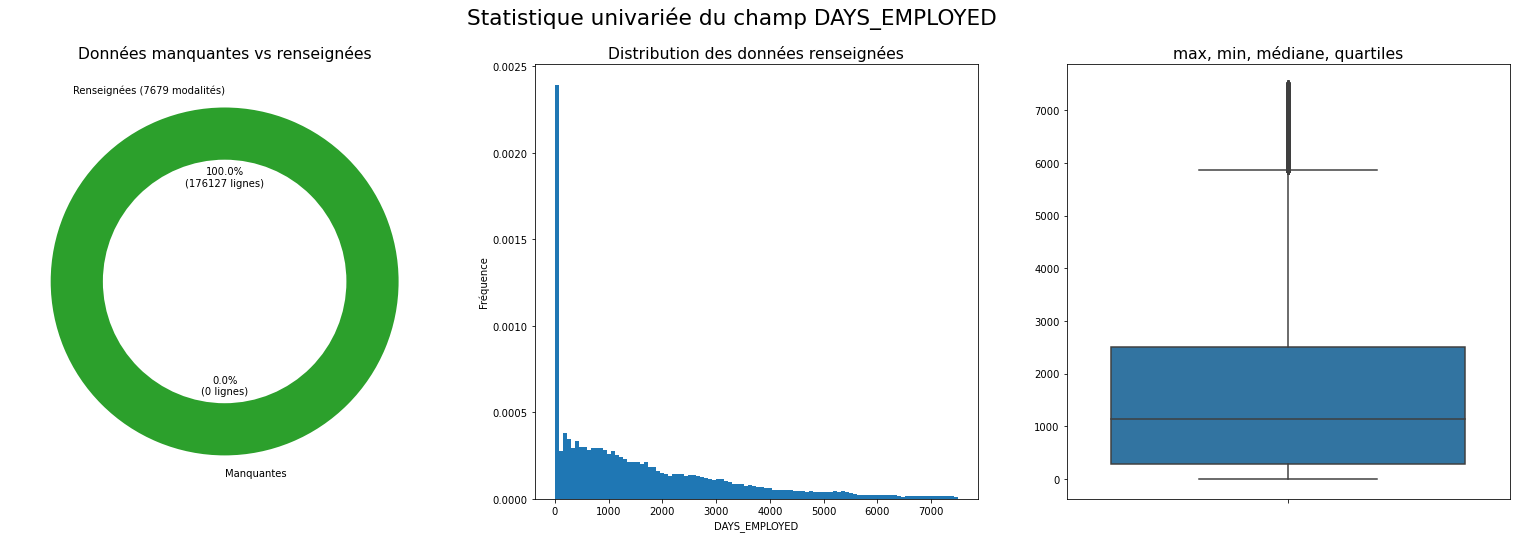

Mesures de position
 - Moyenne: 1640.74
 - Médiane: 1141.0
Mesures de dispertion
 - Ecart type: 1668.6
 - Min: -1.0
 - Q25: 283.0
 - Q75: 2514.0
 - Max: 7499.0
Mesures de forme
 - Skewness (asymétrie): 1.23
 - Kurtosis (applatissement): 0.99


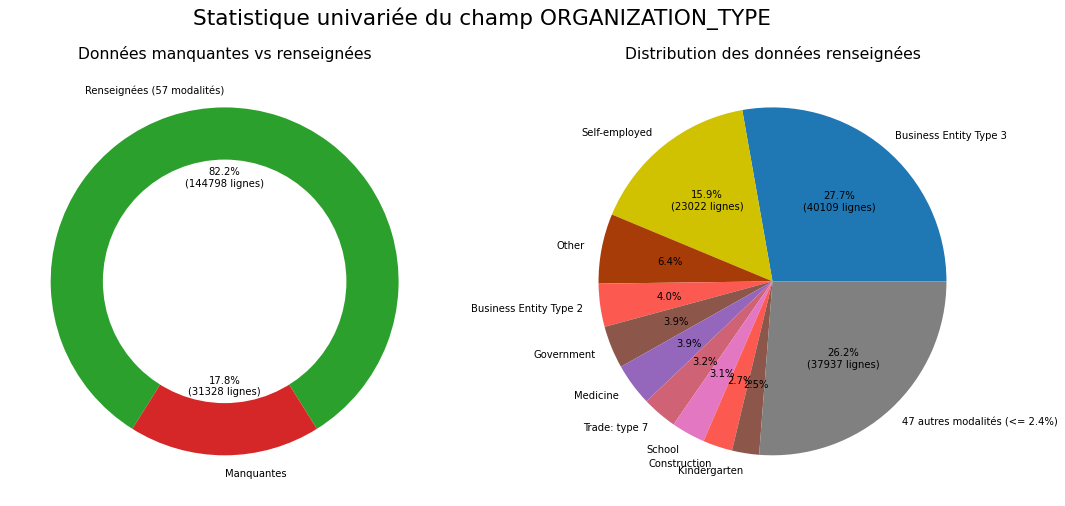

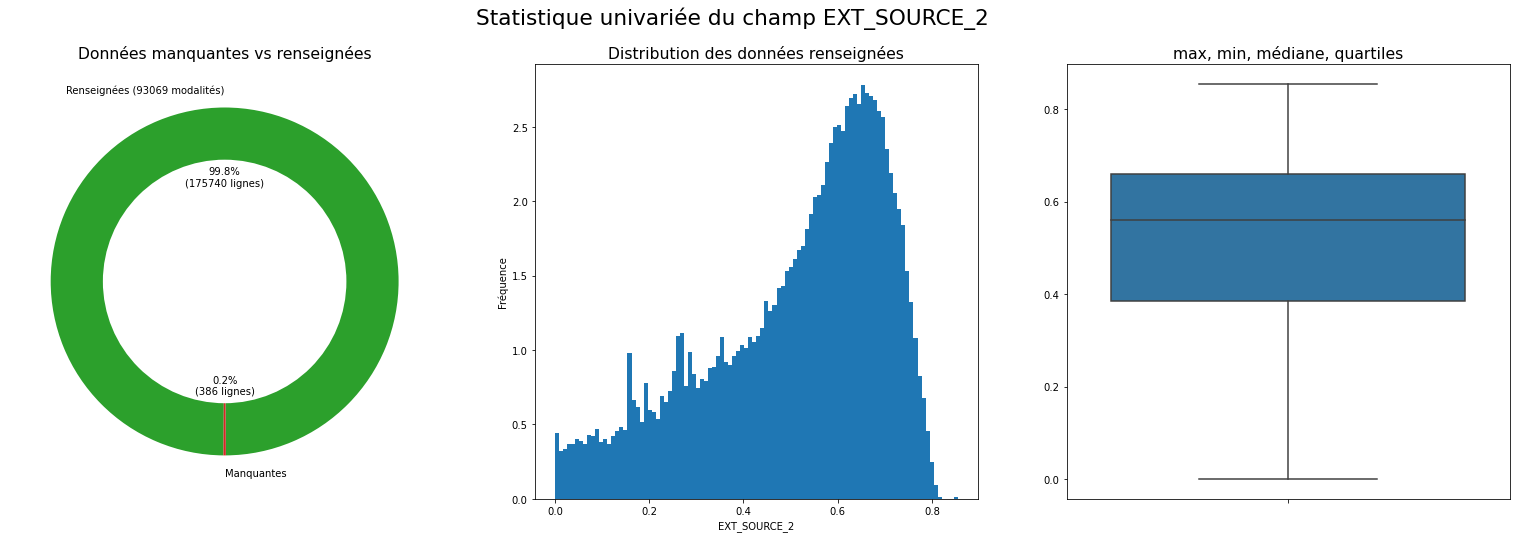

Mesures de position
 - Moyenne: 0.51
 - Médiane: 0.56
Mesures de dispertion
 - Ecart type: 0.19
 - Min: 0.0
 - Q25: 0.38
 - Q75: 0.66
 - Max: 0.85
Mesures de forme
 - Skewness (asymétrie): -0.77
 - Kurtosis (applatissement): -0.32


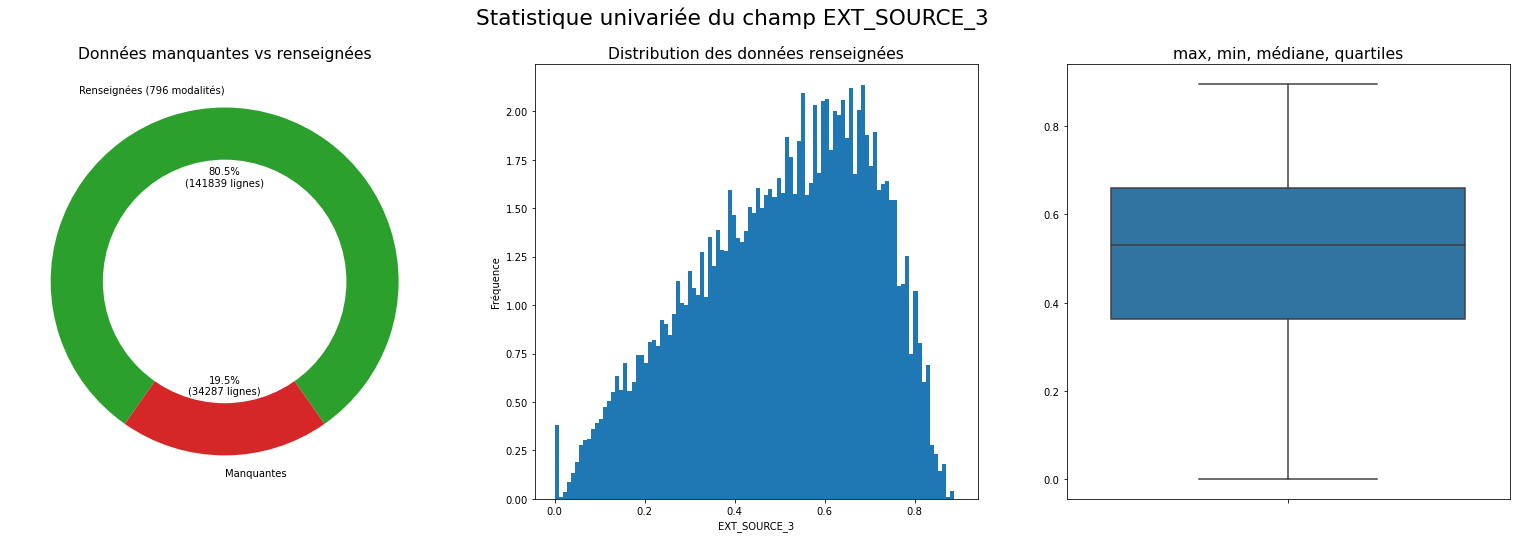

Mesures de position
 - Moyenne: 0.51
 - Médiane: 0.53
Mesures de dispertion
 - Ecart type: 0.19
 - Min: 0.0
 - Q25: 0.36
 - Q75: 0.66
 - Max: 0.9
Mesures de forme
 - Skewness (asymétrie): -0.39
 - Kurtosis (applatissement): -0.69


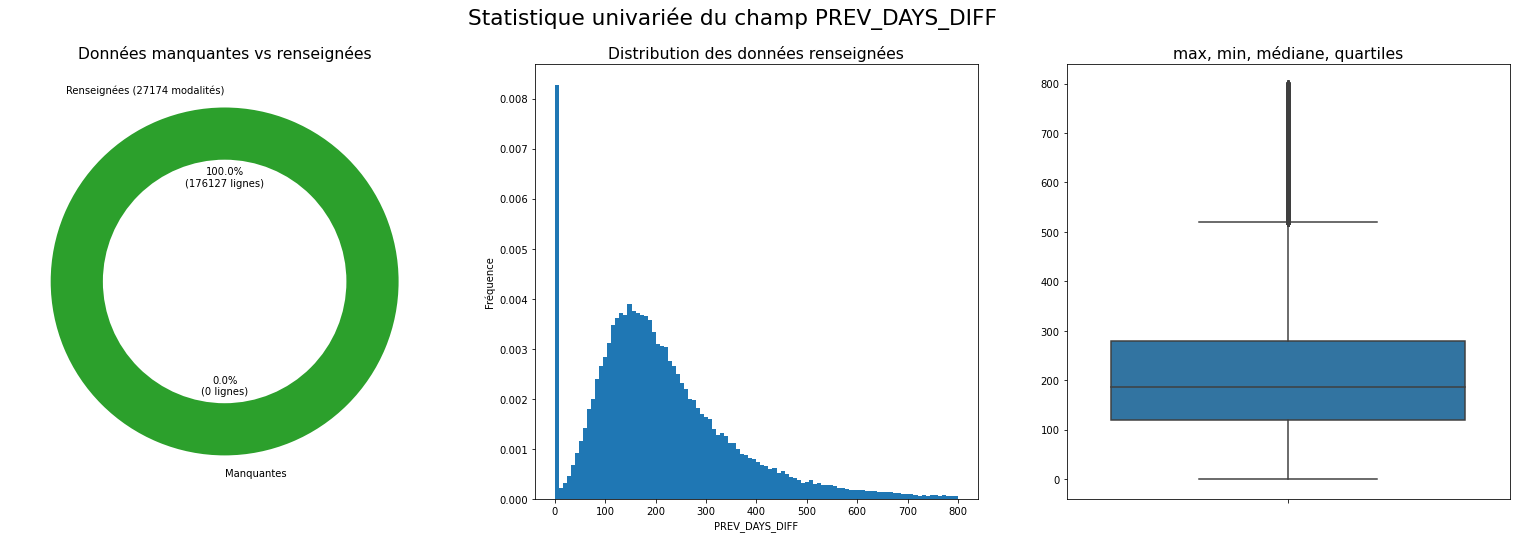

Mesures de position
 - Moyenne: 212.08
 - Médiane: 186.36
Mesures de dispertion
 - Ecart type: 141.81
 - Min: 0.0
 - Q25: 118.78
 - Q75: 279.32
 - Max: 799.67
Mesures de forme
 - Skewness (asymétrie): 1.09
 - Kurtosis (applatissement): 1.59


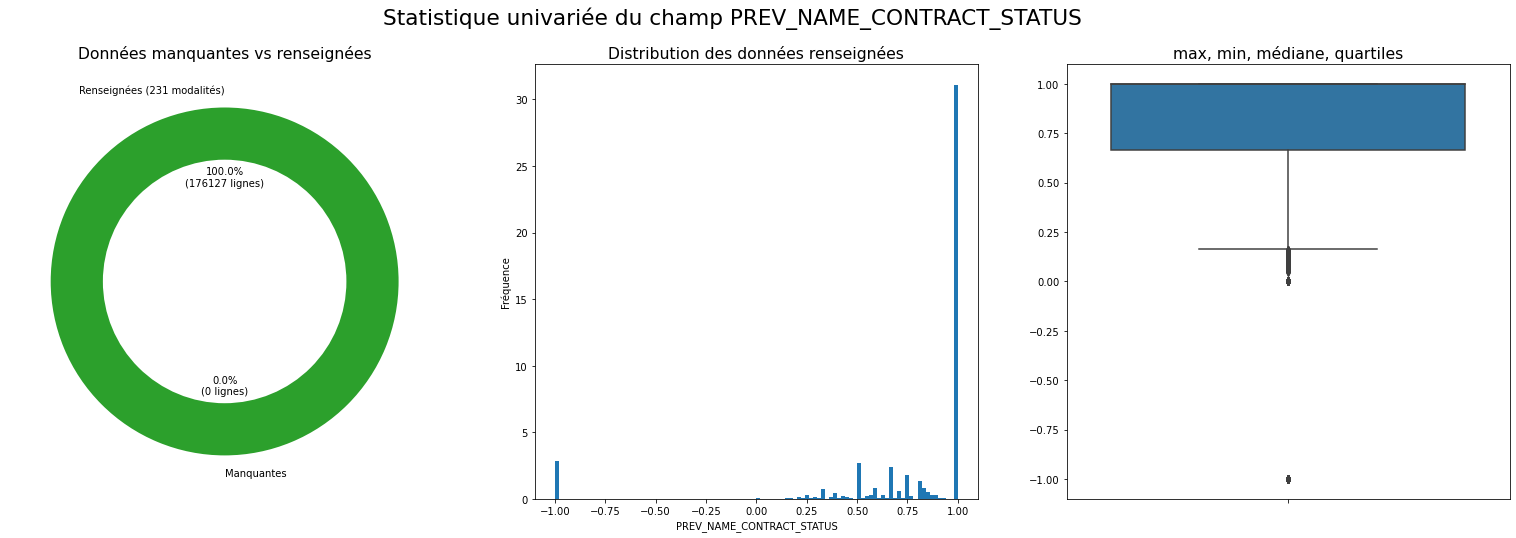

Mesures de position
 - Moyenne: 0.76
 - Médiane: 1.0
Mesures de dispertion
 - Ecart type: 0.48
 - Min: -1.0
 - Q25: 0.67
 - Q75: 1.0
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): -2.83
 - Kurtosis (applatissement): 7.58


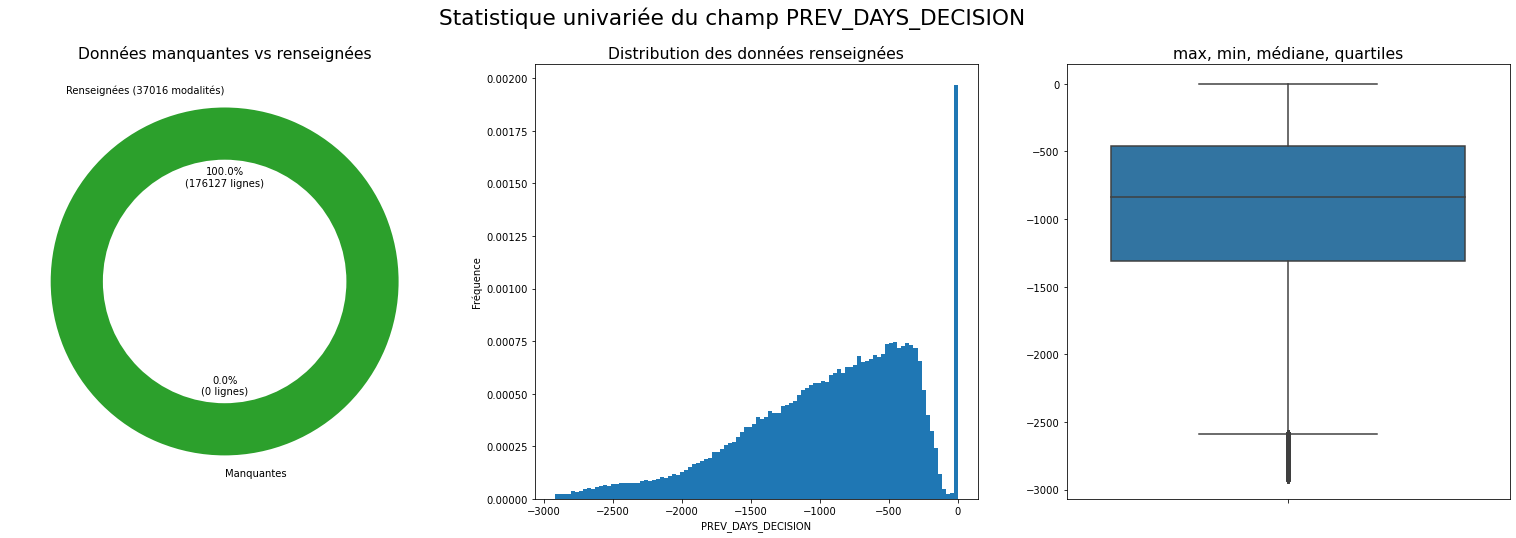

Mesures de position
 - Moyenne: -932.95
 - Médiane: -835.0
Mesures de dispertion
 - Ecart type: 612.21
 - Min: -2922.0
 - Q25: -1313.0
 - Q75: -462.0
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -0.72
 - Kurtosis (applatissement): 0.11


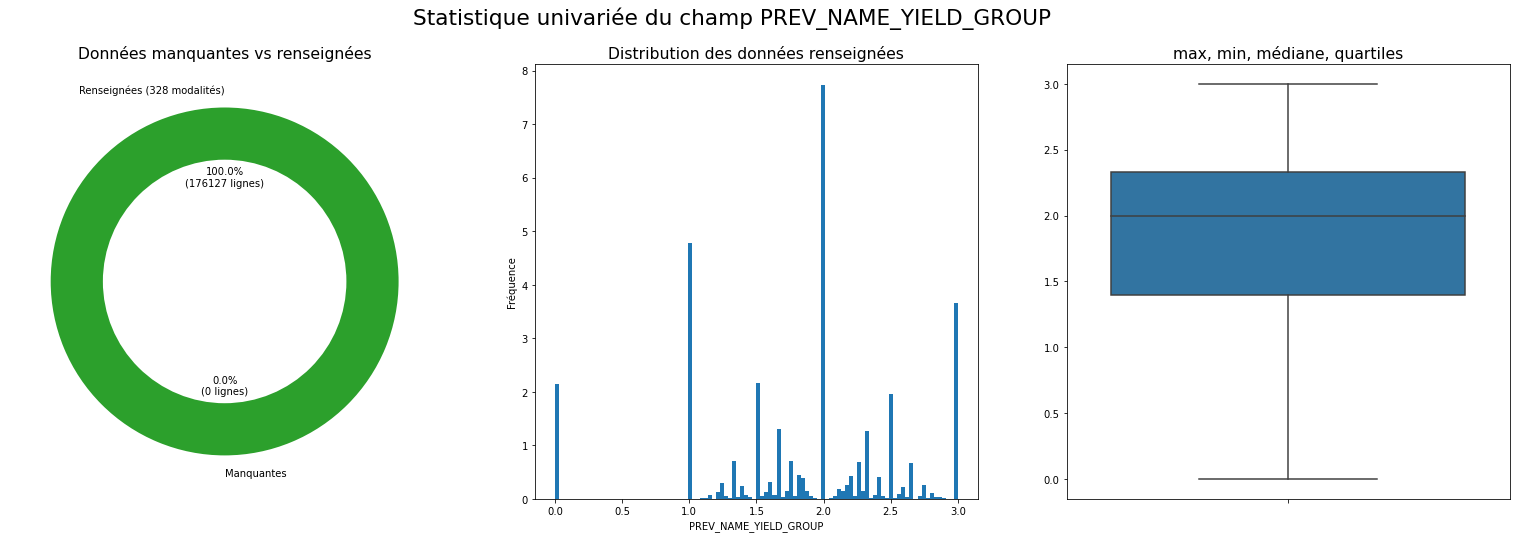

Mesures de position
 - Moyenne: 1.83
 - Médiane: 2.0
Mesures de dispertion
 - Ecart type: 0.76
 - Min: 0.0
 - Q25: 1.4
 - Q75: 2.33
 - Max: 3.0
Mesures de forme
 - Skewness (asymétrie): -0.57
 - Kurtosis (applatissement): 0.12


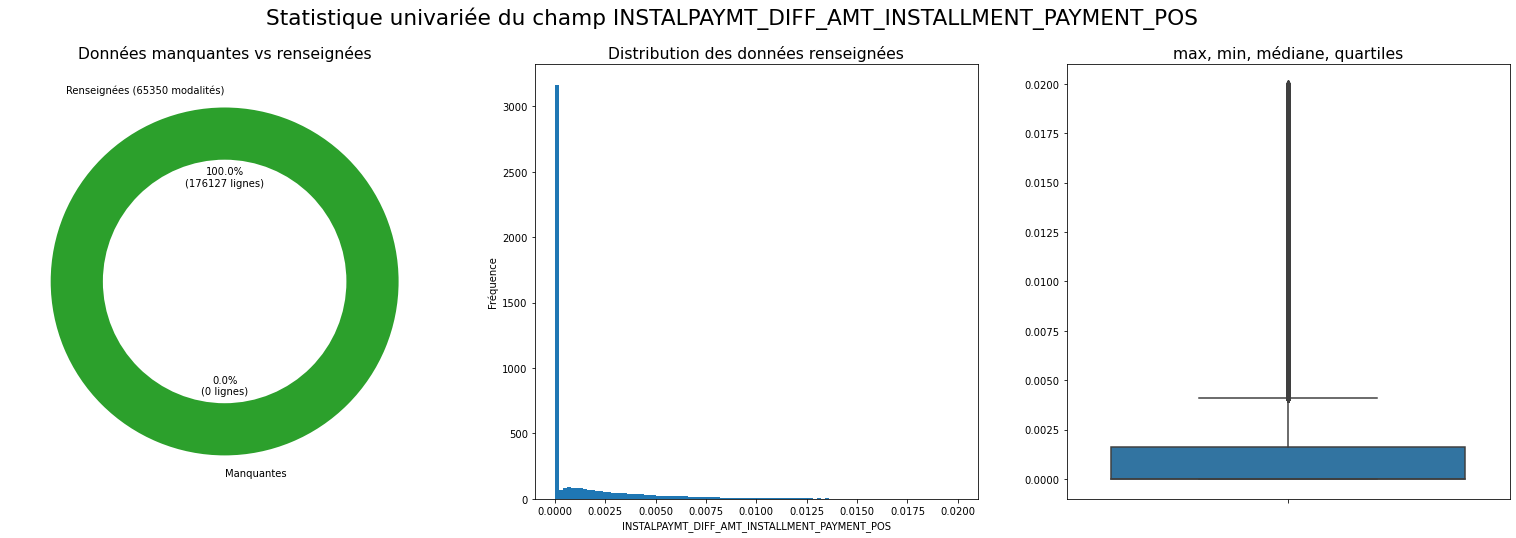

Mesures de position
 - Moyenne: 0.0
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.0
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 0.02
Mesures de forme
 - Skewness (asymétrie): 2.76
 - Kurtosis (applatissement): 8.78


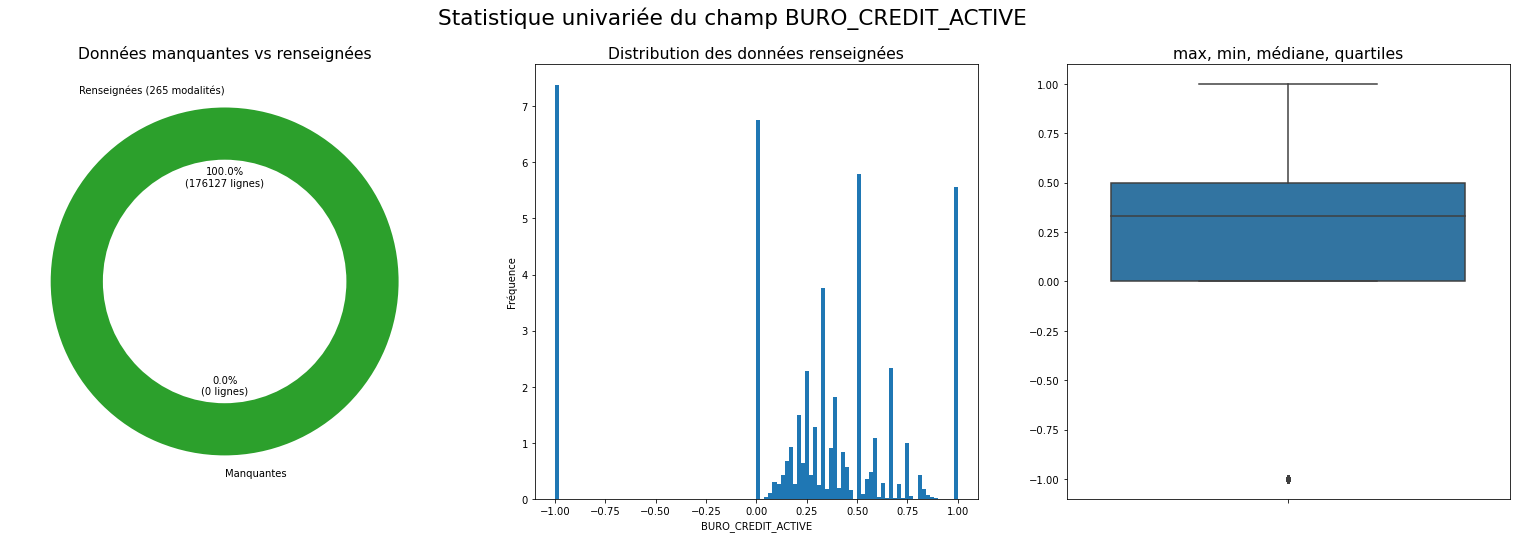

Mesures de position
 - Moyenne: 0.21
 - Médiane: 0.33
Mesures de dispertion
 - Ecart type: 0.58
 - Min: -1.0
 - Q25: 0.0
 - Q75: 0.5
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): -1.0
 - Kurtosis (applatissement): 0.29


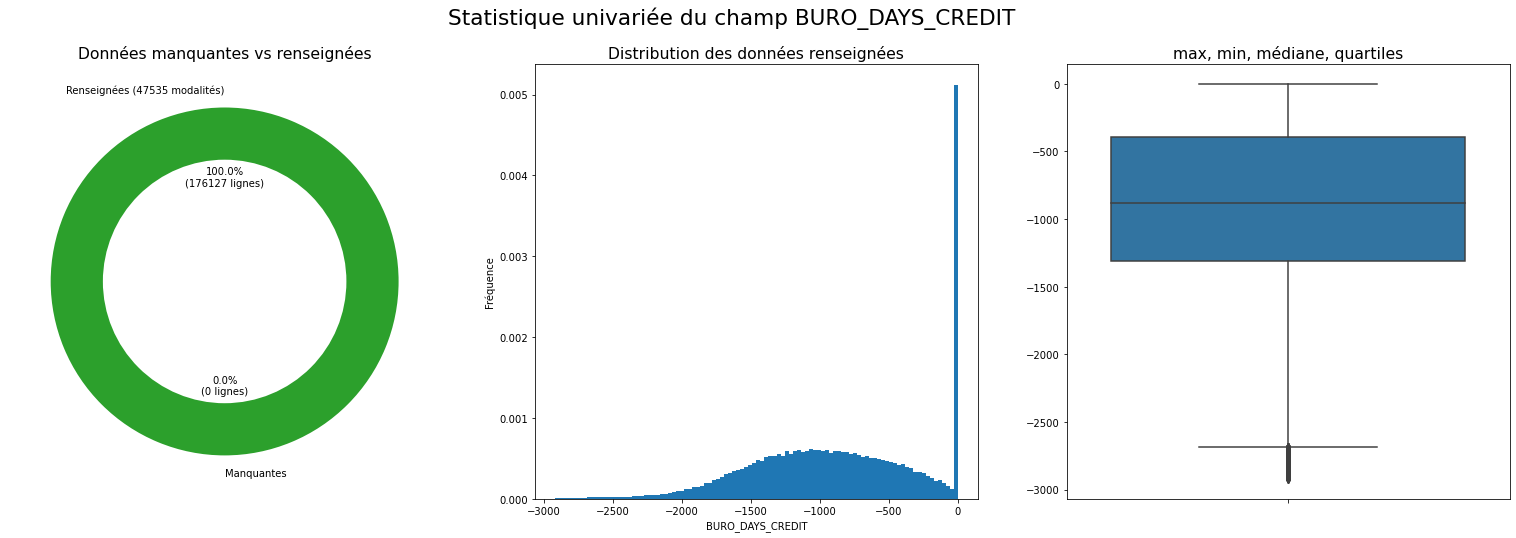

Mesures de position
 - Moyenne: -875.54
 - Médiane: -882.0
Mesures de dispertion
 - Ecart type: 604.23
 - Min: -2922.0
 - Q25: -1309.0
 - Q75: -393.58
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -0.26
 - Kurtosis (applatissement): -0.5


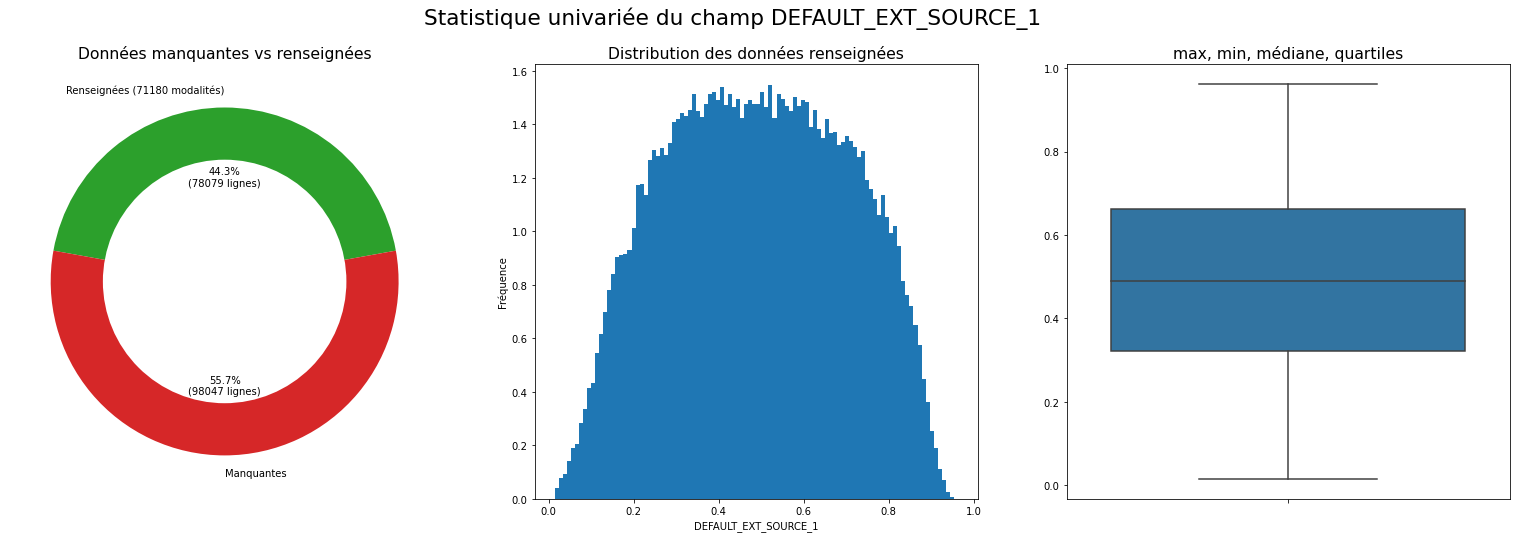

Mesures de position
 - Moyenne: 0.49
 - Médiane: 0.49
Mesures de dispertion
 - Ecart type: 0.21
 - Min: 0.01
 - Q25: 0.32
 - Q75: 0.66
 - Max: 0.96
Mesures de forme
 - Skewness (asymétrie): -0.01
 - Kurtosis (applatissement): -0.97


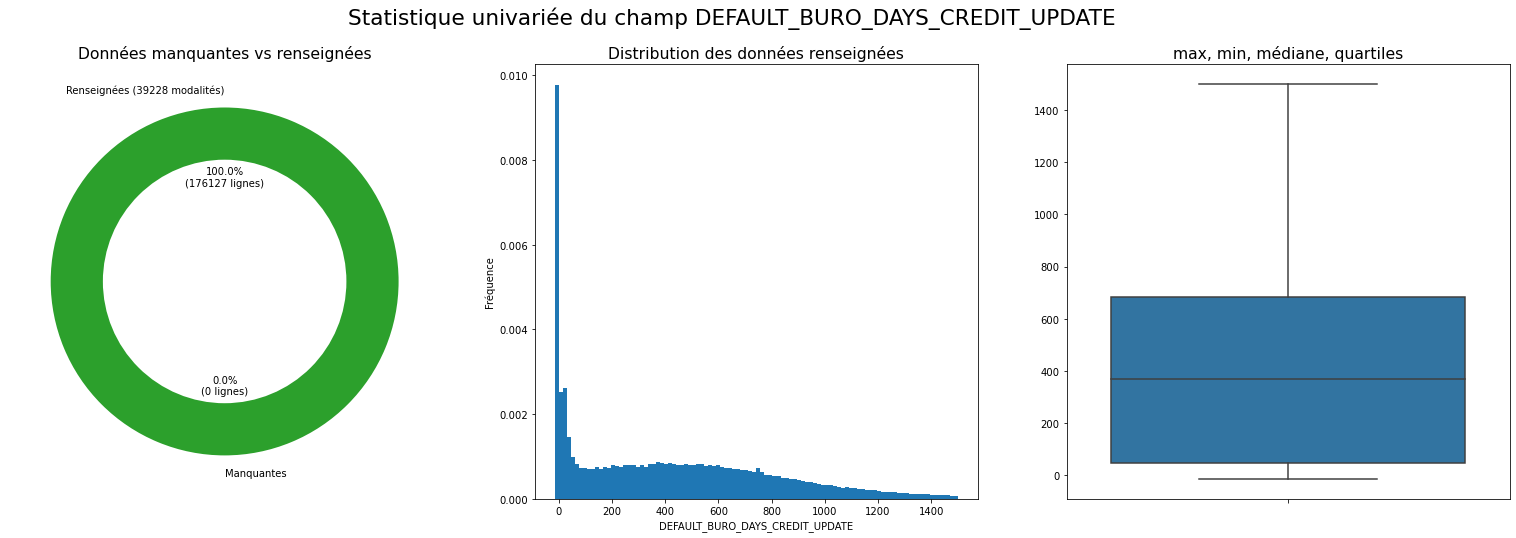

Mesures de position
 - Moyenne: 422.91
 - Médiane: 369.56
Mesures de dispertion
 - Ecart type: 375.25
 - Min: -14.0
 - Q25: 48.0
 - Q75: 685.0
 - Max: 1499.89
Mesures de forme
 - Skewness (asymétrie): 0.64
 - Kurtosis (applatissement): -0.48


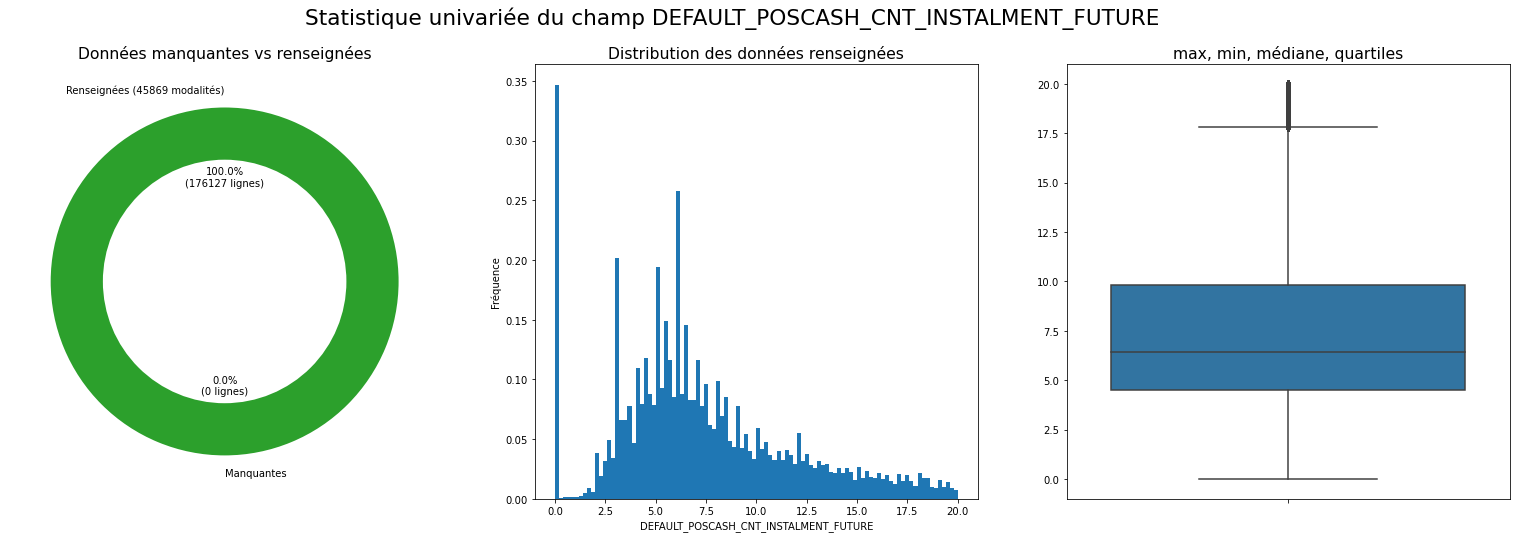

Mesures de position
 - Moyenne: 7.37
 - Médiane: 6.43
Mesures de dispertion
 - Ecart type: 4.47
 - Min: 0.0
 - Q25: 4.5
 - Q75: 9.83
 - Max: 20.0
Mesures de forme
 - Skewness (asymétrie): 0.68
 - Kurtosis (applatissement): 0.09


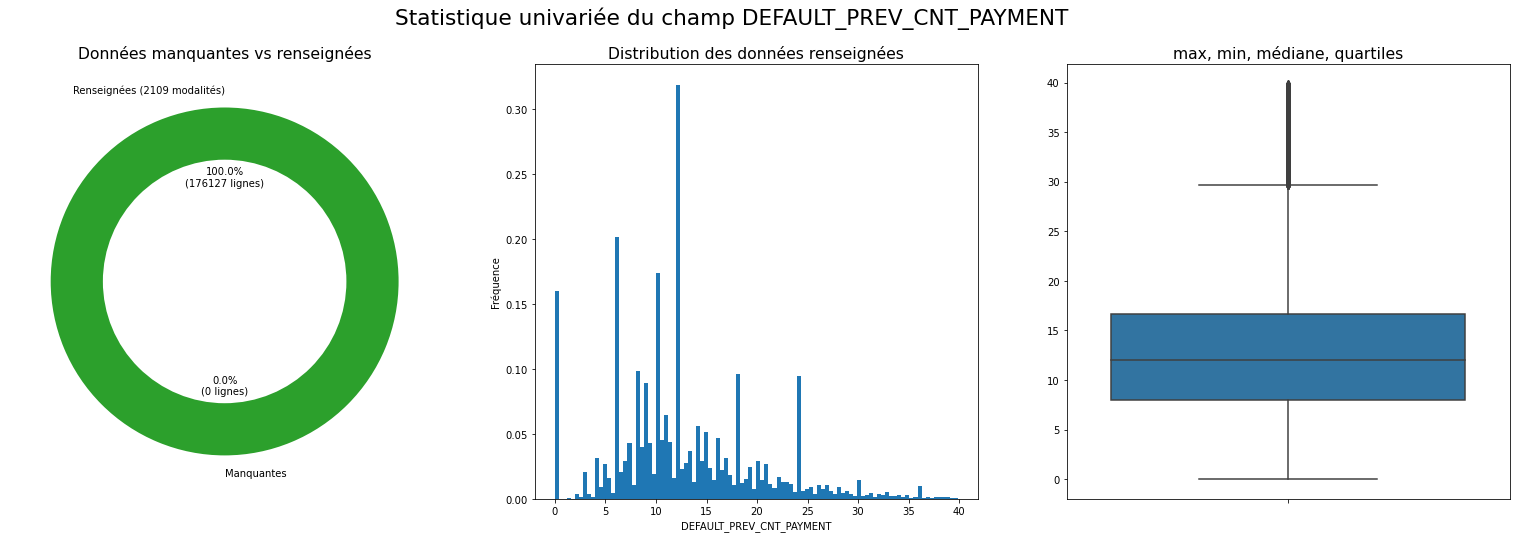

Mesures de position
 - Moyenne: 12.65
 - Médiane: 12.0
Mesures de dispertion
 - Ecart type: 7.36
 - Min: 0.0
 - Q25: 8.0
 - Q75: 16.67
 - Max: 39.88
Mesures de forme
 - Skewness (asymétrie): 0.75
 - Kurtosis (applatissement): 0.72


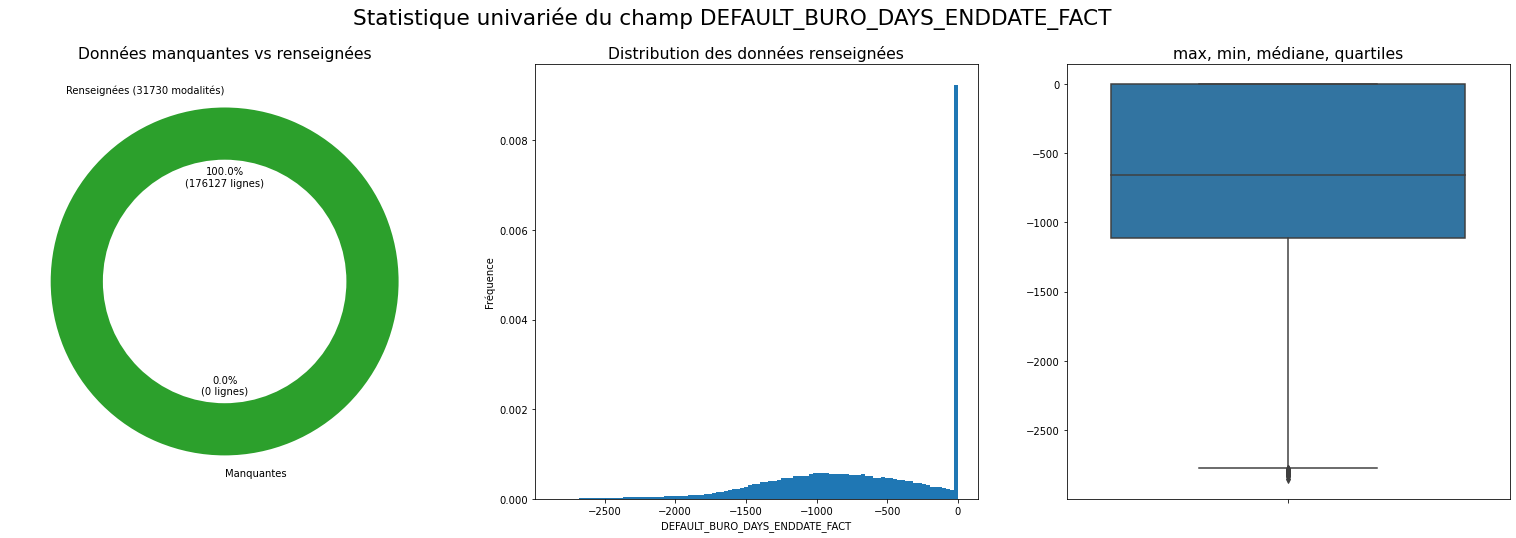

Mesures de position
 - Moyenne: -684.16
 - Médiane: -657.67
Mesures de dispertion
 - Ecart type: 593.52
 - Min: -2852.0
 - Q25: -1110.33
 - Q75: 0.0
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -0.54
 - Kurtosis (applatissement): -0.39


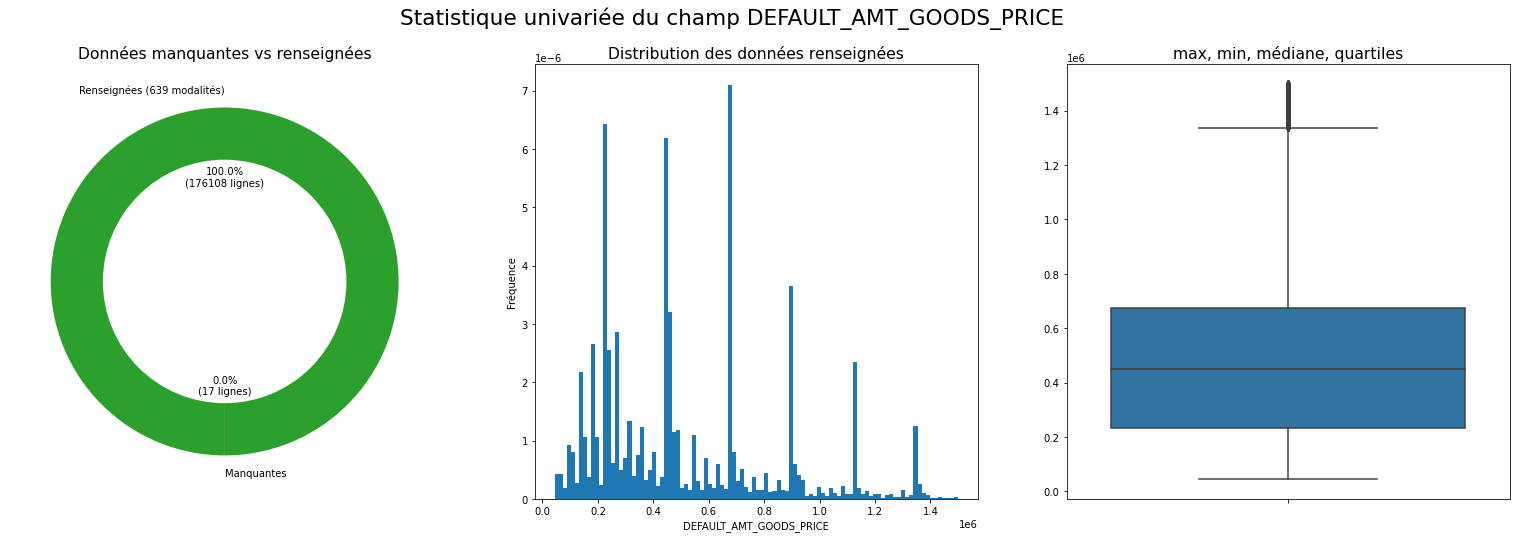

Mesures de position
 - Moyenne: 508594.69
 - Médiane: 450000.0
Mesures de dispertion
 - Ecart type: 318492.17
 - Min: 45000.0
 - Q25: 234000.0
 - Q75: 675000.0
 - Max: 1498500.0
Mesures de forme
 - Skewness (asymétrie): 0.85
 - Kurtosis (applatissement): 0.02


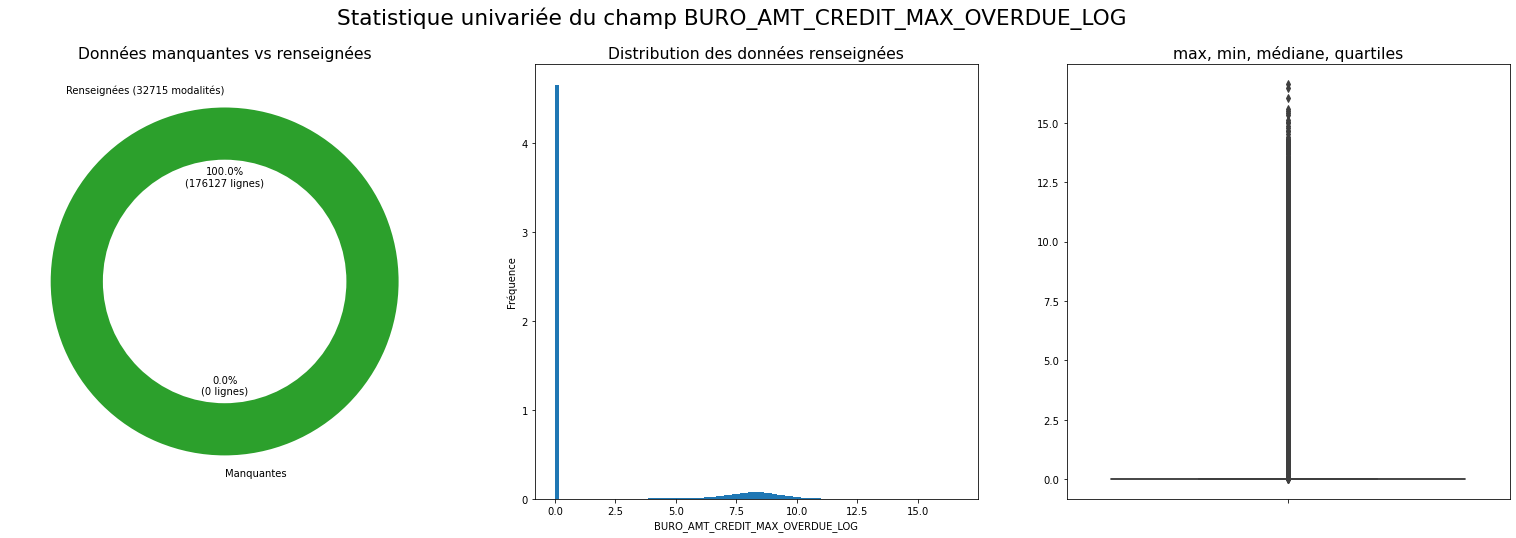

Mesures de position
 - Moyenne: 1.78
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 3.4
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 16.65
Mesures de forme
 - Skewness (asymétrie): 1.49
 - Kurtosis (applatissement): 0.41


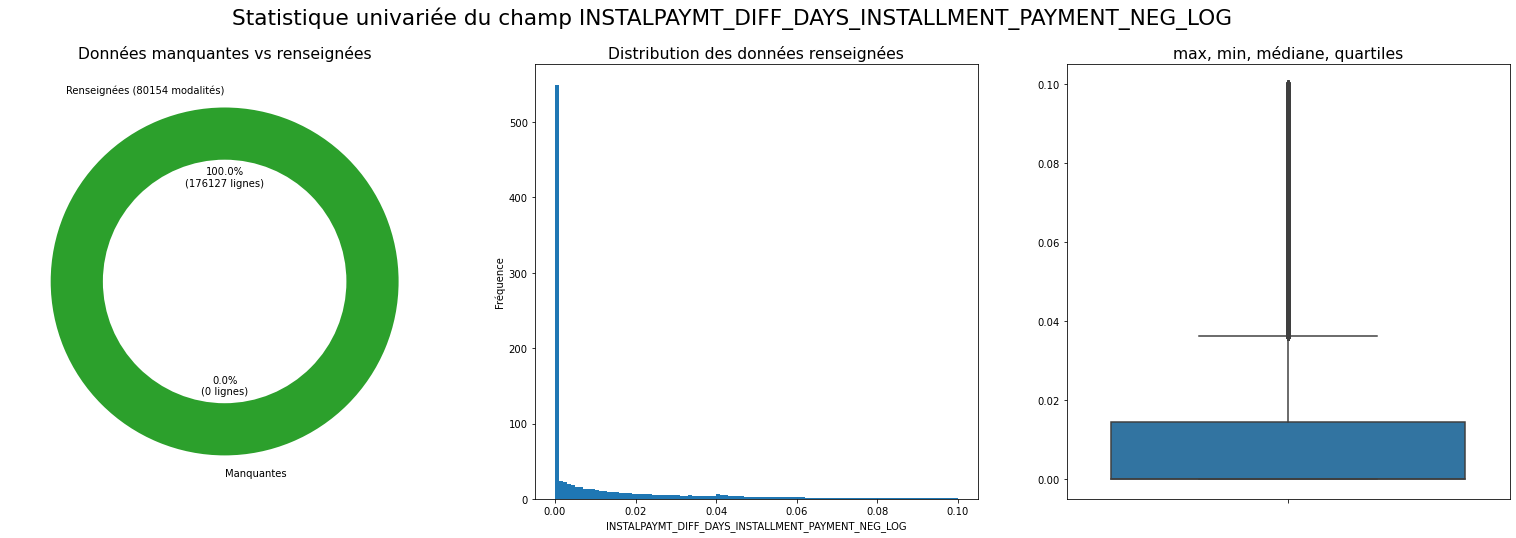

Mesures de position
 - Moyenne: 0.01
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.02
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.01
 - Max: 0.1
Mesures de forme
 - Skewness (asymétrie): 2.13
 - Kurtosis (applatissement): 4.12


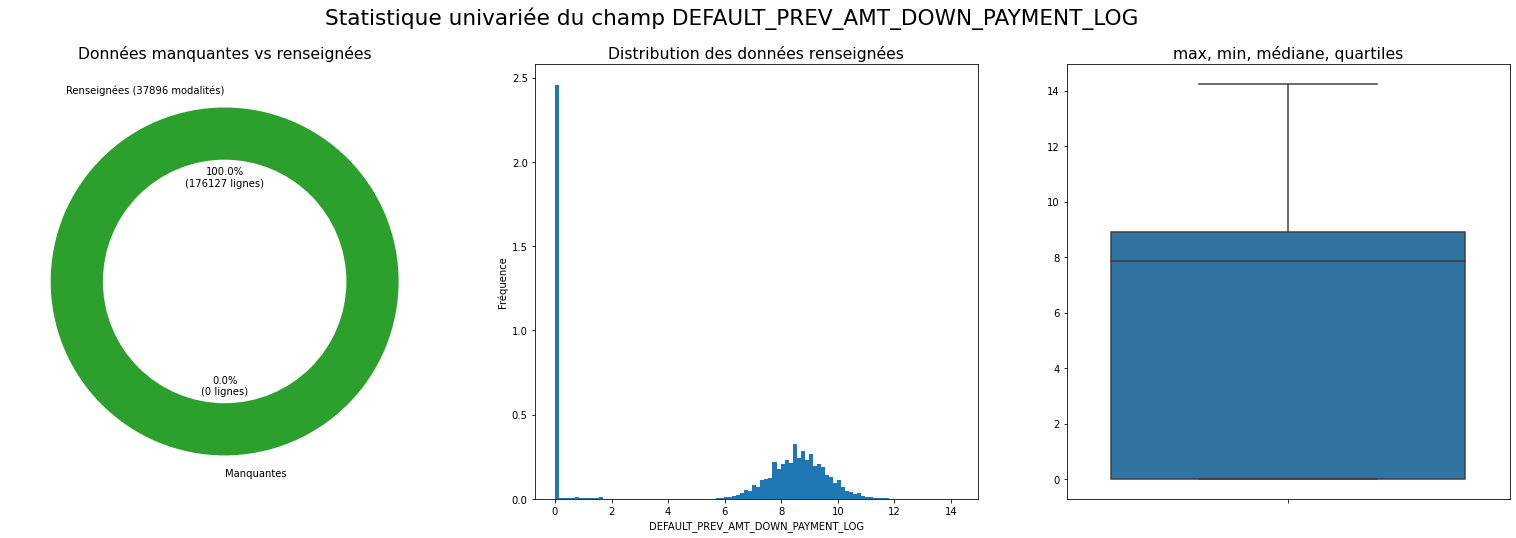

Mesures de position
 - Moyenne: 5.53
 - Médiane: 7.87
Mesures de dispertion
 - Ecart type: 4.21
 - Min: 0.0
 - Q25: 0.0
 - Q75: 8.9
 - Max: 14.24
Mesures de forme
 - Skewness (asymétrie): -0.47
 - Kurtosis (applatissement): -1.63


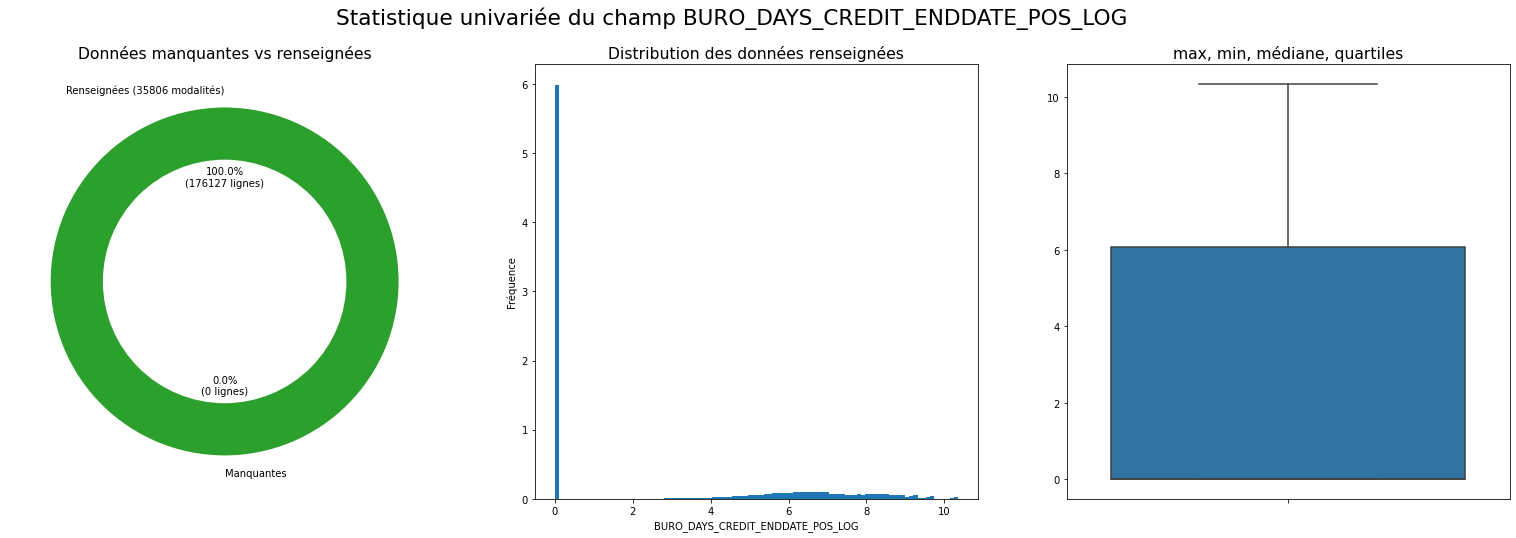

Mesures de position
 - Moyenne: 2.55
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 3.4
 - Min: 0.0
 - Q25: 0.0
 - Q75: 6.07
 - Max: 10.35
Mesures de forme
 - Skewness (asymétrie): 0.74
 - Kurtosis (applatissement): -1.18


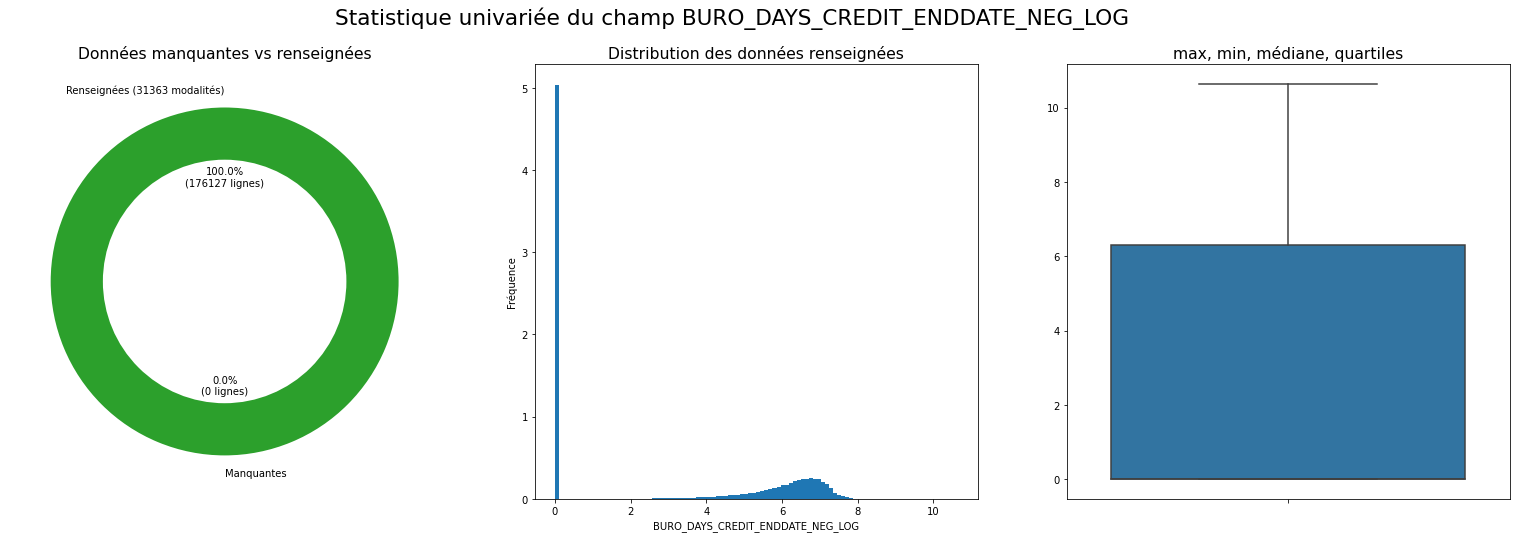

Mesures de position
 - Moyenne: 2.84
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 3.14
 - Min: 0.0
 - Q25: 0.0
 - Q75: 6.29
 - Max: 10.64
Mesures de forme
 - Skewness (asymétrie): 0.27
 - Kurtosis (applatissement): -1.81


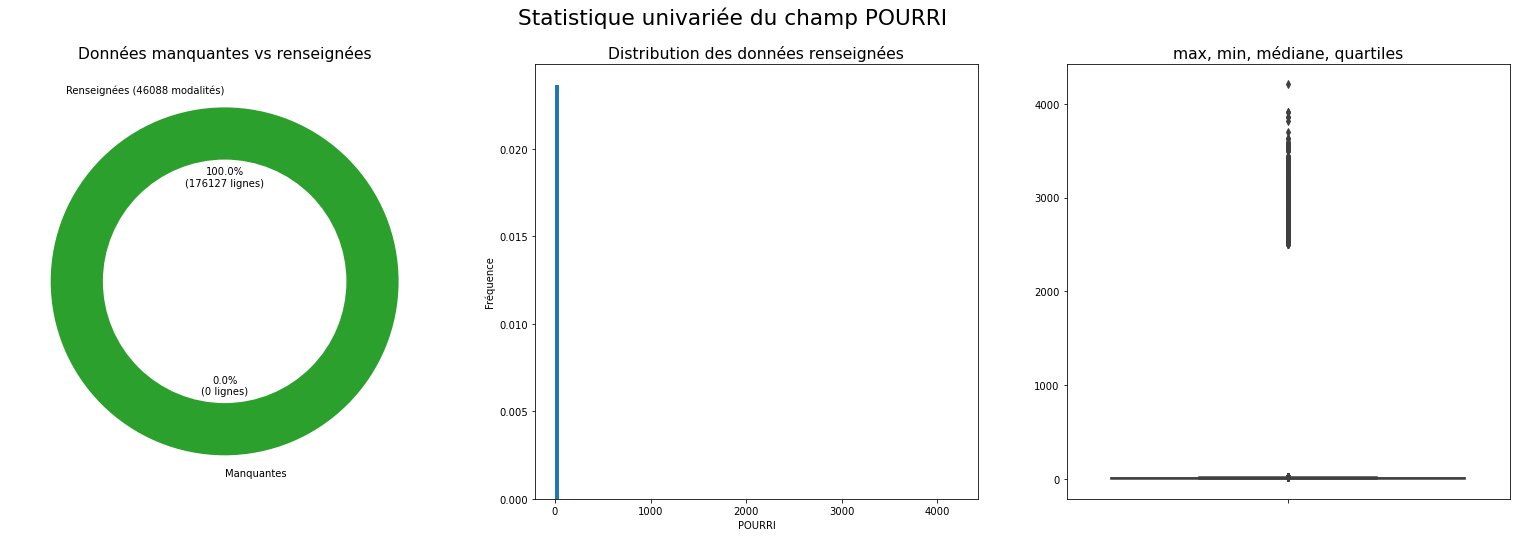

Mesures de position
 - Moyenne: 13.15
 - Médiane: 6.43
Mesures de dispertion
 - Ecart type: 129.76
 - Min: 0.0
 - Q25: 4.5
 - Q75: 9.86
 - Max: 4213.8
Mesures de forme
 - Skewness (asymétrie): 22.65
 - Kurtosis (applatissement): 519.32


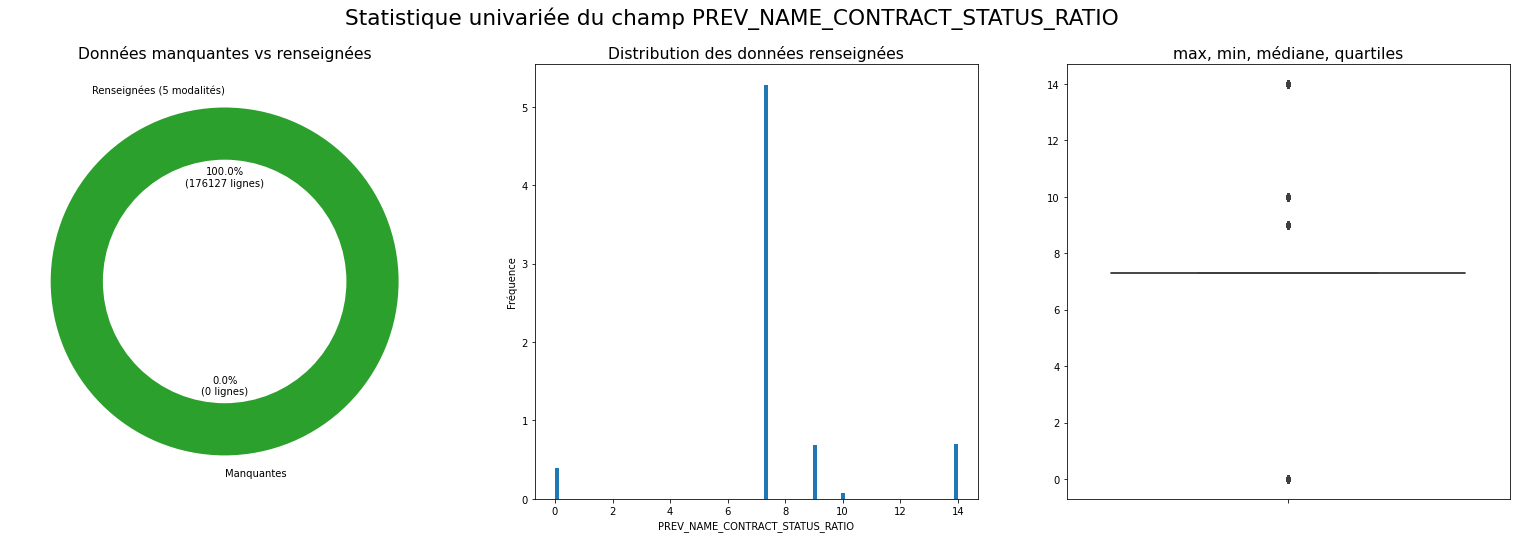

Mesures de position
 - Moyenne: 7.74
 - Médiane: 7.3
Mesures de dispertion
 - Ecart type: 2.73
 - Min: 0.0
 - Q25: 7.3
 - Q75: 7.3
 - Max: 14.0
Mesures de forme
 - Skewness (asymétrie): -0.08
 - Kurtosis (applatissement): 3.23


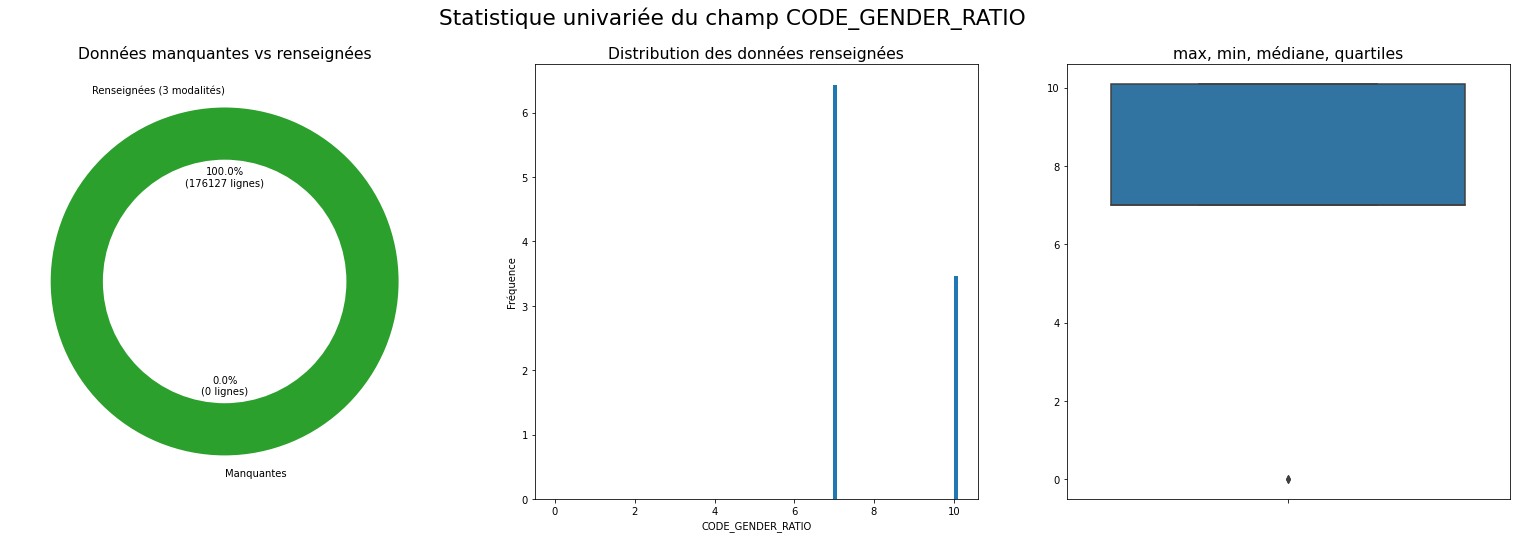

Mesures de position
 - Moyenne: 8.09
 - Médiane: 7.0
Mesures de dispertion
 - Ecart type: 1.48
 - Min: 0.0
 - Q25: 7.0
 - Q75: 10.1
 - Max: 10.1
Mesures de forme
 - Skewness (asymétrie): 0.63
 - Kurtosis (applatissement): -1.6


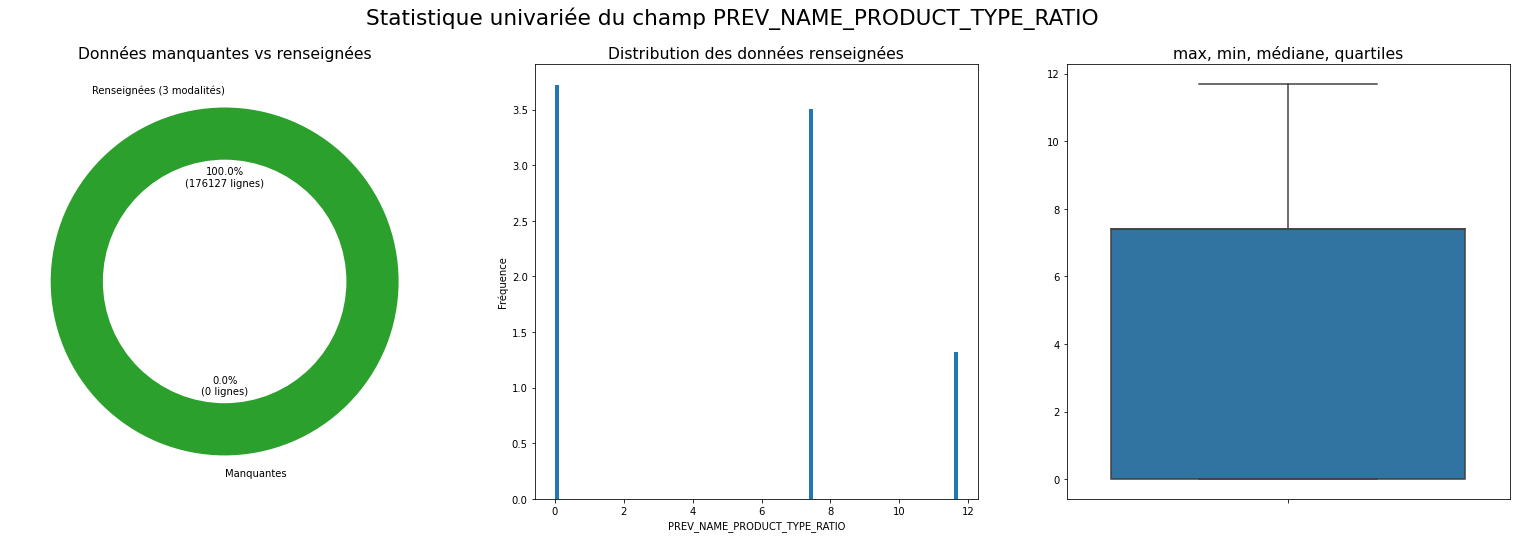

Mesures de position
 - Moyenne: 4.84
 - Médiane: 7.4
Mesures de dispertion
 - Ecart type: 4.49
 - Min: 0.0
 - Q25: 0.0
 - Q75: 7.4
 - Max: 11.7
Mesures de forme
 - Skewness (asymétrie): 0.08
 - Kurtosis (applatissement): -1.53


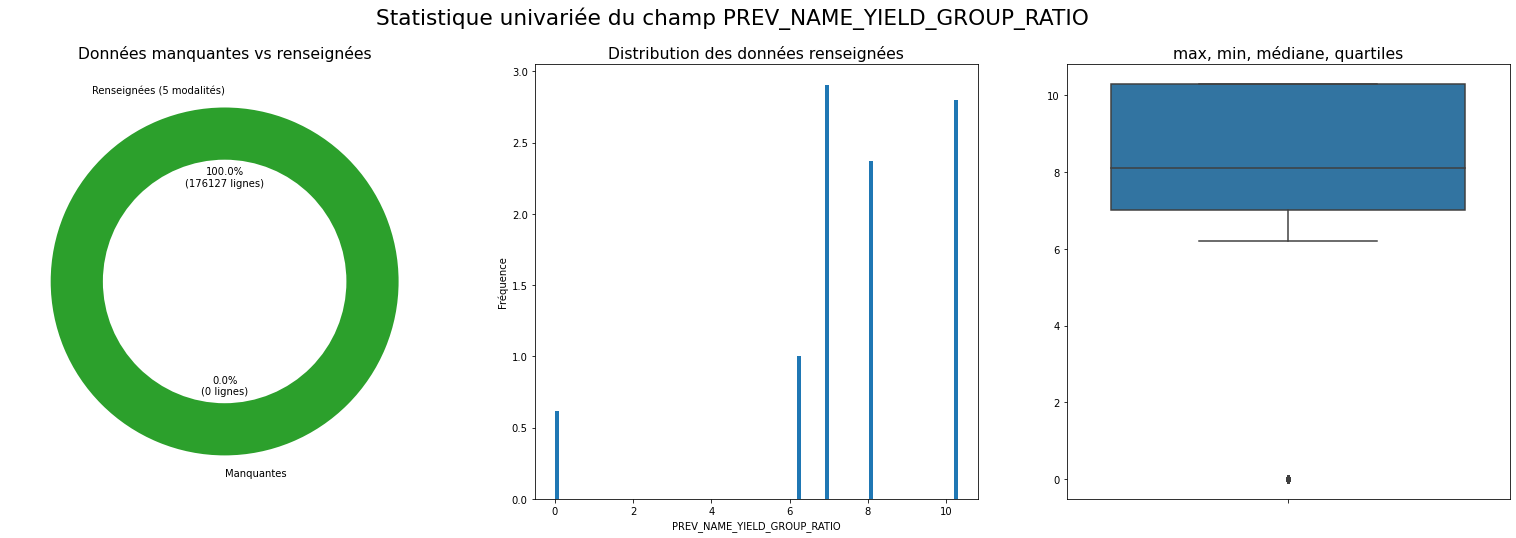

Mesures de position
 - Moyenne: 7.69
 - Médiane: 8.1
Mesures de dispertion
 - Ecart type: 2.48
 - Min: 0.0
 - Q25: 7.0
 - Q75: 10.3
 - Max: 10.3
Mesures de forme
 - Skewness (asymétrie): -1.6
 - Kurtosis (applatissement): 3.27


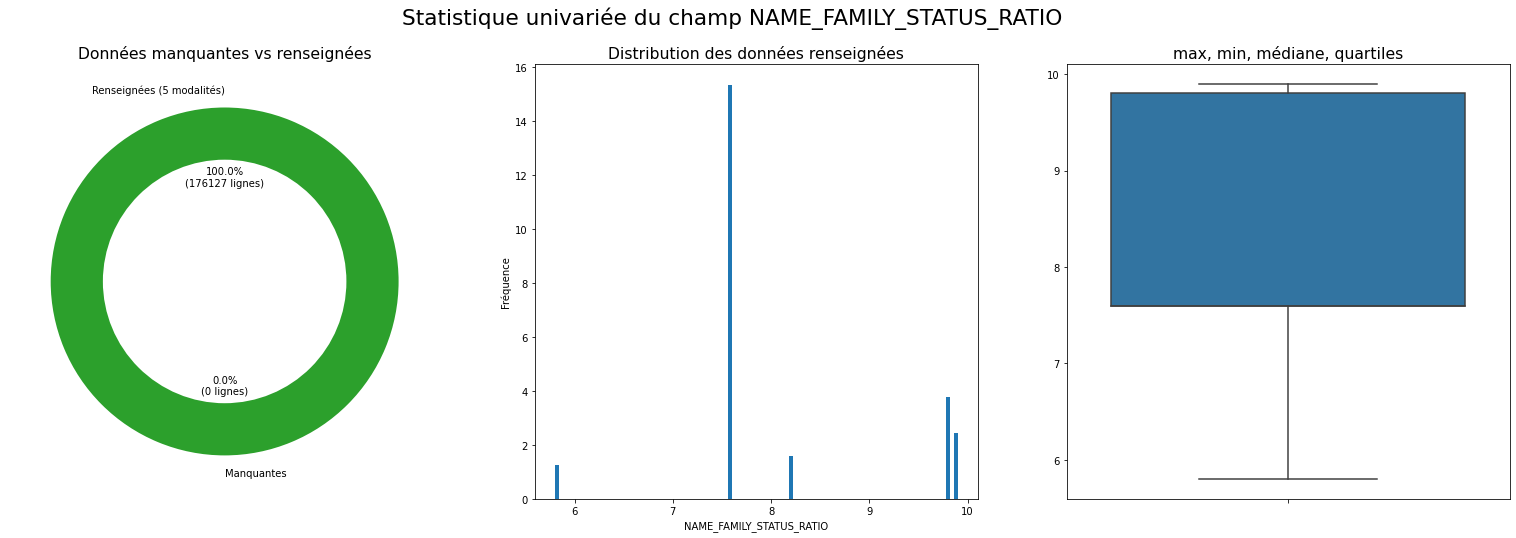

Mesures de position
 - Moyenne: 8.12
 - Médiane: 7.6
Mesures de dispertion
 - Ecart type: 1.1
 - Min: 5.8
 - Q25: 7.6
 - Q75: 9.8
 - Max: 9.9
Mesures de forme
 - Skewness (asymétrie): 0.44
 - Kurtosis (applatissement): -0.39


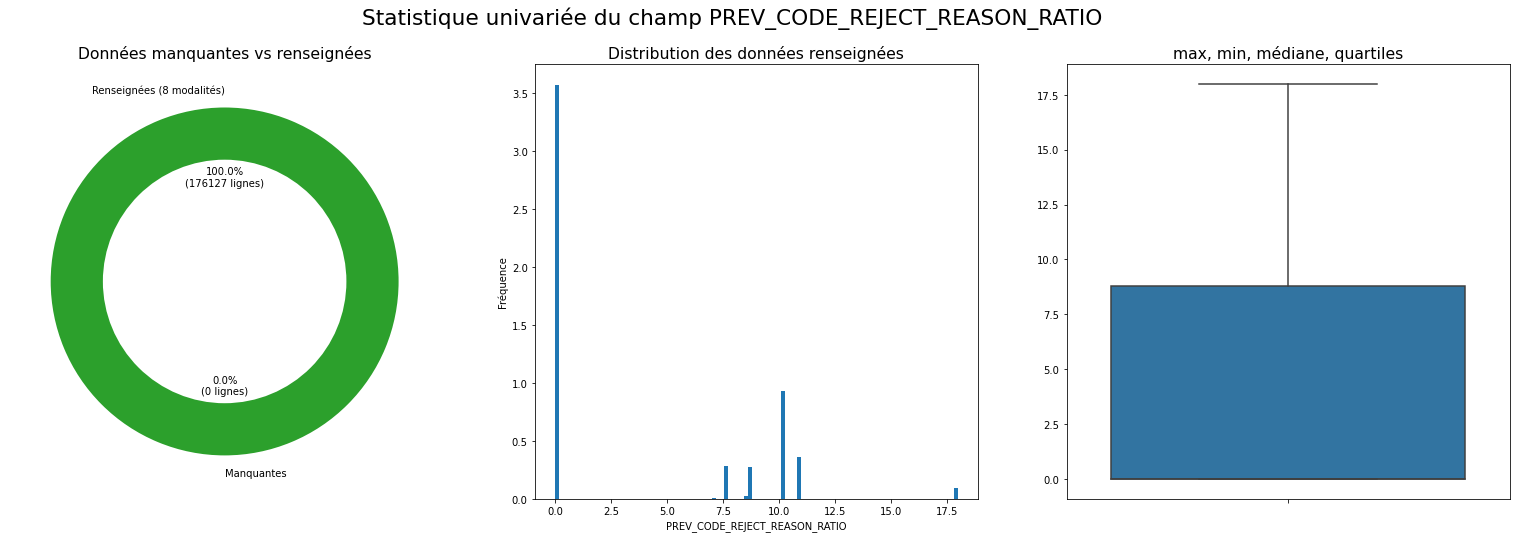

Mesures de position
 - Moyenne: 3.61
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 4.99
 - Min: 0.0
 - Q25: 0.0
 - Q75: 8.8
 - Max: 18.0
Mesures de forme
 - Skewness (asymétrie): 0.84
 - Kurtosis (applatissement): -0.77


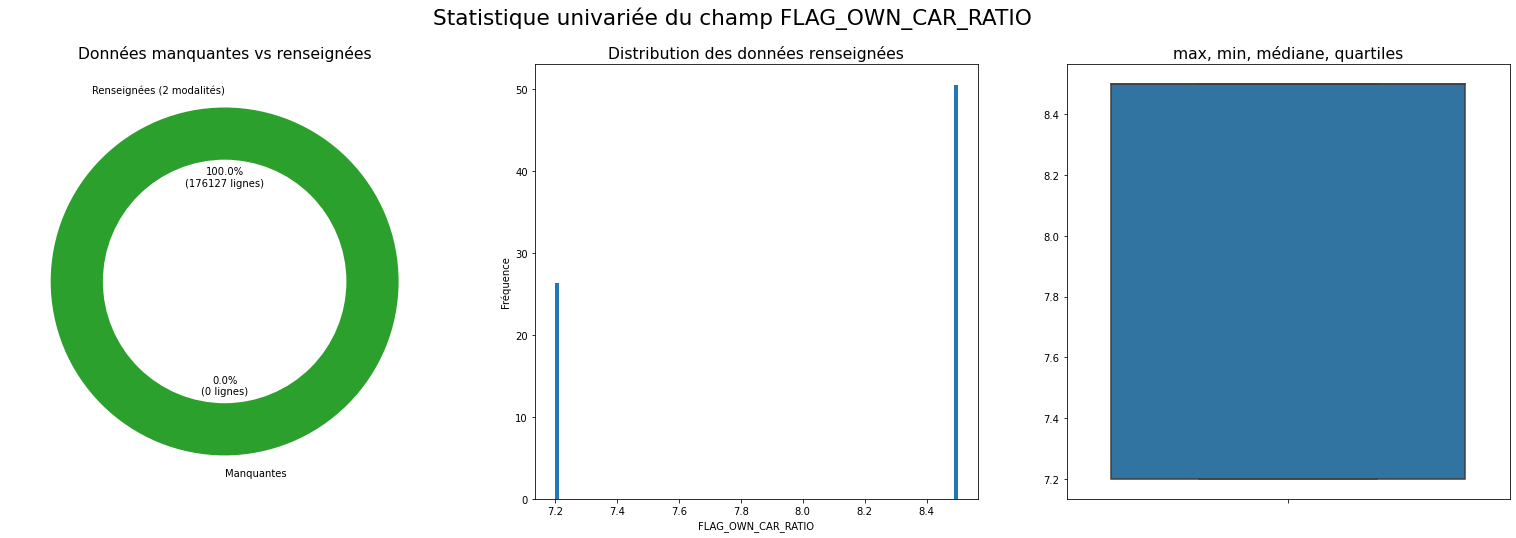

Mesures de position
 - Moyenne: 8.05
 - Médiane: 8.5
Mesures de dispertion
 - Ecart type: 0.62
 - Min: 7.2
 - Q25: 7.2
 - Q75: 8.5
 - Max: 8.5
Mesures de forme
 - Skewness (asymétrie): -0.66
 - Kurtosis (applatissement): -1.56


In [144]:
myDf(dfApplicationWorked).Stat(typeStat='univ', exclCol=['SK_ID_CURR'], statsNan=True)

## Gestion des valeurs manquantes

In [145]:
dfApplicationWorked = dfApplicationWorkedSvg.copy()

### Aperçu des valeurs manquantes

#### Valeurs numériques

(215257, 25)


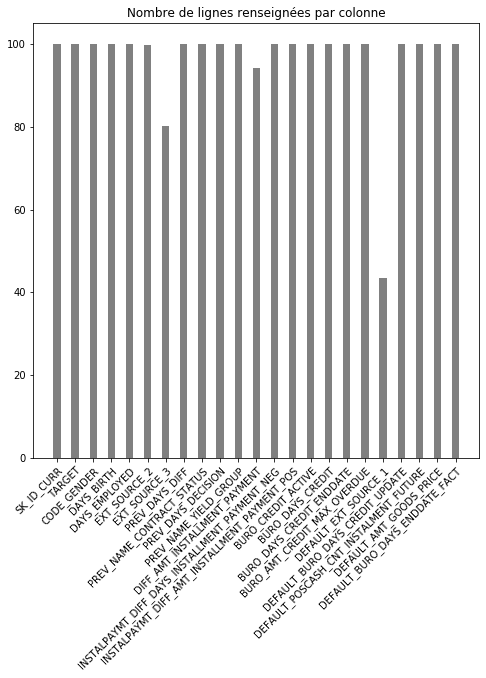

In [91]:
print(dfApplicationWorked.shape)
numerical_ix = dfApplicationWorked.select_dtypes(include=['int64', 'float64']).columns
myDf(dfApplicationWorked[numerical_ix]).ColCountLinesChart(displayColName=True)

#### Valeurs catégorielles

(215257, 25)


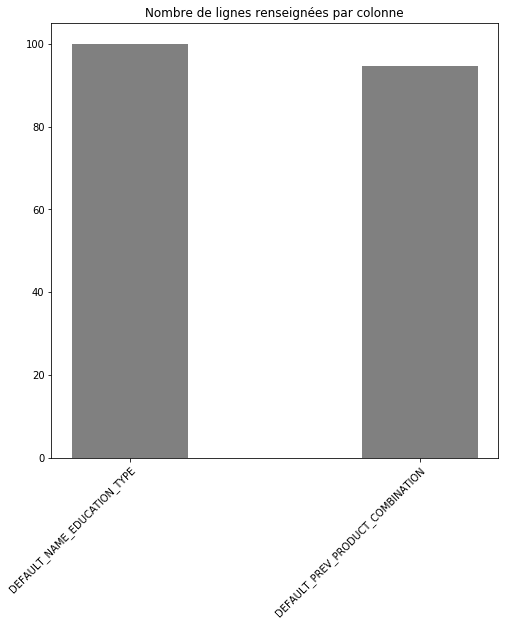

In [92]:
print(dfApplicationWorked.shape)
categorical_ix = dfApplicationWorked.select_dtypes(include=['object', 'bool']).columns
myDf(dfApplicationWorked[categorical_ix]).ColCountLinesChart(displayColName=True)

### Evaluation de l'iterative imputer

#### Comparaison avec le mean imputer

 > 0.733 (0.008) 91 


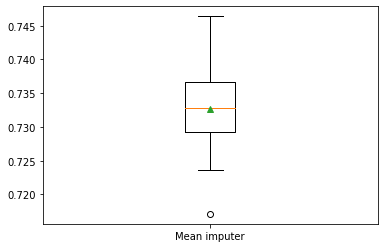

 > 0.737 (0.004) 327 


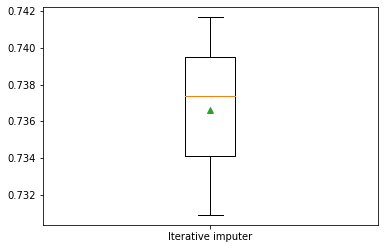

In [115]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import warnings
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')

dfApplicationWorked = dfApplicationWorkedSvg.copy()

y = dfApplicationWorked['TARGET']
del dfApplicationWorked['TARGET']
del dfApplicationWorked['SK_ID_CURR']
X = dfApplicationWorked
X_col = dfApplicationWorked.columns

#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
evaluateImputer(SimpleImputer(strategy='mean'), model, X, y, 'Mean imputer', cv=10)
evaluateImputer(IterativeImputer(), model, X, y, 'Iterative imputer')

#### Optimisation de la stratégie

2021-01-22 22:42:54.875785
 >1 0.737 (0.004) 71 
 >2 0.737 (0.004) 124 
 >5 0.736 (0.004) 282 
 >10 0.737 (0.004) 338 


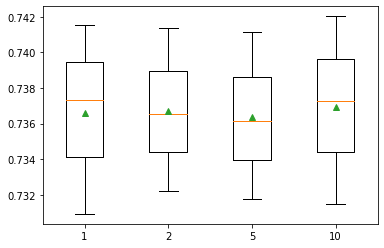

In [113]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


strategies = ['1','2','5','10']
#strategies = ['1']
encoder = OneHotEncoder(handle_unknown='ignore', sparse=True)
#encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-10)

print(datetime.datetime.now())

results = list()
for s in strategies:
    # create the modeling pipeline
    numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_ix = X.select_dtypes(include=['object', 'bool']).columns
    t = [('cat', encoder, categorical_ix), ('num', MinMaxScaler(), numerical_ix)]
    col_transform = ColumnTransformer(transformers=t)
    pipeline = Pipeline(steps=[('prep',col_transform), ('i', IterativeImputer(max_iter=int(s))), ('m', RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1))])
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    cv=3
    t1 = time.time()
    scores = cross_val_score(pipeline, X, y, scoring= 'roc_auc' , cv=cv, n_jobs=-1)
    t2 = time.time()
    # store results
    results.append(scores)
    print( ' >%s %.3f (%.3f) %.0f ' % (s, mean(scores), std(scores), t2-t1))
    # plot model performance for comparison
plt.boxplot(results, labels=strategies, showmeans=True)
plt.show()

#### Iterative imputer basé sur un random forest

 > 0.735 (0.005) 17768 


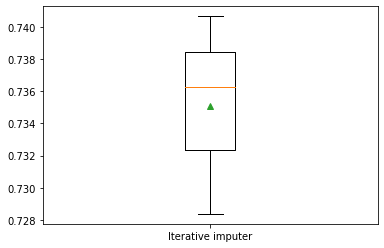

In [114]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import warnings
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')

dfApplicationWorked = dfApplicationWorkedSvg.copy()

y = dfApplicationWorked['TARGET']
del dfApplicationWorked['TARGET']
del dfApplicationWorked['SK_ID_CURR']
X = dfApplicationWorked
X_col = dfApplicationWorked.columns

model = RandomForestClassifier(n_estimators=200, max_depth=5, n_jobs=-1)
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#evaluateImputer(SimpleImputer(strategy='mean'), model, X, y, 'Mean imputer')
evaluateImputer(IterativeImputer(estimator=RandomForestRegressor(n_estimators=100, max_depth=5, n_jobs=-1)), model, X, y, 'Iterative imputer')

In [33]:
X_d, y_d = OverUnder(X_d, y_d)
X_w, y_w = OverUnder(X_w, y_w)

Counter({0: 16912, 1: 1205})
Counter({0: 16912, 1: 5073})
Counter({0: 10146, 1: 5073})
Counter({0: 45876, 1: 3706})
Counter({0: 45876, 1: 13762})
Counter({0: 27524, 1: 13762})
